The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j130100m1131'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.3-c1b-14-122.0-F105W 4
CL1301-11.3-c1b-14-122.0-G102 4

 == Grism groups ==

ic1b-122.0-f105w 4 ic1b-122.0-g102 4


ic1b-122.0-f105w                4
ic1b-122.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.3-c1b-14-122.0-F105W 4
CL1301-11.3-c1b-14-122.0-G102 4

 == Grism groups ==

cl1301-11.3-c1b-14-122.0-f105w 4 cl1301-11.3-c1b-14-122.0-g102 4


cl1301-11.3-c1b-14-122.0-f105w  4
cl1301-11.3-c1b-14-122.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1301-11.3-c1b-14-122.0-f105w 4 cl1301-11.3-c1b-14-122.0-g102 4
Skip cl1301-11.3-c1b-14-122.0-f105w
Skip cl1301-11.3-c1b-14-122.0-f105w
Skip cl1301-11.3-c1b-14-122.0-g102
utils.fix_flt_nan: ic1b14vrq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14w3q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14vwq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14vpq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14vhq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14w5q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14vyq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b14vkq_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1301-11.3-c1b-14-122.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b14vhq_flt.fits'] = ['ic1b14vkq_flt.fits']
# match['ic1b14vpq_flt.fits'] = ['ic1b14vrq_flt.fits']
# match['ic1b14vwq_flt.fits'] = ['ic1b14vyq_flt.fits']
# match['ic1b14w3q_flt.fits'] = ['ic1b14w5q_flt.fits']
ic1b14vhq_flt.fits  -0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b14vpq_flt.fits   0.104   0.032  0.00000  1.00000    44  0.058  0.074
ic1b14vwq_flt.fits   0.027   0.106  0.00000  1.00000    42  0.064  0.072
ic1b14w3q_flt.fits   0.120   0.017  0.00000  1.00000    41  0.048  0.061


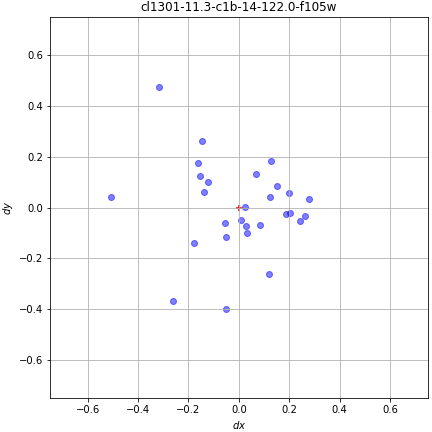

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1301-11.3-c1b-14-122.0-f105w_wcs.png") 


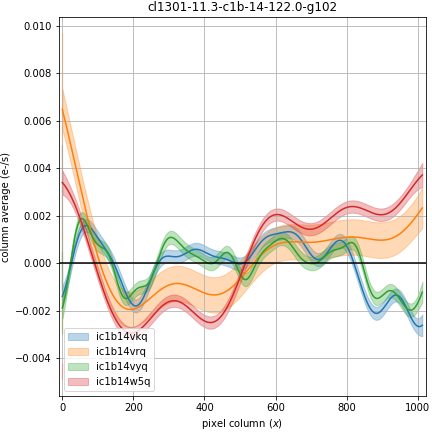

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1301-11.3-c1b-14-122.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 -3.2476 -2.8468 0.0128 1.00016 0.107 28


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

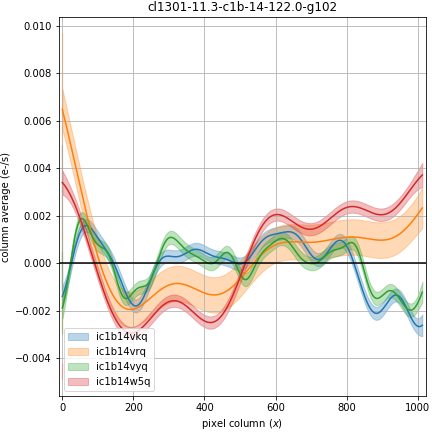

In [18]:
from IPython.display import Image
Image(filename = "./cl1301-11.3-c1b-14-122.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1301-11.3-c1b-14-122.0-f105w         0.00   -0.36


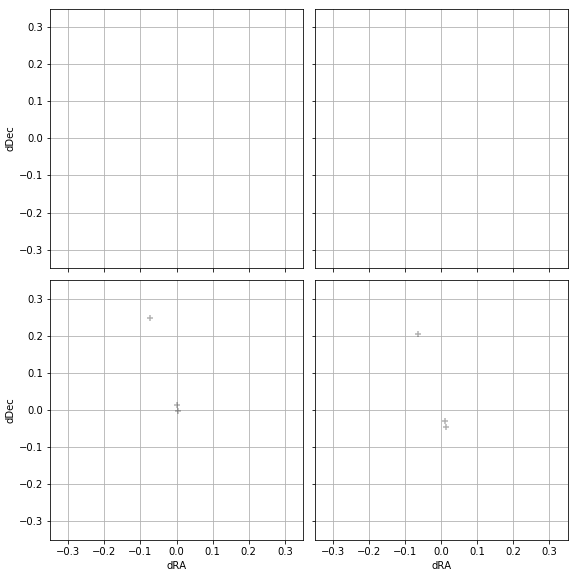

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j130100m1131-f105w_drz_sci.fits
j130100m1131-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j130100m1131-ir_bkg.fits
j130100m1131-ir.cat.fits
j130100m1131-ir_seg.fits
j130100m1131-ir_drz_wht.fits
j130100m1131-ir_drz_sci.fits
j130100m1131_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j130100m1131-ir_drz_sci.fits
WHT_FILE:	j130100m1131-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5224999189376831
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j130100m1131-f105w_drz_sci.fits
F105W_WHT_FILE:	j130100m1131-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5224999189376831
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b14w5q.01.GrismFLT.fits!
Load ic1b14vyq.01.GrismFLT.fits!
Load ic1b14vrq.01.GrismFLT.fits!
Load ic1b14vkq.01.GrismFLT.fits!
Files loaded - 3.91 sec.


### The final contamination model ###

IndexError: list index out of range

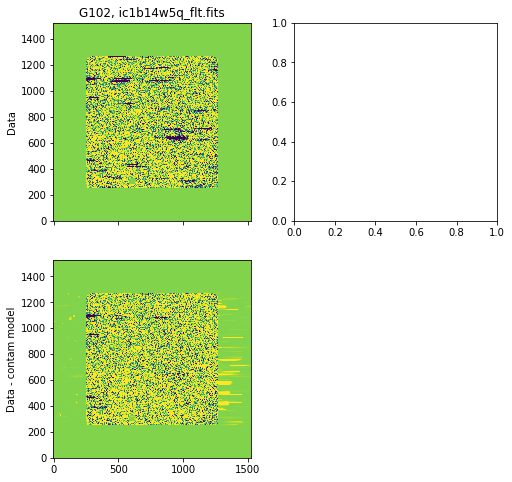

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [35]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j130100m1131/Extractions/d_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 

In [36]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [37]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j130100m1131 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j130100m1131 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j130100m1131 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j130100m1131 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j130100m1131 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j130100m1131 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j130100m1131-f105w_psf.fits'] 

Filename: j130100m1131-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


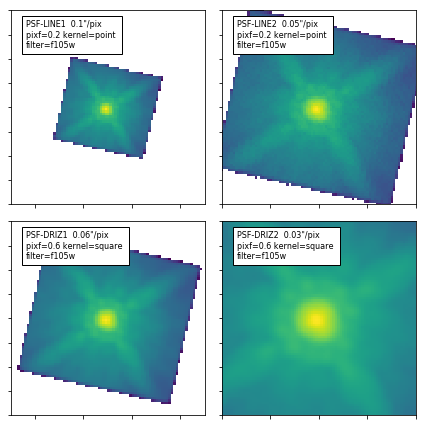

In [38]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [39]:
os.chdir('../Extractions')

In [40]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [41]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/158: 54 4
j130100m1131_00054.beams.fits
1/158: 305 4
j130100m1131_00305.beams.fits
2/158: 320 4
j130100m1131_00320.beams.fits
3/158: 307 0
4/158: 21 1
j130100m1131_00021.beams.fits
5/158: 229 4
j130100m1131_00229.beams.fits
6/158: 366 4
j130100m1131_00366.beams.fits
7/158: 3 4
j130100m1131_00003.beams.fits
8/158: 35 4
j130100m1131_00035.beams.fits
9/158: 107 4
j130100m1131_00107.beams.fits
10/158: 294 4
j130100m1131_00294.beams.fits
11/158: 396 4
j130100m1131_00396.beams.fits
12/158: 144 4
j130100m1131_00144.beams.fits
13/158: 5 4
j130100m1131_00005.beams.fits
14/158: 218 0
15/158: 341 4
j130100m1131_00341.beams.fits
16/158: 389 4
j130100m1131_00389.beams.fits
17/158: 378 4
j130100m1131_00378.beams.fits
18/158: 45 4
j130100m1131_00045.beams.fits
19/158: 433 0
20/158: 334 4
j130100m1131_00334.beams.fits
21/158: 123 4
j130100m1131_00123.beams.fits
22/158: 273 4
j130100m1131_00273.beams.fits
23/158: 385 4
j130100m1131_00385.beams.fits
24/158: 468 4
j130100m1131_00468.beams.fits
25/158: 

  0.2857  406649.3 (0.1916) 40/341
  0.2909  406652.3 (0.1916) 41/341
  0.2960  406623.5 (0.1916) 42/341
  0.3012  406606.5 (0.1916) 43/341
  0.3064  406590.7 (0.1916) 44/341
  0.3117  406508.0 (0.1916) 45/341
  0.3169  406457.2 (0.1916) 46/341
  0.3222  406385.7 (0.1916) 47/341
  0.3275  406302.4 (0.1916) 48/341
  0.3328  406229.3 (0.1916) 49/341
  0.3382  406151.3 (0.1916) 50/341
  0.3435  406067.4 (0.1916) 51/341
  0.3489  406022.8 (0.1916) 52/341
  0.3543  405994.6 (0.1916) 53/341
  0.3598  405954.0 (0.1916) 54/341
  0.3652  405903.3 (0.1916) 55/341
  0.3707  405854.5 (0.1916) 56/341
  0.3762  405807.3 (0.1916) 57/341
  0.3817  405748.1 (0.1916) 58/341
  0.3872  405712.5 (0.1916) 59/341
  0.3928  405677.1 (0.1916) 60/341
  0.3984  405664.9 (0.3984) 61/341
  0.4040  405677.7 (0.3984) 62/341
  0.4096  405675.6 (0.3984) 63/341
  0.4153  405669.0 (0.3984) 64/341
  0.4209  405677.6 (0.3984) 65/341
  0.4266  405674.0 (0.3984) 66/341
  0.4323  405674.1 (0.3984) 67/341
  0.4381  405680.5 (

  1.7273  410394.8 (0.3984) 228/341
  1.7382  409593.5 (0.3984) 229/341
  1.7492  408734.9 (0.3984) 230/341
  1.7602  408083.5 (0.3984) 231/341
  1.7713  407665.6 (0.3984) 232/341
  1.7824  407399.6 (0.3984) 233/341
  1.7935  406853.2 (0.3984) 234/341
  1.8047  406696.5 (0.3984) 235/341
  1.8160  406556.6 (0.3984) 236/341
  1.8273  406328.4 (0.3984) 237/341
  1.8386  406143.3 (0.3984) 238/341
  1.8500  406142.7 (0.3984) 239/341
  1.8614  406065.5 (0.3984) 240/341
  1.8729  406049.7 (0.3984) 241/341
  1.8844  405779.4 (0.3984) 242/341
  1.8959  405745.0 (0.3984) 243/341
  1.9075  406275.9 (0.3984) 244/341
  1.9192  406695.0 (0.3984) 245/341
  1.9309  406886.0 (0.3984) 246/341
  1.9426  406947.1 (0.3984) 247/341
  1.9544  407143.6 (0.3984) 248/341
  1.9663  407330.0 (0.3984) 249/341
  1.9782  407372.2 (0.3984) 250/341
  1.9901  407310.8 (0.3984) 251/341
  2.0021  407263.7 (0.3984) 252/341
  2.0141  407083.0 (0.3984) 253/341
  2.0262  406904.4 (0.3984) 254/341
  2.0383  406744.7 (0.3984) 

  0.2806   75524.7 (0.1177) 39/341
  0.2857   75452.0 (0.1177) 40/341
  0.2909   75376.9 (0.1177) 41/341
  0.2960   75256.4 (0.2960) 42/341
  0.3012   75208.0 (0.3012) 43/341
  0.3064   75175.9 (0.3064) 44/341
  0.3117   75121.9 (0.3117) 45/341
  0.3169   75081.3 (0.3169) 46/341
  0.3222   75046.3 (0.3222) 47/341
  0.3275   75024.7 (0.3275) 48/341
  0.3328   75059.7 (0.3275) 49/341
  0.3382   75075.9 (0.3275) 50/341
  0.3435   75099.7 (0.3275) 51/341
  0.3489   75204.7 (0.3275) 52/341
  0.3543   75247.6 (0.3275) 53/341
  0.3598   75282.5 (0.3275) 54/341
  0.3652   75319.4 (0.3275) 55/341
  0.3707   75367.6 (0.3275) 56/341
  0.3762   75382.4 (0.3275) 57/341
  0.3817   75370.9 (0.3275) 58/341
  0.3872   75367.3 (0.3275) 59/341
  0.3928   75468.4 (0.3275) 60/341
  0.3984   75541.5 (0.3275) 61/341
  0.4040   75574.5 (0.3275) 62/341
  0.4096   75579.1 (0.3275) 63/341
  0.4153   75618.8 (0.3275) 64/341
  0.4209   75620.8 (0.3275) 65/341
  0.4266   75616.5 (0.3275) 66/341
  0.4323   75637.4 (

  1.7382   81818.6 (0.3275) 229/341
  1.7492   81961.3 (0.3275) 230/341
  1.7602   81780.1 (0.3275) 231/341
  1.7713   81819.9 (0.3275) 232/341
  1.7824   81882.6 (0.3275) 233/341
  1.7935   81958.5 (0.3275) 234/341
  1.8047   81730.8 (0.3275) 235/341
  1.8160   81820.8 (0.3275) 236/341
  1.8273   81956.5 (0.3275) 237/341
  1.8386   82144.1 (0.3275) 238/341
  1.8500   82096.0 (0.3275) 239/341
  1.8614   81865.9 (0.3275) 240/341
  1.8729   81681.8 (0.3275) 241/341
  1.8844   81257.4 (0.3275) 242/341
  1.8959   80904.1 (0.3275) 243/341
  1.9075   80648.0 (0.3275) 244/341
  1.9192   80403.8 (0.3275) 245/341
  1.9309   80161.9 (0.3275) 246/341
  1.9426   79707.7 (0.3275) 247/341
  1.9544   79356.7 (0.3275) 248/341
  1.9663   79033.8 (0.3275) 249/341
  1.9782   78704.0 (0.3275) 250/341
  1.9901   78139.6 (0.3275) 251/341
  2.0021   77765.4 (0.3275) 252/341
  2.0141   77435.4 (0.3275) 253/341
  2.0262   77265.7 (0.3275) 254/341
  2.0383   77043.8 (0.3275) 255/341
  2.0505   76727.1 (0.3275) 

  0.2857   16407.5 (0.2502) 40/341
  0.2909   16480.8 (0.2502) 41/341
  0.2960   16566.6 (0.2502) 42/341
  0.3012   16643.2 (0.2502) 43/341
  0.3064   16714.5 (0.2502) 44/341
  0.3117   16774.4 (0.2502) 45/341
  0.3169   16813.1 (0.2502) 46/341
  0.3222   16845.7 (0.2502) 47/341
  0.3275   16892.5 (0.2502) 48/341
  0.3328   16910.5 (0.2502) 49/341
  0.3382   16901.1 (0.2502) 50/341
  0.3435   16883.5 (0.2502) 51/341
  0.3489   16869.9 (0.2502) 52/341
  0.3543   16853.4 (0.2502) 53/341
  0.3598   16851.9 (0.2502) 54/341
  0.3652   16880.3 (0.2502) 55/341
  0.3707   16929.8 (0.2502) 56/341
  0.3762   17022.8 (0.2502) 57/341
  0.3817   17158.2 (0.2502) 58/341
  0.3872   17276.2 (0.2502) 59/341
  0.3928   17325.9 (0.2502) 60/341
  0.3984   17353.6 (0.2502) 61/341
  0.4040   17361.2 (0.2502) 62/341
  0.4096   17337.5 (0.2502) 63/341
  0.4153   17289.1 (0.2502) 64/341
  0.4209   17223.4 (0.2502) 65/341
  0.4266   17135.7 (0.2502) 66/341
  0.4323   17028.8 (0.2502) 67/341
  0.4381   16911.3 (

  1.7273   29496.3 (0.2502) 228/341
  1.7382   29938.2 (0.2502) 229/341
  1.7492   30310.7 (0.2502) 230/341
  1.7602   30865.2 (0.2502) 231/341
  1.7713   31196.1 (0.2502) 232/341
  1.7824   31346.5 (0.2502) 233/341
  1.7935   31610.1 (0.2502) 234/341
  1.8047   31756.1 (0.2502) 235/341
  1.8160   31595.7 (0.2502) 236/341
  1.8273   31245.8 (0.2502) 237/341
  1.8386   30388.5 (0.2502) 238/341
  1.8500   28979.2 (0.2502) 239/341
  1.8614   27397.2 (0.2502) 240/341
  1.8729   26022.2 (0.2502) 241/341
  1.8844   24849.2 (0.2502) 242/341
  1.8959   23874.2 (0.2502) 243/341
  1.9075   23008.5 (0.2502) 244/341
  1.9192   22199.5 (0.2502) 245/341
  1.9309   21456.5 (0.2502) 246/341
  1.9426   20703.5 (0.2502) 247/341
  1.9544   20080.9 (0.2502) 248/341
  1.9663   19449.1 (0.2502) 249/341
  1.9782   18966.6 (0.2502) 250/341
  1.9901   18615.4 (0.2502) 251/341
  2.0021   18358.6 (0.2502) 252/341
  2.0141   17997.7 (0.2502) 253/341
  2.0262   17520.3 (0.2502) 254/341
  2.0383   17078.1 (0.2502) 

  0.4554   13304.7 (0.3872) 71/341
  0.4613   13307.0 (0.3872) 72/341
  0.4671   13315.5 (0.3872) 73/341
  0.4730   13337.3 (0.3872) 74/341
  0.4789   13354.9 (0.3872) 75/341
  0.4848   13350.0 (0.3872) 76/341
  0.4908   13349.4 (0.3872) 77/341
  0.4968   13353.9 (0.3872) 78/341
  0.5028   13361.6 (0.3872) 79/341
  0.5088   13362.0 (0.3872) 80/341
  0.5148   13361.2 (0.3872) 81/341
  0.5209   13359.0 (0.3872) 82/341
  0.5270   13356.4 (0.3872) 83/341
  0.5331   13359.8 (0.3872) 84/341
  0.5393   13372.6 (0.3872) 85/341
  0.5454   13391.5 (0.3872) 86/341
  0.5516   13412.4 (0.3872) 87/341
  0.5579   13438.3 (0.3872) 88/341
  0.5641   13454.3 (0.3872) 89/341
  0.5704   13468.6 (0.3872) 90/341
  0.5767   13474.4 (0.3872) 91/341
  0.5830   13480.9 (0.3872) 92/341
  0.5893   13493.6 (0.3872) 93/341
  0.5957   13505.6 (0.3872) 94/341
  0.6021   13510.3 (0.3872) 95/341
  0.6085   13498.1 (0.3872) 96/341
  0.6150   13510.1 (0.3872) 97/341
  0.6214   13513.9 (0.3872) 98/341
  0.6279   13505.1 (

  2.4810   13452.8 (1.8729) 289/341
  2.4949   13455.3 (1.8729) 290/341
  2.5089   13461.9 (1.8729) 291/341
  2.5230   13472.3 (1.8729) 292/341
  2.5371   13489.0 (1.8729) 293/341
  2.5513   13510.6 (1.8729) 294/341
  2.5655   13530.5 (1.8729) 295/341
  2.5798   13541.5 (1.8729) 296/341
  2.5942   13544.7 (1.8729) 297/341
  2.6086   13546.0 (1.8729) 298/341
  2.6230   13549.8 (1.8729) 299/341
  2.6375   13559.1 (1.8729) 300/341
  2.6521   13574.6 (1.8729) 301/341
  2.6668   13586.9 (1.8729) 302/341
  2.6815   13593.0 (1.8729) 303/341
  2.6962   13590.8 (1.8729) 304/341
  2.7110   13579.7 (1.8729) 305/341
  2.7259   13570.7 (1.8729) 306/341
  2.7408   13566.3 (1.8729) 307/341
  2.7558   13569.9 (1.8729) 308/341
  2.7709   13570.4 (1.8729) 309/341
  2.7860   13565.2 (1.8729) 310/341
  2.8012   13560.6 (1.8729) 311/341
  2.8164   13562.3 (1.8729) 312/341
  2.8317   13562.8 (1.8729) 313/341
  2.8471   13562.9 (1.8729) 314/341
  2.8625   13563.2 (1.8729) 315/341
  2.8780   13561.8 (1.8729) 

  0.6608    8146.3 (0.4671) 104/341
  0.6675    8146.6 (0.4671) 105/341
  0.6742    8136.5 (0.4671) 106/341
  0.6809    8129.8 (0.4671) 107/341
  0.6876    8145.5 (0.4671) 108/341
  0.6944    8159.1 (0.4671) 109/341
  0.7012    8165.6 (0.4671) 110/341
  0.7080    8177.1 (0.4671) 111/341
  0.7148    8181.3 (0.4671) 112/341
  0.7217    8181.1 (0.4671) 113/341
  0.7286    8182.8 (0.4671) 114/341
  0.7355    8188.3 (0.4671) 115/341
  0.7425    8194.9 (0.4671) 116/341
  0.7495    8189.1 (0.4671) 117/341
  0.7565    8180.7 (0.4671) 118/341
  0.7635    8176.0 (0.4671) 119/341
  0.7706    8172.5 (0.4671) 120/341
  0.7777    8163.5 (0.4671) 121/341
  0.7848    8164.9 (0.4671) 122/341
  0.7920    8171.5 (0.4671) 123/341
  0.7991    8176.5 (0.4671) 124/341
  0.8064    8181.0 (0.4671) 125/341
  0.8136    8183.1 (0.4671) 126/341
  0.8209    8177.2 (0.4671) 127/341
  0.8282    8174.9 (0.4671) 128/341
  0.8355    8177.0 (0.4671) 129/341
  0.8428    8176.7 (0.4671) 130/341
  0.8502    8176.6 (0.4671) 

  2.5513    8180.7 (0.4671) 294/341
  2.5655    8180.8 (0.4671) 295/341
  2.5798    8177.0 (0.4671) 296/341
  2.5942    8177.5 (0.4671) 297/341
  2.6086    8182.6 (0.4671) 298/341
  2.6230    8182.1 (0.4671) 299/341
  2.6375    8176.0 (0.4671) 300/341
  2.6521    8175.5 (0.4671) 301/341
  2.6668    8181.4 (0.4671) 302/341
  2.6815    8180.1 (0.4671) 303/341
  2.6962    8171.0 (0.4671) 304/341
  2.7110    8162.6 (0.4671) 305/341
  2.7259    8156.9 (0.4671) 306/341
  2.7408    8148.0 (0.4671) 307/341
  2.7558    8137.5 (0.4671) 308/341
  2.7709    8137.8 (0.4671) 309/341
  2.7860    8151.0 (0.4671) 310/341
  2.8012    8162.4 (0.4671) 311/341
  2.8164    8163.9 (0.4671) 312/341
  2.8317    8169.6 (0.4671) 313/341
  2.8471    8178.9 (0.4671) 314/341
  2.8625    8192.1 (0.4671) 315/341
  2.8780    8205.2 (0.4671) 316/341
  2.8935    8210.8 (0.4671) 317/341
  2.9091    8217.9 (0.4671) 318/341
  2.9248    8232.1 (0.4671) 319/341
  2.9405    8242.7 (0.4671) 320/341
  2.9563    8243.9 (0.4671) 

  0.6809    6556.0 (0.2552) 107/341
  0.6876    6555.9 (0.2552) 108/341
  0.6944    6554.7 (0.2552) 109/341
  0.7012    6551.7 (0.2552) 110/341
  0.7080    6542.5 (0.2552) 111/341
  0.7148    6540.3 (0.2552) 112/341
  0.7217    6552.1 (0.2552) 113/341
  0.7286    6558.1 (0.2552) 114/341
  0.7355    6559.6 (0.2552) 115/341
  0.7425    6567.3 (0.2552) 116/341
  0.7495    6569.5 (0.2552) 117/341
  0.7565    6571.2 (0.2552) 118/341
  0.7635    6572.1 (0.2552) 119/341
  0.7706    6572.1 (0.2552) 120/341
  0.7777    6566.2 (0.2552) 121/341
  0.7848    6562.2 (0.2552) 122/341
  0.7920    6572.9 (0.2552) 123/341
  0.7991    6576.6 (0.2552) 124/341
  0.8064    6566.7 (0.2552) 125/341
  0.8136    6565.3 (0.2552) 126/341
  0.8209    6571.2 (0.2552) 127/341
  0.8282    6572.8 (0.2552) 128/341
  0.8355    6569.1 (0.2552) 129/341
  0.8428    6569.9 (0.2552) 130/341
  0.8502    6566.8 (0.2552) 131/341
  0.8576    6567.5 (0.2552) 132/341
  0.8651    6566.6 (0.2552) 133/341
  0.8726    6576.8 (0.2552) 

  2.6086    6568.5 (0.2552) 298/341
  2.6230    6572.7 (0.2552) 299/341
  2.6375    6573.8 (0.2552) 300/341
  2.6521    6570.7 (0.2552) 301/341
  2.6668    6565.1 (0.2552) 302/341
  2.6815    6565.5 (0.2552) 303/341
  2.6962    6570.1 (0.2552) 304/341
  2.7110    6570.8 (0.2552) 305/341
  2.7259    6566.7 (0.2552) 306/341
  2.7408    6562.2 (0.2552) 307/341
  2.7558    6558.6 (0.2552) 308/341
  2.7709    6555.6 (0.2552) 309/341
  2.7860    6557.8 (0.2552) 310/341
  2.8012    6556.1 (0.2552) 311/341
  2.8164    6548.6 (0.2552) 312/341
  2.8317    6546.3 (0.2552) 313/341
  2.8471    6549.0 (0.2552) 314/341
  2.8625    6551.0 (0.2552) 315/341
  2.8780    6554.2 (0.2552) 316/341
  2.8935    6564.7 (0.2552) 317/341
  2.9091    6579.0 (0.2552) 318/341
  2.9248    6586.0 (0.2552) 319/341
  2.9405    6592.7 (0.2552) 320/341
  2.9563    6598.6 (0.2552) 321/341
  2.9722    6598.5 (0.2552) 322/341
  2.9881    6603.8 (0.2552) 323/341
  3.0041    6611.0 (0.2552) 324/341
  3.0201    6623.3 (0.2552) 

  0.5088    5958.0 (0.2255) 80/341
  0.5148    5955.1 (0.2255) 81/341
  0.5209    5954.7 (0.2255) 82/341
  0.5270    5952.5 (0.2255) 83/341
  0.5331    5945.2 (0.2255) 84/341
  0.5393    5950.3 (0.2255) 85/341
  0.5454    5951.2 (0.2255) 86/341
  0.5516    5949.1 (0.2255) 87/341
  0.5579    5949.2 (0.2255) 88/341
  0.5641    5946.7 (0.2255) 89/341
  0.5704    5944.9 (0.2255) 90/341
  0.5767    5936.9 (0.2255) 91/341
  0.5830    5937.5 (0.2255) 92/341
  0.5893    5941.5 (0.2255) 93/341
  0.5957    5943.9 (0.2255) 94/341
  0.6021    5945.7 (0.2255) 95/341
  0.6085    5956.6 (0.2255) 96/341
  0.6150    5956.2 (0.2255) 97/341
  0.6214    5948.5 (0.2255) 98/341
  0.6279    5954.0 (0.2255) 99/341
  0.6345    5953.9 (0.2255) 100/341
  0.6410    5948.3 (0.2255) 101/341
  0.6476    5950.6 (0.2255) 102/341
  0.6542    5945.8 (0.2255) 103/341
  0.6608    5942.8 (0.2255) 104/341
  0.6675    5962.1 (0.2255) 105/341
  0.6742    5966.6 (0.2255) 106/341
  0.6809    5962.6 (0.2255) 107/341
  0.6876    

  2.2391    6006.1 (0.9963) 271/341
  2.2521    6000.1 (0.9963) 272/341
  2.2652    5997.0 (0.9963) 273/341
  2.2783    6002.7 (0.9963) 274/341
  2.2914    6006.1 (0.9963) 275/341
  2.3046    6002.9 (0.9963) 276/341
  2.3178    5992.8 (0.9963) 277/341
  2.3311    5988.7 (0.9963) 278/341
  2.3445    5993.7 (0.9963) 279/341
  2.3579    5995.4 (0.9963) 280/341
  2.3713    5987.7 (0.9963) 281/341
  2.3849    5987.0 (0.9963) 282/341
  2.3984    5993.9 (0.9963) 283/341
  2.4120    5994.1 (0.9963) 284/341
  2.4257    5991.8 (0.9963) 285/341
  2.4394    5992.6 (0.9963) 286/341
  2.4532    6000.2 (0.9963) 287/341
  2.4671    6001.5 (0.9963) 288/341
  2.4810    5990.1 (0.9963) 289/341
  2.4949    5979.4 (0.9963) 290/341
  2.5089    5987.8 (0.9963) 291/341
  2.5230    5987.7 (0.9963) 292/341
  2.5371    5974.8 (0.9963) 293/341
  2.5513    5960.6 (0.9963) 294/341
  2.5655    5959.2 (0.9963) 295/341
  2.5798    5966.6 (0.9963) 296/341
  2.5942    5958.8 (0.9963) 297/341
  2.6086    5954.0 (0.9963) 

  0.3435    8806.2 (0.3012) 51/341
  0.3489    8804.3 (0.3012) 52/341
  0.3543    8801.7 (0.3012) 53/341
  0.3598    8805.5 (0.3012) 54/341
  0.3652    8809.4 (0.3012) 55/341
  0.3707    8807.9 (0.3012) 56/341
  0.3762    8812.9 (0.3012) 57/341
  0.3817    8817.3 (0.3012) 58/341
  0.3872    8819.4 (0.3012) 59/341
  0.3928    8828.1 (0.3012) 60/341
  0.3984    8822.2 (0.3012) 61/341
  0.4040    8823.8 (0.3012) 62/341
  0.4096    8834.9 (0.3012) 63/341
  0.4153    8837.3 (0.3012) 64/341
  0.4209    8837.0 (0.3012) 65/341
  0.4266    8850.6 (0.3012) 66/341
  0.4323    8862.2 (0.3012) 67/341
  0.4381    8864.2 (0.3012) 68/341
  0.4438    8876.6 (0.3012) 69/341
  0.4496    8888.0 (0.3012) 70/341
  0.4554    8884.3 (0.3012) 71/341
  0.4613    8872.5 (0.3012) 72/341
  0.4671    8870.3 (0.3012) 73/341
  0.4730    8870.0 (0.3012) 74/341
  0.4789    8878.0 (0.3012) 75/341
  0.4848    8886.8 (0.3012) 76/341
  0.4908    8888.8 (0.3012) 77/341
  0.4968    8868.3 (0.3012) 78/341
  0.5028    8842.1 (

  1.9192   10319.5 (0.3012) 245/341
  1.9309   10124.8 (0.3012) 246/341
  1.9426    9971.5 (0.3012) 247/341
  1.9544    9890.4 (0.3012) 248/341
  1.9663    9738.3 (0.3012) 249/341
  1.9782    9646.8 (0.3012) 250/341
  1.9901    9557.5 (0.3012) 251/341
  2.0021    9395.5 (0.3012) 252/341
  2.0141    9235.5 (0.3012) 253/341
  2.0262    9067.7 (0.3012) 254/341
  2.0383    8955.1 (0.3012) 255/341
  2.0505    8894.0 (0.3012) 256/341
  2.0627    8857.0 (0.3012) 257/341
  2.0750    8836.2 (0.3012) 258/341
  2.0873    8819.3 (0.3012) 259/341
  2.0997    8797.1 (0.3012) 260/341
  2.1121    8790.6 (0.3012) 261/341
  2.1246    8787.9 (0.3012) 262/341
  2.1371    8794.7 (0.3012) 263/341
  2.1497    8791.9 (0.3012) 264/341
  2.1623    8813.4 (0.3012) 265/341
  2.1750    8828.5 (0.3012) 266/341
  2.1877    8831.9 (0.3012) 267/341
  2.2005    8830.2 (0.3012) 268/341
  2.2133    8825.7 (0.3012) 269/341
  2.2262    8821.2 (0.3012) 270/341
  2.2391    8815.8 (0.3012) 271/341
  2.2521    8810.8 (0.3012) 

  0.3707    3616.9 (0.3328) 56/341
  0.3762    3622.2 (0.3328) 57/341
  0.3817    3618.5 (0.3328) 58/341
  0.3872    3617.9 (0.3328) 59/341
  0.3928    3624.9 (0.3328) 60/341
  0.3984    3625.1 (0.3328) 61/341
  0.4040    3620.8 (0.3328) 62/341
  0.4096    3622.0 (0.3328) 63/341
  0.4153    3622.5 (0.3328) 64/341
  0.4209    3620.6 (0.3328) 65/341
  0.4266    3622.9 (0.3328) 66/341
  0.4323    3622.5 (0.3328) 67/341
  0.4381    3620.6 (0.3328) 68/341
  0.4438    3616.4 (0.3328) 69/341
  0.4496    3608.7 (0.3328) 70/341
  0.4554    3606.0 (0.3328) 71/341
  0.4613    3605.2 (0.4613) 72/341
  0.4671    3605.3 (0.4613) 73/341
  0.4730    3607.0 (0.4613) 74/341
  0.4789    3609.1 (0.4613) 75/341
  0.4848    3609.7 (0.4613) 76/341
  0.4908    3608.5 (0.4613) 77/341
  0.4968    3608.0 (0.4613) 78/341
  0.5028    3612.3 (0.4613) 79/341
  0.5088    3615.2 (0.4613) 80/341
  0.5148    3617.7 (0.4613) 81/341
  0.5209    3617.5 (0.4613) 82/341
  0.5270    3616.2 (0.4613) 83/341
  0.5331    3616.3 (

  1.9544    3609.5 (0.7425) 248/341
  1.9663    3609.3 (0.7425) 249/341
  1.9782    3607.4 (0.7425) 250/341
  1.9901    3606.4 (0.7425) 251/341
  2.0021    3607.5 (0.7425) 252/341
  2.0141    3609.1 (0.7425) 253/341
  2.0262    3610.1 (0.7425) 254/341
  2.0383    3611.1 (0.7425) 255/341
  2.0505    3613.3 (0.7425) 256/341
  2.0627    3614.8 (0.7425) 257/341
  2.0750    3616.0 (0.7425) 258/341
  2.0873    3618.5 (0.7425) 259/341
  2.0997    3622.3 (0.7425) 260/341
  2.1121    3626.1 (0.7425) 261/341
  2.1246    3628.6 (0.7425) 262/341
  2.1371    3629.5 (0.7425) 263/341
  2.1497    3630.9 (0.7425) 264/341
  2.1623    3632.4 (0.7425) 265/341
  2.1750    3633.2 (0.7425) 266/341
  2.1877    3633.3 (0.7425) 267/341
  2.2005    3633.6 (0.7425) 268/341
  2.2133    3632.2 (0.7425) 269/341
  2.2262    3631.1 (0.7425) 270/341
  2.2391    3632.2 (0.7425) 271/341
  2.2521    3632.7 (0.7425) 272/341
  2.2652    3630.1 (0.7425) 273/341
  2.2783    3628.0 (0.7425) 274/341
  2.2914    3627.9 (0.7425) 

Drizzle line -> CIII-1908 (22.46 28.81)
Get linemap PSF: F105W
10/158: 294
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    6876.5 (0.1000) 1/341
  0.1044    6889.5 (0.1000) 2/341
  0.1088    6893.1 (0.1000) 3/341
  0.1133    6885.6 (0.1000) 4/341
  0.1177    6894.0 (0.1000) 5/341
  0.1222    6903.1 (0.1000) 6/341
  0.1267    6907.7 (0.1000) 7/341
  0.1312    6904.2 (0.1000) 8/341
  0.1358    6896.9 (0.1000) 9/341
  0.1403    6890.0 (0.1000) 10/341
  0.1449    6892.0 (0.1000) 11/341
  0.1495    6899.0 (0.1000) 12/341
  0.1541    6904.9 (0.1000) 13/341
  0.1587    6902.5 (0.1000) 14/341
  0.1634    6909.7 (0.1000) 15/341
  0.1680    6913.6 (0.1000) 16/341
  0.1727    6915.6 (0.1000) 17/341
  0.1774    6914.3 (0.1000) 18/341
  0.1821    6912.1 (0.1000) 19/341
  0.1869    6910.4 (0.1000) 20/341
  0.1916    6916.6 (0.1000) 21/341
  0.1964    6926.4 (0.1000) 22/341
  0.2012    6932.3 (0.1000) 23/341
  

  1.3521    6906.8 (1.1198) 191/341
  1.3615    6907.1 (1.1198) 192/341
  1.3710    6880.2 (1.1198) 193/341
  1.3805    6897.9 (1.1198) 194/341
  1.3900    6920.1 (1.1198) 195/341
  1.3996    6930.9 (1.1198) 196/341
  1.4092    6920.1 (1.1198) 197/341
  1.4189    6925.0 (1.1198) 198/341
  1.4286    6907.3 (1.1198) 199/341
  1.4383    6902.5 (1.1198) 200/341
  1.4481    6896.0 (1.1198) 201/341
  1.4579    6914.5 (1.1198) 202/341
  1.4678    6930.8 (1.1198) 203/341
  1.4776    6929.2 (1.1198) 204/341
  1.4876    6922.5 (1.1198) 205/341
  1.4975    6908.6 (1.1198) 206/341
  1.5076    6916.2 (1.1198) 207/341
  1.5176    6952.2 (1.1198) 208/341
  1.5277    6993.2 (1.1198) 209/341
  1.5378    7010.4 (1.1198) 210/341
  1.5480    7048.2 (1.1198) 211/341
  1.5582    7095.8 (1.1198) 212/341
  1.5685    7107.3 (1.1198) 213/341
  1.5788    7117.8 (1.1198) 214/341
  1.5891    7140.6 (1.1198) 215/341
  1.5995    7185.9 (1.1198) 216/341
  1.6099    7244.2 (1.1198) 217/341
  1.6204    7266.9 (1.1198) 

Drizzle line -> OII  (3.09 12.43)
Get linemap PSF: F105W
11/158: 396
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000   16616.6 (0.1000) 1/341
  0.1044   16621.5 (0.1000) 2/341
  0.1088   16627.1 (0.1000) 3/341
  0.1133   16626.3 (0.1000) 4/341
  0.1177   16622.3 (0.1000) 5/341
  0.1222   16620.1 (0.1000) 6/341
  0.1267   16617.5 (0.1000) 7/341
  0.1312   16617.5 (0.1000) 8/341
  0.1358   16619.4 (0.1000) 9/341
  0.1403   16620.6 (0.1000) 10/341
  0.1449   16623.7 (0.1000) 11/341
  0.1495   16627.5 (0.1000) 12/341
  0.1541   16626.7 (0.1000) 13/341
  0.1587   16626.5 (0.1000) 14/341
  0.1634   16627.7 (0.1000) 15/341
  0.1680   16625.3 (0.1000) 16/341
  0.1727   16607.3 (0.1727) 17/341
  0.1774   16604.6 (0.1774) 18/341
  0.1821   16616.8 (0.1774) 19/341
  0.1869   16615.5 (0.1774) 20/341
  0.1916   16615.2 (0.1774) 21/341
  0.1964   16611.1 (0.1774) 22/341
  0.2012   16603.6 (0.2012) 23/341
  0.2060

  1.3334   16904.8 (0.2353) 189/341
  1.3427   16921.7 (0.2353) 190/341
  1.3521   16934.5 (0.2353) 191/341
  1.3615   16937.1 (0.2353) 192/341
  1.3710   16953.6 (0.2353) 193/341
  1.3805   16961.0 (0.2353) 194/341
  1.3900   16962.3 (0.2353) 195/341
  1.3996   16973.8 (0.2353) 196/341
  1.4092   16983.5 (0.2353) 197/341
  1.4189   17006.3 (0.2353) 198/341
  1.4286   17026.0 (0.2353) 199/341
  1.4383   17032.3 (0.2353) 200/341
  1.4481   17041.2 (0.2353) 201/341
  1.4579   17042.1 (0.2353) 202/341
  1.4678   17043.7 (0.2353) 203/341
  1.4776   17053.0 (0.2353) 204/341
  1.4876   17063.3 (0.2353) 205/341
  1.4975   17087.3 (0.2353) 206/341
  1.5076   17097.5 (0.2353) 207/341
  1.5176   17092.1 (0.2353) 208/341
  1.5277   17090.3 (0.2353) 209/341
  1.5378   17090.0 (0.2353) 210/341
  1.5480   17092.3 (0.2353) 211/341
  1.5582   17103.5 (0.2353) 212/341
  1.5685   17118.5 (0.2353) 213/341
  1.5788   17132.3 (0.2353) 214/341
  1.5891   17127.5 (0.2353) 215/341
  1.5995   17105.6 (0.2353) 

Get linemap PSF: F105W
12/158: 144
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    5459.3 (0.1000) 1/341
  0.1044    5461.6 (0.1000) 2/341
  0.1088    5465.4 (0.1000) 3/341
  0.1133    5470.9 (0.1000) 4/341
  0.1177    5476.8 (0.1000) 5/341
  0.1222    5483.5 (0.1000) 6/341
  0.1267    5490.2 (0.1000) 7/341
  0.1312    5497.1 (0.1000) 8/341
  0.1358    5503.2 (0.1000) 9/341
  0.1403    5508.6 (0.1000) 10/341
  0.1449    5512.9 (0.1000) 11/341
  0.1495    5517.2 (0.1000) 12/341
  0.1541    5520.3 (0.1000) 13/341
  0.1587    5522.5 (0.1000) 14/341
  0.1634    5522.5 (0.1000) 15/341
  0.1680    5520.8 (0.1000) 16/341
  0.1727    5515.6 (0.1000) 17/341
  0.1774    5507.4 (0.1000) 18/341
  0.1821    5498.0 (0.1000) 19/341
  0.1869    5489.5 (0.1000) 20/341
  0.1916    5482.8 (0.1000) 21/341
  0.1964    5478.5 (0.1000) 22/341
  0.2012    5476.8 (0.1000) 23/341
  0.2060    5477.6 (0.1000) 24/341
  0.210

  1.3334    5438.1 (0.4908) 189/341
  1.3427    5432.4 (0.4908) 190/341
  1.3521    5430.7 (0.4908) 191/341
  1.3615    5432.7 (0.4908) 192/341
  1.3710    5434.1 (0.4908) 193/341
  1.3805    5432.6 (0.4908) 194/341
  1.3900    5431.7 (0.4908) 195/341
  1.3996    5423.4 (0.4908) 196/341
  1.4092    5413.2 (0.4908) 197/341
  1.4189    5403.1 (0.4908) 198/341
  1.4286    5396.3 (0.4908) 199/341
  1.4383    5395.1 (0.4908) 200/341
  1.4481    5398.1 (0.4908) 201/341
  1.4579    5400.3 (0.4908) 202/341
  1.4678    5405.0 (0.4908) 203/341
  1.4776    5413.9 (0.4908) 204/341
  1.4876    5426.3 (0.4908) 205/341
  1.4975    5439.7 (0.4908) 206/341
  1.5076    5452.3 (0.4908) 207/341
  1.5176    5463.0 (0.4908) 208/341
  1.5277    5475.1 (0.4908) 209/341
  1.5378    5486.1 (0.4908) 210/341
  1.5480    5489.0 (0.4908) 211/341
  1.5582    5498.3 (0.4908) 212/341
  1.5685    5508.3 (0.4908) 213/341
  1.5788    5512.0 (0.4908) 214/341
  1.5891    5498.3 (0.4908) 215/341
  1.5995    5472.7 (0.4908) 

13/158: 5
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    6978.0 (0.1000) 1/341
  0.1044    6978.2 (0.1000) 2/341
  0.1088    6977.1 (0.1088) 3/341
  0.1133    6977.5 (0.1088) 4/341
  0.1177    6977.6 (0.1088) 5/341
  0.1222    6979.1 (0.1088) 6/341
  0.1267    6979.3 (0.1088) 7/341
  0.1312    6982.4 (0.1088) 8/341
  0.1358    6984.6 (0.1088) 9/341
  0.1403    6986.8 (0.1088) 10/341
  0.1449    6987.8 (0.1088) 11/341
  0.1495    6989.0 (0.1088) 12/341
  0.1541    6989.0 (0.1088) 13/341
  0.1587    6988.4 (0.1088) 14/341
  0.1634    6986.3 (0.1088) 15/341
  0.1680    6984.6 (0.1088) 16/341
  0.1727    6982.5 (0.1088) 17/341
  0.1774    6981.3 (0.1088) 18/341
  0.1821    6977.4 (0.1088) 19/341
  0.1869    6975.7 (0.1869) 20/341
  0.1916    6976.1 (0.1869) 21/341
  0.1964    6972.7 (0.1964) 22/341
  0.2012    6967.7 (0.2012) 23/341
  0.2060    6964.7 (0.2060) 24/341
  0.2108    6960.7 (0.2108) 25/3

  1.3427    6934.8 (1.0204) 190/341
  1.3521    6929.1 (1.0204) 191/341
  1.3615    6928.4 (1.0204) 192/341
  1.3710    6925.4 (1.0204) 193/341
  1.3805    6923.2 (1.0204) 194/341
  1.3900    6930.3 (1.0204) 195/341
  1.3996    6935.3 (1.0204) 196/341
  1.4092    6940.7 (1.0204) 197/341
  1.4189    6944.8 (1.0204) 198/341
  1.4286    6945.2 (1.0204) 199/341
  1.4383    6951.0 (1.0204) 200/341
  1.4481    6961.2 (1.0204) 201/341
  1.4579    6974.1 (1.0204) 202/341
  1.4678    6991.4 (1.0204) 203/341
  1.4776    7005.4 (1.0204) 204/341
  1.4876    7016.4 (1.0204) 205/341
  1.4975    7014.0 (1.0204) 206/341
  1.5076    7016.3 (1.0204) 207/341
  1.5176    7033.3 (1.0204) 208/341
  1.5277    7042.9 (1.0204) 209/341
  1.5378    7057.2 (1.0204) 210/341
  1.5480    7077.0 (1.0204) 211/341
  1.5582    7087.8 (1.0204) 212/341
  1.5685    7104.3 (1.0204) 213/341
  1.5788    7122.8 (1.0204) 214/341
  1.5891    7132.0 (1.0204) 215/341
  1.5995    7143.8 (1.0204) 216/341
  1.6099    7166.2 (1.0204) 

Drizzle line -> OII  (327489.32 219857.20)
Get linemap PSF: F105W
14/158: 218
15/158: 341
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    7124.3 (0.1000) 1/341
  0.1044    7131.2 (0.1000) 2/341
  0.1088    7194.0 (0.1000) 3/341
  0.1133    7252.3 (0.1000) 4/341
  0.1177    7282.4 (0.1000) 5/341
  0.1222    7292.0 (0.1000) 6/341
  0.1267    7298.3 (0.1000) 7/341
  0.1312    7299.4 (0.1000) 8/341
  0.1358    7295.0 (0.1000) 9/341
  0.1403    7289.3 (0.1000) 10/341
  0.1449    7284.5 (0.1000) 11/341
  0.1495    7282.4 (0.1000) 12/341
  0.1541    7282.2 (0.1000) 13/341
  0.1587    7283.7 (0.1000) 14/341
  0.1634    7289.5 (0.1000) 15/341
  0.1680    7290.6 (0.1000) 16/341
  0.1727    7290.6 (0.1000) 17/341
  0.1774    7291.9 (0.1000) 18/341
  0.1821    7292.1 (0.1000) 19/341
  0.1869    7291.2 (0.1000) 20/341
  0.1916    7293.7 (0.1000) 21/341
  0.1964    7298.2 (0.1000) 22/341
  0.2012    7306.7 (0.

  1.3334    7290.9 (0.5957) 189/341
  1.3427    7300.2 (0.5957) 190/341
  1.3521    7305.6 (0.5957) 191/341
  1.3615    7314.3 (0.5957) 192/341
  1.3710    7324.6 (0.5957) 193/341
  1.3805    7335.2 (0.5957) 194/341
  1.3900    7343.9 (0.5957) 195/341
  1.3996    7359.8 (0.5957) 196/341
  1.4092    7376.1 (0.5957) 197/341
  1.4189    7385.3 (0.5957) 198/341
  1.4286    7386.1 (0.5957) 199/341
  1.4383    7376.9 (0.5957) 200/341
  1.4481    7360.4 (0.5957) 201/341
  1.4579    7337.7 (0.5957) 202/341
  1.4678    7317.9 (0.5957) 203/341
  1.4776    7309.2 (0.5957) 204/341
  1.4876    7300.6 (0.5957) 205/341
  1.4975    7289.8 (0.5957) 206/341
  1.5076    7283.5 (0.5957) 207/341
  1.5176    7283.5 (0.5957) 208/341
  1.5277    7292.8 (0.5957) 209/341
  1.5378    7307.4 (0.5957) 210/341
  1.5480    7323.2 (0.5957) 211/341
  1.5582    7328.5 (0.5957) 212/341
  1.5685    7315.4 (0.5957) 213/341
  1.5788    7295.2 (0.5957) 214/341
  1.5891    7271.1 (0.5957) 215/341
  1.5995    7258.4 (0.5957) 

- 1.0947    7131.9 (0.5986) 38/66
- 1.0952    7128.9 (0.5986) 39/66
- 1.0957    7126.3 (0.5986) 40/66
- 1.0962    7124.0 (0.5986) 41/66
- 1.0967    7122.1 (0.5986) 42/66
- 1.0972    7120.5 (0.5986) 43/66
- 1.0977    7119.4 (0.5986) 44/66
- 1.0982    7118.5 (0.5986) 45/66
- 1.0987    7117.9 (0.5986) 46/66
- 1.0992    7117.5 (0.5986) 47/66
- 1.0997    7117.4 (0.5986) 48/66
- 1.1002    7117.5 (0.5986) 49/66
- 1.1007    7117.9 (0.5986) 50/66
- 1.1012    7118.7 (0.5986) 51/66
- 1.1017    7119.8 (0.5986) 52/66
- 1.1022    7121.0 (0.5986) 53/66
- 1.1027    7122.4 (0.5986) 54/66
- 1.1032    7123.9 (0.5986) 55/66
- 1.1037    7125.5 (0.5986) 56/66
- 1.1042    7127.0 (0.5986) 57/66
- 1.1047    7128.5 (0.5986) 58/66
- 1.1052    7130.2 (0.5986) 59/66
- 1.1057    7131.9 (0.5986) 60/66
- 1.1062    7133.7 (0.5986) 61/66
- 1.1067    7135.6 (0.5986) 62/66
- 1.1072    7137.4 (0.5986) 63/66
- 1.1077    7139.4 (0.5986) 64/66
- 1.1082    7141.6 (0.5986) 65/66
- 1.1087    7143.8 (0.5986) 66/66
Drizzle line -

  1.0695   10420.2 (0.5957) 159/341
  1.0778   10421.3 (0.5957) 160/341
  1.0861   10419.0 (0.5957) 161/341
  1.0945   10416.3 (0.5957) 162/341
  1.1029   10417.7 (0.5957) 163/341
  1.1113   10420.6 (0.5957) 164/341
  1.1198   10423.5 (0.5957) 165/341
  1.1283   10425.8 (0.5957) 166/341
  1.1368   10426.0 (0.5957) 167/341
  1.1454   10424.3 (0.5957) 168/341
  1.1540   10423.8 (0.5957) 169/341
  1.1626   10427.2 (0.5957) 170/341
  1.1713   10428.0 (0.5957) 171/341
  1.1800   10426.0 (0.5957) 172/341
  1.1887   10429.3 (0.5957) 173/341
  1.1975   10437.4 (0.5957) 174/341
  1.2063   10442.6 (0.5957) 175/341
  1.2151   10443.8 (0.5957) 176/341
  1.2240   10440.0 (0.5957) 177/341
  1.2329   10437.4 (0.5957) 178/341
  1.2419   10437.4 (0.5957) 179/341
  1.2509   10433.8 (0.5957) 180/341
  1.2599   10426.7 (0.5957) 181/341
  1.2689   10422.7 (0.5957) 182/341
  1.2780   10432.6 (0.5957) 183/341
  1.2872   10441.7 (0.5957) 184/341
  1.2963   10446.1 (0.5957) 185/341
  1.3055   10451.3 (0.5957) 

- 0.1124   10415.2 (0.1124) 7/429
- 0.1129   10414.8 (0.1129) 8/429
- 0.1134   10414.4 (0.1134) 9/429
- 0.1139   10414.1 (0.1139) 10/429
- 0.1144   10413.7 (0.1144) 11/429
- 0.1149   10413.4 (0.1149) 12/429
- 0.1154   10413.1 (0.1154) 13/429
- 0.1159   10412.9 (0.1159) 14/429
- 0.1164   10412.7 (0.1164) 15/429
- 0.1169   10412.7 (0.1169) 16/429
- 0.1174   10412.7 (0.1169) 17/429
- 0.1179   10412.7 (0.1169) 18/429
- 0.1184   10412.9 (0.1169) 19/429
- 0.1189   10413.1 (0.1169) 20/429
- 0.1194   10413.4 (0.1169) 21/429
- 0.1199   10413.7 (0.1169) 22/429
- 0.1204   10414.0 (0.1169) 23/429
- 0.1209   10414.4 (0.1169) 24/429
- 0.1214   10414.7 (0.1169) 25/429
- 0.1219   10415.1 (0.1169) 26/429
- 0.1224   10415.3 (0.1169) 27/429
- 0.1229   10415.5 (0.1169) 28/429
- 0.1234   10415.7 (0.1169) 29/429
- 0.1239   10415.8 (0.1169) 30/429
- 0.1244   10415.8 (0.1169) 31/429
- 0.1249   10415.8 (0.1169) 32/429
- 0.1254   10415.7 (0.1169) 33/429
- 0.1649   10410.3 (0.1649) 34/429
- 0.1654   10410.3 (0.1

- 0.5996   10406.8 (0.5931) 196/429
- 0.6001   10407.2 (0.5931) 197/429
- 0.6006   10407.6 (0.5931) 198/429
- 0.7229   10409.0 (0.5931) 199/429
- 0.7234   10408.8 (0.5931) 200/429
- 0.7239   10408.7 (0.5931) 201/429
- 0.7244   10408.5 (0.5931) 202/429
- 0.7249   10408.3 (0.5931) 203/429
- 0.7254   10408.2 (0.5931) 204/429
- 0.7259   10408.1 (0.5931) 205/429
- 0.7264   10408.2 (0.5931) 206/429
- 0.7269   10408.2 (0.5931) 207/429
- 0.7274   10408.2 (0.5931) 208/429
- 0.7279   10408.1 (0.5931) 209/429
- 0.7284   10408.1 (0.5931) 210/429
- 0.7289   10408.2 (0.5931) 211/429
- 0.7294   10408.2 (0.5931) 212/429
- 0.7299   10408.2 (0.5931) 213/429
- 0.7304   10408.3 (0.5931) 214/429
- 0.7309   10408.3 (0.5931) 215/429
- 0.7314   10408.3 (0.5931) 216/429
- 0.7319   10408.4 (0.5931) 217/429
- 0.7324   10408.6 (0.5931) 218/429
- 0.7329   10408.7 (0.5931) 219/429
- 0.7334   10408.7 (0.5931) 220/429
- 0.7339   10408.7 (0.5931) 221/429
- 0.7344   10408.6 (0.5931) 222/429
- 0.7349   10408.5 (0.5931) 

- 2.5624   10406.0 (0.5931) 384/429
- 2.5629   10406.0 (0.5931) 385/429
- 2.5634   10406.0 (0.5931) 386/429
- 2.5639   10406.0 (0.5931) 387/429
- 2.5644   10406.0 (0.5931) 388/429
- 2.5649   10406.1 (0.5931) 389/429
- 2.5654   10406.1 (0.5931) 390/429
- 2.5659   10406.1 (0.5931) 391/429
- 2.5664   10406.1 (0.5931) 392/429
- 2.5669   10406.1 (0.5931) 393/429
- 2.5674   10406.2 (0.5931) 394/429
- 2.5679   10406.2 (0.5931) 395/429
- 2.5684   10406.2 (0.5931) 396/429
- 2.9059   10412.5 (0.5931) 397/429
- 2.9064   10412.4 (0.5931) 398/429
- 2.9069   10412.4 (0.5931) 399/429
- 2.9074   10412.4 (0.5931) 400/429
- 2.9079   10412.4 (0.5931) 401/429
- 2.9084   10412.4 (0.5931) 402/429
- 2.9089   10412.4 (0.5931) 403/429
- 2.9094   10412.4 (0.5931) 404/429
- 2.9099   10412.3 (0.5931) 405/429
- 2.9104   10412.3 (0.5931) 406/429
- 2.9109   10412.3 (0.5931) 407/429
- 2.9114   10412.3 (0.5931) 408/429
- 2.9119   10412.3 (0.5931) 409/429
- 2.9124   10412.3 (0.5931) 410/429
- 2.9129   10412.3 (0.5931) 

  0.9104    4582.8 (0.5331) 139/341
  0.9181    4575.3 (0.5331) 140/341
  0.9257    4585.2 (0.5331) 141/341
  0.9335    4571.6 (0.5331) 142/341
  0.9412    4547.1 (0.5331) 143/341
  0.9490    4567.5 (0.5331) 144/341
  0.9568    4567.3 (0.5331) 145/341
  0.9646    4550.1 (0.5331) 146/341
  0.9725    4554.1 (0.5331) 147/341
  0.9804    4551.9 (0.5331) 148/341
  0.9884    4560.3 (0.5331) 149/341
  0.9963    4539.8 (0.5331) 150/341
  1.0043    4568.0 (0.5331) 151/341
  1.0124    4610.4 (0.5331) 152/341
  1.0204    4632.6 (0.5331) 153/341
  1.0285    4621.1 (0.5331) 154/341
  1.0367    4626.2 (0.5331) 155/341
  1.0448    4665.1 (0.5331) 156/341
  1.0530    4687.8 (0.5331) 157/341
  1.0612    4660.5 (0.5331) 158/341
  1.0695    4637.5 (0.5331) 159/341
  1.0778    4632.0 (0.5331) 160/341
  1.0861    4672.8 (0.5331) 161/341
  1.0945    4701.3 (0.5331) 162/341
  1.1029    4691.0 (0.5331) 163/341
  1.1113    4721.0 (0.5331) 164/341
  1.1198    4743.3 (0.5331) 165/341
  1.1283    4746.2 (0.5331) 

  3.1178    4543.0 (0.5331) 331/341
  3.1343    4549.7 (0.5331) 332/341
  3.1508    4549.3 (0.5331) 333/341
  3.1675    4536.3 (0.5331) 334/341
  3.1842    4531.9 (0.5331) 335/341
  3.2009    4547.3 (0.5331) 336/341
  3.2178    4559.0 (0.5331) 337/341
  3.2347    4561.7 (0.5331) 338/341
  3.2517    4563.2 (0.5331) 339/341
  3.2687    4562.2 (0.5331) 340/341
  3.2858    4558.4 (0.5331) 341/341
First iteration: z_best=0.5331

- 0.5252    4517.5 (0.5252) 1/132
- 0.5257    4516.8 (0.5257) 2/132
- 0.5262    4517.7 (0.5257) 3/132
- 0.5267    4519.0 (0.5257) 4/132
- 0.5272    4520.2 (0.5257) 5/132
- 0.5277    4520.2 (0.5257) 6/132
- 0.5282    4517.7 (0.5257) 7/132
- 0.5287    4515.9 (0.5287) 8/132
- 0.5292    4515.5 (0.5292) 9/132
- 0.5297    4514.9 (0.5297) 10/132
- 0.5302    4513.9 (0.5302) 11/132
- 0.5307    4513.8 (0.5307) 12/132
- 0.5312    4514.5 (0.5307) 13/132
- 0.5317    4514.7 (0.5307) 14/132
- 0.5322    4514.1 (0.5307) 15/132
- 0.5327    4514.1 (0.5307) 16/132
- 0.5332    4513.7 (0

  0.2909   58493.8 (0.2755) 41/341
  0.2960   58535.6 (0.2755) 42/341
  0.3012   58571.1 (0.2755) 43/341
  0.3064   58588.8 (0.2755) 44/341
  0.3117   58584.4 (0.2755) 45/341
  0.3169   58606.1 (0.2755) 46/341
  0.3222   58650.9 (0.2755) 47/341
  0.3275   58699.2 (0.2755) 48/341
  0.3328   58748.2 (0.2755) 49/341
  0.3382   58799.1 (0.2755) 50/341
  0.3435   58843.3 (0.2755) 51/341
  0.3489   58874.7 (0.2755) 52/341
  0.3543   58887.0 (0.2755) 53/341
  0.3598   58882.0 (0.2755) 54/341
  0.3652   58873.6 (0.2755) 55/341
  0.3707   58854.5 (0.2755) 56/341
  0.3762   58827.8 (0.2755) 57/341
  0.3817   58809.7 (0.2755) 58/341
  0.3872   58803.4 (0.2755) 59/341
  0.3928   58804.6 (0.2755) 60/341
  0.3984   58799.1 (0.2755) 61/341
  0.4040   58786.2 (0.2755) 62/341
  0.4096   58774.6 (0.2755) 63/341
  0.4153   58768.7 (0.2755) 64/341
  0.4209   58754.5 (0.2755) 65/341
  0.4266   58729.5 (0.2755) 66/341
  0.4323   58697.5 (0.2755) 67/341
  0.4381   58666.9 (0.2755) 68/341
  0.4438   58651.7 (

  1.7713   63865.7 (0.7706) 232/341
  1.7824   63781.8 (0.7706) 233/341
  1.7935   63636.6 (0.7706) 234/341
  1.8047   63405.1 (0.7706) 235/341
  1.8160   63113.2 (0.7706) 236/341
  1.8273   62779.5 (0.7706) 237/341
  1.8386   62418.3 (0.7706) 238/341
  1.8500   62064.9 (0.7706) 239/341
  1.8614   61783.9 (0.7706) 240/341
  1.8729   61587.8 (0.7706) 241/341
  1.8844   61395.9 (0.7706) 242/341
  1.8959   61113.0 (0.7706) 243/341
  1.9075   60763.9 (0.7706) 244/341
  1.9192   60384.5 (0.7706) 245/341
  1.9309   60059.1 (0.7706) 246/341
  1.9426   59750.3 (0.7706) 247/341
  1.9544   59403.9 (0.7706) 248/341
  1.9663   59075.6 (0.7706) 249/341
  1.9782   58806.6 (0.7706) 250/341
  1.9901   58555.3 (0.7706) 251/341
  2.0021   58338.2 (0.7706) 252/341
  2.0141   58175.7 (0.7706) 253/341
  2.0262   58053.4 (0.7706) 254/341
  2.0383   57989.8 (0.7706) 255/341
  2.0505   57974.5 (0.7706) 256/341
  2.0627   57989.8 (0.7706) 257/341
  2.0750   57859.9 (0.7706) 258/341
  2.0873   57611.3 (0.7706) 

  0.2909    6551.5 (0.1000) 41/341
  0.2960    6545.6 (0.2960) 42/341
  0.3012    6541.5 (0.3012) 43/341
  0.3064    6543.7 (0.3012) 44/341
  0.3117    6547.4 (0.3012) 45/341
  0.3169    6556.1 (0.3012) 46/341
  0.3222    6567.0 (0.3012) 47/341
  0.3275    6572.9 (0.3012) 48/341
  0.3328    6578.0 (0.3012) 49/341
  0.3382    6583.4 (0.3012) 50/341
  0.3435    6586.0 (0.3012) 51/341
  0.3489    6588.0 (0.3012) 52/341
  0.3543    6591.0 (0.3012) 53/341
  0.3598    6594.2 (0.3012) 54/341
  0.3652    6597.9 (0.3012) 55/341
  0.3707    6598.7 (0.3012) 56/341
  0.3762    6599.8 (0.3012) 57/341
  0.3817    6599.6 (0.3012) 58/341
  0.3872    6595.9 (0.3012) 59/341
  0.3928    6595.0 (0.3012) 60/341
  0.3984    6598.1 (0.3012) 61/341
  0.4040    6597.0 (0.3012) 62/341
  0.4096    6596.1 (0.3012) 63/341
  0.4153    6592.4 (0.3012) 64/341
  0.4209    6589.3 (0.3012) 65/341
  0.4266    6590.2 (0.3012) 66/341
  0.4323    6593.0 (0.3012) 67/341
  0.4381    6594.4 (0.3012) 68/341
  0.4438    6592.3 (

  1.7935    6946.6 (0.4968) 234/341
  1.8047    6931.5 (0.4968) 235/341
  1.8160    6918.6 (0.4968) 236/341
  1.8273    6913.7 (0.4968) 237/341
  1.8386    6905.3 (0.4968) 238/341
  1.8500    6875.4 (0.4968) 239/341
  1.8614    6846.5 (0.4968) 240/341
  1.8729    6833.9 (0.4968) 241/341
  1.8844    6825.5 (0.4968) 242/341
  1.8959    6816.5 (0.4968) 243/341
  1.9075    6791.0 (0.4968) 244/341
  1.9192    6755.6 (0.4968) 245/341
  1.9309    6723.8 (0.4968) 246/341
  1.9426    6702.1 (0.4968) 247/341
  1.9544    6679.4 (0.4968) 248/341
  1.9663    6659.5 (0.4968) 249/341
  1.9782    6641.9 (0.4968) 250/341
  1.9901    6629.3 (0.4968) 251/341
  2.0021    6618.2 (0.4968) 252/341
  2.0141    6608.8 (0.4968) 253/341
  2.0262    6603.6 (0.4968) 254/341
  2.0383    6593.7 (0.4968) 255/341
  2.0505    6584.3 (0.4968) 256/341
  2.0627    6579.2 (0.4968) 257/341
  2.0750    6578.6 (0.4968) 258/341
  2.0873    6578.5 (0.4968) 259/341
  2.0997    6576.9 (0.4968) 260/341
  2.1121    6574.7 (0.4968) 

  0.1495    7958.4 (0.1088) 12/341
  0.1541    7958.9 (0.1088) 13/341
  0.1587    7961.6 (0.1088) 14/341
  0.1634    7964.7 (0.1088) 15/341
  0.1680    7968.5 (0.1088) 16/341
  0.1727    7972.3 (0.1088) 17/341
  0.1774    7975.3 (0.1088) 18/341
  0.1821    7977.1 (0.1088) 19/341
  0.1869    7979.5 (0.1088) 20/341
  0.1916    7979.8 (0.1088) 21/341
  0.1964    7979.6 (0.1088) 22/341
  0.2012    7979.2 (0.1088) 23/341
  0.2060    7978.8 (0.1088) 24/341
  0.2108    7977.5 (0.1088) 25/341
  0.2157    7975.5 (0.1088) 26/341
  0.2206    7972.9 (0.1088) 27/341
  0.2255    7971.3 (0.1088) 28/341
  0.2304    7970.4 (0.1088) 29/341
  0.2353    7970.6 (0.1088) 30/341
  0.2402    7970.2 (0.1088) 31/341
  0.2452    7969.4 (0.1088) 32/341
  0.2502    7968.8 (0.1088) 33/341
  0.2552    7967.9 (0.1088) 34/341
  0.2603    7966.9 (0.1088) 35/341
  0.2653    7966.7 (0.1088) 36/341
  0.2704    7966.2 (0.1088) 37/341
  0.2755    7966.3 (0.1088) 38/341
  0.2806    7965.9 (0.1088) 39/341
  0.2857    7965.2 (

  1.4776    7971.2 (0.5331) 204/341
  1.4876    7969.0 (0.5331) 205/341
  1.4975    7970.9 (0.5331) 206/341
  1.5076    7974.3 (0.5331) 207/341
  1.5176    7977.2 (0.5331) 208/341
  1.5277    7981.4 (0.5331) 209/341
  1.5378    7981.9 (0.5331) 210/341
  1.5480    7980.5 (0.5331) 211/341
  1.5582    7977.3 (0.5331) 212/341
  1.5685    7983.7 (0.5331) 213/341
  1.5788    7992.9 (0.5331) 214/341
  1.5891    8000.4 (0.5331) 215/341
  1.5995    8001.0 (0.5331) 216/341
  1.6099    8004.8 (0.5331) 217/341
  1.6204    8009.3 (0.5331) 218/341
  1.6309    8014.2 (0.5331) 219/341
  1.6414    8024.7 (0.5331) 220/341
  1.6520    8034.5 (0.5331) 221/341
  1.6626    8039.2 (0.5331) 222/341
  1.6733    8041.0 (0.5331) 223/341
  1.6840    8027.4 (0.5331) 224/341
  1.6948    8011.1 (0.5331) 225/341
  1.7056    8018.6 (0.5331) 226/341
  1.7164    8048.5 (0.5331) 227/341
  1.7273    8084.0 (0.5331) 228/341
  1.7382    8118.4 (0.5331) 229/341
  1.7492    8142.2 (0.5331) 230/341
  1.7602    8154.6 (0.5331) 

  0.1587    9223.7 (0.1000) 14/341
  0.1634    9225.1 (0.1000) 15/341
  0.1680    9225.0 (0.1000) 16/341
  0.1727    9223.2 (0.1000) 17/341
  0.1774    9222.2 (0.1000) 18/341
  0.1821    9221.6 (0.1000) 19/341
  0.1869    9220.4 (0.1000) 20/341
  0.1916    9219.4 (0.1000) 21/341
  0.1964    9216.7 (0.1000) 22/341
  0.2012    9214.6 (0.1000) 23/341
  0.2060    9213.4 (0.1000) 24/341
  0.2108    9212.3 (0.1000) 25/341
  0.2157    9210.5 (0.1000) 26/341
  0.2206    9207.5 (0.2206) 27/341
  0.2255    9204.9 (0.2255) 28/341
  0.2304    9201.9 (0.2304) 29/341
  0.2353    9199.3 (0.2353) 30/341
  0.2402    9196.7 (0.2402) 31/341
  0.2452    9193.1 (0.2452) 32/341
  0.2502    9191.3 (0.2502) 33/341
  0.2552    9189.5 (0.2552) 34/341
  0.2603    9193.8 (0.2552) 35/341
  0.2653    9199.9 (0.2552) 36/341
  0.2704    9200.2 (0.2552) 37/341
  0.2755    9202.0 (0.2552) 38/341
  0.2806    9205.3 (0.2552) 39/341
  0.2857    9209.0 (0.2552) 40/341
  0.2909    9211.1 (0.2552) 41/341
  0.2960    9212.6 (

  1.4776    9424.8 (0.2552) 204/341
  1.4876    9442.4 (0.2552) 205/341
  1.4975    9459.5 (0.2552) 206/341
  1.5076    9469.5 (0.2552) 207/341
  1.5176    9484.8 (0.2552) 208/341
  1.5277    9510.2 (0.2552) 209/341
  1.5378    9520.8 (0.2552) 210/341
  1.5480    9527.2 (0.2552) 211/341
  1.5582    9534.0 (0.2552) 212/341
  1.5685    9553.6 (0.2552) 213/341
  1.5788    9580.2 (0.2552) 214/341
  1.5891    9600.8 (0.2552) 215/341
  1.5995    9612.4 (0.2552) 216/341
  1.6099    9630.5 (0.2552) 217/341
  1.6204    9651.3 (0.2552) 218/341
  1.6309    9654.7 (0.2552) 219/341
  1.6414    9658.0 (0.2552) 220/341
  1.6520    9672.5 (0.2552) 221/341
  1.6626    9683.5 (0.2552) 222/341
  1.6733    9694.6 (0.2552) 223/341
  1.6840    9711.9 (0.2552) 224/341
  1.6948    9720.2 (0.2552) 225/341
  1.7056    9726.8 (0.2552) 226/341
  1.7164    9723.4 (0.2552) 227/341
  1.7273    9718.3 (0.2552) 228/341
  1.7382    9717.2 (0.2552) 229/341
  1.7492    9713.9 (0.2552) 230/341
  1.7602    9704.9 (0.2552) 

- 0.6485    9196.4 (0.2552) 54/66
- 0.6490    9196.6 (0.2552) 55/66
- 0.6495    9196.8 (0.2552) 56/66
- 0.6500    9197.0 (0.2552) 57/66
- 0.6505    9197.3 (0.2552) 58/66
- 0.6510    9197.6 (0.2552) 59/66
- 0.6515    9197.9 (0.2552) 60/66
- 0.6520    9198.3 (0.2552) 61/66
- 0.6525    9198.7 (0.2552) 62/66
- 0.6530    9199.1 (0.2552) 63/66
- 0.6535    9199.5 (0.2552) 64/66
- 0.6540    9200.0 (0.2552) 65/66
- 0.6545    9200.4 (0.2552) 66/66
Drizzle line -> SIII (0.89 11.77)
Drizzle line -> SII  (1.68 9.44)
Drizzle line -> Ha   (47.53 11.98)
Get linemap PSF: F105W
23/158: 385
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    4053.7 (0.1000) 1/341
  0.1044    4052.7 (0.1044) 2/341
  0.1088    4052.0 (0.1088) 3/341
  0.1133    4050.7 (0.1133) 4/341
  0.1177    4048.2 (0.1177) 5/341
  0.1222    4047.2 (0.1222) 6/341
  0.1267    4047.5 (0.1222) 7/341
  0.1312    4047.3 (0.1222) 8/341
  0.1358    4047.7 (0.

  1.1887    4069.8 (1.0285) 173/341
  1.1975    4070.2 (1.0285) 174/341
  1.2063    4068.6 (1.0285) 175/341
  1.2151    4067.8 (1.0285) 176/341
  1.2240    4064.2 (1.0285) 177/341
  1.2329    4068.1 (1.0285) 178/341
  1.2419    4072.8 (1.0285) 179/341
  1.2509    4073.8 (1.0285) 180/341
  1.2599    4073.5 (1.0285) 181/341
  1.2689    4073.9 (1.0285) 182/341
  1.2780    4075.5 (1.0285) 183/341
  1.2872    4077.4 (1.0285) 184/341
  1.2963    4075.8 (1.0285) 185/341
  1.3055    4076.4 (1.0285) 186/341
  1.3148    4075.9 (1.0285) 187/341
  1.3240    4075.0 (1.0285) 188/341
  1.3334    4074.6 (1.0285) 189/341
  1.3427    4071.0 (1.0285) 190/341
  1.3521    4066.7 (1.0285) 191/341
  1.3615    4063.1 (1.0285) 192/341
  1.3710    4059.9 (1.0285) 193/341
  1.3805    4056.8 (1.0285) 194/341
  1.3900    4055.3 (1.0285) 195/341
  1.3996    4052.0 (1.0285) 196/341
  1.4092    4051.1 (1.0285) 197/341
  1.4189    4051.7 (1.0285) 198/341
  1.4286    4050.7 (1.0285) 199/341
  1.4383    4050.5 (1.0285) 

- 0.1258    4047.6 (0.1223) 22/264
- 0.1263    4047.6 (0.1223) 23/264
- 0.1268    4047.5 (0.1223) 24/264
- 0.1273    4047.5 (0.1223) 25/264
- 0.1278    4047.5 (0.1223) 26/264
- 0.1283    4047.4 (0.1223) 27/264
- 0.1288    4047.4 (0.1223) 28/264
- 0.1293    4047.4 (0.1223) 29/264
- 0.1298    4047.3 (0.1223) 30/264
- 0.1303    4047.3 (0.1223) 31/264
- 0.1308    4047.3 (0.1223) 32/264
- 0.1313    4047.3 (0.1223) 33/264
- 0.1597    4046.9 (0.1597) 34/264
- 0.1602    4046.6 (0.1602) 35/264
- 0.1607    4046.3 (0.1607) 36/264
- 0.1612    4046.0 (0.1612) 37/264
- 0.1617    4045.7 (0.1617) 38/264
- 0.1622    4045.4 (0.1622) 39/264
- 0.1627    4045.1 (0.1627) 40/264
- 0.1632    4044.8 (0.1632) 41/264
- 0.1637    4044.5 (0.1637) 42/264
- 0.1642    4044.2 (0.1642) 43/264
- 0.1647    4044.0 (0.1647) 44/264
- 0.1652    4043.8 (0.1652) 45/264
- 0.1657    4043.6 (0.1657) 46/264
- 0.1662    4043.4 (0.1662) 47/264
- 0.1667    4043.3 (0.1667) 48/264
- 0.1672    4043.2 (0.1672) 49/264
- 0.1677    4043.2 (

- 1.1066    4043.3 (1.0309) 213/264
- 1.1071    4043.2 (1.0309) 214/264
- 1.1076    4043.2 (1.0309) 215/264
- 1.1081    4043.3 (1.0309) 216/264
- 1.1086    4043.4 (1.0309) 217/264
- 1.1091    4043.5 (1.0309) 218/264
- 1.1096    4043.7 (1.0309) 219/264
- 1.1101    4043.9 (1.0309) 220/264
- 1.1106    4044.1 (1.0309) 221/264
- 1.1111    4044.3 (1.0309) 222/264
- 1.1116    4044.6 (1.0309) 223/264
- 1.1121    4044.9 (1.0309) 224/264
- 1.1126    4045.3 (1.0309) 225/264
- 1.1131    4045.7 (1.0309) 226/264
- 1.1136    4046.2 (1.0309) 227/264
- 1.1141    4046.7 (1.0309) 228/264
- 1.1146    4047.1 (1.0309) 229/264
- 1.1151    4047.6 (1.0309) 230/264
- 1.1156    4048.1 (1.0309) 231/264
- 2.6643    4046.5 (1.0309) 232/264
- 2.6648    4046.5 (1.0309) 233/264
- 2.6653    4046.4 (1.0309) 234/264
- 2.6658    4046.4 (1.0309) 235/264
- 2.6663    4046.4 (1.0309) 236/264
- 2.6668    4046.3 (1.0309) 237/264
- 2.6673    4046.3 (1.0309) 238/264
- 2.6678    4046.3 (1.0309) 239/264
- 2.6683    4046.3 (1.0309) 

  0.8651    8075.6 (0.5148) 133/341
  0.8726    8077.8 (0.5148) 134/341
  0.8801    8080.1 (0.5148) 135/341
  0.8876    8081.2 (0.5148) 136/341
  0.8952    8081.7 (0.5148) 137/341
  0.9028    8081.5 (0.5148) 138/341
  0.9104    8078.2 (0.5148) 139/341
  0.9181    8077.8 (0.5148) 140/341
  0.9257    8082.1 (0.5148) 141/341
  0.9335    8081.2 (0.5148) 142/341
  0.9412    8073.2 (0.5148) 143/341
  0.9490    8062.6 (0.5148) 144/341
  0.9568    8050.5 (0.5148) 145/341
  0.9646    8020.5 (0.5148) 146/341
  0.9725    7945.1 (0.5148) 147/341
  0.9804    7771.6 (0.5148) 148/341
  0.9884    7624.9 (0.5148) 149/341
  0.9963    7754.3 (0.5148) 150/341
  1.0043    7857.1 (0.5148) 151/341
  1.0124    7949.1 (0.5148) 152/341
  1.0204    8012.4 (0.5148) 153/341
  1.0285    8019.4 (0.5148) 154/341
  1.0367    8001.2 (0.5148) 155/341
  1.0448    7988.9 (0.5148) 156/341
  1.0530    7994.4 (0.5148) 157/341
  1.0612    8009.2 (0.5148) 158/341
  1.0695    8021.1 (0.5148) 159/341
  1.0778    8026.4 (0.5148) 

  2.9722    8091.1 (0.5148) 322/341
  2.9881    8092.5 (0.5148) 323/341
  3.0041    8094.6 (0.5148) 324/341
  3.0201    8098.3 (0.5148) 325/341
  3.0362    8102.2 (0.5148) 326/341
  3.0524    8106.0 (0.5148) 327/341
  3.0686    8111.2 (0.5148) 328/341
  3.0850    8116.5 (0.5148) 329/341
  3.1013    8119.9 (0.5148) 330/341
  3.1178    8125.0 (0.5148) 331/341
  3.1343    8129.3 (0.5148) 332/341
  3.1508    8132.0 (0.5148) 333/341
  3.1675    8134.6 (0.5148) 334/341
  3.1842    8137.4 (0.5148) 335/341
  3.2009    8138.5 (0.5148) 336/341
  3.2178    8137.4 (0.5148) 337/341
  3.2347    8137.7 (0.5148) 338/341
  3.2517    8138.9 (0.5148) 339/341
  3.2687    8140.3 (0.5148) 340/341
  3.2858    8136.6 (0.5148) 341/341
First iteration: z_best=0.5148

- 0.5072    7826.2 (0.5072) 1/33
- 0.5077    7807.8 (0.5077) 2/33
- 0.5082    7787.8 (0.5082) 3/33
- 0.5087    7768.0 (0.5087) 4/33
- 0.5092    7747.3 (0.5092) 5/33
- 0.5097    7725.9 (0.5097) 6/33
- 0.5102    7704.1 (0.5102) 7/33
- 0.5107    7682.

  0.8876    6531.4 (0.6345) 136/341
  0.8952    6531.4 (0.6345) 137/341
  0.9028    6530.2 (0.6345) 138/341
  0.9104    6526.5 (0.6345) 139/341
  0.9181    6526.9 (0.6345) 140/341
  0.9257    6520.8 (0.6345) 141/341
  0.9335    6521.9 (0.6345) 142/341
  0.9412    6515.4 (0.6345) 143/341
  0.9490    6508.1 (0.6345) 144/341
  0.9568    6505.3 (0.6345) 145/341
  0.9646    6509.0 (0.6345) 146/341
  0.9725    6509.3 (0.6345) 147/341
  0.9804    6509.1 (0.6345) 148/341
  0.9884    6508.7 (0.6345) 149/341
  0.9963    6507.8 (0.6345) 150/341
  1.0043    6516.7 (0.6345) 151/341
  1.0124    6517.6 (0.6345) 152/341
  1.0204    6517.9 (0.6345) 153/341
  1.0285    6520.6 (0.6345) 154/341
  1.0367    6524.9 (0.6345) 155/341
  1.0448    6528.1 (0.6345) 156/341
  1.0530    6527.5 (0.6345) 157/341
  1.0612    6524.8 (0.6345) 158/341
  1.0695    6520.6 (0.6345) 159/341
  1.0778    6515.8 (0.6345) 160/341
  1.0861    6513.2 (0.6345) 161/341
  1.0945    6509.5 (0.6345) 162/341
  1.1029    6504.9 (0.6345) 

  3.0041    6519.0 (1.1454) 324/341
  3.0201    6523.5 (1.1454) 325/341
  3.0362    6527.4 (1.1454) 326/341
  3.0524    6532.3 (1.1454) 327/341
  3.0686    6537.8 (1.1454) 328/341
  3.0850    6542.1 (1.1454) 329/341
  3.1013    6545.0 (1.1454) 330/341
  3.1178    6549.2 (1.1454) 331/341
  3.1343    6553.4 (1.1454) 332/341
  3.1508    6557.0 (1.1454) 333/341
  3.1675    6559.3 (1.1454) 334/341
  3.1842    6561.6 (1.1454) 335/341
  3.2009    6564.8 (1.1454) 336/341
  3.2178    6566.9 (1.1454) 337/341
  3.2347    6568.0 (1.1454) 338/341
  3.2517    6569.3 (1.1454) 339/341
  3.2687    6571.1 (1.1454) 340/341
  3.2858    6569.3 (1.1454) 341/341
First iteration: z_best=1.1454

- 1.1403    6469.9 (1.1403) 1/33
- 1.1408    6469.8 (1.1408) 2/33
- 1.1413    6469.8 (1.1408) 3/33
- 1.1418    6469.8 (1.1408) 4/33
- 1.1423    6469.9 (1.1408) 5/33
- 1.1428    6470.0 (1.1408) 6/33
- 1.1433    6470.0 (1.1408) 7/33
- 1.1438    6470.0 (1.1408) 8/33
- 1.1443    6470.0 (1.1408) 9/33
- 1.1448    6470.0 (1.1

  0.9104    5979.2 (0.6279) 139/341
  0.9181    5978.5 (0.6279) 140/341
  0.9257    5978.5 (0.6279) 141/341
  0.9335    5980.2 (0.6279) 142/341
  0.9412    5979.9 (0.6279) 143/341
  0.9490    5975.3 (0.6279) 144/341
  0.9568    5975.2 (0.6279) 145/341
  0.9646    5972.5 (0.6279) 146/341
  0.9725    5970.9 (0.6279) 147/341
  0.9804    5968.6 (0.6279) 148/341
  0.9884    5967.7 (0.6279) 149/341
  0.9963    5963.9 (0.6279) 150/341
  1.0043    5969.0 (0.6279) 151/341
  1.0124    5968.2 (0.6279) 152/341
  1.0204    5966.3 (0.6279) 153/341
  1.0285    5962.6 (0.6279) 154/341
  1.0367    5958.0 (0.6279) 155/341
  1.0448    5964.8 (0.6279) 156/341
  1.0530    5976.1 (0.6279) 157/341
  1.0612    5983.4 (0.6279) 158/341
  1.0695    5984.1 (0.6279) 159/341
  1.0778    5980.6 (0.6279) 160/341
  1.0861    5979.9 (0.6279) 161/341
  1.0945    5977.4 (0.6279) 162/341
  1.1029    5966.9 (0.6279) 163/341
  1.1113    5950.1 (0.6279) 164/341
  1.1198    5933.5 (0.6279) 165/341
  1.1283    5930.8 (0.6279) 

  3.0850    5971.1 (1.1368) 329/341
  3.1013    5972.6 (1.1368) 330/341
  3.1178    5971.7 (1.1368) 331/341
  3.1343    5972.3 (1.1368) 332/341
  3.1508    5975.1 (1.1368) 333/341
  3.1675    5979.6 (1.1368) 334/341
  3.1842    5982.8 (1.1368) 335/341
  3.2009    5984.1 (1.1368) 336/341
  3.2178    5983.8 (1.1368) 337/341
  3.2347    5983.1 (1.1368) 338/341
  3.2517    5982.8 (1.1368) 339/341
  3.2687    5983.2 (1.1368) 340/341
  3.2858    5984.0 (1.1368) 341/341
First iteration: z_best=1.1368

- 0.6216    5936.7 (0.6216) 1/66
- 0.6221    5935.8 (0.6221) 2/66
- 0.6226    5934.9 (0.6226) 3/66
- 0.6231    5934.1 (0.6231) 4/66
- 0.6236    5933.2 (0.6236) 5/66
- 0.6241    5932.2 (0.6241) 6/66
- 0.6246    5931.3 (0.6246) 7/66
- 0.6251    5930.3 (0.6251) 8/66
- 0.6256    5929.3 (0.6256) 9/66
- 0.6261    5928.4 (0.6261) 10/66
- 0.6266    5927.5 (0.6266) 11/66
- 0.6271    5926.4 (0.6271) 12/66
- 0.6276    5925.4 (0.6276) 13/66
- 0.6281    5924.4 (0.6281) 14/66
- 0.6286    5923.6 (0.6286) 15/66

  0.6876    7604.0 (0.6809) 108/341
  0.6944    7710.0 (0.6809) 109/341
  0.7012    7737.4 (0.6809) 110/341
  0.7080    7735.9 (0.6809) 111/341
  0.7148    7728.3 (0.6809) 112/341
  0.7217    7721.6 (0.6809) 113/341
  0.7286    7728.1 (0.6809) 114/341
  0.7355    7730.9 (0.6809) 115/341
  0.7425    7736.8 (0.6809) 116/341
  0.7495    7739.4 (0.6809) 117/341
  0.7565    7742.7 (0.6809) 118/341
  0.7635    7746.8 (0.6809) 119/341
  0.7706    7749.4 (0.6809) 120/341
  0.7777    7748.0 (0.6809) 121/341
  0.7848    7745.4 (0.6809) 122/341
  0.7920    7741.9 (0.6809) 123/341
  0.7991    7738.5 (0.6809) 124/341
  0.8064    7733.8 (0.6809) 125/341
  0.8136    7729.9 (0.6809) 126/341
  0.8209    7726.4 (0.6809) 127/341
  0.8282    7725.0 (0.6809) 128/341
  0.8355    7726.2 (0.6809) 129/341
  0.8428    7726.7 (0.6809) 130/341
  0.8502    7728.3 (0.6809) 131/341
  0.8576    7731.9 (0.6809) 132/341
  0.8651    7735.4 (0.6809) 133/341
  0.8726    7737.7 (0.6809) 134/341
  0.8801    7735.5 (0.6809) 

  2.6962    7712.7 (0.6809) 304/341
  2.7110    7712.6 (0.6809) 305/341
  2.7259    7709.9 (0.6809) 306/341
  2.7408    7703.3 (0.6809) 307/341
  2.7558    7688.4 (0.6809) 308/341
  2.7709    7664.7 (0.6809) 309/341
  2.7860    7649.3 (0.6809) 310/341
  2.8012    7658.9 (0.6809) 311/341
  2.8164    7690.3 (0.6809) 312/341
  2.8317    7710.6 (0.6809) 313/341
  2.8471    7717.8 (0.6809) 314/341
  2.8625    7720.1 (0.6809) 315/341
  2.8780    7724.2 (0.6809) 316/341
  2.8935    7728.1 (0.6809) 317/341
  2.9091    7731.2 (0.6809) 318/341
  2.9248    7735.7 (0.6809) 319/341
  2.9405    7742.5 (0.6809) 320/341
  2.9563    7745.7 (0.6809) 321/341
  2.9722    7741.0 (0.6809) 322/341
  2.9881    7734.0 (0.6809) 323/341
  3.0041    7732.6 (0.6809) 324/341
  3.0201    7735.5 (0.6809) 325/341
  3.0362    7735.2 (0.6809) 326/341
  3.0524    7728.5 (0.6809) 327/341
  3.0686    7720.0 (0.6809) 328/341
  3.0850    7703.8 (0.6809) 329/341
  3.1013    7688.7 (0.6809) 330/341
  3.1178    7672.3 (0.6809) 

  0.5270    7112.4 (0.4613) 83/341
  0.5331    7112.8 (0.4613) 84/341
  0.5393    7113.1 (0.4613) 85/341
  0.5454    7112.9 (0.4613) 86/341
  0.5516    7112.0 (0.4613) 87/341
  0.5579    7111.1 (0.4613) 88/341
  0.5641    7110.4 (0.4613) 89/341
  0.5704    7110.5 (0.4613) 90/341
  0.5767    7110.3 (0.4613) 91/341
  0.5830    7110.8 (0.4613) 92/341
  0.5893    7111.7 (0.4613) 93/341
  0.5957    7112.5 (0.4613) 94/341
  0.6021    7112.9 (0.4613) 95/341
  0.6085    7112.7 (0.4613) 96/341
  0.6150    7112.0 (0.4613) 97/341
  0.6214    7113.1 (0.4613) 98/341
  0.6279    7112.7 (0.4613) 99/341
  0.6345    7111.8 (0.4613) 100/341
  0.6410    7111.4 (0.4613) 101/341
  0.6476    7111.9 (0.4613) 102/341
  0.6542    7112.2 (0.4613) 103/341
  0.6608    7111.8 (0.4613) 104/341
  0.6675    7112.1 (0.4613) 105/341
  0.6742    7112.1 (0.4613) 106/341
  0.6809    7112.2 (0.4613) 107/341
  0.6876    7112.0 (0.4613) 108/341
  0.6944    7111.1 (0.4613) 109/341
  0.7012    7110.8 (0.4613) 110/341
  0.7080 

  2.2783    7112.2 (1.1368) 274/341
  2.2914    7112.0 (1.1368) 275/341
  2.3046    7111.4 (1.1368) 276/341
  2.3178    7110.5 (1.1368) 277/341
  2.3311    7109.9 (1.1368) 278/341
  2.3445    7110.0 (1.1368) 279/341
  2.3579    7110.7 (1.1368) 280/341
  2.3713    7111.4 (1.1368) 281/341
  2.3849    7112.1 (1.1368) 282/341
  2.3984    7113.0 (1.1368) 283/341
  2.4120    7113.7 (1.1368) 284/341
  2.4257    7114.1 (1.1368) 285/341
  2.4394    7114.2 (1.1368) 286/341
  2.4532    7114.0 (1.1368) 287/341
  2.4671    7113.9 (1.1368) 288/341
  2.4810    7113.9 (1.1368) 289/341
  2.4949    7113.9 (1.1368) 290/341
  2.5089    7113.9 (1.1368) 291/341
  2.5230    7114.1 (1.1368) 292/341
  2.5371    7114.2 (1.1368) 293/341
  2.5513    7114.1 (1.1368) 294/341
  2.5655    7113.5 (1.1368) 295/341
  2.5798    7112.9 (1.1368) 296/341
  2.5942    7112.6 (1.1368) 297/341
  2.6086    7112.6 (1.1368) 298/341
  2.6230    7112.8 (1.1368) 299/341
  2.6375    7113.0 (1.1368) 300/341
  2.6521    7113.1 (1.1368) 

- 0.4131    7111.5 (0.2936) 129/726
- 0.4136    7111.5 (0.2936) 130/726
- 0.4141    7111.5 (0.2936) 131/726
- 0.4146    7111.5 (0.2936) 132/726
- 0.4506    7111.7 (0.2936) 133/726
- 0.4511    7111.5 (0.2936) 134/726
- 0.4516    7111.4 (0.2936) 135/726
- 0.4521    7111.2 (0.2936) 136/726
- 0.4526    7111.1 (0.2936) 137/726
- 0.4531    7111.0 (0.2936) 138/726
- 0.4536    7110.8 (0.2936) 139/726
- 0.4541    7110.7 (0.2936) 140/726
- 0.4546    7110.6 (0.2936) 141/726
- 0.4551    7110.4 (0.4551) 142/726
- 0.4556    7110.3 (0.4556) 143/726
- 0.4561    7110.2 (0.4561) 144/726
- 0.4566    7110.2 (0.4566) 145/726
- 0.4571    7110.1 (0.4571) 146/726
- 0.4576    7110.1 (0.4576) 147/726
- 0.4581    7110.1 (0.4581) 148/726
- 0.4586    7110.1 (0.4586) 149/726
- 0.4591    7110.1 (0.4591) 150/726
- 0.4596    7110.1 (0.4591) 151/726
- 0.4601    7110.1 (0.4591) 152/726
- 0.4606    7110.2 (0.4591) 153/726
- 0.4611    7110.2 (0.4591) 154/726
- 0.4616    7110.3 (0.4591) 155/726
- 0.4621    7110.4 (0.4591) 

- 0.8091    7109.2 (0.8046) 321/726
- 0.8096    7109.2 (0.8046) 322/726
- 0.8101    7109.3 (0.8046) 323/726
- 0.8106    7109.4 (0.8046) 324/726
- 0.8111    7109.5 (0.8046) 325/726
- 0.8116    7109.7 (0.8046) 326/726
- 0.8121    7109.8 (0.8046) 327/726
- 0.8126    7109.9 (0.8046) 328/726
- 0.8131    7109.9 (0.8046) 329/726
- 0.8136    7110.0 (0.8046) 330/726
- 0.9061    7109.5 (0.8046) 331/726
- 0.9066    7109.4 (0.8046) 332/726
- 0.9071    7109.3 (0.8046) 333/726
- 0.9076    7109.1 (0.8046) 334/726
- 0.9081    7109.0 (0.9081) 335/726
- 0.9086    7108.9 (0.9086) 336/726
- 0.9091    7108.8 (0.9091) 337/726
- 0.9096    7108.7 (0.9096) 338/726
- 0.9101    7108.7 (0.9101) 339/726
- 0.9106    7108.6 (0.9106) 340/726
- 0.9111    7108.6 (0.9111) 341/726
- 0.9116    7108.5 (0.9116) 342/726
- 0.9121    7108.5 (0.9121) 343/726
- 0.9126    7108.4 (0.9126) 344/726
- 0.9131    7108.4 (0.9131) 345/726
- 0.9136    7108.4 (0.9136) 346/726
- 0.9141    7108.3 (0.9141) 347/726
- 0.9146    7108.3 (0.9146) 

- 1.9935    7115.9 (0.9151) 508/726
- 1.9940    7115.9 (0.9151) 509/726
- 1.9945    7116.0 (0.9151) 510/726
- 1.9950    7116.0 (0.9151) 511/726
- 1.9955    7116.0 (0.9151) 512/726
- 1.9960    7116.0 (0.9151) 513/726
- 1.9965    7116.0 (0.9151) 514/726
- 1.9970    7116.0 (0.9151) 515/726
- 1.9975    7116.0 (0.9151) 516/726
- 1.9980    7116.0 (0.9151) 517/726
- 1.9985    7116.0 (0.9151) 518/726
- 1.9990    7116.0 (0.9151) 519/726
- 1.9995    7116.1 (0.9151) 520/726
- 2.0000    7116.2 (0.9151) 521/726
- 2.0005    7116.2 (0.9151) 522/726
- 2.0010    7116.3 (0.9151) 523/726
- 2.0015    7116.4 (0.9151) 524/726
- 2.0020    7116.5 (0.9151) 525/726
- 2.0025    7116.5 (0.9151) 526/726
- 2.0030    7116.6 (0.9151) 527/726
- 2.0035    7116.6 (0.9151) 528/726
- 2.1102    7110.1 (0.9151) 529/726
- 2.1107    7110.1 (0.9151) 530/726
- 2.1112    7110.1 (0.9151) 531/726
- 2.1117    7110.1 (0.9151) 532/726
- 2.1122    7110.1 (0.9151) 533/726
- 2.1127    7110.1 (0.9151) 534/726
- 2.1132    7110.1 (0.9151) 

- 3.1869    7114.0 (0.9151) 698/726
- 3.1874    7114.0 (0.9151) 699/726
- 3.1879    7114.0 (0.9151) 700/726
- 3.1884    7114.0 (0.9151) 701/726
- 3.1889    7114.0 (0.9151) 702/726
- 3.1894    7114.0 (0.9151) 703/726
- 3.1899    7114.0 (0.9151) 704/726
- 3.1904    7114.0 (0.9151) 705/726
- 3.1909    7114.0 (0.9151) 706/726
- 3.1914    7114.0 (0.9151) 707/726
- 3.1919    7114.0 (0.9151) 708/726
- 3.1924    7114.0 (0.9151) 709/726
- 3.1929    7114.0 (0.9151) 710/726
- 3.1934    7114.0 (0.9151) 711/726
- 3.1939    7114.0 (0.9151) 712/726
- 3.1944    7114.0 (0.9151) 713/726
- 3.1949    7114.0 (0.9151) 714/726
- 3.1954    7114.0 (0.9151) 715/726
- 3.1959    7114.0 (0.9151) 716/726
- 3.1964    7114.0 (0.9151) 717/726
- 3.1969    7114.0 (0.9151) 718/726
- 3.1974    7114.0 (0.9151) 719/726
- 3.1979    7114.0 (0.9151) 720/726
- 3.1984    7114.0 (0.9151) 721/726
- 3.1989    7114.0 (0.9151) 722/726
- 3.1994    7114.0 (0.9151) 723/726
- 3.1999    7114.0 (0.9151) 724/726
- 3.2004    7114.0 (0.9151) 

  1.0778    8149.4 (0.9412) 160/341
  1.0861    8150.7 (0.9412) 161/341
  1.0945    8149.3 (0.9412) 162/341
  1.1029    8148.7 (0.9412) 163/341
  1.1113    8148.1 (0.9412) 164/341
  1.1198    8145.8 (0.9412) 165/341
  1.1283    8146.6 (0.9412) 166/341
  1.1368    8145.9 (0.9412) 167/341
  1.1454    8142.0 (0.9412) 168/341
  1.1540    8139.2 (0.9412) 169/341
  1.1626    8134.6 (0.9412) 170/341
  1.1713    8136.5 (0.9412) 171/341
  1.1800    8139.7 (0.9412) 172/341
  1.1887    8144.6 (0.9412) 173/341
  1.1975    8148.4 (0.9412) 174/341
  1.2063    8150.8 (0.9412) 175/341
  1.2151    8148.1 (0.9412) 176/341
  1.2240    8146.2 (0.9412) 177/341
  1.2329    8144.1 (0.9412) 178/341
  1.2419    8144.2 (0.9412) 179/341
  1.2509    8144.7 (0.9412) 180/341
  1.2599    8144.8 (0.9412) 181/341
  1.2689    8141.9 (0.9412) 182/341
  1.2780    8136.6 (0.9412) 183/341
  1.2872    8132.1 (1.2872) 184/341
  1.2963    8129.7 (1.2963) 185/341
  1.3055    8130.9 (1.2963) 186/341
  1.3148    8134.3 (1.2963) 

- 0.9380    8135.1 (0.9380) 9/132
- 0.9385    8134.9 (0.9385) 10/132
- 0.9390    8134.7 (0.9390) 11/132
- 0.9395    8134.5 (0.9395) 12/132
- 0.9400    8134.3 (0.9400) 13/132
- 0.9405    8134.0 (0.9405) 14/132
- 0.9410    8133.8 (0.9410) 15/132
- 0.9415    8133.6 (0.9415) 16/132
- 0.9420    8133.5 (0.9420) 17/132
- 0.9425    8133.5 (0.9425) 18/132
- 0.9430    8133.4 (0.9430) 19/132
- 0.9435    8133.4 (0.9430) 20/132
- 0.9440    8133.4 (0.9430) 21/132
- 0.9445    8133.5 (0.9430) 22/132
- 0.9450    8133.6 (0.9430) 23/132
- 0.9455    8133.7 (0.9430) 24/132
- 0.9460    8133.8 (0.9430) 25/132
- 0.9465    8133.9 (0.9430) 26/132
- 0.9470    8134.1 (0.9430) 27/132
- 0.9475    8134.3 (0.9430) 28/132
- 0.9480    8134.5 (0.9430) 29/132
- 0.9485    8134.6 (0.9430) 30/132
- 0.9490    8134.8 (0.9430) 31/132
- 0.9495    8135.0 (0.9430) 32/132
- 0.9500    8135.4 (0.9430) 33/132
- 1.0431    8140.5 (0.9430) 34/132
- 1.0436    8140.3 (0.9430) 35/132
- 1.0441    8140.1 (0.9430) 36/132
- 1.0446    8140.0 (0

  0.4153   10464.7 (0.3817) 64/341
  0.4209   10465.5 (0.3817) 65/341
  0.4266   10465.5 (0.3817) 66/341
  0.4323   10466.2 (0.3817) 67/341
  0.4381   10467.0 (0.3817) 68/341
  0.4438   10467.1 (0.3817) 69/341
  0.4496   10466.7 (0.3817) 70/341
  0.4554   10466.3 (0.3817) 71/341
  0.4613   10465.6 (0.3817) 72/341
  0.4671   10465.3 (0.3817) 73/341
  0.4730   10463.3 (0.3817) 74/341
  0.4789   10462.1 (0.3817) 75/341
  0.4848   10461.3 (0.3817) 76/341
  0.4908   10460.0 (0.3817) 77/341
  0.4968   10459.6 (0.3817) 78/341
  0.5028   10460.1 (0.3817) 79/341
  0.5088   10461.6 (0.3817) 80/341
  0.5148   10462.7 (0.3817) 81/341
  0.5209   10464.1 (0.3817) 82/341
  0.5270   10464.8 (0.3817) 83/341
  0.5331   10465.4 (0.3817) 84/341
  0.5393   10464.4 (0.3817) 85/341
  0.5454   10463.2 (0.3817) 86/341
  0.5516   10461.9 (0.3817) 87/341
  0.5579   10460.5 (0.3817) 88/341
  0.5641   10459.8 (0.3817) 89/341
  0.5704   10460.3 (0.3817) 90/341
  0.5767   10461.2 (0.3817) 91/341
  0.5830   10462.4 (

  2.0262   10463.1 (1.2509) 254/341
  2.0383   10463.4 (1.2509) 255/341
  2.0505   10463.6 (1.2509) 256/341
  2.0627   10464.3 (1.2509) 257/341
  2.0750   10464.8 (1.2509) 258/341
  2.0873   10464.3 (1.2509) 259/341
  2.0997   10463.8 (1.2509) 260/341
  2.1121   10464.4 (1.2509) 261/341
  2.1246   10465.1 (1.2509) 262/341
  2.1371   10465.0 (1.2509) 263/341
  2.1497   10464.9 (1.2509) 264/341
  2.1623   10465.3 (1.2509) 265/341
  2.1750   10465.7 (1.2509) 266/341
  2.1877   10465.3 (1.2509) 267/341
  2.2005   10464.8 (1.2509) 268/341
  2.2133   10465.1 (1.2509) 269/341
  2.2262   10465.3 (1.2509) 270/341
  2.2391   10465.1 (1.2509) 271/341
  2.2521   10464.7 (1.2509) 272/341
  2.2652   10463.8 (1.2509) 273/341
  2.2783   10462.0 (1.2509) 274/341
  2.2914   10460.1 (1.2509) 275/341
  2.3046   10459.3 (1.2509) 276/341
  2.3178   10459.7 (1.2509) 277/341
  2.3311   10460.1 (1.2509) 278/341
  2.3445   10459.8 (1.2509) 279/341
  2.3579   10458.9 (1.2509) 280/341
  2.3713   10457.9 (1.2509) 

- 0.8052   10453.2 (0.8052) 103/561
- 0.8057   10453.1 (0.8057) 104/561
- 0.8062   10453.0 (0.8062) 105/561
- 0.8067   10452.9 (0.8067) 106/561
- 0.8072   10452.8 (0.8072) 107/561
- 0.8077   10452.8 (0.8077) 108/561
- 0.8082   10452.8 (0.8082) 109/561
- 0.8087   10452.8 (0.8082) 110/561
- 0.8092   10452.7 (0.8092) 111/561
- 0.8097   10452.6 (0.8097) 112/561
- 0.8102   10452.4 (0.8102) 113/561
- 0.8107   10452.3 (0.8107) 114/561
- 0.8112   10452.2 (0.8112) 115/561
- 0.8117   10452.1 (0.8117) 116/561
- 0.8122   10452.1 (0.8122) 117/561
- 0.8127   10452.1 (0.8122) 118/561
- 0.8132   10452.1 (0.8122) 119/561
- 0.8137   10452.1 (0.8122) 120/561
- 0.8142   10452.1 (0.8122) 121/561
- 0.8147   10452.2 (0.8122) 122/561
- 0.8152   10452.3 (0.8122) 123/561
- 0.8157   10452.4 (0.8122) 124/561
- 0.8162   10452.5 (0.8122) 125/561
- 0.8167   10452.6 (0.8122) 126/561
- 0.8172   10452.9 (0.8122) 127/561
- 0.8177   10453.3 (0.8122) 128/561
- 0.8182   10453.7 (0.8122) 129/561
- 0.8187   10453.9 (0.8122) 

- 1.3424   10457.8 (1.2455) 293/561
- 1.3429   10457.9 (1.2455) 294/561
- 1.3434   10458.0 (1.2455) 295/561
- 1.3439   10458.1 (1.2455) 296/561
- 1.3444   10458.2 (1.2455) 297/561
- 1.4569   10453.8 (1.2455) 298/561
- 1.4574   10453.5 (1.2455) 299/561
- 1.4579   10453.3 (1.2455) 300/561
- 1.4584   10453.1 (1.2455) 301/561
- 1.4589   10452.9 (1.2455) 302/561
- 1.4594   10452.8 (1.2455) 303/561
- 1.4599   10452.7 (1.2455) 304/561
- 1.4604   10452.6 (1.2455) 305/561
- 1.4609   10452.5 (1.2455) 306/561
- 1.4614   10452.4 (1.2455) 307/561
- 1.4619   10452.3 (1.2455) 308/561
- 1.4624   10452.2 (1.2455) 309/561
- 1.4629   10452.1 (1.2455) 310/561
- 1.4634   10452.0 (1.2455) 311/561
- 1.4639   10452.0 (1.2455) 312/561
- 1.4644   10451.9 (1.2455) 313/561
- 1.4649   10452.0 (1.2455) 314/561
- 1.4654   10452.0 (1.2455) 315/561
- 1.4659   10452.0 (1.2455) 316/561
- 1.4664   10452.0 (1.2455) 317/561
- 1.4669   10451.9 (1.2455) 318/561
- 1.4674   10451.8 (1.2455) 319/561
- 1.4679   10451.6 (1.2455) 

- 2.5277   10460.4 (1.2455) 483/561
- 2.5282   10460.4 (1.2455) 484/561
- 2.5287   10460.4 (1.2455) 485/561
- 2.5292   10460.4 (1.2455) 486/561
- 2.5297   10460.4 (1.2455) 487/561
- 2.5302   10460.4 (1.2455) 488/561
- 2.5307   10460.5 (1.2455) 489/561
- 2.5312   10460.5 (1.2455) 490/561
- 2.5317   10460.5 (1.2455) 491/561
- 2.5322   10460.5 (1.2455) 492/561
- 2.5327   10460.5 (1.2455) 493/561
- 2.5332   10460.5 (1.2455) 494/561
- 2.5337   10460.5 (1.2455) 495/561
- 2.6905   10459.5 (1.2455) 496/561
- 2.6910   10459.5 (1.2455) 497/561
- 2.6915   10459.4 (1.2455) 498/561
- 2.6920   10459.3 (1.2455) 499/561
- 2.6925   10459.3 (1.2455) 500/561
- 2.6930   10459.2 (1.2455) 501/561
- 2.6935   10459.2 (1.2455) 502/561
- 2.6940   10459.1 (1.2455) 503/561
- 2.6945   10459.1 (1.2455) 504/561
- 2.6950   10459.0 (1.2455) 505/561
- 2.6955   10459.0 (1.2455) 506/561
- 2.6960   10458.9 (1.2455) 507/561
- 2.6965   10458.9 (1.2455) 508/561
- 2.6970   10458.9 (1.2455) 509/561
- 2.6975   10458.8 (1.2455) 

  0.6944    5655.2 (0.5209) 109/341
  0.7012    5655.9 (0.5209) 110/341
  0.7080    5656.4 (0.5209) 111/341
  0.7148    5657.4 (0.5209) 112/341
  0.7217    5658.3 (0.5209) 113/341
  0.7286    5657.9 (0.5209) 114/341
  0.7355    5656.5 (0.5209) 115/341
  0.7425    5657.2 (0.5209) 116/341
  0.7495    5657.8 (0.5209) 117/341
  0.7565    5658.2 (0.5209) 118/341
  0.7635    5659.5 (0.5209) 119/341
  0.7706    5660.1 (0.5209) 120/341
  0.7777    5660.7 (0.5209) 121/341
  0.7848    5660.4 (0.5209) 122/341
  0.7920    5661.0 (0.5209) 123/341
  0.7991    5662.0 (0.5209) 124/341
  0.8064    5663.0 (0.5209) 125/341
  0.8136    5663.0 (0.5209) 126/341
  0.8209    5662.9 (0.5209) 127/341
  0.8282    5661.0 (0.5209) 128/341
  0.8355    5658.1 (0.5209) 129/341
  0.8428    5661.1 (0.5209) 130/341
  0.8502    5661.8 (0.5209) 131/341
  0.8576    5659.9 (0.5209) 132/341
  0.8651    5656.2 (0.5209) 133/341
  0.8726    5651.0 (0.5209) 134/341
  0.8801    5651.1 (0.5209) 135/341
  0.8876    5649.4 (0.5209) 

  2.6086    5661.4 (1.2329) 298/341
  2.6230    5661.3 (1.2329) 299/341
  2.6375    5661.2 (1.2329) 300/341
  2.6521    5661.0 (1.2329) 301/341
  2.6668    5660.5 (1.2329) 302/341
  2.6815    5660.5 (1.2329) 303/341
  2.6962    5661.1 (1.2329) 304/341
  2.7110    5661.5 (1.2329) 305/341
  2.7259    5661.4 (1.2329) 306/341
  2.7408    5661.2 (1.2329) 307/341
  2.7558    5661.4 (1.2329) 308/341
  2.7709    5661.9 (1.2329) 309/341
  2.7860    5662.3 (1.2329) 310/341
  2.8012    5662.9 (1.2329) 311/341
  2.8164    5663.8 (1.2329) 312/341
  2.8317    5664.5 (1.2329) 313/341
  2.8471    5665.3 (1.2329) 314/341
  2.8625    5665.4 (1.2329) 315/341
  2.8780    5665.4 (1.2329) 316/341
  2.8935    5665.8 (1.2329) 317/341
  2.9091    5666.3 (1.2329) 318/341
  2.9248    5666.3 (1.2329) 319/341
  2.9405    5666.4 (1.2329) 320/341
  2.9563    5666.7 (1.2329) 321/341
  2.9722    5666.0 (1.2329) 322/341
  2.9881    5665.1 (1.2329) 323/341
  3.0041    5664.7 (1.2329) 324/341
  3.0201    5664.7 (1.2329) 

- 1.2338    5640.4 (1.2313) 151/198
- 1.2343    5640.4 (1.2313) 152/198
- 1.2348    5640.5 (1.2313) 153/198
- 1.2353    5640.5 (1.2313) 154/198
- 1.2358    5640.6 (1.2313) 155/198
- 1.2363    5640.6 (1.2313) 156/198
- 1.2368    5640.6 (1.2313) 157/198
- 1.2373    5640.6 (1.2313) 158/198
- 1.2378    5640.7 (1.2313) 159/198
- 1.2383    5640.8 (1.2313) 160/198
- 1.2388    5640.8 (1.2313) 161/198
- 1.2393    5640.9 (1.2313) 162/198
- 1.2398    5641.0 (1.2313) 163/198
- 1.2403    5641.2 (1.2313) 164/198
- 1.2408    5641.3 (1.2313) 165/198
- 1.3638    5649.7 (1.2313) 166/198
- 1.3643    5649.5 (1.2313) 167/198
- 1.3648    5649.2 (1.2313) 168/198
- 1.3653    5649.0 (1.2313) 169/198
- 1.3658    5648.8 (1.2313) 170/198
- 1.3663    5648.6 (1.2313) 171/198
- 1.3668    5648.4 (1.2313) 172/198
- 1.3673    5648.1 (1.2313) 173/198
- 1.3678    5647.9 (1.2313) 174/198
- 1.3683    5647.6 (1.2313) 175/198
- 1.3688    5647.4 (1.2313) 176/198
- 1.3693    5647.2 (1.2313) 177/198
- 1.3698    5647.1 (1.2313) 

  0.9104    4015.5 (0.8651) 139/341
  0.9181    4015.1 (0.8651) 140/341
  0.9257    4014.7 (0.9257) 141/341
  0.9335    4015.1 (0.9257) 142/341
  0.9412    4013.5 (0.9412) 143/341
  0.9490    4013.5 (0.9490) 144/341
  0.9568    4015.0 (0.9490) 145/341
  0.9646    4015.1 (0.9490) 146/341
  0.9725    4016.5 (0.9490) 147/341
  0.9804    4017.5 (0.9490) 148/341
  0.9884    4018.7 (0.9490) 149/341
  0.9963    4019.5 (0.9490) 150/341
  1.0043    4019.9 (0.9490) 151/341
  1.0124    4019.4 (0.9490) 152/341
  1.0204    4016.9 (0.9490) 153/341
  1.0285    4016.4 (0.9490) 154/341
  1.0367    4017.4 (0.9490) 155/341
  1.0448    4016.7 (0.9490) 156/341
  1.0530    4015.6 (0.9490) 157/341
  1.0612    4017.7 (0.9490) 158/341
  1.0695    4015.5 (0.9490) 159/341
  1.0778    4015.4 (0.9490) 160/341
  1.0861    4015.4 (0.9490) 161/341
  1.0945    4015.7 (0.9490) 162/341
  1.1029    4017.1 (0.9490) 163/341
  1.1113    4016.6 (0.9490) 164/341
  1.1198    4014.6 (0.9490) 165/341
  1.1283    4013.4 (1.1283) 

  3.0686    4027.5 (1.3148) 328/341
  3.0850    4026.6 (1.3148) 329/341
  3.1013    4023.7 (1.3148) 330/341
  3.1178    4021.0 (1.3148) 331/341
  3.1343    4020.6 (1.3148) 332/341
  3.1508    4023.1 (1.3148) 333/341
  3.1675    4025.1 (1.3148) 334/341
  3.1842    4024.2 (1.3148) 335/341
  3.2009    4022.6 (1.3148) 336/341
  3.2178    4022.2 (1.3148) 337/341
  3.2347    4022.3 (1.3148) 338/341
  3.2517    4022.8 (1.3148) 339/341
  3.2687    4023.5 (1.3148) 340/341
  3.2858    4023.8 (1.3148) 341/341
First iteration: z_best=1.3148

- 0.8601    4017.3 (0.8601) 1/495
- 0.8606    4017.0 (0.8606) 2/495
- 0.8611    4016.8 (0.8611) 3/495
- 0.8616    4016.5 (0.8616) 4/495
- 0.8621    4016.3 (0.8621) 5/495
- 0.8626    4016.1 (0.8626) 6/495
- 0.8631    4015.8 (0.8631) 7/495
- 0.8636    4015.6 (0.8636) 8/495
- 0.8641    4015.4 (0.8641) 9/495
- 0.8646    4015.2 (0.8646) 10/495
- 0.8651    4015.0 (0.8651) 11/495
- 0.8656    4014.9 (0.8656) 12/495
- 0.8661    4014.7 (0.8661) 13/495
- 0.8666    4014.6

- 1.3119    4011.6 (1.3119) 177/495
- 1.3124    4011.5 (1.3124) 178/495
- 1.3129    4011.4 (1.3129) 179/495
- 1.3134    4011.4 (1.3134) 180/495
- 1.3139    4011.4 (1.3139) 181/495
- 1.3144    4011.4 (1.3144) 182/495
- 1.3149    4011.4 (1.3144) 183/495
- 1.3154    4011.4 (1.3144) 184/495
- 1.3159    4011.4 (1.3144) 185/495
- 1.3164    4011.4 (1.3144) 186/495
- 1.3169    4011.4 (1.3144) 187/495
- 1.3174    4011.5 (1.3144) 188/495
- 1.3179    4011.6 (1.3144) 189/495
- 1.3184    4011.7 (1.3144) 190/495
- 1.3189    4011.8 (1.3144) 191/495
- 1.3194    4012.0 (1.3144) 192/495
- 1.3199    4012.2 (1.3144) 193/495
- 1.3204    4012.4 (1.3144) 194/495
- 1.3209    4012.7 (1.3144) 195/495
- 1.3214    4012.9 (1.3144) 196/495
- 1.3219    4013.2 (1.3144) 197/495
- 1.3224    4013.5 (1.3144) 198/495
- 1.4373    4016.6 (1.3144) 199/495
- 1.4378    4016.7 (1.3144) 200/495
- 1.4383    4016.6 (1.3144) 201/495
- 1.4388    4016.5 (1.3144) 202/495
- 1.4393    4016.4 (1.3144) 203/495
- 1.4398    4016.4 (1.3144) 

- 2.3432    4019.6 (1.3144) 367/495
- 2.3437    4019.5 (1.3144) 368/495
- 2.3442    4019.5 (1.3144) 369/495
- 2.3447    4019.4 (1.3144) 370/495
- 2.3452    4019.4 (1.3144) 371/495
- 2.3457    4019.4 (1.3144) 372/495
- 2.3462    4019.4 (1.3144) 373/495
- 2.3467    4019.4 (1.3144) 374/495
- 2.3472    4019.3 (1.3144) 375/495
- 2.3477    4019.3 (1.3144) 376/495
- 2.3482    4019.3 (1.3144) 377/495
- 2.3487    4019.3 (1.3144) 378/495
- 2.3492    4019.3 (1.3144) 379/495
- 2.3497    4019.3 (1.3144) 380/495
- 2.3502    4019.4 (1.3144) 381/495
- 2.3507    4019.4 (1.3144) 382/495
- 2.3512    4019.4 (1.3144) 383/495
- 2.3517    4019.4 (1.3144) 384/495
- 2.3522    4019.4 (1.3144) 385/495
- 2.3527    4019.5 (1.3144) 386/495
- 2.3532    4019.5 (1.3144) 387/495
- 2.3537    4019.5 (1.3144) 388/495
- 2.3542    4019.5 (1.3144) 389/495
- 2.3547    4019.6 (1.3144) 390/495
- 2.3552    4019.6 (1.3144) 391/495
- 2.3557    4019.6 (1.3144) 392/495
- 2.3562    4019.7 (1.3144) 393/495
- 2.3567    4019.7 (1.3144) 

  0.3652    5248.1 (0.2353) 55/341
  0.3707    5249.6 (0.2353) 56/341
  0.3762    5251.1 (0.2353) 57/341
  0.3817    5252.5 (0.2353) 58/341
  0.3872    5252.3 (0.2353) 59/341
  0.3928    5252.7 (0.2353) 60/341
  0.3984    5253.0 (0.2353) 61/341
  0.4040    5254.1 (0.2353) 62/341
  0.4096    5256.1 (0.2353) 63/341
  0.4153    5257.3 (0.2353) 64/341
  0.4209    5256.2 (0.2353) 65/341
  0.4266    5254.6 (0.2353) 66/341
  0.4323    5255.3 (0.2353) 67/341
  0.4381    5255.6 (0.2353) 68/341
  0.4438    5255.8 (0.2353) 69/341
  0.4496    5254.3 (0.2353) 70/341
  0.4554    5253.3 (0.2353) 71/341
  0.4613    5251.8 (0.2353) 72/341
  0.4671    5250.5 (0.2353) 73/341
  0.4730    5249.9 (0.2353) 74/341
  0.4789    5249.3 (0.2353) 75/341
  0.4848    5248.8 (0.2353) 76/341
  0.4908    5247.2 (0.2353) 77/341
  0.4968    5245.7 (0.2353) 78/341
  0.5028    5247.4 (0.2353) 79/341
  0.5088    5249.9 (0.2353) 80/341
  0.5148    5250.5 (0.2353) 81/341
  0.5209    5238.6 (0.5209) 82/341
  0.5270    5192.2 (

  1.9426    5272.4 (0.5331) 247/341
  1.9544    5268.4 (0.5331) 248/341
  1.9663    5264.3 (0.5331) 249/341
  1.9782    5261.0 (0.5331) 250/341
  1.9901    5258.4 (0.5331) 251/341
  2.0021    5254.7 (0.5331) 252/341
  2.0141    5250.6 (0.5331) 253/341
  2.0262    5247.7 (0.5331) 254/341
  2.0383    5243.6 (0.5331) 255/341
  2.0505    5239.5 (0.5331) 256/341
  2.0627    5235.7 (0.5331) 257/341
  2.0750    5234.8 (0.5331) 258/341
  2.0873    5235.7 (0.5331) 259/341
  2.0997    5240.2 (0.5331) 260/341
  2.1121    5247.5 (0.5331) 261/341
  2.1246    5250.7 (0.5331) 262/341
  2.1371    5251.0 (0.5331) 263/341
  2.1497    5251.0 (0.5331) 264/341
  2.1623    5251.3 (0.5331) 265/341
  2.1750    5251.3 (0.5331) 266/341
  2.1877    5250.7 (0.5331) 267/341
  2.2005    5249.8 (0.5331) 268/341
  2.2133    5249.4 (0.5331) 269/341
  2.2262    5249.5 (0.5331) 270/341
  2.2391    5249.1 (0.5331) 271/341
  2.2521    5247.5 (0.5331) 272/341
  2.2652    5246.5 (0.5331) 273/341
  2.2783    5245.9 (0.5331) 

  0.2012    9684.4 (0.1495) 23/341
  0.2060    9685.0 (0.1495) 24/341
  0.2108    9685.5 (0.1495) 25/341
  0.2157    9685.5 (0.1495) 26/341
  0.2206    9685.0 (0.1495) 27/341
  0.2255    9684.6 (0.1495) 28/341
  0.2304    9684.5 (0.1495) 29/341
  0.2353    9684.5 (0.1495) 30/341
  0.2402    9684.2 (0.1495) 31/341
  0.2452    9684.6 (0.1495) 32/341
  0.2502    9684.7 (0.1495) 33/341
  0.2552    9684.6 (0.1495) 34/341
  0.2603    9684.5 (0.1495) 35/341
  0.2653    9684.4 (0.1495) 36/341
  0.2704    9684.2 (0.1495) 37/341
  0.2755    9684.2 (0.1495) 38/341
  0.2806    9684.4 (0.1495) 39/341
  0.2857    9684.6 (0.1495) 40/341
  0.2909    9684.3 (0.1495) 41/341
  0.2960    9684.1 (0.1495) 42/341
  0.3012    9684.1 (0.1495) 43/341
  0.3064    9684.3 (0.1495) 44/341
  0.3117    9684.0 (0.1495) 45/341
  0.3169    9683.0 (0.1495) 46/341
  0.3222    9682.2 (0.3222) 47/341
  0.3275    9681.6 (0.3275) 48/341
  0.3328    9682.3 (0.3275) 49/341
  0.3382    9682.8 (0.3275) 50/341
  0.3435    9683.1 (

  1.6099    9687.6 (1.1887) 217/341
  1.6204    9692.7 (1.1887) 218/341
  1.6309    9698.5 (1.1887) 219/341
  1.6414    9699.4 (1.1887) 220/341
  1.6520    9698.1 (1.1887) 221/341
  1.6626    9699.3 (1.1887) 222/341
  1.6733    9700.3 (1.1887) 223/341
  1.6840    9699.4 (1.1887) 224/341
  1.6948    9701.2 (1.1887) 225/341
  1.7056    9701.6 (1.1887) 226/341
  1.7164    9707.7 (1.1887) 227/341
  1.7273    9708.6 (1.1887) 228/341
  1.7382    9711.2 (1.1887) 229/341
  1.7492    9712.2 (1.1887) 230/341
  1.7602    9713.1 (1.1887) 231/341
  1.7713    9713.3 (1.1887) 232/341
  1.7824    9715.3 (1.1887) 233/341
  1.7935    9714.8 (1.1887) 234/341
  1.8047    9713.2 (1.1887) 235/341
  1.8160    9714.1 (1.1887) 236/341
  1.8273    9712.3 (1.1887) 237/341
  1.8386    9711.4 (1.1887) 238/341
  1.8500    9709.8 (1.1887) 239/341
  1.8614    9709.3 (1.1887) 240/341
  1.8729    9707.9 (1.1887) 241/341
  1.8844    9709.0 (1.1887) 242/341
  1.8959    9706.8 (1.1887) 243/341
  1.9075    9706.5 (1.1887) 

- 0.2650    9684.4 (0.1491) 68/726
- 0.2655    9684.4 (0.1491) 69/726
- 0.2660    9684.4 (0.1491) 70/726
- 0.2665    9684.3 (0.1491) 71/726
- 0.2670    9684.3 (0.1491) 72/726
- 0.2675    9684.3 (0.1491) 73/726
- 0.2680    9684.2 (0.1491) 74/726
- 0.2685    9684.2 (0.1491) 75/726
- 0.2690    9684.2 (0.1491) 76/726
- 0.2695    9684.2 (0.1491) 77/726
- 0.2700    9684.2 (0.1491) 78/726
- 0.2705    9684.2 (0.1491) 79/726
- 0.2710    9684.2 (0.1491) 80/726
- 0.2715    9684.1 (0.1491) 81/726
- 0.2720    9684.1 (0.1491) 82/726
- 0.2725    9684.1 (0.1491) 83/726
- 0.2730    9684.1 (0.1491) 84/726
- 0.2735    9684.2 (0.1491) 85/726
- 0.2740    9684.2 (0.1491) 86/726
- 0.2745    9684.2 (0.1491) 87/726
- 0.2750    9684.2 (0.1491) 88/726
- 0.2755    9684.2 (0.1491) 89/726
- 0.2760    9684.2 (0.1491) 90/726
- 0.2765    9684.2 (0.1491) 91/726
- 0.2770    9684.3 (0.1491) 92/726
- 0.2775    9684.3 (0.1491) 93/726
- 0.2780    9684.3 (0.1491) 94/726
- 0.2785    9684.4 (0.1491) 95/726
- 0.2790    9684.4 (

- 0.6624    9683.4 (0.5513) 260/726
- 0.6629    9683.3 (0.5513) 261/726
- 0.6634    9683.3 (0.5513) 262/726
- 0.6639    9683.3 (0.5513) 263/726
- 0.6644    9683.2 (0.5513) 264/726
- 0.7152    9682.8 (0.5513) 265/726
- 0.7157    9682.7 (0.5513) 266/726
- 0.7162    9682.6 (0.5513) 267/726
- 0.7167    9682.6 (0.5513) 268/726
- 0.7172    9682.6 (0.5513) 269/726
- 0.7177    9682.6 (0.5513) 270/726
- 0.7182    9682.5 (0.5513) 271/726
- 0.7187    9682.4 (0.5513) 272/726
- 0.7192    9682.4 (0.5513) 273/726
- 0.7197    9682.3 (0.5513) 274/726
- 0.7202    9682.2 (0.5513) 275/726
- 0.7207    9682.1 (0.5513) 276/726
- 0.7212    9682.1 (0.5513) 277/726
- 0.7217    9682.2 (0.5513) 278/726
- 0.7222    9682.2 (0.5513) 279/726
- 0.7227    9682.3 (0.5513) 280/726
- 0.7232    9682.3 (0.5513) 281/726
- 0.7237    9682.4 (0.5513) 282/726
- 0.7242    9682.4 (0.5513) 283/726
- 0.7247    9682.4 (0.5513) 284/726
- 0.7252    9682.4 (0.5513) 285/726
- 0.7257    9682.4 (0.5513) 286/726
- 0.7262    9682.4 (0.5513) 

- 1.3171    9683.6 (1.1882) 448/726
- 1.3176    9683.7 (1.1882) 449/726
- 1.3181    9683.8 (1.1882) 450/726
- 1.3186    9683.8 (1.1882) 451/726
- 1.3191    9683.8 (1.1882) 452/726
- 1.3196    9683.9 (1.1882) 453/726
- 1.3201    9683.9 (1.1882) 454/726
- 1.3206    9684.0 (1.1882) 455/726
- 1.3211    9684.0 (1.1882) 456/726
- 1.3216    9684.0 (1.1882) 457/726
- 1.3221    9684.1 (1.1882) 458/726
- 1.3226    9684.1 (1.1882) 459/726
- 1.3231    9684.2 (1.1882) 460/726
- 1.3236    9684.3 (1.1882) 461/726
- 1.3241    9684.3 (1.1882) 462/726
- 1.4698    9682.5 (1.1882) 463/726
- 1.4703    9682.4 (1.1882) 464/726
- 1.4708    9682.4 (1.1882) 465/726
- 1.4713    9682.3 (1.1882) 466/726
- 1.4718    9682.1 (1.1882) 467/726
- 1.4723    9682.0 (1.1882) 468/726
- 1.4728    9681.9 (1.1882) 469/726
- 1.4733    9681.8 (1.1882) 470/726
- 1.4738    9681.7 (1.1882) 471/726
- 1.4743    9681.6 (1.1882) 472/726
- 1.4748    9681.6 (1.1882) 473/726
- 1.4753    9681.6 (1.1882) 474/726
- 1.4758    9681.6 (1.1882) 

- 2.6167    9684.9 (1.1882) 635/726
- 2.6172    9684.9 (1.1882) 636/726
- 2.6177    9684.9 (1.1882) 637/726
- 2.6182    9684.9 (1.1882) 638/726
- 2.6187    9684.9 (1.1882) 639/726
- 2.6192    9684.9 (1.1882) 640/726
- 2.6197    9684.9 (1.1882) 641/726
- 2.6202    9684.9 (1.1882) 642/726
- 2.6207    9684.9 (1.1882) 643/726
- 2.6212    9684.9 (1.1882) 644/726
- 2.6217    9684.9 (1.1882) 645/726
- 2.6222    9684.9 (1.1882) 646/726
- 2.6227    9684.9 (1.1882) 647/726
- 2.6232    9684.9 (1.1882) 648/726
- 2.6237    9684.9 (1.1882) 649/726
- 2.6242    9684.9 (1.1882) 650/726
- 2.6247    9684.9 (1.1882) 651/726
- 2.6252    9684.9 (1.1882) 652/726
- 2.6257    9684.9 (1.1882) 653/726
- 2.6262    9684.9 (1.1882) 654/726
- 2.6267    9684.9 (1.1882) 655/726
- 2.6272    9684.9 (1.1882) 656/726
- 2.6277    9684.9 (1.1882) 657/726
- 2.6282    9684.9 (1.1882) 658/726
- 2.6287    9684.9 (1.1882) 659/726
- 2.6292    9684.9 (1.1882) 660/726
- 2.7912    9683.6 (1.1882) 661/726
- 2.7917    9683.6 (1.1882) 

  0.5957   12441.2 (0.5209) 94/341
  0.6021   12439.0 (0.5209) 95/341
  0.6085   12435.5 (0.5209) 96/341
  0.6150   12430.1 (0.5209) 97/341
  0.6214   12424.4 (0.5209) 98/341
  0.6279   12418.3 (0.5209) 99/341
  0.6345   12412.5 (0.5209) 100/341
  0.6410   12407.5 (0.5209) 101/341
  0.6476   12403.6 (0.5209) 102/341
  0.6542   12401.2 (0.5209) 103/341
  0.6608   12398.2 (0.5209) 104/341
  0.6675   12394.4 (0.5209) 105/341
  0.6742   12392.4 (0.5209) 106/341
  0.6809   12393.1 (0.5209) 107/341
  0.6876   12393.6 (0.5209) 108/341
  0.6944   12395.7 (0.5209) 109/341
  0.7012   12399.4 (0.5209) 110/341
  0.7080   12404.9 (0.5209) 111/341
  0.7148   12411.7 (0.5209) 112/341
  0.7217   12419.3 (0.5209) 113/341
  0.7286   12427.2 (0.5209) 114/341
  0.7355   12432.9 (0.5209) 115/341
  0.7425   12425.6 (0.5209) 116/341
  0.7495   12409.7 (0.5209) 117/341
  0.7565   12394.2 (0.5209) 118/341
  0.7635   12391.4 (0.5209) 119/341
  0.7706   12397.8 (0.5209) 120/341
  0.7777   12406.6 (0.5209) 121/34

  2.3849   12415.9 (0.9963) 282/341
  2.3984   12417.7 (0.9963) 283/341
  2.4120   12419.4 (0.9963) 284/341
  2.4257   12421.1 (0.9963) 285/341
  2.4394   12423.2 (0.9963) 286/341
  2.4532   12425.9 (0.9963) 287/341
  2.4671   12428.9 (0.9963) 288/341
  2.4810   12432.4 (0.9963) 289/341
  2.4949   12435.7 (0.9963) 290/341
  2.5089   12438.6 (0.9963) 291/341
  2.5230   12441.6 (0.9963) 292/341
  2.5371   12445.2 (0.9963) 293/341
  2.5513   12449.3 (0.9963) 294/341
  2.5655   12452.0 (0.9963) 295/341
  2.5798   12453.0 (0.9963) 296/341
  2.5942   12453.0 (0.9963) 297/341
  2.6086   12453.1 (0.9963) 298/341
  2.6230   12453.6 (0.9963) 299/341
  2.6375   12453.5 (0.9963) 300/341
  2.6521   12452.4 (0.9963) 301/341
  2.6668   12451.1 (0.9963) 302/341
  2.6815   12450.1 (0.9963) 303/341
  2.6962   12449.4 (0.9963) 304/341
  2.7110   12448.6 (0.9963) 305/341
  2.7259   12447.7 (0.9963) 306/341
  2.7408   12446.7 (0.9963) 307/341
  2.7558   12446.1 (0.9963) 308/341
  2.7709   12446.6 (0.9963) 

  0.6279    2611.3 (0.6214) 99/341
  0.6345    2616.3 (0.6214) 100/341
  0.6410    2612.7 (0.6214) 101/341
  0.6476    2616.4 (0.6214) 102/341
  0.6542    2615.4 (0.6214) 103/341
  0.6608    2610.6 (0.6214) 104/341
  0.6675    2614.7 (0.6214) 105/341
  0.6742    2616.7 (0.6214) 106/341
  0.6809    2614.1 (0.6214) 107/341
  0.6876    2611.8 (0.6214) 108/341
  0.6944    2611.4 (0.6214) 109/341
  0.7012    2615.7 (0.6214) 110/341
  0.7080    2618.2 (0.6214) 111/341
  0.7148    2619.2 (0.6214) 112/341
  0.7217    2615.2 (0.6214) 113/341
  0.7286    2613.1 (0.6214) 114/341
  0.7355    2615.4 (0.6214) 115/341
  0.7425    2617.4 (0.6214) 116/341
  0.7495    2613.8 (0.6214) 117/341
  0.7565    2613.2 (0.6214) 118/341
  0.7635    2603.8 (0.7635) 119/341
  0.7706    2610.6 (0.7635) 120/341
  0.7777    2614.7 (0.7635) 121/341
  0.7848    2609.2 (0.7635) 122/341
  0.7920    2609.6 (0.7635) 123/341
  0.7991    2613.5 (0.7635) 124/341
  0.8064    2616.3 (0.7635) 125/341
  0.8136    2616.5 (0.7635) 1

  2.5230    2613.8 (2.0997) 292/341
  2.5371    2617.1 (2.0997) 293/341
  2.5513    2617.9 (2.0997) 294/341
  2.5655    2615.2 (2.0997) 295/341
  2.5798    2614.9 (2.0997) 296/341
  2.5942    2616.5 (2.0997) 297/341
  2.6086    2618.0 (2.0997) 298/341
  2.6230    2616.4 (2.0997) 299/341
  2.6375    2614.7 (2.0997) 300/341
  2.6521    2616.5 (2.0997) 301/341
  2.6668    2619.0 (2.0997) 302/341
  2.6815    2617.6 (2.0997) 303/341
  2.6962    2615.3 (2.0997) 304/341
  2.7110    2615.7 (2.0997) 305/341
  2.7259    2617.3 (2.0997) 306/341
  2.7408    2616.0 (2.0997) 307/341
  2.7558    2613.6 (2.0997) 308/341
  2.7709    2614.2 (2.0997) 309/341
  2.7860    2618.9 (2.0997) 310/341
  2.8012    2620.0 (2.0997) 311/341
  2.8164    2617.2 (2.0997) 312/341
  2.8317    2618.2 (2.0997) 313/341
  2.8471    2620.1 (2.0997) 314/341
  2.8625    2619.0 (2.0997) 315/341
  2.8780    2621.1 (2.0997) 316/341
  2.8935    2625.0 (2.0997) 317/341
  2.9091    2624.4 (2.0997) 318/341
  2.9248    2621.1 (2.0997) 

- 2.0993    2598.6 (2.0993) 141/165
- 2.0998    2598.2 (2.0998) 142/165
- 2.1003    2597.8 (2.1003) 143/165
- 2.1008    2597.4 (2.1008) 144/165
- 2.1013    2596.9 (2.1013) 145/165
- 2.1018    2596.5 (2.1018) 146/165
- 2.1023    2596.2 (2.1023) 147/165
- 2.1028    2595.9 (2.1028) 148/165
- 2.1033    2595.6 (2.1033) 149/165
- 2.1038    2595.3 (2.1038) 150/165
- 2.1043    2595.1 (2.1043) 151/165
- 2.1048    2595.0 (2.1048) 152/165
- 2.1053    2594.9 (2.1053) 153/165
- 2.1058    2594.9 (2.1058) 154/165
- 2.1063    2595.0 (2.1058) 155/165
- 2.1068    2595.1 (2.1058) 156/165
- 2.1073    2595.3 (2.1058) 157/165
- 2.1078    2595.7 (2.1058) 158/165
- 2.1083    2596.0 (2.1058) 159/165
- 2.1088    2596.5 (2.1058) 160/165
- 2.1093    2596.9 (2.1058) 161/165
- 2.1098    2597.4 (2.1058) 162/165
- 2.1103    2597.9 (2.1058) 163/165
- 2.1108    2598.4 (2.1058) 164/165
- 2.1113    2598.9 (2.1058) 165/165
Drizzle line -> OII  (14.25 3.94)
Drizzle line -> NeVI-3426 (0.03 0.72)
Get linemap PSF: F105W
38/15

  1.0861    3592.4 (0.5579) 161/341
  1.0945    3588.1 (0.5579) 162/341
  1.1029    3580.6 (1.1029) 163/341
  1.1113    3576.8 (1.1113) 164/341
  1.1198    3576.9 (1.1113) 165/341
  1.1283    3571.5 (1.1283) 166/341
  1.1368    3575.7 (1.1283) 167/341
  1.1454    3577.0 (1.1283) 168/341
  1.1540    3575.0 (1.1283) 169/341
  1.1626    3573.1 (1.1283) 170/341
  1.1713    3578.6 (1.1283) 171/341
  1.1800    3579.0 (1.1283) 172/341
  1.1887    3581.7 (1.1283) 173/341
  1.1975    3584.6 (1.1283) 174/341
  1.2063    3585.9 (1.1283) 175/341
  1.2151    3585.3 (1.1283) 176/341
  1.2240    3585.7 (1.1283) 177/341
  1.2329    3583.6 (1.1283) 178/341
  1.2419    3585.3 (1.1283) 179/341
  1.2509    3588.0 (1.1283) 180/341
  1.2599    3589.2 (1.1283) 181/341
  1.2689    3588.9 (1.1283) 182/341
  1.2780    3588.1 (1.1283) 183/341
  1.2872    3586.1 (1.1283) 184/341
  1.2963    3590.2 (1.1283) 185/341
  1.3055    3592.4 (1.1283) 186/341
  1.3148    3595.0 (1.1283) 187/341
  1.3240    3598.4 (1.1283) 

- 1.1243    3573.7 (1.1243) 8/66
- 1.1248    3573.1 (1.1248) 9/66
- 1.1253    3572.6 (1.1253) 10/66
- 1.1258    3572.2 (1.1258) 11/66
- 1.1263    3571.7 (1.1263) 12/66
- 1.1268    3571.4 (1.1268) 13/66
- 1.1273    3571.3 (1.1273) 14/66
- 1.1278    3571.3 (1.1273) 15/66
- 1.1283    3571.5 (1.1273) 16/66
- 1.1288    3571.9 (1.1273) 17/66
- 1.1293    3572.4 (1.1273) 18/66
- 1.1298    3572.9 (1.1273) 19/66
- 1.1303    3573.3 (1.1273) 20/66
- 1.1308    3573.5 (1.1273) 21/66
- 1.1313    3573.5 (1.1273) 22/66
- 1.1318    3573.5 (1.1273) 23/66
- 1.1323    3573.5 (1.1273) 24/66
- 1.1328    3573.7 (1.1273) 25/66
- 1.1333    3573.8 (1.1273) 26/66
- 1.1338    3574.1 (1.1273) 27/66
- 1.1343    3574.5 (1.1273) 28/66
- 1.1348    3575.0 (1.1273) 29/66
- 1.1353    3575.5 (1.1273) 30/66
- 1.1358    3575.8 (1.1273) 31/66
- 1.1363    3575.8 (1.1273) 32/66
- 1.1368    3575.7 (1.1273) 33/66
- 1.5250    3576.4 (1.1273) 34/66
- 1.5255    3576.1 (1.1273) 35/66
- 1.5260    3575.9 (1.1273) 36/66
- 1.5265    3575

  0.8876    2125.1 (0.5579) 136/341
  0.8952    2121.0 (0.5579) 137/341
  0.9028    2117.5 (0.5579) 138/341
  0.9104    2115.8 (0.5579) 139/341
  0.9181    2118.5 (0.5579) 140/341
  0.9257    2128.2 (0.5579) 141/341
  0.9335    2130.5 (0.5579) 142/341
  0.9412    2129.9 (0.5579) 143/341
  0.9490    2133.5 (0.5579) 144/341
  0.9568    2134.9 (0.5579) 145/341
  0.9646    2125.4 (0.5579) 146/341
  0.9725    2126.3 (0.5579) 147/341
  0.9804    2129.2 (0.5579) 148/341
  0.9884    2128.6 (0.5579) 149/341
  0.9963    2126.7 (0.5579) 150/341
  1.0043    2123.9 (0.5579) 151/341
  1.0124    2120.8 (0.5579) 152/341
  1.0204    2121.5 (0.5579) 153/341
  1.0285    2121.7 (0.5579) 154/341
  1.0367    2116.7 (0.5579) 155/341
  1.0448    2109.6 (0.5579) 156/341
  1.0530    2120.0 (0.5579) 157/341
  1.0612    2119.4 (0.5579) 158/341
  1.0695    2123.2 (0.5579) 159/341
  1.0778    2122.7 (0.5579) 160/341
  1.0861    2124.7 (0.5579) 161/341
  1.0945    2126.5 (0.5579) 162/341
  1.1029    2124.4 (0.5579) 

  3.1178    2121.7 (0.5579) 331/341
  3.1343    2122.8 (0.5579) 332/341
  3.1508    2119.7 (0.5579) 333/341
  3.1675    2117.1 (0.5579) 334/341
  3.1842    2117.4 (0.5579) 335/341
  3.2009    2119.6 (0.5579) 336/341
  3.2178    2121.5 (0.5579) 337/341
  3.2347    2121.3 (0.5579) 338/341
  3.2517    2121.5 (0.5579) 339/341
  3.2687    2122.1 (0.5579) 340/341
  3.2858    2126.2 (0.5579) 341/341
First iteration: z_best=0.5579

- 0.2711    2117.0 (0.2711) 1/330
- 0.2716    2116.7 (0.2716) 2/330
- 0.2721    2116.4 (0.2721) 3/330
- 0.2726    2115.8 (0.2726) 4/330
- 0.2731    2115.1 (0.2731) 5/330
- 0.2736    2114.3 (0.2736) 6/330
- 0.2741    2113.3 (0.2741) 7/330
- 0.2746    2112.6 (0.2746) 8/330
- 0.2751    2111.7 (0.2751) 9/330
- 0.2756    2111.1 (0.2756) 10/330
- 0.2761    2110.4 (0.2761) 11/330
- 0.2766    2109.7 (0.2766) 12/330
- 0.2771    2109.2 (0.2771) 13/330
- 0.2776    2108.9 (0.2776) 14/330
- 0.2781    2108.9 (0.2776) 15/330
- 0.2786    2109.3 (0.2776) 16/330
- 0.2791    2109.8 (0

- 1.0466    2110.6 (0.5585) 187/330
- 1.0471    2111.4 (0.5585) 188/330
- 1.0476    2112.1 (0.5585) 189/330
- 1.0481    2112.8 (0.5585) 190/330
- 1.0486    2113.7 (0.5585) 191/330
- 1.0491    2114.8 (0.5585) 192/330
- 1.0496    2116.1 (0.5585) 193/330
- 1.0501    2117.2 (0.5585) 194/330
- 1.0506    2117.9 (0.5585) 195/330
- 1.0511    2118.3 (0.5585) 196/330
- 1.0516    2118.8 (0.5585) 197/330
- 1.0521    2119.4 (0.5585) 198/330
- 1.4494    2123.3 (0.5585) 199/330
- 1.4499    2122.4 (0.5585) 200/330
- 1.4504    2121.7 (0.5585) 201/330
- 1.4509    2121.1 (0.5585) 202/330
- 1.4514    2120.6 (0.5585) 203/330
- 1.4519    2120.1 (0.5585) 204/330
- 1.4524    2119.6 (0.5585) 205/330
- 1.4529    2119.0 (0.5585) 206/330
- 1.4534    2118.4 (0.5585) 207/330
- 1.4539    2117.8 (0.5585) 208/330
- 1.4544    2117.3 (0.5585) 209/330
- 1.4549    2116.8 (0.5585) 210/330
- 1.4554    2116.4 (0.5585) 211/330
- 1.4559    2116.0 (0.5585) 212/330
- 1.4564    2115.7 (0.5585) 213/330
- 1.4569    2115.4 (0.5585) 

  0.2806   14862.5 (0.1267) 39/341
  0.2857   14860.0 (0.1267) 40/341
  0.2909   14856.1 (0.1267) 41/341
  0.2960   14852.3 (0.1267) 42/341
  0.3012   14848.8 (0.1267) 43/341
  0.3064   14846.7 (0.1267) 44/341
  0.3117   14845.9 (0.1267) 45/341
  0.3169   14845.9 (0.1267) 46/341
  0.3222   14847.1 (0.1267) 47/341
  0.3275   14850.9 (0.1267) 48/341
  0.3328   14855.5 (0.1267) 49/341
  0.3382   14860.4 (0.1267) 50/341
  0.3435   14864.9 (0.1267) 51/341
  0.3489   14868.3 (0.1267) 52/341
  0.3543   14870.3 (0.1267) 53/341
  0.3598   14870.9 (0.1267) 54/341
  0.3652   14871.2 (0.1267) 55/341
  0.3707   14871.2 (0.1267) 56/341
  0.3762   14870.5 (0.1267) 57/341
  0.3817   14869.0 (0.1267) 58/341
  0.3872   14867.8 (0.1267) 59/341
  0.3928   14866.0 (0.1267) 60/341
  0.3984   14863.5 (0.1267) 61/341
  0.4040   14859.2 (0.1267) 62/341
  0.4096   14855.1 (0.1267) 63/341
  0.4153   14849.9 (0.1267) 64/341
  0.4209   14845.2 (0.1267) 65/341
  0.4266   14842.8 (0.1267) 66/341
  0.4323   14843.0 (

  1.7164   14923.3 (1.1454) 227/341
  1.7273   14919.8 (1.1454) 228/341
  1.7382   14929.5 (1.1454) 229/341
  1.7492   14929.4 (1.1454) 230/341
  1.7602   14930.6 (1.1454) 231/341
  1.7713   14927.2 (1.1454) 232/341
  1.7824   14939.4 (1.1454) 233/341
  1.7935   14950.3 (1.1454) 234/341
  1.8047   14962.1 (1.1454) 235/341
  1.8160   14955.2 (1.1454) 236/341
  1.8273   14940.4 (1.1454) 237/341
  1.8386   14920.5 (1.1454) 238/341
  1.8500   14885.3 (1.1454) 239/341
  1.8614   14863.0 (1.1454) 240/341
  1.8729   14835.8 (1.1454) 241/341
  1.8844   14834.8 (1.1454) 242/341
  1.8959   14841.6 (1.1454) 243/341
  1.9075   14834.2 (1.1454) 244/341
  1.9192   14827.9 (1.1454) 245/341
  1.9309   14829.2 (1.1454) 246/341
  1.9426   14841.2 (1.1454) 247/341
  1.9544   14854.5 (1.1454) 248/341
  1.9663   14877.7 (1.1454) 249/341
  1.9782   14887.0 (1.1454) 250/341
  1.9901   14892.6 (1.1454) 251/341
  2.0021   14887.7 (1.1454) 252/341
  2.0141   14876.1 (1.1454) 253/341
  2.0262   14865.2 (1.1454) 

  0.1177    6748.8 (0.1088) 5/341
  0.1222    6748.9 (0.1088) 6/341
  0.1267    6747.4 (0.1267) 7/341
  0.1312    6746.4 (0.1312) 8/341
  0.1358    6745.9 (0.1358) 9/341
  0.1403    6744.7 (0.1403) 10/341
  0.1449    6739.9 (0.1449) 11/341
  0.1495    6741.1 (0.1449) 12/341
  0.1541    6739.2 (0.1541) 13/341
  0.1587    6737.2 (0.1587) 14/341
  0.1634    6735.6 (0.1634) 15/341
  0.1680    6734.8 (0.1680) 16/341
  0.1727    6734.3 (0.1727) 17/341
  0.1774    6734.6 (0.1727) 18/341
  0.1821    6733.8 (0.1821) 19/341
  0.1869    6731.9 (0.1869) 20/341
  0.1916    6730.6 (0.1916) 21/341
  0.1964    6729.4 (0.1964) 22/341
  0.2012    6728.4 (0.2012) 23/341
  0.2060    6727.2 (0.2060) 24/341
  0.2108    6726.9 (0.2108) 25/341
  0.2157    6726.2 (0.2157) 26/341
  0.2206    6726.1 (0.2206) 27/341
  0.2255    6726.5 (0.2206) 28/341
  0.2304    6726.9 (0.2206) 29/341
  0.2353    6727.4 (0.2206) 30/341
  0.2402    6728.1 (0.2206) 31/341
  0.2452    6728.3 (0.2206) 32/341
  0.2502    6728.1 (0.220

  1.4286    6697.0 (1.3900) 199/341
  1.4383    6698.1 (1.3900) 200/341
  1.4481    6698.5 (1.3900) 201/341
  1.4579    6696.4 (1.3900) 202/341
  1.4678    6694.6 (1.3900) 203/341
  1.4776    6692.7 (1.3900) 204/341
  1.4876    6696.7 (1.3900) 205/341
  1.4975    6702.7 (1.3900) 206/341
  1.5076    6707.5 (1.3900) 207/341
  1.5176    6711.5 (1.3900) 208/341
  1.5277    6717.2 (1.3900) 209/341
  1.5378    6722.1 (1.3900) 210/341
  1.5480    6721.2 (1.3900) 211/341
  1.5582    6714.4 (1.3900) 212/341
  1.5685    6713.8 (1.3900) 213/341
  1.5788    6713.8 (1.3900) 214/341
  1.5891    6713.5 (1.3900) 215/341
  1.5995    6714.6 (1.3900) 216/341
  1.6099    6723.4 (1.3900) 217/341
  1.6204    6736.2 (1.3900) 218/341
  1.6309    6743.1 (1.3900) 219/341
  1.6414    6742.9 (1.3900) 220/341
  1.6520    6745.3 (1.3900) 221/341
  1.6626    6756.0 (1.3900) 222/341
  1.6733    6751.2 (1.3900) 223/341
  1.6840    6754.7 (1.3900) 224/341
  1.6948    6769.4 (1.3900) 225/341
  1.7056    6781.7 (1.3900) 

  0.1312    3209.3 (0.1000) 8/341
  0.1358    3211.4 (0.1000) 9/341
  0.1403    3212.9 (0.1000) 10/341
  0.1449    3214.7 (0.1000) 11/341
  0.1495    3217.9 (0.1000) 12/341
  0.1541    3220.1 (0.1000) 13/341
  0.1587    3219.3 (0.1000) 14/341
  0.1634    3218.5 (0.1000) 15/341
  0.1680    3219.9 (0.1000) 16/341
  0.1727    3219.0 (0.1000) 17/341
  0.1774    3218.5 (0.1000) 18/341
  0.1821    3223.7 (0.1000) 19/341
  0.1869    3224.0 (0.1000) 20/341
  0.1916    3223.1 (0.1000) 21/341
  0.1964    3221.8 (0.1000) 22/341
  0.2012    3222.4 (0.1000) 23/341
  0.2060    3219.8 (0.1000) 24/341
  0.2108    3216.0 (0.1000) 25/341
  0.2157    3213.5 (0.1000) 26/341
  0.2206    3215.2 (0.1000) 27/341
  0.2255    3219.7 (0.1000) 28/341
  0.2304    3220.8 (0.1000) 29/341
  0.2353    3220.6 (0.1000) 30/341
  0.2402    3219.8 (0.1000) 31/341
  0.2452    3221.2 (0.1000) 32/341
  0.2502    3222.1 (0.1000) 33/341
  0.2552    3222.3 (0.1000) 34/341
  0.2603    3221.7 (0.1000) 35/341
  0.2653    3217.8 (0.

  1.4286    3268.8 (0.5209) 199/341
  1.4383    3272.7 (0.5209) 200/341
  1.4481    3260.9 (0.5209) 201/341
  1.4579    3251.5 (0.5209) 202/341
  1.4678    3252.3 (0.5209) 203/341
  1.4776    3245.3 (0.5209) 204/341
  1.4876    3245.2 (0.5209) 205/341
  1.4975    3255.5 (0.5209) 206/341
  1.5076    3269.0 (0.5209) 207/341
  1.5176    3275.9 (0.5209) 208/341
  1.5277    3263.9 (0.5209) 209/341
  1.5378    3249.2 (0.5209) 210/341
  1.5480    3242.4 (0.5209) 211/341
  1.5582    3248.1 (0.5209) 212/341
  1.5685    3254.3 (0.5209) 213/341
  1.5788    3258.8 (0.5209) 214/341
  1.5891    3259.4 (0.5209) 215/341
  1.5995    3266.2 (0.5209) 216/341
  1.6099    3259.7 (0.5209) 217/341
  1.6204    3249.5 (0.5209) 218/341
  1.6309    3255.4 (0.5209) 219/341
  1.6414    3265.6 (0.5209) 220/341
  1.6520    3272.8 (0.5209) 221/341
  1.6626    3260.2 (0.5209) 222/341
  1.6733    3209.9 (0.5209) 223/341
  1.6840    3232.1 (0.5209) 224/341
  1.6948    3283.0 (0.5209) 225/341
  1.7056    3286.2 (0.5209) 

  0.1587    4783.0 (0.1044) 14/341
  0.1634    4786.0 (0.1044) 15/341
  0.1680    4786.8 (0.1044) 16/341
  0.1727    4786.3 (0.1044) 17/341
  0.1774    4785.0 (0.1044) 18/341
  0.1821    4784.1 (0.1044) 19/341
  0.1869    4782.6 (0.1044) 20/341
  0.1916    4780.8 (0.1044) 21/341
  0.1964    4779.2 (0.1044) 22/341
  0.2012    4778.9 (0.1044) 23/341
  0.2060    4778.7 (0.1044) 24/341
  0.2108    4779.8 (0.1044) 25/341
  0.2157    4779.9 (0.1044) 26/341
  0.2206    4779.1 (0.1044) 27/341
  0.2255    4778.9 (0.1044) 28/341
  0.2304    4778.9 (0.1044) 29/341
  0.2353    4778.6 (0.2353) 30/341
  0.2402    4778.0 (0.2402) 31/341
  0.2452    4778.0 (0.2452) 32/341
  0.2502    4777.9 (0.2502) 33/341
  0.2552    4778.3 (0.2502) 34/341
  0.2603    4778.6 (0.2502) 35/341
  0.2653    4778.2 (0.2502) 36/341
  0.2704    4777.2 (0.2704) 37/341
  0.2755    4777.1 (0.2755) 38/341
  0.2806    4777.2 (0.2755) 39/341
  0.2857    4776.9 (0.2857) 40/341
  0.2909    4777.2 (0.2857) 41/341
  0.2960    4779.0 (

  1.4975    4765.6 (1.2240) 206/341
  1.5076    4771.9 (1.2240) 207/341
  1.5176    4780.1 (1.2240) 208/341
  1.5277    4782.4 (1.2240) 209/341
  1.5378    4782.2 (1.2240) 210/341
  1.5480    4782.7 (1.2240) 211/341
  1.5582    4787.4 (1.2240) 212/341
  1.5685    4786.3 (1.2240) 213/341
  1.5788    4782.4 (1.2240) 214/341
  1.5891    4790.0 (1.2240) 215/341
  1.5995    4792.5 (1.2240) 216/341
  1.6099    4795.1 (1.2240) 217/341
  1.6204    4793.0 (1.2240) 218/341
  1.6309    4796.3 (1.2240) 219/341
  1.6414    4805.0 (1.2240) 220/341
  1.6520    4811.6 (1.2240) 221/341
  1.6626    4806.2 (1.2240) 222/341
  1.6733    4803.9 (1.2240) 223/341
  1.6840    4805.1 (1.2240) 224/341
  1.6948    4808.7 (1.2240) 225/341
  1.7056    4804.9 (1.2240) 226/341
  1.7164    4790.6 (1.2240) 227/341
  1.7273    4782.2 (1.2240) 228/341
  1.7382    4774.1 (1.2240) 229/341
  1.7492    4781.8 (1.2240) 230/341
  1.7602    4775.3 (1.2240) 231/341
  1.7713    4775.2 (1.2240) 232/341
  1.7824    4777.7 (1.2240) 

- 1.2314    4751.5 (1.2294) 57/132
- 1.2319    4751.7 (1.2294) 58/132
- 1.2324    4751.8 (1.2294) 59/132
- 1.2329    4751.9 (1.2294) 60/132
- 1.2334    4751.8 (1.2294) 61/132
- 1.2339    4751.8 (1.2294) 62/132
- 1.2344    4751.7 (1.2294) 63/132
- 1.2349    4751.8 (1.2294) 64/132
- 1.2354    4751.8 (1.2294) 65/132
- 1.2359    4751.9 (1.2294) 66/132
- 1.4042    4760.2 (1.2294) 67/132
- 1.4047    4759.5 (1.2294) 68/132
- 1.4052    4758.8 (1.2294) 69/132
- 1.4057    4758.0 (1.2294) 70/132
- 1.4062    4757.4 (1.2294) 71/132
- 1.4067    4756.7 (1.2294) 72/132
- 1.4072    4756.1 (1.2294) 73/132
- 1.4077    4755.5 (1.2294) 74/132
- 1.4082    4755.0 (1.2294) 75/132
- 1.4087    4754.4 (1.2294) 76/132
- 1.4092    4753.9 (1.2294) 77/132
- 1.4097    4753.4 (1.2294) 78/132
- 1.4102    4753.0 (1.2294) 79/132
- 1.4107    4752.6 (1.2294) 80/132
- 1.4112    4752.3 (1.2294) 81/132
- 1.4117    4752.1 (1.2294) 82/132
- 1.4122    4751.9 (1.2294) 83/132
- 1.4127    4751.8 (1.2294) 84/132
- 1.4132    4751.8 (

  0.7080    8539.9 (0.7080) 111/341
  0.7148    8531.8 (0.7148) 112/341
  0.7217    8528.8 (0.7217) 113/341
  0.7286    8535.3 (0.7217) 114/341
  0.7355    8540.9 (0.7217) 115/341
  0.7425    8548.6 (0.7217) 116/341
  0.7495    8557.2 (0.7217) 117/341
  0.7565    8567.3 (0.7217) 118/341
  0.7635    8572.2 (0.7217) 119/341
  0.7706    8577.3 (0.7217) 120/341
  0.7777    8577.6 (0.7217) 121/341
  0.7848    8576.7 (0.7217) 122/341
  0.7920    8576.0 (0.7217) 123/341
  0.7991    8576.2 (0.7217) 124/341
  0.8064    8578.8 (0.7217) 125/341
  0.8136    8581.1 (0.7217) 126/341
  0.8209    8583.3 (0.7217) 127/341
  0.8282    8583.7 (0.7217) 128/341
  0.8355    8584.8 (0.7217) 129/341
  0.8428    8585.5 (0.7217) 130/341
  0.8502    8585.3 (0.7217) 131/341
  0.8576    8584.9 (0.7217) 132/341
  0.8651    8584.6 (0.7217) 133/341
  0.8726    8584.4 (0.7217) 134/341
  0.8801    8584.5 (0.7217) 135/341
  0.8876    8584.4 (0.7217) 136/341
  0.8952    8583.9 (0.7217) 137/341
  0.9028    8583.4 (0.7217) 

  2.6815    8593.8 (0.7217) 303/341
  2.6962    8592.8 (0.7217) 304/341
  2.7110    8591.6 (0.7217) 305/341
  2.7259    8590.2 (0.7217) 306/341
  2.7408    8588.8 (0.7217) 307/341
  2.7558    8587.7 (0.7217) 308/341
  2.7709    8586.6 (0.7217) 309/341
  2.7860    8585.6 (0.7217) 310/341
  2.8012    8584.3 (0.7217) 311/341
  2.8164    8583.0 (0.7217) 312/341
  2.8317    8581.4 (0.7217) 313/341
  2.8471    8580.5 (0.7217) 314/341
  2.8625    8580.8 (0.7217) 315/341
  2.8780    8581.9 (0.7217) 316/341
  2.8935    8582.9 (0.7217) 317/341
  2.9091    8583.0 (0.7217) 318/341
  2.9248    8583.1 (0.7217) 319/341
  2.9405    8583.3 (0.7217) 320/341
  2.9563    8584.0 (0.7217) 321/341
  2.9722    8584.9 (0.7217) 322/341
  2.9881    8586.2 (0.7217) 323/341
  3.0041    8587.1 (0.7217) 324/341
  3.0201    8587.6 (0.7217) 325/341
  3.0362    8587.9 (0.7217) 326/341
  3.0524    8588.1 (0.7217) 327/341
  3.0686    8588.3 (0.7217) 328/341
  3.0850    8588.2 (0.7217) 329/341
  3.1013    8587.9 (0.7217) 

  0.7217    9065.7 (0.4908) 113/341
  0.7286    9065.6 (0.4908) 114/341
  0.7355    9064.5 (0.4908) 115/341
  0.7425    9065.0 (0.4908) 116/341
  0.7495    9065.6 (0.4908) 117/341
  0.7565    9065.7 (0.4908) 118/341
  0.7635    9065.5 (0.4908) 119/341
  0.7706    9064.2 (0.4908) 120/341
  0.7777    9063.0 (0.4908) 121/341
  0.7848    9063.4 (0.4908) 122/341
  0.7920    9064.5 (0.4908) 123/341
  0.7991    9064.6 (0.4908) 124/341
  0.8064    9065.0 (0.4908) 125/341
  0.8136    9065.8 (0.4908) 126/341
  0.8209    9065.3 (0.4908) 127/341
  0.8282    9064.7 (0.4908) 128/341
  0.8355    9064.7 (0.4908) 129/341
  0.8428    9064.4 (0.4908) 130/341
  0.8502    9064.3 (0.4908) 131/341
  0.8576    9065.5 (0.4908) 132/341
  0.8651    9064.7 (0.4908) 133/341
  0.8726    9064.3 (0.4908) 134/341
  0.8801    9064.9 (0.4908) 135/341
  0.8876    9065.6 (0.4908) 136/341
  0.8952    9065.5 (0.4908) 137/341
  0.9028    9064.8 (0.4908) 138/341
  0.9104    9064.3 (0.4908) 139/341
  0.9181    9064.2 (0.4908) 

  2.7110    9064.2 (0.4908) 305/341
  2.7259    9064.1 (0.4908) 306/341
  2.7408    9064.1 (0.4908) 307/341
  2.7558    9064.4 (0.4908) 308/341
  2.7709    9064.6 (0.4908) 309/341
  2.7860    9064.6 (0.4908) 310/341
  2.8012    9064.8 (0.4908) 311/341
  2.8164    9065.4 (0.4908) 312/341
  2.8317    9066.1 (0.4908) 313/341
  2.8471    9066.6 (0.4908) 314/341
  2.8625    9066.6 (0.4908) 315/341
  2.8780    9066.2 (0.4908) 316/341
  2.8935    9066.4 (0.4908) 317/341
  2.9091    9067.1 (0.4908) 318/341
  2.9248    9067.6 (0.4908) 319/341
  2.9405    9067.7 (0.4908) 320/341
  2.9563    9068.0 (0.4908) 321/341
  2.9722    9068.4 (0.4908) 322/341
  2.9881    9068.3 (0.4908) 323/341
  3.0041    9067.8 (0.4908) 324/341
  3.0201    9068.0 (0.4908) 325/341
  3.0362    9068.9 (0.4908) 326/341
  3.0524    9069.3 (0.4908) 327/341
  3.0686    9068.6 (0.4908) 328/341
  3.0850    9068.4 (0.4908) 329/341
  3.1013    9069.1 (0.4908) 330/341
  3.1178    9069.1 (0.4908) 331/341
  3.1343    9068.5 (0.4908) 

- 0.3359    9065.1 (0.1085) 153/627
- 0.3364    9065.0 (0.1085) 154/627
- 0.3369    9065.0 (0.1085) 155/627
- 0.3374    9065.0 (0.1085) 156/627
- 0.3379    9065.1 (0.1085) 157/627
- 0.3384    9065.1 (0.1085) 158/627
- 0.3389    9065.1 (0.1085) 159/627
- 0.3394    9065.2 (0.1085) 160/627
- 0.3399    9065.2 (0.1085) 161/627
- 0.3404    9065.2 (0.1085) 162/627
- 0.3409    9065.2 (0.1085) 163/627
- 0.3414    9065.2 (0.1085) 164/627
- 0.3419    9065.2 (0.1085) 165/627
- 0.4827    9064.9 (0.1085) 166/627
- 0.4832    9064.5 (0.1085) 167/627
- 0.4837    9063.9 (0.1085) 168/627
- 0.4842    9063.3 (0.1085) 169/627
- 0.4847    9062.6 (0.4847) 170/627
- 0.4852    9061.8 (0.4852) 171/627
- 0.4857    9060.9 (0.4857) 172/627
- 0.4862    9060.1 (0.4862) 173/627
- 0.4867    9059.3 (0.4867) 174/627
- 0.4872    9058.4 (0.4872) 175/627
- 0.4877    9057.7 (0.4877) 176/627
- 0.4882    9057.1 (0.4882) 177/627
- 0.4887    9056.7 (0.4887) 178/627
- 0.4892    9056.4 (0.4892) 179/627
- 0.4897    9056.3 (0.4897) 

- 0.9519    9059.7 (0.4902) 341/627
- 0.9524    9059.6 (0.4902) 342/627
- 0.9529    9059.6 (0.4902) 343/627
- 0.9534    9059.6 (0.4902) 344/627
- 0.9539    9059.6 (0.4902) 345/627
- 0.9544    9059.7 (0.4902) 346/627
- 0.9549    9059.8 (0.4902) 347/627
- 0.9554    9059.9 (0.4902) 348/627
- 0.9559    9060.0 (0.4902) 349/627
- 0.9564    9060.2 (0.4902) 350/627
- 0.9569    9060.3 (0.4902) 351/627
- 0.9574    9060.5 (0.4902) 352/627
- 0.9579    9060.6 (0.4902) 353/627
- 0.9584    9060.8 (0.4902) 354/627
- 0.9589    9061.0 (0.4902) 355/627
- 0.9594    9061.2 (0.4902) 356/627
- 0.9599    9061.3 (0.4902) 357/627
- 0.9604    9061.5 (0.4902) 358/627
- 0.9609    9061.8 (0.4902) 359/627
- 0.9614    9061.9 (0.4902) 360/627
- 0.9619    9062.1 (0.4902) 361/627
- 0.9624    9062.2 (0.4902) 362/627
- 0.9629    9062.4 (0.4902) 363/627
- 1.0892    9061.0 (0.4902) 364/627
- 1.0897    9061.0 (0.4902) 365/627
- 1.0902    9061.0 (0.4902) 366/627
- 1.0907    9061.0 (0.4902) 367/627
- 1.0912    9060.9 (0.4902) 

- 2.1320    9063.1 (0.4902) 531/627
- 2.1325    9063.1 (0.4902) 532/627
- 2.1330    9063.1 (0.4902) 533/627
- 2.1335    9063.0 (0.4902) 534/627
- 2.1340    9063.0 (0.4902) 535/627
- 2.1345    9063.0 (0.4902) 536/627
- 2.1350    9062.9 (0.4902) 537/627
- 2.1355    9062.9 (0.4902) 538/627
- 2.1360    9062.8 (0.4902) 539/627
- 2.1365    9062.8 (0.4902) 540/627
- 2.1370    9062.7 (0.4902) 541/627
- 2.1375    9062.7 (0.4902) 542/627
- 2.1380    9062.6 (0.4902) 543/627
- 2.1385    9062.5 (0.4902) 544/627
- 2.1390    9062.5 (0.4902) 545/627
- 2.1395    9062.4 (0.4902) 546/627
- 2.1400    9062.3 (0.4902) 547/627
- 2.1405    9062.3 (0.4902) 548/627
- 2.1410    9062.2 (0.4902) 549/627
- 2.1415    9062.2 (0.4902) 550/627
- 2.1420    9062.2 (0.4902) 551/627
- 2.1425    9062.2 (0.4902) 552/627
- 2.1430    9062.2 (0.4902) 553/627
- 2.1435    9062.2 (0.4902) 554/627
- 2.1440    9062.2 (0.4902) 555/627
- 2.1445    9062.2 (0.4902) 556/627
- 2.1450    9062.3 (0.4902) 557/627
- 2.1455    9062.3 (0.4902) 

  0.5957    3663.7 (0.2960) 94/341
  0.6021    3665.2 (0.2960) 95/341
  0.6085    3664.0 (0.2960) 96/341
  0.6150    3662.5 (0.2960) 97/341
  0.6214    3663.1 (0.2960) 98/341
  0.6279    3662.9 (0.2960) 99/341
  0.6345    3663.1 (0.2960) 100/341
  0.6410    3663.7 (0.2960) 101/341
  0.6476    3662.5 (0.2960) 102/341
  0.6542    3662.3 (0.2960) 103/341
  0.6608    3662.7 (0.2960) 104/341
  0.6675    3663.7 (0.2960) 105/341
  0.6742    3663.4 (0.2960) 106/341
  0.6809    3664.5 (0.2960) 107/341
  0.6876    3664.2 (0.2960) 108/341
  0.6944    3661.1 (0.2960) 109/341
  0.7012    3658.1 (0.2960) 110/341
  0.7080    3660.6 (0.2960) 111/341
  0.7148    3661.6 (0.2960) 112/341
  0.7217    3662.6 (0.2960) 113/341
  0.7286    3661.8 (0.2960) 114/341
  0.7355    3662.8 (0.2960) 115/341
  0.7425    3663.4 (0.2960) 116/341
  0.7495    3663.8 (0.2960) 117/341
  0.7565    3663.5 (0.2960) 118/341
  0.7635    3662.8 (0.2960) 119/341
  0.7706    3662.6 (0.2960) 120/341
  0.7777    3660.9 (0.2960) 121/34

  2.4810    3662.9 (0.2960) 289/341
  2.4949    3663.4 (0.2960) 290/341
  2.5089    3664.0 (0.2960) 291/341
  2.5230    3663.4 (0.2960) 292/341
  2.5371    3663.3 (0.2960) 293/341
  2.5513    3663.4 (0.2960) 294/341
  2.5655    3663.8 (0.2960) 295/341
  2.5798    3663.0 (0.2960) 296/341
  2.5942    3661.6 (0.2960) 297/341
  2.6086    3662.5 (0.2960) 298/341
  2.6230    3663.8 (0.2960) 299/341
  2.6375    3664.6 (0.2960) 300/341
  2.6521    3664.1 (0.2960) 301/341
  2.6668    3663.5 (0.2960) 302/341
  2.6815    3663.8 (0.2960) 303/341
  2.6962    3663.7 (0.2960) 304/341
  2.7110    3663.6 (0.2960) 305/341
  2.7259    3663.5 (0.2960) 306/341
  2.7408    3663.6 (0.2960) 307/341
  2.7558    3663.5 (0.2960) 308/341
  2.7709    3662.9 (0.2960) 309/341
  2.7860    3662.8 (0.2960) 310/341
  2.8012    3663.4 (0.2960) 311/341
  2.8164    3662.9 (0.2960) 312/341
  2.8317    3662.1 (0.2960) 313/341
  2.8471    3661.2 (0.2960) 314/341
  2.8625    3662.1 (0.2960) 315/341
  2.8780    3662.3 (0.2960) 

- 0.3826    3661.3 (0.2956) 142/693
- 0.3831    3661.2 (0.2956) 143/693
- 0.3836    3661.2 (0.2956) 144/693
- 0.3841    3661.2 (0.2956) 145/693
- 0.3846    3661.2 (0.2956) 146/693
- 0.3851    3661.2 (0.2956) 147/693
- 0.3856    3661.1 (0.2956) 148/693
- 0.3861    3661.0 (0.2956) 149/693
- 0.3866    3661.0 (0.2956) 150/693
- 0.3871    3661.0 (0.2956) 151/693
- 0.3876    3661.0 (0.2956) 152/693
- 0.3881    3661.0 (0.2956) 153/693
- 0.3886    3661.1 (0.2956) 154/693
- 0.3891    3661.1 (0.2956) 155/693
- 0.3896    3661.2 (0.2956) 156/693
- 0.3901    3661.3 (0.2956) 157/693
- 0.3906    3661.4 (0.2956) 158/693
- 0.3911    3661.4 (0.2956) 159/693
- 0.3916    3661.5 (0.2956) 160/693
- 0.3921    3661.6 (0.2956) 161/693
- 0.3926    3661.7 (0.2956) 162/693
- 0.3931    3661.8 (0.2956) 163/693
- 0.3936    3662.0 (0.2956) 164/693
- 0.3941    3662.1 (0.2956) 165/693
- 0.4741    3663.7 (0.2956) 166/693
- 0.4746    3663.5 (0.2956) 167/693
- 0.4751    3663.2 (0.2956) 168/693
- 0.4756    3663.1 (0.2956) 

- 0.8647    3661.6 (0.2956) 335/693
- 0.8652    3661.7 (0.2956) 336/693
- 0.8657    3661.6 (0.2956) 337/693
- 0.8662    3661.6 (0.2956) 338/693
- 0.8667    3661.6 (0.2956) 339/693
- 0.8672    3661.5 (0.2956) 340/693
- 0.8677    3661.4 (0.2956) 341/693
- 0.8682    3661.3 (0.2956) 342/693
- 0.8687    3661.2 (0.2956) 343/693
- 0.8692    3661.2 (0.2956) 344/693
- 0.8697    3661.3 (0.2956) 345/693
- 0.8702    3661.3 (0.2956) 346/693
- 0.8707    3661.3 (0.2956) 347/693
- 0.8712    3661.3 (0.2956) 348/693
- 0.8717    3661.3 (0.2956) 349/693
- 0.8722    3661.2 (0.2956) 350/693
- 0.8727    3661.2 (0.2956) 351/693
- 0.8732    3661.2 (0.2956) 352/693
- 0.8737    3661.3 (0.2956) 353/693
- 0.8742    3661.4 (0.2956) 354/693
- 0.8747    3661.4 (0.2956) 355/693
- 0.8752    3661.5 (0.2956) 356/693
- 0.8757    3661.6 (0.2956) 357/693
- 0.8762    3661.7 (0.2956) 358/693
- 0.8767    3661.9 (0.2956) 359/693
- 0.8772    3662.0 (0.2956) 360/693
- 0.8777    3662.2 (0.2956) 361/693
- 0.8782    3662.4 (0.2956) 

- 2.2274    3661.8 (0.2956) 528/693
- 2.4059    3662.8 (0.2956) 529/693
- 2.4064    3662.8 (0.2956) 530/693
- 2.4069    3662.7 (0.2956) 531/693
- 2.4074    3662.7 (0.2956) 532/693
- 2.4079    3662.7 (0.2956) 533/693
- 2.4084    3662.6 (0.2956) 534/693
- 2.4089    3662.6 (0.2956) 535/693
- 2.4094    3662.6 (0.2956) 536/693
- 2.4099    3662.6 (0.2956) 537/693
- 2.4104    3662.6 (0.2956) 538/693
- 2.4109    3662.5 (0.2956) 539/693
- 2.4114    3662.5 (0.2956) 540/693
- 2.4119    3662.5 (0.2956) 541/693
- 2.4124    3662.5 (0.2956) 542/693
- 2.4129    3662.5 (0.2956) 543/693
- 2.4134    3662.5 (0.2956) 544/693
- 2.4139    3662.5 (0.2956) 545/693
- 2.4144    3662.5 (0.2956) 546/693
- 2.4149    3662.5 (0.2956) 547/693
- 2.4154    3662.5 (0.2956) 548/693
- 2.4159    3662.5 (0.2956) 549/693
- 2.4164    3662.5 (0.2956) 550/693
- 2.4169    3662.6 (0.2956) 551/693
- 2.4174    3662.6 (0.2956) 552/693
- 2.4179    3662.6 (0.2956) 553/693
- 2.4184    3662.6 (0.2956) 554/693
- 2.4189    3662.6 (0.2956) 

  0.1774    2169.2 (0.1312) 18/341
  0.1821    2169.0 (0.1312) 19/341
  0.1869    2171.1 (0.1312) 20/341
  0.1916    2172.5 (0.1312) 21/341
  0.1964    2170.3 (0.1312) 22/341
  0.2012    2168.3 (0.1312) 23/341
  0.2060    2171.0 (0.1312) 24/341
  0.2108    2171.1 (0.1312) 25/341
  0.2157    2175.7 (0.1312) 26/341
  0.2206    2172.7 (0.1312) 27/341
  0.2255    2170.2 (0.1312) 28/341
  0.2304    2174.4 (0.1312) 29/341
  0.2353    2174.5 (0.1312) 30/341
  0.2402    2174.6 (0.1312) 31/341
  0.2452    2173.0 (0.1312) 32/341
  0.2502    2171.0 (0.1312) 33/341
  0.2552    2166.0 (0.1312) 34/341
  0.2603    2175.1 (0.1312) 35/341
  0.2653    2177.2 (0.1312) 36/341
  0.2704    2177.3 (0.1312) 37/341
  0.2755    2174.7 (0.1312) 38/341
  0.2806    2175.1 (0.1312) 39/341
  0.2857    2176.3 (0.1312) 40/341
  0.2909    2175.3 (0.1312) 41/341
  0.2960    2173.9 (0.1312) 42/341
  0.3012    2173.3 (0.1312) 43/341
  0.3064    2170.7 (0.1312) 44/341
  0.3117    2173.8 (0.1312) 45/341
  0.3169    2170.5 (

  1.5076    2253.1 (0.7495) 207/341
  1.5176    2246.4 (0.7495) 208/341
  1.5277    2248.3 (0.7495) 209/341
  1.5378    2248.4 (0.7495) 210/341
  1.5480    2241.2 (0.7495) 211/341
  1.5582    2244.2 (0.7495) 212/341
  1.5685    2243.4 (0.7495) 213/341
  1.5788    2245.4 (0.7495) 214/341
  1.5891    2244.8 (0.7495) 215/341
  1.5995    2246.2 (0.7495) 216/341
  1.6099    2248.6 (0.7495) 217/341
  1.6204    2261.4 (0.7495) 218/341
  1.6309    2256.6 (0.7495) 219/341
  1.6414    2244.4 (0.7495) 220/341
  1.6520    2237.7 (0.7495) 221/341
  1.6626    2229.0 (0.7495) 222/341
  1.6733    2235.8 (0.7495) 223/341
  1.6840    2238.1 (0.7495) 224/341
  1.6948    2234.5 (0.7495) 225/341
  1.7056    2244.0 (0.7495) 226/341
  1.7164    2244.5 (0.7495) 227/341
  1.7273    2235.1 (0.7495) 228/341
  1.7382    2236.8 (0.7495) 229/341
  1.7492    2232.6 (0.7495) 230/341
  1.7602    2232.9 (0.7495) 231/341
  1.7713    2257.8 (0.7495) 232/341
  1.7824    2249.1 (0.7495) 233/341
  1.7935    2252.5 (0.7495) 

- 0.3317    2165.7 (0.1309) 57/330
- 0.3322    2165.6 (0.1309) 58/330
- 0.3327    2165.6 (0.1309) 59/330
- 0.3332    2165.6 (0.1309) 60/330
- 0.3337    2165.6 (0.1309) 61/330
- 0.3342    2165.8 (0.1309) 62/330
- 0.3347    2166.0 (0.1309) 63/330
- 0.3352    2166.4 (0.1309) 64/330
- 0.3357    2166.7 (0.1309) 65/330
- 0.3362    2166.9 (0.1309) 66/330
- 0.5497    2165.3 (0.1309) 67/330
- 0.5502    2165.0 (0.1309) 68/330
- 0.5507    2164.9 (0.1309) 69/330
- 0.5512    2165.0 (0.1309) 70/330
- 0.5517    2165.0 (0.1309) 71/330
- 0.5522    2164.9 (0.1309) 72/330
- 0.5527    2164.5 (0.1309) 73/330
- 0.5532    2164.3 (0.1309) 74/330
- 0.5537    2164.1 (0.1309) 75/330
- 0.5542    2163.8 (0.1309) 76/330
- 0.5547    2163.7 (0.5547) 77/330
- 0.5552    2163.6 (0.5552) 78/330
- 0.5557    2163.6 (0.5557) 79/330
- 0.5562    2163.5 (0.5562) 80/330
- 0.5567    2163.5 (0.5567) 81/330
- 0.5572    2163.5 (0.5567) 82/330
- 0.5577    2163.5 (0.5567) 83/330
- 0.5582    2163.5 (0.5567) 84/330
- 0.5587    2163.6 (

- 2.2808    2163.3 (0.7468) 250/330
- 2.2813    2163.3 (0.7468) 251/330
- 2.2818    2163.3 (0.7468) 252/330
- 2.2823    2163.4 (0.7468) 253/330
- 2.2828    2163.4 (0.7468) 254/330
- 2.2833    2163.4 (0.7468) 255/330
- 2.2838    2163.5 (0.7468) 256/330
- 2.2843    2163.5 (0.7468) 257/330
- 2.2848    2163.6 (0.7468) 258/330
- 2.2853    2163.6 (0.7468) 259/330
- 2.2858    2163.7 (0.7468) 260/330
- 2.2863    2163.8 (0.7468) 261/330
- 2.2868    2163.8 (0.7468) 262/330
- 2.2873    2163.9 (0.7468) 263/330
- 2.2878    2163.9 (0.7468) 264/330
- 2.4951    2156.4 (0.7468) 265/330
- 2.4956    2156.3 (0.7468) 266/330
- 2.4961    2156.1 (0.7468) 267/330
- 2.4966    2156.0 (0.7468) 268/330
- 2.4971    2155.8 (0.7468) 269/330
- 2.4976    2155.7 (2.4976) 270/330
- 2.4981    2155.6 (2.4981) 271/330
- 2.4986    2155.5 (2.4986) 272/330
- 2.4991    2155.4 (2.4991) 273/330
- 2.4996    2155.3 (2.4996) 274/330
- 2.5001    2155.2 (2.5001) 275/330
- 2.5006    2155.2 (2.5006) 276/330
- 2.5011    2155.1 (2.5011) 

  0.7148    4520.0 (0.7080) 112/341
  0.7217    4523.9 (0.7080) 113/341
  0.7286    4525.4 (0.7080) 114/341
  0.7355    4523.1 (0.7080) 115/341
  0.7425    4516.7 (0.7080) 116/341
  0.7495    4511.2 (0.7495) 117/341
  0.7565    4517.5 (0.7495) 118/341
  0.7635    4522.5 (0.7495) 119/341
  0.7706    4523.0 (0.7495) 120/341
  0.7777    4520.0 (0.7495) 121/341
  0.7848    4515.9 (0.7495) 122/341
  0.7920    4517.7 (0.7495) 123/341
  0.7991    4519.5 (0.7495) 124/341
  0.8064    4515.9 (0.7495) 125/341
  0.8136    4514.0 (0.7495) 126/341
  0.8209    4516.5 (0.7495) 127/341
  0.8282    4517.5 (0.7495) 128/341
  0.8355    4518.3 (0.7495) 129/341
  0.8428    4517.5 (0.7495) 130/341
  0.8502    4518.9 (0.7495) 131/341
  0.8576    4519.0 (0.7495) 132/341
  0.8651    4519.4 (0.7495) 133/341
  0.8726    4516.9 (0.7495) 134/341
  0.8801    4513.6 (0.7495) 135/341
  0.8876    4513.6 (0.7495) 136/341
  0.8952    4517.3 (0.7495) 137/341
  0.9028    4520.5 (0.7495) 138/341
  0.9104    4515.3 (0.7495) 

  2.7110    4504.8 (1.3805) 305/341
  2.7259    4505.8 (1.3805) 306/341
  2.7408    4503.9 (1.3805) 307/341
  2.7558    4502.8 (1.3805) 308/341
  2.7709    4505.4 (1.3805) 309/341
  2.7860    4508.3 (1.3805) 310/341
  2.8012    4508.3 (1.3805) 311/341
  2.8164    4506.7 (1.3805) 312/341
  2.8317    4505.7 (1.3805) 313/341
  2.8471    4506.4 (1.3805) 314/341
  2.8625    4507.4 (1.3805) 315/341
  2.8780    4506.4 (1.3805) 316/341
  2.8935    4504.2 (1.3805) 317/341
  2.9091    4504.4 (1.3805) 318/341
  2.9248    4505.0 (1.3805) 319/341
  2.9405    4504.0 (1.3805) 320/341
  2.9563    4500.5 (1.3805) 321/341
  2.9722    4500.5 (1.3805) 322/341
  2.9881    4504.9 (1.3805) 323/341
  3.0041    4509.9 (1.3805) 324/341
  3.0201    4509.9 (1.3805) 325/341
  3.0362    4505.1 (1.3805) 326/341
  3.0524    4505.1 (1.3805) 327/341
  3.0686    4507.5 (1.3805) 328/341
  3.0850    4509.4 (1.3805) 329/341
  3.1013    4511.6 (1.3805) 330/341
  3.1178    4512.7 (1.3805) 331/341
  3.1343    4513.3 (1.3805) 

  0.1680    3525.4 (0.1000) 16/341
  0.1727    3527.3 (0.1000) 17/341
  0.1774    3528.1 (0.1000) 18/341
  0.1821    3526.3 (0.1000) 19/341
  0.1869    3524.3 (0.1000) 20/341
  0.1916    3523.9 (0.1000) 21/341
  0.1964    3525.1 (0.1000) 22/341
  0.2012    3524.5 (0.1000) 23/341
  0.2060    3524.0 (0.1000) 24/341
  0.2108    3524.2 (0.1000) 25/341
  0.2157    3524.4 (0.1000) 26/341
  0.2206    3523.6 (0.1000) 27/341
  0.2255    3522.2 (0.1000) 28/341
  0.2304    3520.9 (0.1000) 29/341
  0.2353    3521.0 (0.1000) 30/341
  0.2402    3521.6 (0.1000) 31/341
  0.2452    3520.0 (0.1000) 32/341
  0.2502    3516.1 (0.1000) 33/341
  0.2552    3512.3 (0.1000) 34/341
  0.2603    3511.8 (0.1000) 35/341
  0.2653    3513.4 (0.1000) 36/341
  0.2704    3514.3 (0.1000) 37/341
  0.2755    3512.6 (0.1000) 38/341
  0.2806    3509.8 (0.1000) 39/341
  0.2857    3509.1 (0.1000) 40/341
  0.2909    3509.1 (0.1000) 41/341
  0.2960    3509.4 (0.1000) 42/341
  0.3012    3509.7 (0.1000) 43/341
  0.3064    3510.8 (

  1.4975    3520.1 (0.4968) 206/341
  1.5076    3523.8 (0.4968) 207/341
  1.5176    3529.8 (0.4968) 208/341
  1.5277    3525.1 (0.4968) 209/341
  1.5378    3514.5 (0.4968) 210/341
  1.5480    3527.5 (0.4968) 211/341
  1.5582    3545.2 (0.4968) 212/341
  1.5685    3556.0 (0.4968) 213/341
  1.5788    3566.5 (0.4968) 214/341
  1.5891    3571.2 (0.4968) 215/341
  1.5995    3563.1 (0.4968) 216/341
  1.6099    3551.6 (0.4968) 217/341
  1.6204    3492.4 (0.4968) 218/341
  1.6309    3410.3 (0.4968) 219/341
  1.6414    3501.0 (0.4968) 220/341
  1.6520    3601.2 (0.4968) 221/341
  1.6626    3626.6 (0.4968) 222/341
  1.6733    3626.7 (0.4968) 223/341
  1.6840    3618.8 (0.4968) 224/341
  1.6948    3614.8 (0.4968) 225/341
  1.7056    3631.7 (0.4968) 226/341
  1.7164    3647.9 (0.4968) 227/341
  1.7273    3656.3 (0.4968) 228/341
  1.7382    3656.2 (0.4968) 229/341
  1.7492    3649.2 (0.4968) 230/341
  1.7602    3643.6 (0.4968) 231/341
  1.7713    3638.7 (0.4968) 232/341
  1.7824    3635.6 (0.4968) 

- 0.9643    3377.7 (0.4944) 57/66
- 0.9648    3382.2 (0.4944) 58/66
- 0.9653    3387.1 (0.4944) 59/66
- 0.9658    3392.2 (0.4944) 60/66
- 0.9663    3397.5 (0.4944) 61/66
- 0.9668    3403.0 (0.4944) 62/66
- 0.9673    3408.4 (0.4944) 63/66
- 0.9678    3413.8 (0.4944) 64/66
- 0.9683    3419.0 (0.4944) 65/66
- 0.9688    3424.1 (0.4944) 66/66
Drizzle line -> SII  (6.23 1.46)
Drizzle line -> Ha   (21.33 1.53)
Drizzle line -> OI-6302 (3.45 2.13)
Get linemap PSF: F105W
51/158: 238
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    4921.5 (0.1000) 1/341
  0.1044    4921.2 (0.1044) 2/341
  0.1088    4921.3 (0.1044) 3/341
  0.1133    4919.9 (0.1133) 4/341
  0.1177    4920.3 (0.1133) 5/341
  0.1222    4919.8 (0.1222) 6/341
  0.1267    4922.1 (0.1222) 7/341
  0.1312    4922.1 (0.1222) 8/341
  0.1358    4922.3 (0.1222) 9/341
  0.1403    4922.5 (0.1222) 10/341
  0.1449    4921.7 (0.1222) 11/341
  0.1495    4921.8 

  1.2240    4920.8 (0.7565) 177/341
  1.2329    4922.3 (0.7565) 178/341
  1.2419    4920.2 (0.7565) 179/341
  1.2509    4922.1 (0.7565) 180/341
  1.2599    4922.3 (0.7565) 181/341
  1.2689    4923.0 (0.7565) 182/341
  1.2780    4923.3 (0.7565) 183/341
  1.2872    4920.1 (0.7565) 184/341
  1.2963    4922.7 (0.7565) 185/341
  1.3055    4923.8 (0.7565) 186/341
  1.3148    4922.3 (0.7565) 187/341
  1.3240    4919.8 (0.7565) 188/341
  1.3334    4921.2 (0.7565) 189/341
  1.3427    4922.8 (0.7565) 190/341
  1.3521    4920.8 (0.7565) 191/341
  1.3615    4917.5 (0.7565) 192/341
  1.3710    4917.7 (0.7565) 193/341
  1.3805    4923.8 (0.7565) 194/341
  1.3900    4925.1 (0.7565) 195/341
  1.3996    4925.3 (0.7565) 196/341
  1.4092    4923.4 (0.7565) 197/341
  1.4189    4925.6 (0.7565) 198/341
  1.4286    4925.3 (0.7565) 199/341
  1.4383    4927.5 (0.7565) 200/341
  1.4481    4926.7 (0.7565) 201/341
  1.4579    4925.6 (0.7565) 202/341
  1.4678    4926.2 (0.7565) 203/341
  1.4776    4924.8 (0.7565) 

- 0.1248    4920.7 (0.1143) 25/858
- 0.1253    4921.1 (0.1143) 26/858
- 0.1258    4921.5 (0.1143) 27/858
- 0.1263    4921.8 (0.1143) 28/858
- 0.1268    4922.1 (0.1143) 29/858
- 0.1273    4922.3 (0.1143) 30/858
- 0.1278    4922.3 (0.1143) 31/858
- 0.1283    4922.3 (0.1143) 32/858
- 0.1288    4922.2 (0.1143) 33/858
- 0.1561    4920.8 (0.1143) 34/858
- 0.1566    4920.7 (0.1143) 35/858
- 0.1571    4920.7 (0.1143) 36/858
- 0.1576    4920.6 (0.1143) 37/858
- 0.1581    4920.5 (0.1143) 38/858
- 0.1586    4920.5 (0.1143) 39/858
- 0.1591    4920.4 (0.1143) 40/858
- 0.1596    4920.4 (0.1143) 41/858
- 0.1601    4920.3 (0.1143) 42/858
- 0.1606    4920.1 (0.1143) 43/858
- 0.1611    4919.9 (0.1143) 44/858
- 0.1616    4919.7 (0.1143) 45/858
- 0.1621    4919.5 (0.1621) 46/858
- 0.1626    4919.4 (0.1626) 47/858
- 0.1631    4919.3 (0.1631) 48/858
- 0.1636    4919.2 (0.1636) 49/858
- 0.1641    4919.3 (0.1636) 50/858
- 0.1646    4919.4 (0.1636) 51/858
- 0.1651    4919.5 (0.1636) 52/858
- 0.1656    4919.6 (

- 0.4652    4919.7 (0.3424) 214/858
- 0.4657    4919.7 (0.3424) 215/858
- 0.4662    4919.7 (0.3424) 216/858
- 0.4667    4919.7 (0.3424) 217/858
- 0.4672    4919.7 (0.3424) 218/858
- 0.4677    4919.6 (0.3424) 219/858
- 0.4682    4919.6 (0.3424) 220/858
- 0.4687    4919.6 (0.3424) 221/858
- 0.4692    4919.7 (0.3424) 222/858
- 0.4697    4919.7 (0.3424) 223/858
- 0.4702    4919.8 (0.3424) 224/858
- 0.4707    4919.8 (0.3424) 225/858
- 0.4712    4919.8 (0.3424) 226/858
- 0.4717    4919.9 (0.3424) 227/858
- 0.4722    4920.0 (0.3424) 228/858
- 0.4727    4920.0 (0.3424) 229/858
- 0.4732    4920.0 (0.3424) 230/858
- 0.4737    4920.1 (0.3424) 231/858
- 0.5116    4918.3 (0.3424) 232/858
- 0.5121    4918.3 (0.3424) 233/858
- 0.5126    4918.2 (0.3424) 234/858
- 0.5131    4918.1 (0.3424) 235/858
- 0.5136    4918.1 (0.3424) 236/858
- 0.5141    4918.1 (0.3424) 237/858
- 0.5146    4918.2 (0.3424) 238/858
- 0.5151    4918.1 (0.3424) 239/858
- 0.5156    4918.2 (0.3424) 240/858
- 0.5161    4918.1 (0.3424) 

- 1.0674    4918.4 (0.7535) 406/858
- 1.0679    4918.1 (0.7535) 407/858
- 1.0684    4917.9 (0.7535) 408/858
- 1.0689    4917.7 (0.7535) 409/858
- 1.0694    4917.6 (0.7535) 410/858
- 1.0699    4917.4 (0.7535) 411/858
- 1.0704    4917.3 (0.7535) 412/858
- 1.0709    4917.2 (0.7535) 413/858
- 1.0714    4917.2 (0.7535) 414/858
- 1.0719    4917.3 (0.7535) 415/858
- 1.0724    4917.4 (0.7535) 416/858
- 1.0729    4917.6 (0.7535) 417/858
- 1.0734    4917.8 (0.7535) 418/858
- 1.0739    4918.0 (0.7535) 419/858
- 1.0744    4918.1 (0.7535) 420/858
- 1.0749    4918.3 (0.7535) 421/858
- 1.0754    4918.6 (0.7535) 422/858
- 1.0759    4918.9 (0.7535) 423/858
- 1.0764    4919.1 (0.7535) 424/858
- 1.0769    4919.3 (0.7535) 425/858
- 1.0774    4919.5 (0.7535) 426/858
- 1.0779    4919.7 (0.7535) 427/858
- 1.0784    4919.8 (0.7535) 428/858
- 1.0789    4919.9 (0.7535) 429/858
- 1.1376    4916.6 (0.7535) 430/858
- 1.1381    4916.5 (0.7535) 431/858
- 1.1386    4916.4 (0.7535) 432/858
- 1.1391    4916.2 (0.7535) 

- 1.8660    4916.4 (0.7535) 597/858
- 1.8665    4916.1 (0.7535) 598/858
- 1.8670    4915.8 (0.7535) 599/858
- 1.8675    4915.6 (0.7535) 600/858
- 1.8680    4915.4 (0.7535) 601/858
- 1.8685    4915.3 (0.7535) 602/858
- 1.8690    4915.3 (0.7535) 603/858
- 1.8695    4915.3 (0.7535) 604/858
- 1.8700    4915.3 (0.7535) 605/858
- 1.8705    4915.3 (0.7535) 606/858
- 1.8710    4915.3 (0.7535) 607/858
- 1.8715    4915.4 (0.7535) 608/858
- 1.8720    4915.4 (0.7535) 609/858
- 1.8725    4915.5 (0.7535) 610/858
- 1.8730    4915.5 (0.7535) 611/858
- 1.8735    4915.5 (0.7535) 612/858
- 1.8740    4915.6 (0.7535) 613/858
- 1.8745    4915.7 (0.7535) 614/858
- 1.8750    4915.9 (0.7535) 615/858
- 1.8755    4916.2 (0.7535) 616/858
- 1.8760    4916.4 (0.7535) 617/858
- 1.8765    4916.8 (0.7535) 618/858
- 1.8770    4917.1 (0.7535) 619/858
- 1.8775    4917.4 (0.7535) 620/858
- 1.8780    4917.8 (0.7535) 621/858
- 1.8785    4918.1 (0.7535) 622/858
- 1.8790    4918.4 (0.7535) 623/858
- 1.8795    4918.7 (0.7535) 

- 2.7821    4919.5 (0.7535) 789/858
- 2.7826    4919.5 (0.7535) 790/858
- 2.7831    4919.5 (0.7535) 791/858
- 2.7836    4919.6 (0.7535) 792/858
- 2.9776    4915.1 (0.7535) 793/858
- 2.9781    4915.0 (0.7535) 794/858
- 2.9786    4914.9 (0.7535) 795/858
- 2.9791    4914.8 (0.7535) 796/858
- 2.9796    4914.8 (0.7535) 797/858
- 2.9801    4914.7 (0.7535) 798/858
- 2.9806    4914.6 (0.7535) 799/858
- 2.9811    4914.5 (0.7535) 800/858
- 2.9816    4914.5 (0.7535) 801/858
- 2.9821    4914.4 (0.7535) 802/858
- 2.9826    4914.3 (0.7535) 803/858
- 2.9831    4914.3 (0.7535) 804/858
- 2.9836    4914.3 (0.7535) 805/858
- 2.9841    4914.2 (0.7535) 806/858
- 2.9846    4914.2 (0.7535) 807/858
- 2.9851    4914.2 (0.7535) 808/858
- 2.9856    4914.2 (0.7535) 809/858
- 2.9861    4914.2 (0.7535) 810/858
- 2.9866    4914.2 (0.7535) 811/858
- 2.9871    4914.3 (0.7535) 812/858
- 2.9876    4914.3 (0.7535) 813/858
- 2.9881    4914.3 (0.7535) 814/858
- 2.9886    4914.4 (0.7535) 815/858
- 2.9891    4914.4 (0.7535) 

  0.7286    4766.8 (0.5088) 114/341
  0.7355    4766.3 (0.5088) 115/341
  0.7425    4767.9 (0.5088) 116/341
  0.7495    4770.5 (0.5088) 117/341
  0.7565    4771.8 (0.5088) 118/341
  0.7635    4771.9 (0.5088) 119/341
  0.7706    4771.7 (0.5088) 120/341
  0.7777    4771.9 (0.5088) 121/341
  0.7848    4771.9 (0.5088) 122/341
  0.7920    4772.1 (0.5088) 123/341
  0.7991    4771.4 (0.5088) 124/341
  0.8064    4768.8 (0.5088) 125/341
  0.8136    4768.2 (0.5088) 126/341
  0.8209    4774.0 (0.5088) 127/341
  0.8282    4774.1 (0.5088) 128/341
  0.8355    4773.8 (0.5088) 129/341
  0.8428    4774.0 (0.5088) 130/341
  0.8502    4774.7 (0.5088) 131/341
  0.8576    4775.0 (0.5088) 132/341
  0.8651    4775.3 (0.5088) 133/341
  0.8726    4775.4 (0.5088) 134/341
  0.8801    4774.8 (0.5088) 135/341
  0.8876    4773.2 (0.5088) 136/341
  0.8952    4773.8 (0.5088) 137/341
  0.9028    4774.3 (0.5088) 138/341
  0.9104    4774.6 (0.5088) 139/341
  0.9181    4772.7 (0.5088) 140/341
  0.9257    4773.4 (0.5088) 

  2.6668    4767.5 (1.4481) 302/341
  2.6815    4768.0 (1.4481) 303/341
  2.6962    4767.9 (1.4481) 304/341
  2.7110    4767.4 (1.4481) 305/341
  2.7259    4766.6 (1.4481) 306/341
  2.7408    4766.2 (1.4481) 307/341
  2.7558    4766.2 (1.4481) 308/341
  2.7709    4766.1 (1.4481) 309/341
  2.7860    4766.1 (1.4481) 310/341
  2.8012    4766.0 (1.4481) 311/341
  2.8164    4766.1 (1.4481) 312/341
  2.8317    4766.0 (1.4481) 313/341
  2.8471    4765.8 (1.4481) 314/341
  2.8625    4766.3 (1.4481) 315/341
  2.8780    4766.7 (1.4481) 316/341
  2.8935    4766.7 (1.4481) 317/341
  2.9091    4767.7 (1.4481) 318/341
  2.9248    4768.4 (1.4481) 319/341
  2.9405    4769.2 (1.4481) 320/341
  2.9563    4770.0 (1.4481) 321/341
  2.9722    4770.1 (1.4481) 322/341
  2.9881    4770.8 (1.4481) 323/341
  3.0041    4771.9 (1.4481) 324/341
  3.0201    4772.7 (1.4481) 325/341
  3.0362    4773.3 (1.4481) 326/341
  3.0524    4773.9 (1.4481) 327/341
  3.0686    4775.0 (1.4481) 328/341
  3.0850    4775.9 (1.4481) 

  0.5270    9126.1 (0.1541) 83/341
  0.5331    9125.9 (0.1541) 84/341
  0.5393    9126.0 (0.1541) 85/341
  0.5454    9124.9 (0.1541) 86/341
  0.5516    9124.6 (0.1541) 87/341
  0.5579    9124.8 (0.1541) 88/341
  0.5641    9124.3 (0.1541) 89/341
  0.5704    9123.3 (0.1541) 90/341
  0.5767    9122.5 (0.1541) 91/341
  0.5830    9121.1 (0.1541) 92/341
  0.5893    9120.2 (0.1541) 93/341
  0.5957    9118.2 (0.1541) 94/341
  0.6021    9118.9 (0.1541) 95/341
  0.6085    9119.3 (0.1541) 96/341
  0.6150    9121.1 (0.1541) 97/341
  0.6214    9120.8 (0.1541) 98/341
  0.6279    9120.0 (0.1541) 99/341
  0.6345    9121.2 (0.1541) 100/341
  0.6410    9122.0 (0.1541) 101/341
  0.6476    9123.1 (0.1541) 102/341
  0.6542    9123.5 (0.1541) 103/341
  0.6608    9121.8 (0.1541) 104/341
  0.6675    9120.3 (0.1541) 105/341
  0.6742    9120.7 (0.1541) 106/341
  0.6809    9123.7 (0.1541) 107/341
  0.6876    9125.4 (0.1541) 108/341
  0.6944    9124.6 (0.1541) 109/341
  0.7012    9123.5 (0.1541) 110/341
  0.7080 

  2.2914    9123.3 (0.1541) 275/341
  2.3046    9123.3 (0.1541) 276/341
  2.3178    9123.4 (0.1541) 277/341
  2.3311    9123.8 (0.1541) 278/341
  2.3445    9124.4 (0.1541) 279/341
  2.3579    9124.8 (0.1541) 280/341
  2.3713    9125.0 (0.1541) 281/341
  2.3849    9125.1 (0.1541) 282/341
  2.3984    9125.1 (0.1541) 283/341
  2.4120    9125.4 (0.1541) 284/341
  2.4257    9125.4 (0.1541) 285/341
  2.4394    9125.2 (0.1541) 286/341
  2.4532    9124.6 (0.1541) 287/341
  2.4671    9123.8 (0.1541) 288/341
  2.4810    9123.2 (0.1541) 289/341
  2.4949    9122.7 (0.1541) 290/341
  2.5089    9122.0 (0.1541) 291/341
  2.5230    9121.1 (0.1541) 292/341
  2.5371    9120.6 (0.1541) 293/341
  2.5513    9120.0 (0.1541) 294/341
  2.5655    9119.5 (0.1541) 295/341
  2.5798    9119.5 (0.1541) 296/341
  2.5942    9120.0 (0.1541) 297/341
  2.6086    9121.1 (0.1541) 298/341
  2.6230    9121.5 (0.1541) 299/341
  2.6375    9122.1 (0.1541) 300/341
  2.6521    9123.2 (0.1541) 301/341
  2.6668    9124.1 (0.1541) 

- 0.6012    9118.8 (0.1528) 124/429
- 0.6017    9118.9 (0.1528) 125/429
- 0.6022    9118.9 (0.1528) 126/429
- 0.6027    9118.9 (0.1528) 127/429
- 0.6032    9118.9 (0.1528) 128/429
- 0.6037    9118.9 (0.1528) 129/429
- 0.6042    9118.9 (0.1528) 130/429
- 0.6047    9118.9 (0.1528) 131/429
- 0.6052    9118.9 (0.1528) 132/429
- 0.6614    9121.6 (0.1528) 133/429
- 0.6619    9121.4 (0.1528) 134/429
- 0.6624    9121.3 (0.1528) 135/429
- 0.6629    9121.1 (0.1528) 136/429
- 0.6634    9121.0 (0.1528) 137/429
- 0.6639    9120.9 (0.1528) 138/429
- 0.6644    9120.8 (0.1528) 139/429
- 0.6649    9120.7 (0.1528) 140/429
- 0.6654    9120.6 (0.1528) 141/429
- 0.6659    9120.5 (0.1528) 142/429
- 0.6664    9120.4 (0.1528) 143/429
- 0.6669    9120.4 (0.1528) 144/429
- 0.6674    9120.3 (0.1528) 145/429
- 0.6679    9120.3 (0.1528) 146/429
- 0.6684    9120.3 (0.1528) 147/429
- 0.6689    9120.2 (0.1528) 148/429
- 0.6694    9120.1 (0.1528) 149/429
- 0.6699    9120.1 (0.1528) 150/429
- 0.6704    9120.0 (0.1528) 

- 1.1941    9119.2 (0.1528) 313/429
- 1.1946    9119.3 (0.1528) 314/429
- 1.1951    9119.3 (0.1528) 315/429
- 1.1956    9119.4 (0.1528) 316/429
- 1.1961    9119.4 (0.1528) 317/429
- 1.1966    9119.5 (0.1528) 318/429
- 1.1971    9119.5 (0.1528) 319/429
- 1.1976    9119.6 (0.1528) 320/429
- 1.1981    9119.6 (0.1528) 321/429
- 1.1986    9119.6 (0.1528) 322/429
- 1.1991    9119.5 (0.1528) 323/429
- 1.1996    9119.5 (0.1528) 324/429
- 1.2001    9119.5 (0.1528) 325/429
- 1.2006    9119.4 (0.1528) 326/429
- 1.2011    9119.5 (0.1528) 327/429
- 1.2016    9119.5 (0.1528) 328/429
- 1.2021    9119.7 (0.1528) 329/429
- 1.2026    9119.9 (0.1528) 330/429
- 1.3064    9117.9 (0.1528) 331/429
- 1.3069    9117.8 (0.1528) 332/429
- 1.3074    9117.7 (0.1528) 333/429
- 1.3079    9117.6 (0.1528) 334/429
- 1.3084    9117.6 (0.1528) 335/429
- 1.3089    9117.6 (0.1528) 336/429
- 1.3094    9117.6 (0.1528) 337/429
- 1.3099    9117.6 (0.1528) 338/429
- 1.3104    9117.5 (0.1528) 339/429
- 1.3109    9117.5 (0.1528) 

  0.4554    6497.7 (0.3489) 71/341
  0.4613    6498.6 (0.3489) 72/341
  0.4671    6499.8 (0.3489) 73/341
  0.4730    6499.8 (0.3489) 74/341
  0.4789    6499.4 (0.3489) 75/341
  0.4848    6500.1 (0.3489) 76/341
  0.4908    6498.6 (0.3489) 77/341
  0.4968    6498.4 (0.3489) 78/341
  0.5028    6498.5 (0.3489) 79/341
  0.5088    6498.1 (0.3489) 80/341
  0.5148    6497.8 (0.3489) 81/341
  0.5209    6497.3 (0.3489) 82/341
  0.5270    6495.5 (0.3489) 83/341
  0.5331    6495.2 (0.3489) 84/341
  0.5393    6495.5 (0.3489) 85/341
  0.5454    6496.1 (0.3489) 86/341
  0.5516    6495.9 (0.3489) 87/341
  0.5579    6495.4 (0.3489) 88/341
  0.5641    6496.0 (0.3489) 89/341
  0.5704    6497.0 (0.3489) 90/341
  0.5767    6497.7 (0.3489) 91/341
  0.5830    6498.2 (0.3489) 92/341
  0.5893    6497.2 (0.3489) 93/341
  0.5957    6497.2 (0.3489) 94/341
  0.6021    6497.0 (0.3489) 95/341
  0.6085    6492.1 (0.6085) 96/341
  0.6150    6490.3 (0.6150) 97/341
  0.6214    6495.2 (0.6150) 98/341
  0.6279    6495.5 (

  2.1246    6489.2 (1.2509) 262/341
  2.1371    6489.4 (1.2509) 263/341
  2.1497    6489.0 (1.2509) 264/341
  2.1623    6488.4 (1.2509) 265/341
  2.1750    6488.2 (1.2509) 266/341
  2.1877    6487.1 (1.2509) 267/341
  2.2005    6484.8 (1.2509) 268/341
  2.2133    6482.6 (1.2509) 269/341
  2.2262    6481.4 (1.2509) 270/341
  2.2391    6481.6 (1.2509) 271/341
  2.2521    6483.8 (1.2509) 272/341
  2.2652    6486.5 (1.2509) 273/341
  2.2783    6487.1 (1.2509) 274/341
  2.2914    6486.6 (1.2509) 275/341
  2.3046    6487.0 (1.2509) 276/341
  2.3178    6487.7 (1.2509) 277/341
  2.3311    6487.8 (1.2509) 278/341
  2.3445    6486.7 (1.2509) 279/341
  2.3579    6483.8 (1.2509) 280/341
  2.3713    6480.0 (1.2509) 281/341
  2.3849    6480.0 (1.2509) 282/341
  2.3984    6482.3 (1.2509) 283/341
  2.4120    6482.8 (1.2509) 284/341
  2.4257    6481.3 (1.2509) 285/341
  2.4394    6478.9 (1.2509) 286/341
  2.4532    6478.1 (1.2509) 287/341
  2.4671    6480.5 (1.2509) 288/341
  2.4810    6484.2 (1.2509) 

- 1.4229    6485.3 (1.2491) 115/396
- 1.4234    6485.2 (1.2491) 116/396
- 1.4239    6485.1 (1.2491) 117/396
- 1.4244    6485.0 (1.2491) 118/396
- 1.4249    6485.0 (1.2491) 119/396
- 1.4254    6485.0 (1.2491) 120/396
- 1.4259    6485.0 (1.2491) 121/396
- 1.4264    6485.1 (1.2491) 122/396
- 1.4269    6485.2 (1.2491) 123/396
- 1.4274    6485.2 (1.2491) 124/396
- 1.4279    6485.2 (1.2491) 125/396
- 1.4284    6485.2 (1.2491) 126/396
- 1.4289    6485.1 (1.2491) 127/396
- 1.4294    6484.9 (1.2491) 128/396
- 1.4299    6484.7 (1.2491) 129/396
- 1.4304    6484.5 (1.2491) 130/396
- 1.4309    6484.4 (1.2491) 131/396
- 1.4314    6484.3 (1.2491) 132/396
- 1.5101    6481.2 (1.2491) 133/396
- 1.5106    6481.0 (1.2491) 134/396
- 1.5111    6480.9 (1.2491) 135/396
- 1.5116    6480.7 (1.2491) 136/396
- 1.5121    6480.6 (1.2491) 137/396
- 1.5126    6480.5 (1.2491) 138/396
- 1.5131    6480.4 (1.2491) 139/396
- 1.5136    6480.4 (1.2491) 140/396
- 1.5141    6480.3 (1.2491) 141/396
- 1.5146    6480.3 (1.2491) 

- 2.4475    6478.1 (1.2491) 309/396
- 2.4480    6478.1 (1.2491) 310/396
- 2.4485    6478.1 (1.2491) 311/396
- 2.4490    6478.0 (1.2491) 312/396
- 2.4495    6478.0 (1.2491) 313/396
- 2.4500    6478.0 (1.2491) 314/396
- 2.4505    6478.0 (1.2491) 315/396
- 2.4510    6478.0 (1.2491) 316/396
- 2.4515    6478.0 (1.2491) 317/396
- 2.4520    6478.0 (1.2491) 318/396
- 2.4525    6478.0 (1.2491) 319/396
- 2.4530    6478.1 (1.2491) 320/396
- 2.4535    6478.1 (1.2491) 321/396
- 2.4540    6478.1 (1.2491) 322/396
- 2.4545    6478.1 (1.2491) 323/396
- 2.4550    6478.2 (1.2491) 324/396
- 2.4555    6478.2 (1.2491) 325/396
- 2.4560    6478.3 (1.2491) 326/396
- 2.4565    6478.3 (1.2491) 327/396
- 2.4570    6478.4 (1.2491) 328/396
- 2.4575    6478.4 (1.2491) 329/396
- 2.4580    6478.5 (1.2491) 330/396
- 2.6887    6486.0 (1.2491) 331/396
- 2.6892    6486.0 (1.2491) 332/396
- 2.6897    6486.0 (1.2491) 333/396
- 2.6902    6485.9 (1.2491) 334/396
- 2.6907    6485.9 (1.2491) 335/396
- 2.6912    6485.9 (1.2491) 

  0.6150    7652.6 (0.4381) 97/341
  0.6214    7652.9 (0.4381) 98/341
  0.6279    7652.9 (0.4381) 99/341
  0.6345    7651.6 (0.4381) 100/341
  0.6410    7650.6 (0.4381) 101/341
  0.6476    7651.0 (0.4381) 102/341
  0.6542    7650.5 (0.4381) 103/341
  0.6608    7650.1 (0.4381) 104/341
  0.6675    7649.4 (0.4381) 105/341
  0.6742    7650.9 (0.4381) 106/341
  0.6809    7652.7 (0.4381) 107/341
  0.6876    7654.0 (0.4381) 108/341
  0.6944    7653.9 (0.4381) 109/341
  0.7012    7654.0 (0.4381) 110/341
  0.7080    7652.6 (0.4381) 111/341
  0.7148    7651.8 (0.4381) 112/341
  0.7217    7653.3 (0.4381) 113/341
  0.7286    7653.7 (0.4381) 114/341
  0.7355    7652.9 (0.4381) 115/341
  0.7425    7652.9 (0.4381) 116/341
  0.7495    7653.2 (0.4381) 117/341
  0.7565    7654.1 (0.4381) 118/341
  0.7635    7654.4 (0.4381) 119/341
  0.7706    7654.5 (0.4381) 120/341
  0.7777    7654.5 (0.4381) 121/341
  0.7848    7654.4 (0.4381) 122/341
  0.7920    7654.2 (0.4381) 123/341
  0.7991    7654.0 (0.4381) 124

  2.4394    7653.7 (1.1887) 286/341
  2.4532    7653.7 (1.1887) 287/341
  2.4671    7653.7 (1.1887) 288/341
  2.4810    7653.7 (1.1887) 289/341
  2.4949    7653.5 (1.1887) 290/341
  2.5089    7653.5 (1.1887) 291/341
  2.5230    7653.4 (1.1887) 292/341
  2.5371    7653.3 (1.1887) 293/341
  2.5513    7653.2 (1.1887) 294/341
  2.5655    7653.2 (1.1887) 295/341
  2.5798    7653.1 (1.1887) 296/341
  2.5942    7653.2 (1.1887) 297/341
  2.6086    7653.2 (1.1887) 298/341
  2.6230    7653.1 (1.1887) 299/341
  2.6375    7653.1 (1.1887) 300/341
  2.6521    7653.0 (1.1887) 301/341
  2.6668    7652.8 (1.1887) 302/341
  2.6815    7652.4 (1.1887) 303/341
  2.6962    7652.3 (1.1887) 304/341
  2.7110    7652.4 (1.1887) 305/341
  2.7259    7652.7 (1.1887) 306/341
  2.7408    7652.7 (1.1887) 307/341
  2.7558    7652.8 (1.1887) 308/341
  2.7709    7652.8 (1.1887) 309/341
  2.7860    7653.1 (1.1887) 310/341
  2.8012    7653.7 (1.1887) 311/341
  2.8164    7654.3 (1.1887) 312/341
  2.8317    7654.7 (1.1887) 

- 0.5518    7653.4 (0.4389) 134/693
- 0.5523    7653.3 (0.4389) 135/693
- 0.5528    7653.3 (0.4389) 136/693
- 0.5533    7653.3 (0.4389) 137/693
- 0.5538    7653.2 (0.4389) 138/693
- 0.5543    7653.2 (0.4389) 139/693
- 0.5548    7653.2 (0.4389) 140/693
- 0.5553    7653.2 (0.4389) 141/693
- 0.5558    7653.2 (0.4389) 142/693
- 0.5563    7653.2 (0.4389) 143/693
- 0.5568    7653.2 (0.4389) 144/693
- 0.5573    7653.2 (0.4389) 145/693
- 0.5578    7653.2 (0.4389) 146/693
- 0.5583    7653.2 (0.4389) 147/693
- 0.5588    7653.2 (0.4389) 148/693
- 0.5593    7653.2 (0.4389) 149/693
- 0.5598    7653.2 (0.4389) 150/693
- 0.5603    7653.2 (0.4389) 151/693
- 0.5608    7653.2 (0.4389) 152/693
- 0.5613    7653.2 (0.4389) 153/693
- 0.5618    7653.2 (0.4389) 154/693
- 0.5623    7653.2 (0.4389) 155/693
- 0.5628    7653.3 (0.4389) 156/693
- 0.5633    7653.3 (0.4389) 157/693
- 0.5638    7653.3 (0.4389) 158/693
- 0.5643    7653.2 (0.4389) 159/693
- 0.5648    7653.2 (0.4389) 160/693
- 0.5653    7653.3 (0.4389) 

- 1.0453    7649.3 (0.4389) 325/693
- 1.0458    7649.3 (0.4389) 326/693
- 1.0463    7649.4 (0.4389) 327/693
- 1.0468    7649.4 (0.4389) 328/693
- 1.0473    7649.5 (0.4389) 329/693
- 1.0478    7649.5 (0.4389) 330/693
- 1.1005    7652.4 (0.4389) 331/693
- 1.1010    7652.3 (0.4389) 332/693
- 1.1015    7652.3 (0.4389) 333/693
- 1.1020    7652.3 (0.4389) 334/693
- 1.1025    7652.2 (0.4389) 335/693
- 1.1030    7652.2 (0.4389) 336/693
- 1.1035    7652.2 (0.4389) 337/693
- 1.1040    7652.1 (0.4389) 338/693
- 1.1045    7652.1 (0.4389) 339/693
- 1.1050    7652.1 (0.4389) 340/693
- 1.1055    7652.1 (0.4389) 341/693
- 1.1060    7652.1 (0.4389) 342/693
- 1.1065    7652.1 (0.4389) 343/693
- 1.1070    7652.1 (0.4389) 344/693
- 1.1075    7652.1 (0.4389) 345/693
- 1.1080    7652.1 (0.4389) 346/693
- 1.1085    7652.1 (0.4389) 347/693
- 1.1090    7652.1 (0.4389) 348/693
- 1.1095    7652.1 (0.4389) 349/693
- 1.1100    7652.1 (0.4389) 350/693
- 1.1105    7652.1 (0.4389) 351/693
- 1.1110    7652.2 (0.4389) 

- 1.7992    7652.8 (1.1899) 518/693
- 1.7997    7652.9 (1.1899) 519/693
- 1.8002    7652.9 (1.1899) 520/693
- 1.8007    7652.9 (1.1899) 521/693
- 1.8012    7653.0 (1.1899) 522/693
- 1.8017    7653.0 (1.1899) 523/693
- 1.8022    7653.1 (1.1899) 524/693
- 1.8027    7653.1 (1.1899) 525/693
- 1.8032    7653.2 (1.1899) 526/693
- 1.8037    7653.3 (1.1899) 527/693
- 1.8042    7653.3 (1.1899) 528/693
- 1.9647    7649.3 (1.1899) 529/693
- 1.9652    7649.2 (1.1899) 530/693
- 1.9657    7649.1 (1.1899) 531/693
- 1.9662    7648.9 (1.1899) 532/693
- 1.9667    7648.8 (1.1899) 533/693
- 1.9672    7648.7 (1.1899) 534/693
- 1.9677    7648.6 (1.1899) 535/693
- 1.9682    7648.5 (1.1899) 536/693
- 1.9687    7648.4 (1.9687) 537/693
- 1.9692    7648.4 (1.9692) 538/693
- 1.9697    7648.3 (1.9697) 539/693
- 1.9702    7648.3 (1.9702) 540/693
- 1.9707    7648.3 (1.9707) 541/693
- 1.9712    7648.3 (1.9707) 542/693
- 1.9717    7648.3 (1.9707) 543/693
- 1.9722    7648.3 (1.9707) 544/693
- 1.9727    7648.4 (1.9707) 

  0.1312    4736.0 (0.1133) 8/341
  0.1358    4735.8 (0.1133) 9/341
  0.1403    4735.3 (0.1133) 10/341
  0.1449    4735.0 (0.1133) 11/341
  0.1495    4734.7 (0.1133) 12/341
  0.1541    4734.1 (0.1133) 13/341
  0.1587    4734.1 (0.1133) 14/341
  0.1634    4734.4 (0.1133) 15/341
  0.1680    4733.8 (0.1133) 16/341
  0.1727    4732.6 (0.1133) 17/341
  0.1774    4734.7 (0.1133) 18/341
  0.1821    4735.7 (0.1133) 19/341
  0.1869    4735.6 (0.1133) 20/341
  0.1916    4735.5 (0.1133) 21/341
  0.1964    4735.1 (0.1133) 22/341
  0.2012    4734.7 (0.1133) 23/341
  0.2060    4734.5 (0.1133) 24/341
  0.2108    4734.5 (0.1133) 25/341
  0.2157    4734.5 (0.1133) 26/341
  0.2206    4734.6 (0.1133) 27/341
  0.2255    4734.8 (0.1133) 28/341
  0.2304    4734.9 (0.1133) 29/341
  0.2353    4734.9 (0.1133) 30/341
  0.2402    4734.6 (0.1133) 31/341
  0.2452    4734.2 (0.1133) 32/341
  0.2502    4733.8 (0.1133) 33/341
  0.2552    4733.6 (0.1133) 34/341
  0.2603    4733.6 (0.1133) 35/341
  0.2653    4733.3 (0.

  1.4286    4725.4 (1.1198) 199/341
  1.4383    4725.4 (1.1198) 200/341
  1.4481    4725.8 (1.1198) 201/341
  1.4579    4725.6 (1.1198) 202/341
  1.4678    4725.7 (1.1198) 203/341
  1.4776    4724.2 (1.1198) 204/341
  1.4876    4722.0 (1.1198) 205/341
  1.4975    4722.5 (1.1198) 206/341
  1.5076    4722.2 (1.1198) 207/341
  1.5176    4723.8 (1.1198) 208/341
  1.5277    4724.2 (1.1198) 209/341
  1.5378    4723.5 (1.1198) 210/341
  1.5480    4723.5 (1.1198) 211/341
  1.5582    4726.1 (1.1198) 212/341
  1.5685    4727.4 (1.1198) 213/341
  1.5788    4726.7 (1.1198) 214/341
  1.5891    4727.5 (1.1198) 215/341
  1.5995    4728.1 (1.1198) 216/341
  1.6099    4727.6 (1.1198) 217/341
  1.6204    4724.8 (1.1198) 218/341
  1.6309    4724.3 (1.1198) 219/341
  1.6414    4724.6 (1.1198) 220/341
  1.6520    4727.3 (1.1198) 221/341
  1.6626    4729.5 (1.1198) 222/341
  1.6733    4729.2 (1.1198) 223/341
  1.6840    4729.5 (1.1198) 224/341
  1.6948    4732.9 (1.1198) 225/341
  1.7056    4730.6 (1.1198) 

- 0.7533    4727.5 (0.6203) 45/528
- 0.7538    4727.5 (0.6203) 46/528
- 0.7543    4727.5 (0.6203) 47/528
- 0.7548    4727.5 (0.6203) 48/528
- 0.7553    4727.5 (0.6203) 49/528
- 0.7558    4727.4 (0.6203) 50/528
- 0.7563    4727.4 (0.6203) 51/528
- 0.7568    4727.4 (0.6203) 52/528
- 0.7573    4727.3 (0.6203) 53/528
- 0.7578    4727.3 (0.6203) 54/528
- 0.7583    4727.3 (0.6203) 55/528
- 0.7588    4727.3 (0.6203) 56/528
- 0.7593    4727.4 (0.6203) 57/528
- 0.7598    4727.4 (0.6203) 58/528
- 0.7603    4727.5 (0.6203) 59/528
- 0.7608    4727.6 (0.6203) 60/528
- 0.7613    4727.7 (0.6203) 61/528
- 0.7618    4727.8 (0.6203) 62/528
- 0.7623    4727.8 (0.6203) 63/528
- 0.7628    4727.8 (0.6203) 64/528
- 0.7633    4727.8 (0.6203) 65/528
- 0.7638    4727.8 (0.6203) 66/528
- 0.8280    4727.3 (0.6203) 67/528
- 0.8285    4727.2 (0.8285) 68/528
- 0.8290    4727.2 (0.8290) 69/528
- 0.8295    4727.1 (0.8295) 70/528
- 0.8300    4727.1 (0.8300) 71/528
- 0.8305    4727.0 (0.8305) 72/528
- 0.8310    4727.0 (

- 1.4852    4722.4 (1.1216) 237/528
- 1.4857    4722.3 (1.1216) 238/528
- 1.4862    4722.2 (1.1216) 239/528
- 1.4867    4722.2 (1.1216) 240/528
- 1.4872    4722.1 (1.1216) 241/528
- 1.4877    4722.0 (1.1216) 242/528
- 1.4882    4721.9 (1.1216) 243/528
- 1.4887    4721.9 (1.1216) 244/528
- 1.4892    4721.9 (1.1216) 245/528
- 1.4897    4721.8 (1.1216) 246/528
- 1.4902    4721.8 (1.1216) 247/528
- 1.4907    4721.8 (1.1216) 248/528
- 1.4912    4721.8 (1.1216) 249/528
- 1.4917    4721.9 (1.1216) 250/528
- 1.4922    4721.9 (1.1216) 251/528
- 1.4927    4722.0 (1.1216) 252/528
- 1.4932    4722.0 (1.1216) 253/528
- 1.4937    4722.1 (1.1216) 254/528
- 1.4942    4722.2 (1.1216) 255/528
- 1.4947    4722.3 (1.1216) 256/528
- 1.4952    4722.3 (1.1216) 257/528
- 1.4957    4722.4 (1.1216) 258/528
- 1.4962    4722.4 (1.1216) 259/528
- 1.4967    4722.5 (1.1216) 260/528
- 1.4972    4722.5 (1.1216) 261/528
- 1.4977    4722.5 (1.1216) 262/528
- 1.4982    4722.5 (1.1216) 263/528
- 1.4987    4722.6 (1.1216) 

- 2.3836    4723.0 (2.2047) 429/528
- 2.5124    4727.2 (2.2047) 430/528
- 2.5129    4727.2 (2.2047) 431/528
- 2.5134    4727.2 (2.2047) 432/528
- 2.5139    4727.2 (2.2047) 433/528
- 2.5144    4727.2 (2.2047) 434/528
- 2.5149    4727.2 (2.2047) 435/528
- 2.5154    4727.2 (2.2047) 436/528
- 2.5159    4727.1 (2.2047) 437/528
- 2.5164    4727.1 (2.2047) 438/528
- 2.5169    4727.1 (2.2047) 439/528
- 2.5174    4727.1 (2.2047) 440/528
- 2.5179    4727.1 (2.2047) 441/528
- 2.5184    4727.1 (2.2047) 442/528
- 2.5189    4727.1 (2.2047) 443/528
- 2.5194    4727.1 (2.2047) 444/528
- 2.5199    4727.1 (2.2047) 445/528
- 2.5204    4727.1 (2.2047) 446/528
- 2.5209    4727.1 (2.2047) 447/528
- 2.5214    4727.1 (2.2047) 448/528
- 2.5219    4727.1 (2.2047) 449/528
- 2.5224    4727.1 (2.2047) 450/528
- 2.5229    4727.1 (2.2047) 451/528
- 2.5234    4727.1 (2.2047) 452/528
- 2.5239    4727.1 (2.2047) 453/528
- 2.5244    4727.1 (2.2047) 454/528
- 2.5249    4727.1 (2.2047) 455/528
- 2.5254    4727.1 (2.2047) 

  0.5767    5300.9 (0.1222) 91/341
  0.5830    5300.3 (0.1222) 92/341
  0.5893    5299.6 (0.1222) 93/341
  0.5957    5299.4 (0.1222) 94/341
  0.6021    5299.4 (0.1222) 95/341
  0.6085    5298.2 (0.1222) 96/341
  0.6150    5296.5 (0.1222) 97/341
  0.6214    5295.7 (0.1222) 98/341
  0.6279    5297.6 (0.1222) 99/341
  0.6345    5298.1 (0.1222) 100/341
  0.6410    5298.5 (0.1222) 101/341
  0.6476    5300.4 (0.1222) 102/341
  0.6542    5300.6 (0.1222) 103/341
  0.6608    5299.6 (0.1222) 104/341
  0.6675    5298.2 (0.1222) 105/341
  0.6742    5297.3 (0.1222) 106/341
  0.6809    5297.3 (0.1222) 107/341
  0.6876    5297.5 (0.1222) 108/341
  0.6944    5297.5 (0.1222) 109/341
  0.7012    5298.1 (0.1222) 110/341
  0.7080    5299.5 (0.1222) 111/341
  0.7148    5300.6 (0.1222) 112/341
  0.7217    5300.6 (0.1222) 113/341
  0.7286    5299.9 (0.1222) 114/341
  0.7355    5299.3 (0.1222) 115/341
  0.7425    5298.5 (0.1222) 116/341
  0.7495    5298.7 (0.1222) 117/341
  0.7565    5298.8 (0.1222) 118/341
 

  2.3579    5301.2 (0.1222) 280/341
  2.3713    5301.1 (0.1222) 281/341
  2.3849    5300.3 (0.1222) 282/341
  2.3984    5298.8 (0.1222) 283/341
  2.4120    5298.1 (0.1222) 284/341
  2.4257    5297.7 (0.1222) 285/341
  2.4394    5297.8 (0.1222) 286/341
  2.4532    5298.6 (0.1222) 287/341
  2.4671    5299.9 (0.1222) 288/341
  2.4810    5300.6 (0.1222) 289/341
  2.4949    5300.8 (0.1222) 290/341
  2.5089    5300.7 (0.1222) 291/341
  2.5230    5300.4 (0.1222) 292/341
  2.5371    5300.5 (0.1222) 293/341
  2.5513    5300.8 (0.1222) 294/341
  2.5655    5301.0 (0.1222) 295/341
  2.5798    5301.1 (0.1222) 296/341
  2.5942    5301.2 (0.1222) 297/341
  2.6086    5301.3 (0.1222) 298/341
  2.6230    5301.4 (0.1222) 299/341
  2.6375    5301.1 (0.1222) 300/341
  2.6521    5300.3 (0.1222) 301/341
  2.6668    5299.7 (0.1222) 302/341
  2.6815    5299.8 (0.1222) 303/341
  2.6962    5300.0 (0.1222) 304/341
  2.7110    5300.1 (0.1222) 305/341
  2.7259    5299.8 (0.1222) 306/341
  2.7408    5299.6 (0.1222) 

- 0.3042    5299.5 (0.1200) 128/825
- 0.3047    5299.5 (0.1200) 129/825
- 0.3052    5299.5 (0.1200) 130/825
- 0.3057    5299.6 (0.1200) 131/825
- 0.3062    5299.6 (0.1200) 132/825
- 0.3831    5299.2 (0.1200) 133/825
- 0.3836    5299.0 (0.1200) 134/825
- 0.3841    5298.8 (0.1200) 135/825
- 0.3846    5298.7 (0.1200) 136/825
- 0.3851    5298.5 (0.1200) 137/825
- 0.3856    5298.4 (0.1200) 138/825
- 0.3861    5298.2 (0.1200) 139/825
- 0.3866    5298.1 (0.1200) 140/825
- 0.3871    5298.0 (0.1200) 141/825
- 0.3876    5297.9 (0.1200) 142/825
- 0.3881    5297.8 (0.1200) 143/825
- 0.3886    5297.8 (0.1200) 144/825
- 0.3891    5297.7 (0.1200) 145/825
- 0.3896    5297.7 (0.1200) 146/825
- 0.3901    5297.7 (0.1200) 147/825
- 0.3906    5297.7 (0.1200) 148/825
- 0.3911    5297.7 (0.1200) 149/825
- 0.3916    5297.7 (0.1200) 150/825
- 0.3921    5297.6 (0.1200) 151/825
- 0.3926    5297.6 (0.1200) 152/825
- 0.3931    5297.6 (0.1200) 153/825
- 0.3936    5297.7 (0.1200) 154/825
- 0.3941    5297.7 (0.1200) 

- 0.7457    5298.4 (0.1200) 316/825
- 0.7462    5298.4 (0.1200) 317/825
- 0.7467    5298.4 (0.1200) 318/825
- 0.7472    5298.5 (0.1200) 319/825
- 0.7477    5298.5 (0.1200) 320/825
- 0.7482    5298.5 (0.1200) 321/825
- 0.7487    5298.6 (0.1200) 322/825
- 0.7492    5298.7 (0.1200) 323/825
- 0.7497    5298.7 (0.1200) 324/825
- 0.7502    5298.7 (0.1200) 325/825
- 0.7507    5298.7 (0.1200) 326/825
- 0.7512    5298.6 (0.1200) 327/825
- 0.7517    5298.6 (0.1200) 328/825
- 0.7522    5298.6 (0.1200) 329/825
- 0.7527    5298.6 (0.1200) 330/825
- 0.8207    5299.2 (0.1200) 331/825
- 0.8212    5299.1 (0.1200) 332/825
- 0.8217    5298.9 (0.1200) 333/825
- 0.8222    5298.8 (0.1200) 334/825
- 0.8227    5298.7 (0.1200) 335/825
- 0.8232    5298.6 (0.1200) 336/825
- 0.8237    5298.5 (0.1200) 337/825
- 0.8242    5298.4 (0.1200) 338/825
- 0.8247    5298.3 (0.1200) 339/825
- 0.8252    5298.2 (0.1200) 340/825
- 0.8257    5298.1 (0.1200) 341/825
- 0.8262    5298.0 (0.1200) 342/825
- 0.8267    5297.9 (0.1200) 

- 1.3441    5298.9 (0.1200) 509/825
- 1.3446    5299.0 (0.1200) 510/825
- 1.3451    5299.0 (0.1200) 511/825
- 1.3456    5299.0 (0.1200) 512/825
- 1.3461    5299.0 (0.1200) 513/825
- 1.3466    5299.0 (0.1200) 514/825
- 1.3471    5298.9 (0.1200) 515/825
- 1.3476    5298.9 (0.1200) 516/825
- 1.3481    5298.9 (0.1200) 517/825
- 1.3486    5298.9 (0.1200) 518/825
- 1.3491    5298.9 (0.1200) 519/825
- 1.3496    5298.9 (0.1200) 520/825
- 1.3501    5299.0 (0.1200) 521/825
- 1.3506    5299.0 (0.1200) 522/825
- 1.3511    5299.0 (0.1200) 523/825
- 1.3516    5299.0 (0.1200) 524/825
- 1.3521    5299.0 (0.1200) 525/825
- 1.3526    5299.0 (0.1200) 526/825
- 1.3531    5299.0 (0.1200) 527/825
- 1.3536    5299.0 (0.1200) 528/825
- 1.4321    5295.9 (0.1200) 529/825
- 1.4326    5295.7 (0.1200) 530/825
- 1.4331    5295.6 (0.1200) 531/825
- 1.4336    5295.4 (0.1200) 532/825
- 1.4341    5295.3 (0.1200) 533/825
- 1.4346    5295.1 (0.1200) 534/825
- 1.4351    5294.9 (0.1200) 535/825
- 1.4356    5294.8 (0.1200) 

- 2.2336    5297.1 (0.1200) 702/825
- 2.2341    5297.1 (0.1200) 703/825
- 2.2346    5297.1 (0.1200) 704/825
- 2.2351    5297.1 (0.1200) 705/825
- 2.2356    5297.0 (0.1200) 706/825
- 2.2361    5297.0 (0.1200) 707/825
- 2.2366    5297.0 (0.1200) 708/825
- 2.2371    5297.0 (0.1200) 709/825
- 2.2376    5297.0 (0.1200) 710/825
- 2.2381    5297.0 (0.1200) 711/825
- 2.2386    5297.0 (0.1200) 712/825
- 2.2391    5297.0 (0.1200) 713/825
- 2.2396    5297.0 (0.1200) 714/825
- 2.2401    5297.0 (0.1200) 715/825
- 2.2406    5297.0 (0.1200) 716/825
- 2.2411    5297.0 (0.1200) 717/825
- 2.2416    5297.0 (0.1200) 718/825
- 2.2421    5297.0 (0.1200) 719/825
- 2.2426    5297.1 (0.1200) 720/825
- 2.2431    5297.1 (0.1200) 721/825
- 2.2436    5297.1 (0.1200) 722/825
- 2.2441    5297.2 (0.1200) 723/825
- 2.2446    5297.2 (0.1200) 724/825
- 2.2451    5297.3 (0.1200) 725/825
- 2.2456    5297.3 (0.1200) 726/825
- 2.4214    5297.8 (0.1200) 727/825
- 2.4219    5297.8 (0.1200) 728/825
- 2.4224    5297.8 (0.1200) 

  0.4209    5195.1 (0.1177) 65/341
  0.4266    5195.2 (0.1177) 66/341
  0.4323    5195.0 (0.1177) 67/341
  0.4381    5195.8 (0.1177) 68/341
  0.4438    5196.5 (0.1177) 69/341
  0.4496    5196.7 (0.1177) 70/341
  0.4554    5196.6 (0.1177) 71/341
  0.4613    5196.4 (0.1177) 72/341
  0.4671    5196.1 (0.1177) 73/341
  0.4730    5196.1 (0.1177) 74/341
  0.4789    5195.8 (0.1177) 75/341
  0.4848    5195.7 (0.1177) 76/341
  0.4908    5195.7 (0.1177) 77/341
  0.4968    5195.8 (0.1177) 78/341
  0.5028    5194.9 (0.1177) 79/341
  0.5088    5195.2 (0.1177) 80/341
  0.5148    5194.9 (0.1177) 81/341
  0.5209    5194.8 (0.1177) 82/341
  0.5270    5194.4 (0.1177) 83/341
  0.5331    5192.4 (0.1177) 84/341
  0.5393    5188.5 (0.1177) 85/341
  0.5454    5187.8 (0.1177) 86/341
  0.5516    5190.2 (0.1177) 87/341
  0.5579    5192.4 (0.1177) 88/341
  0.5641    5190.9 (0.1177) 89/341
  0.5704    5190.1 (0.1177) 90/341
  0.5767    5188.8 (0.1177) 91/341
  0.5830    5184.0 (0.5830) 92/341
  0.5893    5180.7 (

  2.0383    5196.0 (0.5893) 255/341
  2.0505    5195.6 (0.5893) 256/341
  2.0627    5195.2 (0.5893) 257/341
  2.0750    5194.1 (0.5893) 258/341
  2.0873    5193.6 (0.5893) 259/341
  2.0997    5193.3 (0.5893) 260/341
  2.1121    5192.7 (0.5893) 261/341
  2.1246    5192.7 (0.5893) 262/341
  2.1371    5192.8 (0.5893) 263/341
  2.1497    5192.7 (0.5893) 264/341
  2.1623    5192.6 (0.5893) 265/341
  2.1750    5191.0 (0.5893) 266/341
  2.1877    5190.9 (0.5893) 267/341
  2.2005    5191.6 (0.5893) 268/341
  2.2133    5192.0 (0.5893) 269/341
  2.2262    5192.2 (0.5893) 270/341
  2.2391    5192.0 (0.5893) 271/341
  2.2521    5191.9 (0.5893) 272/341
  2.2652    5191.9 (0.5893) 273/341
  2.2783    5191.8 (0.5893) 274/341
  2.2914    5191.7 (0.5893) 275/341
  2.3046    5191.5 (0.5893) 276/341
  2.3178    5191.4 (0.5893) 277/341
  2.3311    5191.2 (0.5893) 278/341
  2.3445    5190.9 (0.5893) 279/341
  2.3579    5190.5 (0.5893) 280/341
  2.3713    5190.2 (0.5893) 281/341
  2.3849    5190.1 (0.5893) 

- 0.5844    5182.4 (0.5844) 107/429
- 0.5849    5181.9 (0.5849) 108/429
- 0.5854    5181.5 (0.5854) 109/429
- 0.5859    5181.1 (0.5859) 110/429
- 0.5864    5180.8 (0.5864) 111/429
- 0.5869    5180.6 (0.5869) 112/429
- 0.5874    5180.5 (0.5874) 113/429
- 0.5879    5180.4 (0.5879) 114/429
- 0.5884    5180.5 (0.5879) 115/429
- 0.5889    5180.6 (0.5879) 116/429
- 0.5894    5180.8 (0.5879) 117/429
- 0.5899    5181.0 (0.5879) 118/429
- 0.5904    5181.2 (0.5879) 119/429
- 0.5909    5181.5 (0.5879) 120/429
- 0.5914    5181.8 (0.5879) 121/429
- 0.5919    5182.1 (0.5879) 122/429
- 0.5924    5182.5 (0.5879) 123/429
- 0.5929    5182.9 (0.5879) 124/429
- 0.5934    5183.3 (0.5879) 125/429
- 0.5939    5183.8 (0.5879) 126/429
- 0.5944    5184.2 (0.5879) 127/429
- 0.5949    5184.6 (0.5879) 128/429
- 0.5954    5185.0 (0.5879) 129/429
- 0.5959    5185.3 (0.5879) 130/429
- 0.5964    5185.5 (0.5879) 131/429
- 0.5969    5185.8 (0.5879) 132/429
- 0.6717    5190.0 (0.5879) 133/429
- 0.6722    5190.0 (0.5879) 

- 1.3546    5190.0 (0.5879) 298/429
- 1.3551    5189.9 (0.5879) 299/429
- 1.3556    5189.8 (0.5879) 300/429
- 1.3561    5189.8 (0.5879) 301/429
- 1.3566    5189.7 (0.5879) 302/429
- 1.3571    5189.7 (0.5879) 303/429
- 1.3576    5189.7 (0.5879) 304/429
- 1.3581    5189.6 (0.5879) 305/429
- 1.3586    5189.5 (0.5879) 306/429
- 1.3591    5189.4 (0.5879) 307/429
- 1.3596    5189.4 (0.5879) 308/429
- 1.3601    5189.3 (0.5879) 309/429
- 1.3606    5189.3 (0.5879) 310/429
- 1.3611    5189.2 (0.5879) 311/429
- 1.3616    5189.3 (0.5879) 312/429
- 1.3621    5189.3 (0.5879) 313/429
- 1.3626    5189.4 (0.5879) 314/429
- 1.3631    5189.4 (0.5879) 315/429
- 1.3636    5189.4 (0.5879) 316/429
- 1.3641    5189.4 (0.5879) 317/429
- 1.3646    5189.5 (0.5879) 318/429
- 1.3651    5189.5 (0.5879) 319/429
- 1.3656    5189.6 (0.5879) 320/429
- 1.3661    5189.6 (0.5879) 321/429
- 1.3666    5189.7 (0.5879) 322/429
- 1.3671    5189.7 (0.5879) 323/429
- 1.3676    5189.7 (0.5879) 324/429
- 1.3681    5189.7 (0.5879) 

  0.3543    3496.8 (0.2552) 53/341
  0.3598    3496.7 (0.2552) 54/341
  0.3652    3496.7 (0.2552) 55/341
  0.3707    3496.6 (0.2552) 56/341
  0.3762    3496.6 (0.2552) 57/341
  0.3817    3496.4 (0.2552) 58/341
  0.3872    3496.5 (0.2552) 59/341
  0.3928    3496.9 (0.2552) 60/341
  0.3984    3496.8 (0.2552) 61/341
  0.4040    3496.7 (0.2552) 62/341
  0.4096    3496.5 (0.2552) 63/341
  0.4153    3495.2 (0.2552) 64/341
  0.4209    3494.2 (0.2552) 65/341
  0.4266    3496.2 (0.2552) 66/341
  0.4323    3496.5 (0.2552) 67/341
  0.4381    3496.4 (0.2552) 68/341
  0.4438    3496.4 (0.2552) 69/341
  0.4496    3496.6 (0.2552) 70/341
  0.4554    3496.8 (0.2552) 71/341
  0.4613    3496.8 (0.2552) 72/341
  0.4671    3496.6 (0.2552) 73/341
  0.4730    3496.5 (0.2552) 74/341
  0.4789    3496.5 (0.2552) 75/341
  0.4848    3496.8 (0.2552) 76/341
  0.4908    3496.8 (0.2552) 77/341
  0.4968    3497.2 (0.2552) 78/341
  0.5028    3497.1 (0.2552) 79/341
  0.5088    3497.1 (0.2552) 80/341
  0.5148    3496.3 (

  1.8729    3494.2 (0.6345) 241/341
  1.8844    3494.5 (0.6345) 242/341
  1.8959    3498.1 (0.6345) 243/341
  1.9075    3499.7 (0.6345) 244/341
  1.9192    3499.5 (0.6345) 245/341
  1.9309    3499.2 (0.6345) 246/341
  1.9426    3499.0 (0.6345) 247/341
  1.9544    3499.0 (0.6345) 248/341
  1.9663    3498.8 (0.6345) 249/341
  1.9782    3498.4 (0.6345) 250/341
  1.9901    3497.7 (0.6345) 251/341
  2.0021    3497.4 (0.6345) 252/341
  2.0141    3496.9 (0.6345) 253/341
  2.0262    3496.9 (0.6345) 254/341
  2.0383    3496.8 (0.6345) 255/341
  2.0505    3496.5 (0.6345) 256/341
  2.0627    3496.5 (0.6345) 257/341
  2.0750    3496.8 (0.6345) 258/341
  2.0873    3496.7 (0.6345) 259/341
  2.0997    3496.7 (0.6345) 260/341
  2.1121    3496.8 (0.6345) 261/341
  2.1246    3496.9 (0.6345) 262/341
  2.1371    3497.0 (0.6345) 263/341
  2.1497    3496.9 (0.6345) 264/341
  2.1623    3496.4 (0.6345) 265/341
  2.1750    3496.5 (0.6345) 266/341
  2.1877    3497.2 (0.6345) 267/341
  2.2005    3497.1 (0.6345) 

- 1.1485    3487.6 (0.6373) 92/99
- 1.1490    3487.9 (0.6373) 93/99
- 1.1495    3488.2 (0.6373) 94/99
- 1.1500    3488.5 (0.6373) 95/99
- 1.1505    3488.8 (0.6373) 96/99
- 1.1510    3489.1 (0.6373) 97/99
- 1.1515    3489.5 (0.6373) 98/99
- 1.1520    3489.8 (0.6373) 99/99
Drizzle line -> SII  (1.15 1.68)
Drizzle line -> Ha   (4.91 1.69)
Drizzle line -> OI-6302 (0.25 2.09)
Drizzle line -> OIII (31.41 11.76)
Drizzle line -> Hb   (21.71 16.16)
Get linemap PSF: F105W
61/158: 181
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    5131.8 (0.1000) 1/341
  0.1044    5132.1 (0.1000) 2/341
  0.1088    5132.0 (0.1000) 3/341
  0.1133    5132.3 (0.1000) 4/341
  0.1177    5132.4 (0.1000) 5/341
  0.1222    5132.5 (0.1000) 6/341
  0.1267    5132.4 (0.1000) 7/341
  0.1312    5132.2 (0.1000) 8/341
  0.1358    5131.8 (0.1358) 9/341
  0.1403    5131.3 (0.1403) 10/341
  0.1449    5130.8 (0.1449) 11/341
  0.1495    5130.4

  1.2599    5128.0 (0.1634) 181/341
  1.2689    5129.7 (0.1634) 182/341
  1.2780    5128.7 (0.1634) 183/341
  1.2872    5128.0 (0.1634) 184/341
  1.2963    5126.4 (0.1634) 185/341
  1.3055    5124.5 (0.1634) 186/341
  1.3148    5124.5 (0.1634) 187/341
  1.3240    5125.4 (0.1634) 188/341
  1.3334    5126.4 (0.1634) 189/341
  1.3427    5127.6 (0.1634) 190/341
  1.3521    5129.1 (0.1634) 191/341
  1.3615    5129.4 (0.1634) 192/341
  1.3710    5128.3 (0.1634) 193/341
  1.3805    5125.3 (0.1634) 194/341
  1.3900    5119.3 (1.3900) 195/341
  1.3996    5122.6 (1.3900) 196/341
  1.4092    5129.7 (1.3900) 197/341
  1.4189    5131.1 (1.3900) 198/341
  1.4286    5133.1 (1.3900) 199/341
  1.4383    5134.5 (1.3900) 200/341
  1.4481    5134.5 (1.3900) 201/341
  1.4579    5132.6 (1.3900) 202/341
  1.4678    5131.2 (1.3900) 203/341
  1.4776    5130.2 (1.3900) 204/341
  1.4876    5130.2 (1.3900) 205/341
  1.4975    5126.1 (1.3900) 206/341
  1.5076    5124.8 (1.3900) 207/341
  1.5176    5128.9 (1.3900) 

- 0.1685    5127.3 (0.1635) 27/528
- 0.1690    5127.9 (0.1635) 28/528
- 0.1695    5128.4 (0.1635) 29/528
- 0.1700    5128.9 (0.1635) 30/528
- 0.1705    5129.4 (0.1635) 31/528
- 0.1710    5129.8 (0.1635) 32/528
- 0.1715    5130.2 (0.1635) 33/528
- 0.4164    5128.3 (0.1635) 34/528
- 0.4169    5128.0 (0.1635) 35/528
- 0.4174    5127.6 (0.1635) 36/528
- 0.4179    5127.2 (0.1635) 37/528
- 0.4184    5126.8 (0.1635) 38/528
- 0.4189    5126.3 (0.1635) 39/528
- 0.4194    5125.9 (0.1635) 40/528
- 0.4199    5125.5 (0.1635) 41/528
- 0.4204    5125.1 (0.1635) 42/528
- 0.4209    5124.8 (0.1635) 43/528
- 0.4214    5124.5 (0.1635) 44/528
- 0.4219    5124.2 (0.1635) 45/528
- 0.4224    5124.1 (0.1635) 46/528
- 0.4229    5124.0 (0.1635) 47/528
- 0.4234    5123.9 (0.1635) 48/528
- 0.4239    5123.9 (0.1635) 49/528
- 0.4244    5124.0 (0.1635) 50/528
- 0.4249    5124.1 (0.1635) 51/528
- 0.4254    5124.1 (0.1635) 52/528
- 0.4259    5124.2 (0.1635) 53/528
- 0.4264    5124.3 (0.1635) 54/528
- 0.4269    5124.4 (

- 0.9358    5123.2 (0.1635) 219/528
- 0.9363    5123.3 (0.1635) 220/528
- 0.9368    5123.4 (0.1635) 221/528
- 0.9373    5123.5 (0.1635) 222/528
- 0.9378    5123.7 (0.1635) 223/528
- 0.9383    5123.8 (0.1635) 224/528
- 0.9388    5124.0 (0.1635) 225/528
- 0.9393    5124.1 (0.1635) 226/528
- 0.9398    5124.2 (0.1635) 227/528
- 0.9403    5124.4 (0.1635) 228/528
- 0.9408    5124.5 (0.1635) 229/528
- 0.9413    5124.5 (0.1635) 230/528
- 0.9418    5124.6 (0.1635) 231/528
- 1.0234    5127.8 (0.1635) 232/528
- 1.0239    5127.7 (0.1635) 233/528
- 1.0244    5127.7 (0.1635) 234/528
- 1.0249    5127.6 (0.1635) 235/528
- 1.0254    5127.5 (0.1635) 236/528
- 1.0259    5127.4 (0.1635) 237/528
- 1.0264    5127.3 (0.1635) 238/528
- 1.0269    5127.2 (0.1635) 239/528
- 1.0274    5127.1 (0.1635) 240/528
- 1.0279    5127.0 (0.1635) 241/528
- 1.0284    5126.9 (0.1635) 242/528
- 1.0289    5126.9 (0.1635) 243/528
- 1.0294    5126.8 (0.1635) 244/528
- 1.0299    5126.7 (0.1635) 245/528
- 1.0304    5126.7 (0.1635) 

- 1.5040    5124.0 (1.3879) 411/528
- 1.5045    5124.0 (1.3879) 412/528
- 1.5050    5124.1 (1.3879) 413/528
- 1.5055    5124.2 (1.3879) 414/528
- 1.5060    5124.4 (1.3879) 415/528
- 1.5065    5124.5 (1.3879) 416/528
- 1.5070    5124.7 (1.3879) 417/528
- 1.5075    5124.8 (1.3879) 418/528
- 1.5080    5125.0 (1.3879) 419/528
- 1.5085    5125.1 (1.3879) 420/528
- 1.5090    5125.3 (1.3879) 421/528
- 1.5095    5125.6 (1.3879) 422/528
- 1.5100    5125.7 (1.3879) 423/528
- 1.5105    5125.9 (1.3879) 424/528
- 1.5110    5126.1 (1.3879) 425/528
- 1.5115    5126.3 (1.3879) 426/528
- 1.5120    5126.5 (1.3879) 427/528
- 1.5125    5126.8 (1.3879) 428/528
- 1.5130    5127.0 (1.3879) 429/528
- 1.9691    5125.9 (1.3879) 430/528
- 1.9696    5125.7 (1.3879) 431/528
- 1.9701    5125.6 (1.3879) 432/528
- 1.9706    5125.5 (1.3879) 433/528
- 1.9711    5125.4 (1.3879) 434/528
- 1.9716    5125.3 (1.3879) 435/528
- 1.9721    5125.2 (1.3879) 436/528
- 1.9726    5125.1 (1.3879) 437/528
- 1.9731    5125.0 (1.3879) 

  0.4438    5226.8 (0.2806) 69/341
  0.4496    5223.3 (0.2806) 70/341
  0.4554    5215.4 (0.4554) 71/341
  0.4613    5212.2 (0.4613) 72/341
  0.4671    5209.4 (0.4671) 73/341
  0.4730    5211.8 (0.4671) 74/341
  0.4789    5216.8 (0.4671) 75/341
  0.4848    5219.6 (0.4671) 76/341
  0.4908    5223.3 (0.4671) 77/341
  0.4968    5225.2 (0.4671) 78/341
  0.5028    5225.1 (0.4671) 79/341
  0.5088    5225.0 (0.4671) 80/341
  0.5148    5224.9 (0.4671) 81/341
  0.5209    5225.3 (0.4671) 82/341
  0.5270    5225.4 (0.4671) 83/341
  0.5331    5225.1 (0.4671) 84/341
  0.5393    5224.2 (0.4671) 85/341
  0.5454    5224.0 (0.4671) 86/341
  0.5516    5225.9 (0.4671) 87/341
  0.5579    5225.9 (0.4671) 88/341
  0.5641    5225.6 (0.4671) 89/341
  0.5704    5225.4 (0.4671) 90/341
  0.5767    5225.1 (0.4671) 91/341
  0.5830    5223.7 (0.4671) 92/341
  0.5893    5224.2 (0.4671) 93/341
  0.5957    5224.4 (0.4671) 94/341
  0.6021    5224.7 (0.4671) 95/341
  0.6085    5224.8 (0.4671) 96/341
  0.6150    5224.9 (

  2.0873    5223.5 (0.9257) 259/341
  2.0997    5224.0 (0.9257) 260/341
  2.1121    5224.1 (0.9257) 261/341
  2.1246    5224.2 (0.9257) 262/341
  2.1371    5223.9 (0.9257) 263/341
  2.1497    5222.7 (0.9257) 264/341
  2.1623    5223.9 (0.9257) 265/341
  2.1750    5224.2 (0.9257) 266/341
  2.1877    5220.7 (0.9257) 267/341
  2.2005    5220.8 (0.9257) 268/341
  2.2133    5225.2 (0.9257) 269/341
  2.2262    5225.2 (0.9257) 270/341
  2.2391    5225.1 (0.9257) 271/341
  2.2521    5224.8 (0.9257) 272/341
  2.2652    5224.3 (0.9257) 273/341
  2.2783    5223.9 (0.9257) 274/341
  2.2914    5223.8 (0.9257) 275/341
  2.3046    5224.2 (0.9257) 276/341
  2.3178    5224.6 (0.9257) 277/341
  2.3311    5225.0 (0.9257) 278/341
  2.3445    5225.5 (0.9257) 279/341
  2.3579    5225.8 (0.9257) 280/341
  2.3713    5226.0 (0.9257) 281/341
  2.3849    5226.2 (0.9257) 282/341
  2.3984    5226.5 (0.9257) 283/341
  2.4120    5226.8 (0.9257) 284/341
  2.4257    5226.9 (0.9257) 285/341
  2.4394    5227.0 (0.9257) 

  0.1403     694.4 (0.1088) 10/341
  0.1449     694.4 (0.1088) 11/341
  0.1495     694.4 (0.1088) 12/341
  0.1541     694.4 (0.1088) 13/341
  0.1587     694.5 (0.1088) 14/341
  0.1634     694.5 (0.1088) 15/341
  0.1680     694.5 (0.1088) 16/341
  0.1727     694.4 (0.1088) 17/341
  0.1774     694.4 (0.1088) 18/341
  0.1821     694.1 (0.1088) 19/341
  0.1869     693.8 (0.1088) 20/341
  0.1916     693.7 (0.1088) 21/341
  0.1964     693.8 (0.1088) 22/341
  0.2012     693.9 (0.1088) 23/341
  0.2060     694.2 (0.1088) 24/341
  0.2108     694.3 (0.1088) 25/341
  0.2157     694.1 (0.1088) 26/341
  0.2206     694.2 (0.1088) 27/341
  0.2255     694.3 (0.1088) 28/341
  0.2304     694.2 (0.1088) 29/341
  0.2353     694.2 (0.1088) 30/341
  0.2402     694.2 (0.1088) 31/341
  0.2452     694.2 (0.1088) 32/341
  0.2502     693.9 (0.1088) 33/341
  0.2552     691.7 (0.2552) 34/341
  0.2603     692.2 (0.2552) 35/341
  0.2653     693.8 (0.2552) 36/341
  0.2704     694.1 (0.2552) 37/341
  0.2755     693.4 (

  1.5176     691.0 (1.2240) 208/341
  1.5277     691.2 (1.2240) 209/341
  1.5378     693.2 (1.2240) 210/341
  1.5480     694.3 (1.2240) 211/341
  1.5582     694.3 (1.2240) 212/341
  1.5685     694.3 (1.2240) 213/341
  1.5788     694.4 (1.2240) 214/341
  1.5891     694.5 (1.2240) 215/341
  1.5995     694.5 (1.2240) 216/341
  1.6099     694.4 (1.2240) 217/341
  1.6204     694.4 (1.2240) 218/341
  1.6309     694.3 (1.2240) 219/341
  1.6414     694.2 (1.2240) 220/341
  1.6520     694.3 (1.2240) 221/341
  1.6626     694.1 (1.2240) 222/341
  1.6733     693.7 (1.2240) 223/341
  1.6840     693.8 (1.2240) 224/341
  1.6948     693.8 (1.2240) 225/341
  1.7056     693.8 (1.2240) 226/341
  1.7164     694.1 (1.2240) 227/341
  1.7273     694.2 (1.2240) 228/341
  1.7382     694.2 (1.2240) 229/341
  1.7492     694.2 (1.2240) 230/341
  1.7602     694.2 (1.2240) 231/341
  1.7713     694.3 (1.2240) 232/341
  1.7824     694.3 (1.2240) 233/341
  1.7935     694.3 (1.2240) 234/341
  1.8047     694.3 (1.2240) 

- 0.4491     693.8 (0.2563) 62/561
- 0.4496     693.9 (0.2563) 63/561
- 0.4501     694.1 (0.2563) 64/561
- 0.4506     694.2 (0.2563) 65/561
- 0.4511     694.2 (0.2563) 66/561
- 0.6420     693.3 (0.2563) 67/561
- 0.6425     693.0 (0.2563) 68/561
- 0.6430     692.8 (0.2563) 69/561
- 0.6435     692.6 (0.2563) 70/561
- 0.6440     692.5 (0.2563) 71/561
- 0.6445     692.4 (0.2563) 72/561
- 0.6450     692.4 (0.2563) 73/561
- 0.6455     692.4 (0.2563) 74/561
- 0.6460     692.3 (0.2563) 75/561
- 0.6465     692.3 (0.2563) 76/561
- 0.6470     692.3 (0.2563) 77/561
- 0.6475     692.3 (0.2563) 78/561
- 0.6480     692.4 (0.2563) 79/561
- 0.6485     692.4 (0.2563) 80/561
- 0.6490     692.4 (0.2563) 81/561
- 0.6495     692.4 (0.2563) 82/561
- 0.6500     692.5 (0.2563) 83/561
- 0.6505     692.5 (0.2563) 84/561
- 0.6510     692.5 (0.2563) 85/561
- 0.6515     692.5 (0.2563) 86/561
- 0.6520     692.5 (0.2563) 87/561
- 0.6525     692.6 (0.2563) 88/561
- 0.6530     692.6 (0.2563) 89/561
- 0.6535     692.6 (

- 1.2210     690.1 (1.2190) 250/561
- 1.2215     690.2 (1.2190) 251/561
- 1.2220     690.3 (1.2190) 252/561
- 1.2225     690.3 (1.2190) 253/561
- 1.2230     690.4 (1.2190) 254/561
- 1.2235     690.5 (1.2190) 255/561
- 1.2240     690.7 (1.2190) 256/561
- 1.2245     690.9 (1.2190) 257/561
- 1.2250     691.1 (1.2190) 258/561
- 1.2255     691.3 (1.2190) 259/561
- 1.2260     691.5 (1.2190) 260/561
- 1.2265     691.8 (1.2190) 261/561
- 1.2270     692.0 (1.2190) 262/561
- 1.2275     692.3 (1.2190) 263/561
- 1.2280     692.6 (1.2190) 264/561
- 1.3731     693.2 (1.2190) 265/561
- 1.3736     693.2 (1.2190) 266/561
- 1.3741     693.2 (1.2190) 267/561
- 1.3746     693.1 (1.2190) 268/561
- 1.3751     693.1 (1.2190) 269/561
- 1.3756     693.1 (1.2190) 270/561
- 1.3761     693.1 (1.2190) 271/561
- 1.3766     693.0 (1.2190) 272/561
- 1.3771     693.0 (1.2190) 273/561
- 1.3776     692.9 (1.2190) 274/561
- 1.3781     692.8 (1.2190) 275/561
- 1.3786     692.7 (1.2190) 276/561
- 1.3791     692.6 (1.2190) 

- 2.6356     692.5 (2.1019) 445/561
- 2.6361     692.5 (2.1019) 446/561
- 2.6366     692.5 (2.1019) 447/561
- 2.6371     692.5 (2.1019) 448/561
- 2.6376     692.5 (2.1019) 449/561
- 2.6381     692.5 (2.1019) 450/561
- 2.6386     692.5 (2.1019) 451/561
- 2.6391     692.5 (2.1019) 452/561
- 2.6396     692.5 (2.1019) 453/561
- 2.6401     692.6 (2.1019) 454/561
- 2.6406     692.6 (2.1019) 455/561
- 2.6411     692.6 (2.1019) 456/561
- 2.6416     692.6 (2.1019) 457/561
- 2.6421     692.7 (2.1019) 458/561
- 2.6426     692.7 (2.1019) 459/561
- 2.6431     692.7 (2.1019) 460/561
- 2.6436     692.8 (2.1019) 461/561
- 2.6441     692.8 (2.1019) 462/561
- 2.8264     692.7 (2.1019) 463/561
- 2.8269     692.7 (2.1019) 464/561
- 2.8274     692.6 (2.1019) 465/561
- 2.8279     692.6 (2.1019) 466/561
- 2.8284     692.5 (2.1019) 467/561
- 2.8289     692.5 (2.1019) 468/561
- 2.8294     692.5 (2.1019) 469/561
- 2.8299     692.4 (2.1019) 470/561
- 2.8304     692.4 (2.1019) 471/561
- 2.8309     692.4 (2.1019) 

  0.4730    2836.0 (0.4496) 74/341
  0.4789    2837.1 (0.4496) 75/341
  0.4848    2837.6 (0.4496) 76/341
  0.4908    2838.4 (0.4496) 77/341
  0.4968    2838.2 (0.4496) 78/341
  0.5028    2838.2 (0.4496) 79/341
  0.5088    2837.8 (0.4496) 80/341
  0.5148    2837.8 (0.4496) 81/341
  0.5209    2837.8 (0.4496) 82/341
  0.5270    2837.2 (0.4496) 83/341
  0.5331    2833.3 (0.5331) 84/341
  0.5393    2835.0 (0.5331) 85/341
  0.5454    2838.8 (0.5331) 86/341
  0.5516    2837.8 (0.5331) 87/341
  0.5579    2837.8 (0.5331) 88/341
  0.5641    2837.1 (0.5331) 89/341
  0.5704    2836.7 (0.5331) 90/341
  0.5767    2836.6 (0.5331) 91/341
  0.5830    2836.5 (0.5331) 92/341
  0.5893    2836.1 (0.5331) 93/341
  0.5957    2835.9 (0.5331) 94/341
  0.6021    2836.5 (0.5331) 95/341
  0.6085    2837.6 (0.5331) 96/341
  0.6150    2838.1 (0.5331) 97/341
  0.6214    2838.0 (0.5331) 98/341
  0.6279    2837.6 (0.5331) 99/341
  0.6345    2837.7 (0.5331) 100/341
  0.6410    2837.8 (0.5331) 101/341
  0.6476    2837.9

  2.1371    2838.3 (1.0124) 263/341
  2.1497    2838.2 (1.0124) 264/341
  2.1623    2837.6 (1.0124) 265/341
  2.1750    2837.0 (1.0124) 266/341
  2.1877    2837.7 (1.0124) 267/341
  2.2005    2837.1 (1.0124) 268/341
  2.2133    2837.0 (1.0124) 269/341
  2.2262    2837.4 (1.0124) 270/341
  2.2391    2838.0 (1.0124) 271/341
  2.2521    2838.2 (1.0124) 272/341
  2.2652    2838.1 (1.0124) 273/341
  2.2783    2838.3 (1.0124) 274/341
  2.2914    2838.4 (1.0124) 275/341
  2.3046    2838.3 (1.0124) 276/341
  2.3178    2838.1 (1.0124) 277/341
  2.3311    2838.3 (1.0124) 278/341
  2.3445    2838.8 (1.0124) 279/341
  2.3579    2838.9 (1.0124) 280/341
  2.3713    2838.9 (1.0124) 281/341
  2.3849    2838.8 (1.0124) 282/341
  2.3984    2839.3 (1.0124) 283/341
  2.4120    2839.4 (1.0124) 284/341
  2.4257    2838.9 (1.0124) 285/341
  2.4394    2838.2 (1.0124) 286/341
  2.4532    2837.3 (1.0124) 287/341
  2.4671    2837.4 (1.0124) 288/341
  2.4810    2838.3 (1.0124) 289/341
  2.4949    2838.1 (1.0124) 

- 0.3458    2836.9 (0.2941) 114/693
- 0.3463    2837.0 (0.2941) 115/693
- 0.3468    2837.0 (0.2941) 116/693
- 0.3473    2837.0 (0.2941) 117/693
- 0.3478    2837.0 (0.2941) 118/693
- 0.3483    2837.0 (0.2941) 119/693
- 0.3488    2837.0 (0.2941) 120/693
- 0.3493    2836.9 (0.2941) 121/693
- 0.3498    2837.0 (0.2941) 122/693
- 0.3503    2837.0 (0.2941) 123/693
- 0.3508    2837.1 (0.2941) 124/693
- 0.3513    2837.2 (0.2941) 125/693
- 0.3518    2837.3 (0.2941) 126/693
- 0.3523    2837.3 (0.2941) 127/693
- 0.3528    2837.4 (0.2941) 128/693
- 0.3533    2837.6 (0.2941) 129/693
- 0.3538    2837.8 (0.2941) 130/693
- 0.3543    2837.9 (0.2941) 131/693
- 0.3548    2838.0 (0.2941) 132/693
- 0.4436    2837.4 (0.2941) 133/693
- 0.4441    2837.2 (0.2941) 134/693
- 0.4446    2836.8 (0.2941) 135/693
- 0.4451    2836.5 (0.2941) 136/693
- 0.4456    2836.2 (0.2941) 137/693
- 0.4461    2835.8 (0.2941) 138/693
- 0.4466    2835.4 (0.2941) 139/693
- 0.4471    2835.1 (0.2941) 140/693
- 0.4476    2834.8 (0.4476) 

- 0.8975    2833.7 (0.5348) 307/693
- 0.8980    2833.5 (0.5348) 308/693
- 0.8985    2833.4 (0.5348) 309/693
- 0.8990    2833.4 (0.5348) 310/693
- 0.8995    2833.3 (0.5348) 311/693
- 0.9000    2833.2 (0.9000) 312/693
- 0.9005    2833.1 (0.9005) 313/693
- 0.9010    2833.0 (0.9010) 314/693
- 0.9015    2832.9 (0.9015) 315/693
- 0.9020    2832.9 (0.9020) 316/693
- 0.9025    2833.0 (0.9020) 317/693
- 0.9030    2833.1 (0.9020) 318/693
- 0.9035    2833.3 (0.9020) 319/693
- 0.9040    2833.4 (0.9020) 320/693
- 0.9045    2833.6 (0.9020) 321/693
- 0.9050    2833.8 (0.9020) 322/693
- 0.9055    2834.1 (0.9020) 323/693
- 0.9060    2834.4 (0.9020) 324/693
- 0.9065    2834.7 (0.9020) 325/693
- 0.9070    2835.1 (0.9020) 326/693
- 0.9075    2835.6 (0.9020) 327/693
- 0.9080    2836.0 (0.9020) 328/693
- 0.9085    2836.3 (0.9020) 329/693
- 0.9090    2836.5 (0.9020) 330/693
- 1.0080    2832.1 (1.0080) 331/693
- 1.0085    2832.1 (1.0085) 332/693
- 1.0090    2832.0 (1.0090) 333/693
- 1.0095    2831.8 (1.0095) 

- 1.9997    2837.7 (1.0185) 499/693
- 2.0002    2837.5 (1.0185) 500/693
- 2.0007    2837.3 (1.0185) 501/693
- 2.0012    2837.1 (1.0185) 502/693
- 2.0017    2836.9 (1.0185) 503/693
- 2.0022    2836.8 (1.0185) 504/693
- 2.0027    2836.7 (1.0185) 505/693
- 2.0032    2836.5 (1.0185) 506/693
- 2.0037    2836.4 (1.0185) 507/693
- 2.0042    2836.4 (1.0185) 508/693
- 2.0047    2836.3 (1.0185) 509/693
- 2.0052    2836.3 (1.0185) 510/693
- 2.0057    2836.3 (1.0185) 511/693
- 2.0062    2836.4 (1.0185) 512/693
- 2.0067    2836.4 (1.0185) 513/693
- 2.0072    2836.5 (1.0185) 514/693
- 2.0077    2836.5 (1.0185) 515/693
- 2.0082    2836.6 (1.0185) 516/693
- 2.0087    2836.6 (1.0185) 517/693
- 2.0092    2836.6 (1.0185) 518/693
- 2.0097    2836.7 (1.0185) 519/693
- 2.0102    2836.7 (1.0185) 520/693
- 2.0107    2836.7 (1.0185) 521/693
- 2.0112    2836.7 (1.0185) 522/693
- 2.0117    2836.8 (1.0185) 523/693
- 2.0122    2836.9 (1.0185) 524/693
- 2.0127    2837.0 (1.0185) 525/693
- 2.0132    2837.2 (1.0185) 

- 3.1338    2836.3 (1.0185) 689/693
- 3.1343    2836.3 (1.0185) 690/693
- 3.1348    2836.3 (1.0185) 691/693
- 3.1353    2836.3 (1.0185) 692/693
- 3.1358    2836.3 (1.0185) 693/693
Drizzle line -> OIII (2.89 1.38)
Drizzle line -> OIII-4363 (0.44 2.29)
Drizzle line -> Hg   (1.76 2.38)
Get linemap PSF: F105W
69/158: 422
1 ic1b14w5q_flt.fits G102
2 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000     396.4 (0.1000) 1/341
  0.1044     396.4 (0.1044) 2/341
  0.1088     396.3 (0.1088) 3/341
  0.1133     396.1 (0.1133) 4/341
  0.1177     395.9 (0.1177) 5/341
  0.1222     394.7 (0.1222) 6/341
  0.1267     394.5 (0.1267) 7/341
  0.1312     395.1 (0.1267) 8/341
  0.1358     395.2 (0.1267) 9/341
  0.1403     395.5 (0.1267) 10/341
  0.1449     395.5 (0.1267) 11/341
  0.1495     395.5 (0.1267) 12/341
  0.1541     395.6 (0.1267) 13/341
  0.1587     395.8 (0.1267) 14/341
  0.1634     395.9 (0.1267) 15/341
  0.1680     396.0 (0.1267) 16/341
  0.1727     396.1 (0.1267) 17/341
  0.1774     396.2 (

  1.2963     392.5 (0.7286) 185/341
  1.3055     394.3 (0.7286) 186/341
  1.3148     394.2 (0.7286) 187/341
  1.3240     394.4 (0.7286) 188/341
  1.3334     394.4 (0.7286) 189/341
  1.3427     395.5 (0.7286) 190/341
  1.3521     395.7 (0.7286) 191/341
  1.3615     395.7 (0.7286) 192/341
  1.3710     395.7 (0.7286) 193/341
  1.3805     395.3 (0.7286) 194/341
  1.3900     395.2 (0.7286) 195/341
  1.3996     395.0 (0.7286) 196/341
  1.4092     394.7 (0.7286) 197/341
  1.4189     394.6 (0.7286) 198/341
  1.4286     394.8 (0.7286) 199/341
  1.4383     394.9 (0.7286) 200/341
  1.4481     395.1 (0.7286) 201/341
  1.4579     395.3 (0.7286) 202/341
  1.4678     395.8 (0.7286) 203/341
  1.4776     396.0 (0.7286) 204/341
  1.4876     396.0 (0.7286) 205/341
  1.4975     396.0 (0.7286) 206/341
  1.5076     396.0 (0.7286) 207/341
  1.5176     396.0 (0.7286) 208/341
  1.5277     395.9 (0.7286) 209/341
  1.5378     395.7 (0.7286) 210/341
  1.5480     395.2 (0.7286) 211/341
  1.5582     394.8 (0.7286) 

- 0.2789     394.4 (0.2789) 36/495
- 0.2794     394.2 (0.2794) 37/495
- 0.2799     394.0 (0.2799) 38/495
- 0.2804     393.8 (0.2804) 39/495
- 0.2809     393.6 (0.2809) 40/495
- 0.2814     393.4 (0.2814) 41/495
- 0.2819     393.3 (0.2819) 42/495
- 0.2824     393.2 (0.2824) 43/495
- 0.2829     393.0 (0.2829) 44/495
- 0.2834     392.9 (0.2834) 45/495
- 0.2839     392.8 (0.2839) 46/495
- 0.2844     392.7 (0.2844) 47/495
- 0.2849     392.7 (0.2849) 48/495
- 0.2854     392.6 (0.2854) 49/495
- 0.2859     392.7 (0.2854) 50/495
- 0.2864     392.7 (0.2854) 51/495
- 0.2869     392.7 (0.2854) 52/495
- 0.2874     392.8 (0.2854) 53/495
- 0.2879     392.9 (0.2854) 54/495
- 0.2884     393.0 (0.2854) 55/495
- 0.2889     393.2 (0.2854) 56/495
- 0.2894     393.3 (0.2854) 57/495
- 0.2899     393.4 (0.2854) 58/495
- 0.2904     393.5 (0.2854) 59/495
- 0.2909     393.6 (0.2854) 60/495
- 0.2914     393.6 (0.2854) 61/495
- 0.2919     393.7 (0.2854) 62/495
- 0.2924     393.7 (0.2854) 63/495
- 0.2929     393.8 (

- 1.1112     393.4 (0.7278) 228/495
- 1.1117     393.4 (0.7278) 229/495
- 1.1122     393.5 (0.7278) 230/495
- 1.1127     393.5 (0.7278) 231/495
- 1.2513     393.1 (0.7278) 232/495
- 1.2518     393.0 (0.7278) 233/495
- 1.2523     393.0 (0.7278) 234/495
- 1.2528     392.9 (0.7278) 235/495
- 1.2533     392.8 (0.7278) 236/495
- 1.2538     392.8 (0.7278) 237/495
- 1.2543     392.7 (0.7278) 238/495
- 1.2548     392.7 (0.7278) 239/495
- 1.2553     392.7 (0.7278) 240/495
- 1.2558     392.7 (0.7278) 241/495
- 1.2563     392.7 (0.7278) 242/495
- 1.2568     392.6 (0.7278) 243/495
- 1.2573     392.6 (0.7278) 244/495
- 1.2578     392.6 (0.7278) 245/495
- 1.2583     392.6 (0.7278) 246/495
- 1.2588     392.6 (0.7278) 247/495
- 1.2593     392.5 (0.7278) 248/495
- 1.2598     392.5 (0.7278) 249/495
- 1.2603     392.5 (0.7278) 250/495
- 1.2608     392.5 (0.7278) 251/495
- 1.2613     392.5 (0.7278) 252/495
- 1.2618     392.5 (0.7278) 253/495
- 1.2623     392.6 (0.7278) 254/495
- 1.2628     392.6 (0.7278) 

- 2.1917     392.9 (0.7278) 424/495
- 2.1922     393.0 (0.7278) 425/495
- 2.1927     393.0 (0.7278) 426/495
- 2.1932     393.0 (0.7278) 427/495
- 2.1937     393.0 (0.7278) 428/495
- 2.1942     393.0 (0.7278) 429/495
- 2.4548     393.7 (0.7278) 430/495
- 2.4553     393.7 (0.7278) 431/495
- 2.4558     393.7 (0.7278) 432/495
- 2.4563     393.7 (0.7278) 433/495
- 2.4568     393.7 (0.7278) 434/495
- 2.4573     393.7 (0.7278) 435/495
- 2.4578     393.7 (0.7278) 436/495
- 2.4583     393.7 (0.7278) 437/495
- 2.4588     393.7 (0.7278) 438/495
- 2.4593     393.7 (0.7278) 439/495
- 2.4598     393.7 (0.7278) 440/495
- 2.4603     393.7 (0.7278) 441/495
- 2.4608     393.7 (0.7278) 442/495
- 2.4613     393.7 (0.7278) 443/495
- 2.4618     393.7 (0.7278) 444/495
- 2.4623     393.7 (0.7278) 445/495
- 2.4628     393.7 (0.7278) 446/495
- 2.4633     393.7 (0.7278) 447/495
- 2.4638     393.7 (0.7278) 448/495
- 2.4643     393.7 (0.7278) 449/495
- 2.4648     393.7 (0.7278) 450/495
- 2.4653     393.7 (0.7278) 

  0.7286    4557.2 (0.5454) 114/341
  0.7355    4556.5 (0.5454) 115/341
  0.7425    4556.1 (0.5454) 116/341
  0.7495    4556.2 (0.5454) 117/341
  0.7565    4557.0 (0.5454) 118/341
  0.7635    4557.8 (0.5454) 119/341
  0.7706    4557.8 (0.5454) 120/341
  0.7777    4556.9 (0.5454) 121/341
  0.7848    4556.9 (0.5454) 122/341
  0.7920    4558.0 (0.5454) 123/341
  0.7991    4558.4 (0.5454) 124/341
  0.8064    4558.5 (0.5454) 125/341
  0.8136    4558.9 (0.5454) 126/341
  0.8209    4558.6 (0.5454) 127/341
  0.8282    4558.4 (0.5454) 128/341
  0.8355    4558.3 (0.5454) 129/341
  0.8428    4558.1 (0.5454) 130/341
  0.8502    4558.8 (0.5454) 131/341
  0.8576    4559.4 (0.5454) 132/341
  0.8651    4559.8 (0.5454) 133/341
  0.8726    4560.4 (0.5454) 134/341
  0.8801    4560.8 (0.5454) 135/341
  0.8876    4560.4 (0.5454) 136/341
  0.8952    4560.4 (0.5454) 137/341
  0.9028    4560.5 (0.5454) 138/341
  0.9104    4559.7 (0.5454) 139/341
  0.9181    4560.0 (0.5454) 140/341
  0.9257    4560.0 (0.5454) 

  2.6521    4559.2 (0.5454) 301/341
  2.6668    4558.6 (0.5454) 302/341
  2.6815    4558.2 (0.5454) 303/341
  2.6962    4558.4 (0.5454) 304/341
  2.7110    4558.7 (0.5454) 305/341
  2.7259    4558.6 (0.5454) 306/341
  2.7408    4558.3 (0.5454) 307/341
  2.7558    4558.3 (0.5454) 308/341
  2.7709    4558.0 (0.5454) 309/341
  2.7860    4557.5 (0.5454) 310/341
  2.8012    4556.7 (0.5454) 311/341
  2.8164    4556.3 (0.5454) 312/341
  2.8317    4556.6 (0.5454) 313/341
  2.8471    4557.0 (0.5454) 314/341
  2.8625    4557.4 (0.5454) 315/341
  2.8780    4557.8 (0.5454) 316/341
  2.8935    4558.0 (0.5454) 317/341
  2.9091    4558.1 (0.5454) 318/341
  2.9248    4557.7 (0.5454) 319/341
  2.9405    4557.6 (0.5454) 320/341
  2.9563    4557.5 (0.5454) 321/341
  2.9722    4557.8 (0.5454) 322/341
  2.9881    4558.4 (0.5454) 323/341
  3.0041    4558.7 (0.5454) 324/341
  3.0201    4558.3 (0.5454) 325/341
  3.0362    4557.8 (0.5454) 326/341
  3.0524    4557.5 (0.5454) 327/341
  3.0686    4557.5 (0.5454) 

- 1.5168    4545.0 (0.5478) 156/198
- 1.5173    4545.2 (0.5478) 157/198
- 1.5178    4545.4 (0.5478) 158/198
- 1.5183    4545.6 (0.5478) 159/198
- 1.5188    4545.9 (0.5478) 160/198
- 1.5193    4546.1 (0.5478) 161/198
- 1.5198    4546.4 (0.5478) 162/198
- 1.5203    4546.7 (0.5478) 163/198
- 1.5208    4547.0 (0.5478) 164/198
- 1.5213    4547.3 (0.5478) 165/198
- 1.6287    4547.4 (0.5478) 166/198
- 1.6292    4547.4 (0.5478) 167/198
- 1.6297    4547.4 (0.5478) 168/198
- 1.6302    4547.4 (0.5478) 169/198
- 1.6307    4547.3 (0.5478) 170/198
- 1.6312    4547.3 (0.5478) 171/198
- 1.6317    4547.2 (0.5478) 172/198
- 1.6322    4547.2 (0.5478) 173/198
- 1.6327    4547.1 (0.5478) 174/198
- 1.6332    4547.1 (0.5478) 175/198
- 1.6337    4547.1 (0.5478) 176/198
- 1.6342    4547.1 (0.5478) 177/198
- 1.6347    4547.1 (0.5478) 178/198
- 1.6352    4547.0 (0.5478) 179/198
- 1.6357    4547.0 (0.5478) 180/198
- 1.6362    4547.0 (0.5478) 181/198
- 1.6367    4546.9 (0.5478) 182/198
- 1.6372    4546.8 (0.5478) 

  0.9335    4971.1 (0.4096) 142/341
  0.9412    4970.5 (0.4096) 143/341
  0.9490    4970.4 (0.4096) 144/341
  0.9568    4970.9 (0.4096) 145/341
  0.9646    4972.3 (0.4096) 146/341
  0.9725    4973.3 (0.4096) 147/341
  0.9804    4973.5 (0.4096) 148/341
  0.9884    4974.1 (0.4096) 149/341
  0.9963    4974.2 (0.4096) 150/341
  1.0043    4974.4 (0.4096) 151/341
  1.0124    4974.5 (0.4096) 152/341
  1.0204    4973.9 (0.4096) 153/341
  1.0285    4973.3 (0.4096) 154/341
  1.0367    4972.3 (0.4096) 155/341
  1.0448    4971.2 (0.4096) 156/341
  1.0530    4970.3 (0.4096) 157/341
  1.0612    4972.5 (0.4096) 158/341
  1.0695    4974.5 (0.4096) 159/341
  1.0778    4974.8 (0.4096) 160/341
  1.0861    4973.8 (0.4096) 161/341
  1.0945    4973.4 (0.4096) 162/341
  1.1029    4974.3 (0.4096) 163/341
  1.1113    4974.6 (0.4096) 164/341
  1.1198    4972.4 (0.4096) 165/341
  1.1283    4971.5 (0.4096) 166/341
  1.1368    4974.4 (0.4096) 167/341
  1.1454    4975.6 (0.4096) 168/341
  1.1540    4976.1 (0.4096) 

  3.2009    4973.6 (0.4096) 336/341
  3.2178    4972.4 (0.4096) 337/341
  3.2347    4971.3 (0.4096) 338/341
  3.2517    4971.1 (0.4096) 339/341
  3.2687    4971.2 (0.4096) 340/341
  3.2858    4971.5 (0.4096) 341/341
First iteration: z_best=0.4096

- 0.1365    4976.6 (0.1365) 1/759
- 0.1370    4976.6 (0.1370) 2/759
- 0.1375    4976.6 (0.1375) 3/759
- 0.1380    4976.5 (0.1380) 4/759
- 0.1385    4976.4 (0.1385) 5/759
- 0.1390    4976.3 (0.1390) 6/759
- 0.1395    4976.1 (0.1395) 7/759
- 0.1400    4976.0 (0.1400) 8/759
- 0.1405    4975.9 (0.1405) 9/759
- 0.1410    4975.8 (0.1410) 10/759
- 0.1415    4975.7 (0.1415) 11/759
- 0.1420    4975.7 (0.1420) 12/759
- 0.1425    4975.7 (0.1425) 13/759
- 0.1430    4975.7 (0.1430) 14/759
- 0.1435    4975.6 (0.1435) 15/759
- 0.1440    4975.6 (0.1440) 16/759
- 0.1445    4975.5 (0.1445) 17/759
- 0.1450    4975.5 (0.1450) 18/759
- 0.1455    4975.4 (0.1455) 19/759
- 0.1460    4975.4 (0.1455) 20/759
- 0.1465    4975.5 (0.1455) 21/759
- 0.1470    4975.6 (0.1455

- 0.5903    4972.9 (0.4121) 187/759
- 0.5908    4973.0 (0.4121) 188/759
- 0.5913    4973.1 (0.4121) 189/759
- 0.5918    4973.2 (0.4121) 190/759
- 0.5923    4973.4 (0.4121) 191/759
- 0.5928    4973.5 (0.4121) 192/759
- 0.5933    4973.6 (0.4121) 193/759
- 0.5938    4973.8 (0.4121) 194/759
- 0.5943    4973.9 (0.4121) 195/759
- 0.5948    4974.0 (0.4121) 196/759
- 0.5953    4974.1 (0.4121) 197/759
- 0.5958    4974.1 (0.4121) 198/759
- 0.6471    4973.2 (0.4121) 199/759
- 0.6476    4973.2 (0.4121) 200/759
- 0.6481    4973.2 (0.4121) 201/759
- 0.6486    4973.3 (0.4121) 202/759
- 0.6491    4973.3 (0.4121) 203/759
- 0.6496    4973.2 (0.4121) 204/759
- 0.6501    4973.2 (0.4121) 205/759
- 0.6506    4973.2 (0.4121) 206/759
- 0.6511    4973.1 (0.4121) 207/759
- 0.6516    4973.0 (0.4121) 208/759
- 0.6521    4972.9 (0.4121) 209/759
- 0.6526    4972.8 (0.4121) 210/759
- 0.6531    4972.6 (0.4121) 211/759
- 0.6536    4972.4 (0.4121) 212/759
- 0.6541    4972.3 (0.4121) 213/759
- 0.6546    4972.2 (0.4121) 

- 1.1256    4971.6 (0.4121) 379/759
- 1.1261    4971.6 (0.4121) 380/759
- 1.1266    4971.5 (0.4121) 381/759
- 1.1271    4971.5 (0.4121) 382/759
- 1.1276    4971.5 (0.4121) 383/759
- 1.1281    4971.5 (0.4121) 384/759
- 1.1286    4971.5 (0.4121) 385/759
- 1.1291    4971.5 (0.4121) 386/759
- 1.1296    4971.6 (0.4121) 387/759
- 1.1301    4971.7 (0.4121) 388/759
- 1.1306    4971.9 (0.4121) 389/759
- 1.1311    4972.0 (0.4121) 390/759
- 1.1316    4972.2 (0.4121) 391/759
- 1.1321    4972.4 (0.4121) 392/759
- 1.1326    4972.6 (0.4121) 393/759
- 1.1331    4972.9 (0.4121) 394/759
- 1.1336    4973.1 (0.4121) 395/759
- 1.1341    4973.3 (0.4121) 396/759
- 1.3200    4969.5 (0.4121) 397/759
- 1.3205    4969.4 (0.4121) 398/759
- 1.3210    4969.3 (0.4121) 399/759
- 1.3215    4969.2 (0.4121) 400/759
- 1.3220    4969.2 (0.4121) 401/759
- 1.3225    4969.1 (0.4121) 402/759
- 1.3230    4969.0 (0.4121) 403/759
- 1.3235    4968.9 (0.4121) 404/759
- 1.3240    4968.8 (0.4121) 405/759
- 1.3245    4968.7 (0.4121) 

- 2.2839    4975.4 (0.4121) 572/759
- 2.2844    4975.4 (0.4121) 573/759
- 2.2849    4975.4 (0.4121) 574/759
- 2.2854    4975.4 (0.4121) 575/759
- 2.2859    4975.4 (0.4121) 576/759
- 2.2864    4975.4 (0.4121) 577/759
- 2.2869    4975.4 (0.4121) 578/759
- 2.2874    4975.4 (0.4121) 579/759
- 2.2879    4975.4 (0.4121) 580/759
- 2.2884    4975.4 (0.4121) 581/759
- 2.2889    4975.4 (0.4121) 582/759
- 2.2894    4975.4 (0.4121) 583/759
- 2.2899    4975.4 (0.4121) 584/759
- 2.2904    4975.4 (0.4121) 585/759
- 2.2909    4975.4 (0.4121) 586/759
- 2.2914    4975.4 (0.4121) 587/759
- 2.2919    4975.4 (0.4121) 588/759
- 2.2924    4975.4 (0.4121) 589/759
- 2.2929    4975.4 (0.4121) 590/759
- 2.2934    4975.4 (0.4121) 591/759
- 2.2939    4975.4 (0.4121) 592/759
- 2.2944    4975.4 (0.4121) 593/759
- 2.2949    4975.4 (0.4121) 594/759
- 2.4635    4975.3 (0.4121) 595/759
- 2.4640    4975.3 (0.4121) 596/759
- 2.4645    4975.3 (0.4121) 597/759
- 2.4650    4975.3 (0.4121) 598/759
- 2.4655    4975.3 (0.4121) 

Drizzle line -> SII  (3.00 2.53)
Drizzle line -> Ha   (7.62 2.75)
Drizzle line -> OI-6302 (0.41 3.93)
Get linemap PSF: F105W
72/158: 132
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    4431.6 (0.1000) 1/341
  0.1044    4431.6 (0.1044) 2/341
  0.1088    4431.5 (0.1088) 3/341
  0.1133    4431.7 (0.1088) 4/341
  0.1177    4431.7 (0.1088) 5/341
  0.1222    4431.6 (0.1088) 6/341
  0.1267    4431.3 (0.1267) 7/341
  0.1312    4430.6 (0.1312) 8/341
  0.1358    4429.7 (0.1358) 9/341
  0.1403    4430.1 (0.1358) 10/341
  0.1449    4429.7 (0.1449) 11/341
  0.1495    4430.0 (0.1449) 12/341
  0.1541    4430.0 (0.1449) 13/341
  0.1587    4430.1 (0.1449) 14/341
  0.1634    4430.3 (0.1449) 15/341
  0.1680    4430.2 (0.1449) 16/341
  0.1727    4429.3 (0.1727) 17/341
  0.1774    4428.9 (0.1774) 18/341
  0.1821    4428.8 (0.1821) 19/341
  0.1869    4428.7 (0.1869) 20/341
  0.1916    4429.6 (0.1869) 21/341
  0.1964  

  1.3240    4426.2 (0.3598) 188/341
  1.3334    4427.3 (0.3598) 189/341
  1.3427    4427.0 (0.3598) 190/341
  1.3521    4426.9 (0.3598) 191/341
  1.3615    4427.6 (0.3598) 192/341
  1.3710    4426.0 (0.3598) 193/341
  1.3805    4420.4 (0.3598) 194/341
  1.3900    4413.2 (0.3598) 195/341
  1.3996    4418.7 (0.3598) 196/341
  1.4092    4428.6 (0.3598) 197/341
  1.4189    4436.1 (0.3598) 198/341
  1.4286    4434.9 (0.3598) 199/341
  1.4383    4434.2 (0.3598) 200/341
  1.4481    4434.2 (0.3598) 201/341
  1.4579    4431.8 (0.3598) 202/341
  1.4678    4435.4 (0.3598) 203/341
  1.4776    4439.0 (0.3598) 204/341
  1.4876    4440.3 (0.3598) 205/341
  1.4975    4440.1 (0.3598) 206/341
  1.5076    4438.5 (0.3598) 207/341
  1.5176    4437.3 (0.3598) 208/341
  1.5277    4439.7 (0.3598) 209/341
  1.5378    4441.6 (0.3598) 210/341
  1.5480    4440.4 (0.3598) 211/341
  1.5582    4440.1 (0.3598) 212/341
  1.5685    4440.1 (0.3598) 213/341
  1.5788    4441.9 (0.3598) 214/341
  1.5891    4445.0 (0.3598) 

- 0.7766    4419.0 (0.3596) 35/99
- 0.7771    4418.4 (0.3596) 36/99
- 0.7776    4417.8 (0.3596) 37/99
- 0.7781    4417.3 (0.3596) 38/99
- 0.7786    4416.7 (0.3596) 39/99
- 0.7791    4416.2 (0.3596) 40/99
- 0.7796    4415.8 (0.3596) 41/99
- 0.7801    4415.3 (0.3596) 42/99
- 0.7806    4415.0 (0.3596) 43/99
- 0.7811    4414.6 (0.3596) 44/99
- 0.7816    4414.4 (0.3596) 45/99
- 0.7821    4414.2 (0.3596) 46/99
- 0.7826    4414.1 (0.3596) 47/99
- 0.7831    4414.1 (0.3596) 48/99
- 0.7836    4414.2 (0.3596) 49/99
- 0.7841    4414.3 (0.3596) 50/99
- 0.7846    4414.5 (0.3596) 51/99
- 0.7851    4414.8 (0.3596) 52/99
- 0.7856    4415.1 (0.3596) 53/99
- 0.7861    4415.5 (0.3596) 54/99
- 0.7866    4415.8 (0.3596) 55/99
- 0.7871    4416.2 (0.3596) 56/99
- 0.7876    4416.5 (0.3596) 57/99
- 0.7881    4416.8 (0.3596) 58/99
- 0.7886    4417.0 (0.3596) 59/99
- 0.7891    4417.3 (0.3596) 60/99
- 0.7896    4417.6 (0.3596) 61/99
- 0.7901    4417.9 (0.3596) 62/99
- 0.7906    4418.2 (0.3596) 63/99
- 0.7911    44

  0.8209    6276.2 (0.3762) 127/341
  0.8282    6278.8 (0.3762) 128/341
  0.8355    6279.2 (0.3762) 129/341
  0.8428    6279.3 (0.3762) 130/341
  0.8502    6279.4 (0.3762) 131/341
  0.8576    6278.7 (0.3762) 132/341
  0.8651    6275.8 (0.3762) 133/341
  0.8726    6275.0 (0.3762) 134/341
  0.8801    6275.7 (0.3762) 135/341
  0.8876    6276.8 (0.3762) 136/341
  0.8952    6277.3 (0.3762) 137/341
  0.9028    6277.7 (0.3762) 138/341
  0.9104    6278.0 (0.3762) 139/341
  0.9181    6278.6 (0.3762) 140/341
  0.9257    6278.7 (0.3762) 141/341
  0.9335    6278.5 (0.3762) 142/341
  0.9412    6278.0 (0.3762) 143/341
  0.9490    6277.8 (0.3762) 144/341
  0.9568    6277.4 (0.3762) 145/341
  0.9646    6277.2 (0.3762) 146/341
  0.9725    6277.0 (0.3762) 147/341
  0.9804    6277.4 (0.3762) 148/341
  0.9884    6277.3 (0.3762) 149/341
  0.9963    6275.9 (0.3762) 150/341
  1.0043    6275.7 (0.3762) 151/341
  1.0124    6276.5 (0.3762) 152/341
  1.0204    6275.1 (0.3762) 153/341
  1.0285    6274.2 (0.3762) 

  2.9248    6277.8 (1.2599) 319/341
  2.9405    6277.7 (1.2599) 320/341
  2.9563    6279.1 (1.2599) 321/341
  2.9722    6280.3 (1.2599) 322/341
  2.9881    6280.9 (1.2599) 323/341
  3.0041    6281.0 (1.2599) 324/341
  3.0201    6281.3 (1.2599) 325/341
  3.0362    6281.7 (1.2599) 326/341
  3.0524    6281.7 (1.2599) 327/341
  3.0686    6281.4 (1.2599) 328/341
  3.0850    6281.3 (1.2599) 329/341
  3.1013    6281.3 (1.2599) 330/341
  3.1178    6281.0 (1.2599) 331/341
  3.1343    6280.2 (1.2599) 332/341
  3.1508    6279.5 (1.2599) 333/341
  3.1675    6278.6 (1.2599) 334/341
  3.1842    6277.4 (1.2599) 335/341
  3.2009    6276.0 (1.2599) 336/341
  3.2178    6276.5 (1.2599) 337/341
  3.2347    6276.6 (1.2599) 338/341
  3.2517    6275.6 (1.2599) 339/341
  3.2687    6274.3 (1.2599) 340/341
  3.2858    6274.0 (1.2599) 341/341
First iteration: z_best=1.2599

- 0.1182    6279.4 (0.1182) 1/759
- 0.1187    6279.4 (0.1182) 2/759
- 0.1192    6279.4 (0.1182) 3/759
- 0.1197    6279.4 (0.1182) 4/759
- 0.

- 0.4929    6277.0 (0.3787) 170/759
- 0.4934    6277.0 (0.3787) 171/759
- 0.4939    6276.9 (0.3787) 172/759
- 0.4944    6276.9 (0.3787) 173/759
- 0.4949    6276.9 (0.3787) 174/759
- 0.4954    6276.9 (0.3787) 175/759
- 0.4959    6276.9 (0.3787) 176/759
- 0.4964    6276.9 (0.3787) 177/759
- 0.4969    6276.8 (0.3787) 178/759
- 0.4974    6276.8 (0.3787) 179/759
- 0.4979    6276.8 (0.3787) 180/759
- 0.4984    6276.8 (0.3787) 181/759
- 0.4989    6276.8 (0.3787) 182/759
- 0.4994    6276.9 (0.3787) 183/759
- 0.4999    6276.9 (0.3787) 184/759
- 0.5004    6276.9 (0.3787) 185/759
- 0.5009    6276.9 (0.3787) 186/759
- 0.5014    6276.9 (0.3787) 187/759
- 0.5019    6276.9 (0.3787) 188/759
- 0.5024    6276.8 (0.3787) 189/759
- 0.5029    6276.9 (0.3787) 190/759
- 0.5034    6276.9 (0.3787) 191/759
- 0.5039    6276.9 (0.3787) 192/759
- 0.5044    6276.9 (0.3787) 193/759
- 0.5049    6276.8 (0.3787) 194/759
- 0.5054    6276.9 (0.3787) 195/759
- 0.5059    6276.9 (0.3787) 196/759
- 0.5064    6276.9 (0.3787) 

- 1.0420    6274.4 (0.7245) 360/759
- 1.0425    6274.5 (0.7245) 361/759
- 1.0430    6274.5 (0.7245) 362/759
- 1.0435    6274.6 (0.7245) 363/759
- 1.1027    6274.4 (0.7245) 364/759
- 1.1032    6274.4 (0.7245) 365/759
- 1.1037    6274.5 (0.7245) 366/759
- 1.1042    6274.5 (0.7245) 367/759
- 1.1047    6274.5 (0.7245) 368/759
- 1.1052    6274.6 (0.7245) 369/759
- 1.1057    6274.6 (0.7245) 370/759
- 1.1062    6274.6 (0.7245) 371/759
- 1.1067    6274.5 (0.7245) 372/759
- 1.1072    6274.4 (0.7245) 373/759
- 1.1077    6274.3 (0.7245) 374/759
- 1.1082    6274.1 (0.7245) 375/759
- 1.1087    6273.8 (0.7245) 376/759
- 1.1092    6273.6 (0.7245) 377/759
- 1.1097    6273.4 (0.7245) 378/759
- 1.1102    6273.2 (1.1102) 379/759
- 1.1107    6273.0 (1.1107) 380/759
- 1.1112    6272.9 (1.1112) 381/759
- 1.1117    6272.8 (1.1117) 382/759
- 1.1122    6272.9 (1.1117) 383/759
- 1.1127    6273.0 (1.1117) 384/759
- 1.1132    6273.1 (1.1117) 385/759
- 1.1137    6273.3 (1.1117) 386/759
- 1.1142    6273.4 (1.1117) 

- 1.9372    6274.9 (1.2597) 553/759
- 1.9377    6274.9 (1.2597) 554/759
- 1.9382    6274.9 (1.2597) 555/759
- 1.9387    6274.9 (1.2597) 556/759
- 1.9392    6275.0 (1.2597) 557/759
- 1.9397    6275.0 (1.2597) 558/759
- 1.9402    6275.0 (1.2597) 559/759
- 1.9407    6275.1 (1.2597) 560/759
- 1.9412    6275.1 (1.2597) 561/759
- 2.0300    6273.1 (1.2597) 562/759
- 2.0305    6272.9 (1.2597) 563/759
- 2.0310    6272.7 (1.2597) 564/759
- 2.0315    6272.5 (1.2597) 565/759
- 2.0320    6272.3 (1.2597) 566/759
- 2.0325    6272.1 (1.2597) 567/759
- 2.0330    6272.0 (1.2597) 568/759
- 2.0335    6271.8 (1.2597) 569/759
- 2.0340    6271.7 (1.2597) 570/759
- 2.0345    6271.7 (1.2597) 571/759
- 2.0350    6271.6 (1.2597) 572/759
- 2.0355    6271.6 (1.2597) 573/759
- 2.0360    6271.6 (1.2597) 574/759
- 2.0365    6271.7 (1.2597) 575/759
- 2.0370    6271.8 (1.2597) 576/759
- 2.0375    6271.9 (1.2597) 577/759
- 2.0380    6272.0 (1.2597) 578/759
- 2.0385    6272.1 (1.2597) 579/759
- 2.0390    6272.3 (1.2597) 

- 3.2070    6276.0 (1.2597) 747/759
- 3.2075    6276.0 (1.2597) 748/759
- 3.2080    6276.0 (1.2597) 749/759
- 3.2085    6276.0 (1.2597) 750/759
- 3.2090    6276.1 (1.2597) 751/759
- 3.2095    6276.1 (1.2597) 752/759
- 3.2100    6276.1 (1.2597) 753/759
- 3.2105    6276.1 (1.2597) 754/759
- 3.2110    6276.1 (1.2597) 755/759
- 3.2115    6276.2 (1.2597) 756/759
- 3.2120    6276.2 (1.2597) 757/759
- 3.2125    6276.2 (1.2597) 758/759
- 3.2130    6276.2 (1.2597) 759/759
Drizzle line -> OIII (4.90 2.04)
Drizzle line -> Hb   (0.07 1.66)
Drizzle line -> OIII-4363 (0.43 1.85)
Drizzle line -> Hd   (1.06 2.33)
Drizzle line -> NeVI-3426 (240.68 186.36)
Get linemap PSF: F105W
74/158: 306
75/158: 167
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3664.2 (0.1000) 1/341
  0.1044    3663.7 (0.1044) 2/341
  0.1088    3663.5 (0.1088) 3/341
  0.1133    3663.1 (0.1133) 4/341
  0.1177    3663.0 (0.1177) 5/341
  0.1222 

  1.1887    3651.6 (0.7148) 173/341
  1.1975    3647.8 (0.7148) 174/341
  1.2063    3645.9 (0.7148) 175/341
  1.2151    3648.1 (0.7148) 176/341
  1.2240    3647.3 (0.7148) 177/341
  1.2329    3645.8 (0.7148) 178/341
  1.2419    3640.7 (0.7148) 179/341
  1.2509    3630.8 (1.2509) 180/341
  1.2599    3630.0 (1.2599) 181/341
  1.2689    3640.0 (1.2599) 182/341
  1.2780    3642.5 (1.2599) 183/341
  1.2872    3645.1 (1.2599) 184/341
  1.2963    3646.4 (1.2599) 185/341
  1.3055    3646.1 (1.2599) 186/341
  1.3148    3641.4 (1.2599) 187/341
  1.3240    3635.4 (1.2599) 188/341
  1.3334    3641.8 (1.2599) 189/341
  1.3427    3642.9 (1.2599) 190/341
  1.3521    3642.2 (1.2599) 191/341
  1.3615    3641.6 (1.2599) 192/341
  1.3710    3642.3 (1.2599) 193/341
  1.3805    3642.0 (1.2599) 194/341
  1.3900    3641.6 (1.2599) 195/341
  1.3996    3641.3 (1.2599) 196/341
  1.4092    3641.0 (1.2599) 197/341
  1.4189    3641.0 (1.2599) 198/341
  1.4286    3641.1 (1.2599) 199/341
  1.4383    3639.9 (1.2599) 

- 0.7227    3639.1 (0.7187) 26/231
- 0.7232    3640.2 (0.7187) 27/231
- 0.7237    3641.4 (0.7187) 28/231
- 0.7242    3642.7 (0.7187) 29/231
- 0.7247    3644.0 (0.7187) 30/231
- 0.7252    3645.3 (0.7187) 31/231
- 0.7257    3646.6 (0.7187) 32/231
- 0.7262    3647.8 (0.7187) 33/231
- 1.2480    3633.6 (1.2480) 34/231
- 1.2485    3633.1 (1.2485) 35/231
- 1.2490    3632.6 (1.2490) 36/231
- 1.2495    3632.2 (1.2495) 37/231
- 1.2500    3631.7 (1.2500) 38/231
- 1.2505    3631.2 (1.2505) 39/231
- 1.2510    3630.6 (1.2510) 40/231
- 1.2515    3630.1 (1.2515) 41/231
- 1.2520    3629.6 (1.2520) 42/231
- 1.2525    3629.1 (1.2525) 43/231
- 1.2530    3628.7 (1.2530) 44/231
- 1.2535    3628.3 (1.2535) 45/231
- 1.2540    3628.0 (1.2540) 46/231
- 1.2545    3627.7 (1.2545) 47/231
- 1.2550    3627.6 (1.2550) 48/231
- 1.2555    3627.5 (1.2555) 49/231
- 1.2560    3627.5 (1.2560) 50/231
- 1.2565    3627.5 (1.2560) 51/231
- 1.2570    3627.7 (1.2560) 52/231
- 1.2575    3628.0 (1.2560) 53/231
- 1.2580    3628.3 (

- 3.1755    3637.5 (1.2560) 222/231
- 3.1760    3637.6 (1.2560) 223/231
- 3.1765    3637.6 (1.2560) 224/231
- 3.1770    3637.6 (1.2560) 225/231
- 3.1775    3637.6 (1.2560) 226/231
- 3.1780    3637.7 (1.2560) 227/231
- 3.1785    3637.7 (1.2560) 228/231
- 3.1790    3637.8 (1.2560) 229/231
- 3.1795    3637.8 (1.2560) 230/231
- 3.1800    3637.8 (1.2560) 231/231
Drizzle line -> OIII (8.49 1.83)
Drizzle line -> Hb   (2.63 1.52)
Drizzle line -> NeIII-3867 (2.27 3.37)
Drizzle line -> OII  (0.10 4.40)
Get linemap PSF: F105W
76/158: 458
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    4799.3 (0.1000) 1/341
  0.1044    4798.6 (0.1044) 2/341
  0.1088    4797.2 (0.1088) 3/341
  0.1133    4787.3 (0.1133) 4/341
  0.1177    4738.3 (0.1177) 5/341
  0.1222    4746.7 (0.1177) 6/341
  0.1267    4794.3 (0.1177) 7/341
  0.1312    4796.2 (0.1177) 8/341
  0.1358    4796.6 (0.1177) 9/341
  0.1403    4796.4 (0.1177) 10/341

  1.2419    4793.2 (1.1283) 179/341
  1.2509    4791.9 (1.1283) 180/341
  1.2599    4792.0 (1.1283) 181/341
  1.2689    4793.3 (1.1283) 182/341
  1.2780    4793.5 (1.1283) 183/341
  1.2872    4792.0 (1.1283) 184/341
  1.2963    4789.1 (1.1283) 185/341
  1.3055    4781.8 (1.1283) 186/341
  1.3148    4781.2 (1.1283) 187/341
  1.3240    4787.0 (1.1283) 188/341
  1.3334    4788.9 (1.1283) 189/341
  1.3427    4790.6 (1.1283) 190/341
  1.3521    4787.3 (1.1283) 191/341
  1.3615    4788.5 (1.1283) 192/341
  1.3710    4787.9 (1.1283) 193/341
  1.3805    4791.9 (1.1283) 194/341
  1.3900    4797.2 (1.1283) 195/341
  1.3996    4798.8 (1.1283) 196/341
  1.4092    4796.1 (1.1283) 197/341
  1.4189    4796.0 (1.1283) 198/341
  1.4286    4796.0 (1.1283) 199/341
  1.4383    4797.5 (1.1283) 200/341
  1.4481    4799.1 (1.1283) 201/341
  1.4579    4804.2 (1.1283) 202/341
  1.4678    4803.3 (1.1283) 203/341
  1.4776    4796.3 (1.1283) 204/341
  1.4876    4794.1 (1.1283) 205/341
  1.4975    4795.2 (1.1283) 

- 0.1243    4777.4 (0.1198) 27/132
- 0.1248    4782.8 (0.1198) 28/132
- 0.1253    4787.2 (0.1198) 29/132
- 0.1258    4790.6 (0.1198) 30/132
- 0.1263    4793.0 (0.1198) 31/132
- 0.1268    4794.5 (0.1198) 32/132
- 0.1273    4795.4 (0.1198) 33/132
- 0.6170    4768.3 (0.1198) 34/132
- 0.6175    4764.1 (0.1198) 35/132
- 0.6180    4759.5 (0.1198) 36/132
- 0.6185    4754.5 (0.1198) 37/132
- 0.6190    4749.2 (0.1198) 38/132
- 0.6195    4743.8 (0.1198) 39/132
- 0.6200    4738.2 (0.1198) 40/132
- 0.6205    4732.2 (0.1198) 41/132
- 0.6210    4726.3 (0.1198) 42/132
- 0.6215    4720.6 (0.6215) 43/132
- 0.6220    4715.1 (0.6220) 44/132
- 0.6225    4710.0 (0.6225) 45/132
- 0.6230    4705.5 (0.6230) 46/132
- 0.6235    4702.0 (0.6235) 47/132
- 0.6240    4699.2 (0.6240) 48/132
- 0.6245    4697.6 (0.6245) 49/132
- 0.6250    4697.2 (0.6250) 50/132
- 0.6255    4698.0 (0.6250) 51/132
- 0.6260    4700.1 (0.6250) 52/132
- 0.6265    4703.4 (0.6250) 53/132
- 0.6270    4707.7 (0.6250) 54/132
- 0.6275    4712.8 (

  0.5148    4382.5 (0.2857) 81/341
  0.5209    4382.5 (0.2857) 82/341
  0.5270    4382.7 (0.2857) 83/341
  0.5331    4383.0 (0.2857) 84/341
  0.5393    4383.1 (0.2857) 85/341
  0.5454    4382.4 (0.2857) 86/341
  0.5516    4381.8 (0.2857) 87/341
  0.5579    4381.4 (0.2857) 88/341
  0.5641    4381.7 (0.2857) 89/341
  0.5704    4383.0 (0.2857) 90/341
  0.5767    4383.3 (0.2857) 91/341
  0.5830    4383.5 (0.2857) 92/341
  0.5893    4383.6 (0.2857) 93/341
  0.5957    4383.5 (0.2857) 94/341
  0.6021    4382.8 (0.2857) 95/341
  0.6085    4382.3 (0.2857) 96/341
  0.6150    4382.3 (0.2857) 97/341
  0.6214    4383.2 (0.2857) 98/341
  0.6279    4383.3 (0.2857) 99/341
  0.6345    4383.1 (0.2857) 100/341
  0.6410    4383.7 (0.2857) 101/341
  0.6476    4383.7 (0.2857) 102/341
  0.6542    4384.0 (0.2857) 103/341
  0.6608    4381.9 (0.2857) 104/341
  0.6675    4380.7 (0.2857) 105/341
  0.6742    4382.8 (0.2857) 106/341
  0.6809    4381.5 (0.2857) 107/341
  0.6876    4377.9 (0.2857) 108/341
  0.6944   

  2.2262    4383.8 (1.9309) 270/341
  2.2391    4384.0 (1.9309) 271/341
  2.2521    4383.9 (1.9309) 272/341
  2.2652    4383.9 (1.9309) 273/341
  2.2783    4384.0 (1.9309) 274/341
  2.2914    4384.1 (1.9309) 275/341
  2.3046    4384.2 (1.9309) 276/341
  2.3178    4384.2 (1.9309) 277/341
  2.3311    4384.3 (1.9309) 278/341
  2.3445    4384.4 (1.9309) 279/341
  2.3579    4384.5 (1.9309) 280/341
  2.3713    4384.6 (1.9309) 281/341
  2.3849    4384.5 (1.9309) 282/341
  2.3984    4384.4 (1.9309) 283/341
  2.4120    4384.5 (1.9309) 284/341
  2.4257    4384.6 (1.9309) 285/341
  2.4394    4384.6 (1.9309) 286/341
  2.4532    4384.7 (1.9309) 287/341
  2.4671    4384.7 (1.9309) 288/341
  2.4810    4384.5 (1.9309) 289/341
  2.4949    4384.3 (1.9309) 290/341
  2.5089    4384.3 (1.9309) 291/341
  2.5230    4384.1 (1.9309) 292/341
  2.5371    4383.6 (1.9309) 293/341
  2.5513    4382.6 (1.9309) 294/341
  2.5655    4381.7 (1.9309) 295/341
  2.5798    4381.4 (1.9309) 296/341
  2.5942    4381.7 (1.9309) 

- 0.2887    4378.2 (0.2867) 120/726
- 0.2892    4378.4 (0.2867) 121/726
- 0.2897    4378.7 (0.2867) 122/726
- 0.2902    4379.0 (0.2867) 123/726
- 0.2907    4379.3 (0.2867) 124/726
- 0.2912    4379.6 (0.2867) 125/726
- 0.2917    4379.8 (0.2867) 126/726
- 0.2922    4380.1 (0.2867) 127/726
- 0.2927    4380.3 (0.2867) 128/726
- 0.2932    4380.6 (0.2867) 129/726
- 0.2937    4380.8 (0.2867) 130/726
- 0.2942    4380.9 (0.2867) 131/726
- 0.2947    4381.0 (0.2867) 132/726
- 0.3260    4384.9 (0.2867) 133/726
- 0.3265    4384.8 (0.2867) 134/726
- 0.3270    4384.8 (0.2867) 135/726
- 0.3275    4384.7 (0.2867) 136/726
- 0.3280    4384.6 (0.2867) 137/726
- 0.3285    4384.5 (0.2867) 138/726
- 0.3290    4384.4 (0.2867) 139/726
- 0.3295    4384.3 (0.2867) 140/726
- 0.3300    4384.1 (0.2867) 141/726
- 0.3305    4384.0 (0.2867) 142/726
- 0.3310    4383.9 (0.2867) 143/726
- 0.3315    4383.7 (0.2867) 144/726
- 0.3320    4383.6 (0.2867) 145/726
- 0.3325    4383.4 (0.2867) 146/726
- 0.3330    4383.2 (0.2867) 

- 0.7833    4381.9 (0.7017) 318/726
- 0.7838    4381.9 (0.7017) 319/726
- 0.7843    4381.9 (0.7017) 320/726
- 0.7848    4381.8 (0.7017) 321/726
- 0.7853    4381.9 (0.7017) 322/726
- 0.7858    4381.9 (0.7017) 323/726
- 0.7863    4382.0 (0.7017) 324/726
- 0.7868    4382.1 (0.7017) 325/726
- 0.7873    4382.3 (0.7017) 326/726
- 0.7878    4382.5 (0.7017) 327/726
- 0.7883    4382.6 (0.7017) 328/726
- 0.7888    4382.8 (0.7017) 329/726
- 0.7893    4383.0 (0.7017) 330/726
- 0.9159    4380.0 (0.7017) 331/726
- 0.9164    4380.0 (0.7017) 332/726
- 0.9169    4380.0 (0.7017) 333/726
- 0.9174    4380.0 (0.7017) 334/726
- 0.9179    4380.0 (0.7017) 335/726
- 0.9184    4380.0 (0.7017) 336/726
- 0.9189    4379.9 (0.7017) 337/726
- 0.9194    4379.8 (0.7017) 338/726
- 0.9199    4379.7 (0.7017) 339/726
- 0.9204    4379.6 (0.7017) 340/726
- 0.9209    4379.4 (0.7017) 341/726
- 0.9214    4379.3 (0.7017) 342/726
- 0.9219    4379.2 (0.7017) 343/726
- 0.9224    4379.1 (0.7017) 344/726
- 0.9229    4379.0 (0.7017) 

- 1.7937    4381.1 (1.2661) 510/726
- 1.7942    4381.1 (1.2661) 511/726
- 1.7947    4381.1 (1.2661) 512/726
- 1.7952    4381.2 (1.2661) 513/726
- 1.7957    4381.2 (1.2661) 514/726
- 1.7962    4381.2 (1.2661) 515/726
- 1.7967    4381.2 (1.2661) 516/726
- 1.7972    4381.2 (1.2661) 517/726
- 1.7977    4381.2 (1.2661) 518/726
- 1.7982    4381.3 (1.2661) 519/726
- 1.7987    4381.4 (1.2661) 520/726
- 1.7992    4381.4 (1.2661) 521/726
- 1.7997    4381.5 (1.2661) 522/726
- 1.8002    4381.5 (1.2661) 523/726
- 1.8007    4381.6 (1.2661) 524/726
- 1.8012    4381.7 (1.2661) 525/726
- 1.8017    4381.7 (1.2661) 526/726
- 1.8022    4381.8 (1.2661) 527/726
- 1.8027    4381.8 (1.2661) 528/726
- 1.9238    4376.5 (1.2661) 529/726
- 1.9243    4376.3 (1.2661) 530/726
- 1.9248    4376.2 (1.2661) 531/726
- 1.9253    4376.0 (1.2661) 532/726
- 1.9258    4375.8 (1.2661) 533/726
- 1.9263    4375.6 (1.2661) 534/726
- 1.9268    4375.4 (1.2661) 535/726
- 1.9273    4375.2 (1.2661) 536/726
- 1.9278    4375.1 (1.2661) 

- 3.2132    4378.0 (1.2661) 703/726
- 3.2137    4378.0 (1.2661) 704/726
- 3.2142    4378.0 (1.2661) 705/726
- 3.2147    4378.0 (1.2661) 706/726
- 3.2152    4377.9 (1.2661) 707/726
- 3.2157    4377.9 (1.2661) 708/726
- 3.2162    4377.9 (1.2661) 709/726
- 3.2167    4377.9 (1.2661) 710/726
- 3.2172    4377.9 (1.2661) 711/726
- 3.2177    4377.9 (1.2661) 712/726
- 3.2182    4377.9 (1.2661) 713/726
- 3.2187    4377.9 (1.2661) 714/726
- 3.2192    4377.9 (1.2661) 715/726
- 3.2197    4377.9 (1.2661) 716/726
- 3.2202    4377.9 (1.2661) 717/726
- 3.2207    4377.9 (1.2661) 718/726
- 3.2212    4377.9 (1.2661) 719/726
- 3.2217    4377.9 (1.2661) 720/726
- 3.2222    4377.9 (1.2661) 721/726
- 3.2227    4377.9 (1.2661) 722/726
- 3.2232    4378.0 (1.2661) 723/726
- 3.2237    4378.0 (1.2661) 724/726
- 3.2242    4378.0 (1.2661) 725/726
- 3.2247    4378.0 (1.2661) 726/726
Drizzle line -> OIII (3.21 1.61)
Drizzle line -> Hb   (1.95 1.30)
Drizzle line -> OIII-4363 (0.15 2.04)
Drizzle line -> Hg   (0.02 2.05)

  1.1113    3593.9 (0.8726) 164/341
  1.1198    3594.2 (0.8726) 165/341
  1.1283    3593.7 (0.8726) 166/341
  1.1368    3594.3 (0.8726) 167/341
  1.1454    3593.1 (0.8726) 168/341
  1.1540    3593.5 (0.8726) 169/341
  1.1626    3594.3 (0.8726) 170/341
  1.1713    3594.8 (0.8726) 171/341
  1.1800    3594.6 (0.8726) 172/341
  1.1887    3593.2 (0.8726) 173/341
  1.1975    3592.6 (0.8726) 174/341
  1.2063    3593.1 (0.8726) 175/341
  1.2151    3592.9 (0.8726) 176/341
  1.2240    3591.2 (0.8726) 177/341
  1.2329    3590.6 (0.8726) 178/341
  1.2419    3590.8 (0.8726) 179/341
  1.2509    3588.4 (0.8726) 180/341
  1.2599    3589.2 (0.8726) 181/341
  1.2689    3588.7 (0.8726) 182/341
  1.2780    3588.3 (0.8726) 183/341
  1.2872    3588.5 (0.8726) 184/341
  1.2963    3590.4 (0.8726) 185/341
  1.3055    3589.8 (0.8726) 186/341
  1.3148    3587.8 (0.8726) 187/341
  1.3240    3591.1 (0.8726) 188/341
  1.3334    3591.0 (0.8726) 189/341
  1.3427    3590.7 (0.8726) 190/341
  1.3521    3591.7 (0.8726) 

- 0.2366    3591.8 (0.2366) 12/462
- 0.2371    3591.8 (0.2371) 13/462
- 0.2376    3591.8 (0.2376) 14/462
- 0.2381    3591.8 (0.2381) 15/462
- 0.2386    3591.8 (0.2386) 16/462
- 0.2391    3591.8 (0.2391) 17/462
- 0.2396    3591.8 (0.2391) 18/462
- 0.2401    3591.8 (0.2391) 19/462
- 0.2406    3591.8 (0.2391) 20/462
- 0.2411    3591.8 (0.2391) 21/462
- 0.2416    3591.8 (0.2391) 22/462
- 0.2421    3591.9 (0.2391) 23/462
- 0.2426    3591.9 (0.2391) 24/462
- 0.2431    3591.9 (0.2391) 25/462
- 0.2436    3591.9 (0.2391) 26/462
- 0.2441    3592.0 (0.2391) 27/462
- 0.2446    3592.0 (0.2391) 28/462
- 0.2451    3592.0 (0.2391) 29/462
- 0.2456    3592.1 (0.2391) 30/462
- 0.2461    3592.1 (0.2391) 31/462
- 0.2466    3592.1 (0.2391) 32/462
- 0.2471    3592.1 (0.2391) 33/462
- 0.4211    3592.2 (0.2391) 34/462
- 0.4216    3592.0 (0.2391) 35/462
- 0.4221    3591.7 (0.4221) 36/462
- 0.4226    3591.5 (0.4226) 37/462
- 0.4231    3591.2 (0.4231) 38/462
- 0.4236    3590.8 (0.4236) 39/462
- 0.4241    3590.4 (

- 1.2306    3590.6 (0.8730) 205/462
- 1.2311    3590.6 (0.8730) 206/462
- 1.2316    3590.6 (0.8730) 207/462
- 1.2321    3590.6 (0.8730) 208/462
- 1.2326    3590.6 (0.8730) 209/462
- 1.2331    3590.6 (0.8730) 210/462
- 1.2336    3590.7 (0.8730) 211/462
- 1.2341    3590.7 (0.8730) 212/462
- 1.2346    3590.7 (0.8730) 213/462
- 1.2351    3590.7 (0.8730) 214/462
- 1.2356    3590.8 (0.8730) 215/462
- 1.2361    3590.8 (0.8730) 216/462
- 1.2366    3590.8 (0.8730) 217/462
- 1.2371    3590.8 (0.8730) 218/462
- 1.2376    3590.8 (0.8730) 219/462
- 1.2381    3590.8 (0.8730) 220/462
- 1.2386    3590.7 (0.8730) 221/462
- 1.2391    3590.7 (0.8730) 222/462
- 1.2396    3590.7 (0.8730) 223/462
- 1.2401    3590.7 (0.8730) 224/462
- 1.2406    3590.8 (0.8730) 225/462
- 1.2411    3590.8 (0.8730) 226/462
- 1.2416    3590.8 (0.8730) 227/462
- 1.2421    3590.8 (0.8730) 228/462
- 1.2426    3590.7 (0.8730) 229/462
- 1.2431    3590.6 (0.8730) 230/462
- 1.2436    3590.4 (0.8730) 231/462
- 1.3057    3589.8 (0.8730) 

- 2.0408    3591.4 (0.8730) 394/462
- 2.0413    3591.4 (0.8730) 395/462
- 2.0418    3591.4 (0.8730) 396/462
- 2.1496    3590.9 (0.8730) 397/462
- 2.1501    3590.9 (0.8730) 398/462
- 2.1506    3590.8 (0.8730) 399/462
- 2.1511    3590.8 (0.8730) 400/462
- 2.1516    3590.7 (0.8730) 401/462
- 2.1521    3590.7 (0.8730) 402/462
- 2.1526    3590.6 (0.8730) 403/462
- 2.1531    3590.6 (0.8730) 404/462
- 2.1536    3590.6 (0.8730) 405/462
- 2.1541    3590.6 (0.8730) 406/462
- 2.1546    3590.5 (0.8730) 407/462
- 2.1551    3590.5 (0.8730) 408/462
- 2.1556    3590.5 (0.8730) 409/462
- 2.1561    3590.5 (0.8730) 410/462
- 2.1566    3590.5 (0.8730) 411/462
- 2.1571    3590.5 (0.8730) 412/462
- 2.1576    3590.5 (0.8730) 413/462
- 2.1581    3590.5 (0.8730) 414/462
- 2.1586    3590.5 (0.8730) 415/462
- 2.1591    3590.5 (0.8730) 416/462
- 2.1596    3590.6 (0.8730) 417/462
- 2.1601    3590.6 (0.8730) 418/462
- 2.1606    3590.6 (0.8730) 419/462
- 2.1611    3590.6 (0.8730) 420/462
- 2.1616    3590.7 (0.8730) 

  0.7495    4517.0 (0.4381) 117/341
  0.7565    4516.0 (0.4381) 118/341
  0.7635    4512.7 (0.4381) 119/341
  0.7706    4511.9 (0.4381) 120/341
  0.7777    4516.4 (0.4381) 121/341
  0.7848    4516.0 (0.4381) 122/341
  0.7920    4516.7 (0.4381) 123/341
  0.7991    4517.3 (0.4381) 124/341
  0.8064    4517.2 (0.4381) 125/341
  0.8136    4516.9 (0.4381) 126/341
  0.8209    4516.9 (0.4381) 127/341
  0.8282    4515.7 (0.4381) 128/341
  0.8355    4515.8 (0.4381) 129/341
  0.8428    4517.0 (0.4381) 130/341
  0.8502    4516.3 (0.4381) 131/341
  0.8576    4515.8 (0.4381) 132/341
  0.8651    4515.9 (0.4381) 133/341
  0.8726    4516.1 (0.4381) 134/341
  0.8801    4511.3 (0.4381) 135/341
  0.8876    4502.8 (0.4381) 136/341
  0.8952    4503.9 (0.4381) 137/341
  0.9028    4508.5 (0.4381) 138/341
  0.9104    4512.8 (0.4381) 139/341
  0.9181    4515.0 (0.4381) 140/341
  0.9257    4515.4 (0.4381) 141/341
  0.9335    4515.4 (0.4381) 142/341
  0.9412    4514.6 (0.4381) 143/341
  0.9490    4513.9 (0.4381) 

  2.7558    4510.4 (1.9663) 308/341
  2.7709    4508.8 (1.9663) 309/341
  2.7860    4508.7 (1.9663) 310/341
  2.8012    4510.5 (1.9663) 311/341
  2.8164    4512.4 (1.9663) 312/341
  2.8317    4513.9 (1.9663) 313/341
  2.8471    4515.0 (1.9663) 314/341
  2.8625    4515.8 (1.9663) 315/341
  2.8780    4516.0 (1.9663) 316/341
  2.8935    4515.7 (1.9663) 317/341
  2.9091    4515.6 (1.9663) 318/341
  2.9248    4516.5 (1.9663) 319/341
  2.9405    4518.0 (1.9663) 320/341
  2.9563    4518.8 (1.9663) 321/341
  2.9722    4518.1 (1.9663) 322/341
  2.9881    4517.3 (1.9663) 323/341
  3.0041    4517.0 (1.9663) 324/341
  3.0201    4517.3 (1.9663) 325/341
  3.0362    4517.5 (1.9663) 326/341
  3.0524    4517.3 (1.9663) 327/341
  3.0686    4516.3 (1.9663) 328/341
  3.0850    4514.4 (1.9663) 329/341
  3.1013    4512.5 (1.9663) 330/341
  3.1178    4511.1 (1.9663) 331/341
  3.1343    4510.5 (1.9663) 332/341
  3.1508    4508.8 (1.9663) 333/341
  3.1675    4506.0 (1.9663) 334/341
  3.1842    4507.6 (1.9663) 

- 1.5356    4508.6 (0.4391) 159/330
- 1.5361    4509.1 (0.4391) 160/330
- 1.5366    4509.6 (0.4391) 161/330
- 1.5371    4510.0 (0.4391) 162/330
- 1.5376    4510.5 (0.4391) 163/330
- 1.5381    4510.9 (0.4391) 164/330
- 1.5386    4511.2 (0.4391) 165/330
- 1.8590    4506.4 (0.4391) 166/330
- 1.8595    4506.2 (0.4391) 167/330
- 1.8600    4506.0 (0.4391) 168/330
- 1.8605    4505.8 (0.4391) 169/330
- 1.8610    4505.6 (0.4391) 170/330
- 1.8615    4505.4 (0.4391) 171/330
- 1.8620    4505.3 (0.4391) 172/330
- 1.8625    4505.1 (0.4391) 173/330
- 1.8630    4505.0 (0.4391) 174/330
- 1.8635    4504.9 (0.4391) 175/330
- 1.8640    4504.8 (0.4391) 176/330
- 1.8645    4504.8 (0.4391) 177/330
- 1.8650    4504.8 (0.4391) 178/330
- 1.8655    4504.8 (0.4391) 179/330
- 1.8660    4504.8 (0.4391) 180/330
- 1.8665    4504.8 (0.4391) 181/330
- 1.8670    4504.8 (0.4391) 182/330
- 1.8675    4504.8 (0.4391) 183/330
- 1.8680    4504.9 (0.4391) 184/330
- 1.8685    4504.9 (0.4391) 185/330
- 1.8690    4504.9 (0.4391) 

  0.1821    1955.3 (0.1133) 19/341
  0.1869    1954.4 (0.1133) 20/341
  0.1916    1955.8 (0.1133) 21/341
  0.1964    1956.8 (0.1133) 22/341
  0.2012    1958.3 (0.1133) 23/341
  0.2060    1954.1 (0.1133) 24/341
  0.2108    1954.4 (0.1133) 25/341
  0.2157    1955.0 (0.1133) 26/341
  0.2206    1957.2 (0.1133) 27/341
  0.2255    1954.8 (0.1133) 28/341
  0.2304    1954.9 (0.1133) 29/341
  0.2353    1953.4 (0.1133) 30/341
  0.2402    1951.0 (0.2402) 31/341
  0.2452    1952.3 (0.2402) 32/341
  0.2502    1956.3 (0.2402) 33/341
  0.2552    1955.2 (0.2402) 34/341
  0.2603    1954.7 (0.2402) 35/341
  0.2653    1955.9 (0.2402) 36/341
  0.2704    1954.7 (0.2402) 37/341
  0.2755    1952.6 (0.2402) 38/341
  0.2806    1951.9 (0.2402) 39/341
  0.2857    1952.5 (0.2402) 40/341
  0.2909    1951.5 (0.2402) 41/341
  0.2960    1952.7 (0.2402) 42/341
  0.3012    1952.8 (0.2402) 43/341
  0.3064    1953.3 (0.2402) 44/341
  0.3117    1953.2 (0.2402) 45/341
  0.3169    1954.7 (0.2402) 46/341
  0.3222    1953.7 (

  1.5277    1978.7 (0.6345) 209/341
  1.5378    1985.5 (0.6345) 210/341
  1.5480    1988.0 (0.6345) 211/341
  1.5582    1993.6 (0.6345) 212/341
  1.5685    1990.6 (0.6345) 213/341
  1.5788    1992.2 (0.6345) 214/341
  1.5891    1994.2 (0.6345) 215/341
  1.5995    1996.1 (0.6345) 216/341
  1.6099    2004.8 (0.6345) 217/341
  1.6204    2003.1 (0.6345) 218/341
  1.6309    2009.8 (0.6345) 219/341
  1.6414    2006.3 (0.6345) 220/341
  1.6520    2003.6 (0.6345) 221/341
  1.6626    2004.0 (0.6345) 222/341
  1.6733    2012.7 (0.6345) 223/341
  1.6840    2013.6 (0.6345) 224/341
  1.6948    2020.4 (0.6345) 225/341
  1.7056    2014.0 (0.6345) 226/341
  1.7164    2013.3 (0.6345) 227/341
  1.7273    2020.1 (0.6345) 228/341
  1.7382    2016.5 (0.6345) 229/341
  1.7492    2009.0 (0.6345) 230/341
  1.7602    2015.0 (0.6345) 231/341
  1.7713    2017.0 (0.6345) 232/341
  1.7824    2025.8 (0.6345) 233/341
  1.7935    2018.9 (0.6345) 234/341
  1.8047    2010.6 (0.6345) 235/341
  1.8160    2011.4 (0.6345) 

- 0.1914    1955.5 (0.1133) 60/792
- 0.1919    1956.0 (0.1133) 61/792
- 0.1924    1956.5 (0.1133) 62/792
- 0.1929    1956.8 (0.1133) 63/792
- 0.1934    1957.0 (0.1133) 64/792
- 0.1939    1957.1 (0.1133) 65/792
- 0.1944    1957.0 (0.1133) 66/792
- 0.2330    1953.8 (0.1133) 67/792
- 0.2335    1953.6 (0.1133) 68/792
- 0.2340    1953.5 (0.1133) 69/792
- 0.2345    1953.5 (0.1133) 70/792
- 0.2350    1953.4 (0.1133) 71/792
- 0.2355    1953.4 (0.1133) 72/792
- 0.2360    1953.3 (0.1133) 73/792
- 0.2365    1953.2 (0.1133) 74/792
- 0.2370    1953.0 (0.1133) 75/792
- 0.2375    1952.7 (0.1133) 76/792
- 0.2380    1952.4 (0.1133) 77/792
- 0.2385    1952.1 (0.1133) 78/792
- 0.2390    1951.8 (0.2390) 79/792
- 0.2395    1951.5 (0.2395) 80/792
- 0.2400    1951.1 (0.2400) 81/792
- 0.2405    1950.8 (0.2405) 82/792
- 0.2410    1950.5 (0.2410) 83/792
- 0.2415    1950.4 (0.2415) 84/792
- 0.2420    1950.4 (0.2420) 85/792
- 0.2425    1950.6 (0.2420) 86/792
- 0.2430    1950.7 (0.2420) 87/792
- 0.2435    1951.0 (

- 0.6332    1948.1 (0.6317) 250/792
- 0.6337    1948.3 (0.6317) 251/792
- 0.6342    1948.5 (0.6317) 252/792
- 0.6347    1948.7 (0.6317) 253/792
- 0.6352    1948.9 (0.6317) 254/792
- 0.6357    1949.2 (0.6317) 255/792
- 0.6362    1949.6 (0.6317) 256/792
- 0.6367    1950.1 (0.6317) 257/792
- 0.6372    1950.5 (0.6317) 258/792
- 0.6377    1950.9 (0.6317) 259/792
- 0.6382    1951.2 (0.6317) 260/792
- 0.6387    1951.7 (0.6317) 261/792
- 0.6392    1952.0 (0.6317) 262/792
- 0.6397    1952.3 (0.6317) 263/792
- 0.6402    1952.5 (0.6317) 264/792
- 0.7301    1952.9 (0.6317) 265/792
- 0.7306    1952.7 (0.6317) 266/792
- 0.7311    1952.6 (0.6317) 267/792
- 0.7316    1952.3 (0.6317) 268/792
- 0.7321    1952.1 (0.6317) 269/792
- 0.7326    1952.0 (0.6317) 270/792
- 0.7331    1951.9 (0.6317) 271/792
- 0.7336    1951.8 (0.6317) 272/792
- 0.7341    1951.6 (0.6317) 273/792
- 0.7346    1951.2 (0.6317) 274/792
- 0.7351    1950.8 (0.6317) 275/792
- 0.7356    1950.4 (0.6317) 276/792
- 0.7361    1950.0 (0.6317) 

- 1.2137    1956.6 (0.6317) 440/792
- 1.2142    1956.4 (0.6317) 441/792
- 1.2147    1956.2 (0.6317) 442/792
- 1.2152    1956.1 (0.6317) 443/792
- 1.2157    1956.0 (0.6317) 444/792
- 1.2162    1956.0 (0.6317) 445/792
- 1.2167    1956.0 (0.6317) 446/792
- 1.2172    1955.9 (0.6317) 447/792
- 1.2177    1955.9 (0.6317) 448/792
- 1.2182    1955.9 (0.6317) 449/792
- 1.2187    1955.9 (0.6317) 450/792
- 1.2192    1956.0 (0.6317) 451/792
- 1.2197    1956.0 (0.6317) 452/792
- 1.2202    1956.1 (0.6317) 453/792
- 1.2207    1956.3 (0.6317) 454/792
- 1.2212    1956.5 (0.6317) 455/792
- 1.2217    1956.7 (0.6317) 456/792
- 1.2222    1957.0 (0.6317) 457/792
- 1.2227    1957.4 (0.6317) 458/792
- 1.2232    1957.8 (0.6317) 459/792
- 1.2237    1958.2 (0.6317) 460/792
- 1.2242    1958.6 (0.6317) 461/792
- 1.2247    1958.8 (0.6317) 462/792
- 1.2964    1956.1 (0.6317) 463/792
- 1.2969    1955.2 (0.6317) 464/792
- 1.2974    1954.4 (0.6317) 465/792
- 1.2979    1953.5 (0.6317) 466/792
- 1.2984    1952.6 (0.6317) 

- 2.6286    1954.3 (0.6317) 629/792
- 2.6291    1954.3 (0.6317) 630/792
- 2.6296    1954.3 (0.6317) 631/792
- 2.6301    1954.2 (0.6317) 632/792
- 2.6306    1954.2 (0.6317) 633/792
- 2.6311    1954.2 (0.6317) 634/792
- 2.6316    1954.2 (0.6317) 635/792
- 2.6321    1954.2 (0.6317) 636/792
- 2.6326    1954.2 (0.6317) 637/792
- 2.6331    1954.2 (0.6317) 638/792
- 2.6336    1954.2 (0.6317) 639/792
- 2.6341    1954.1 (0.6317) 640/792
- 2.6346    1954.1 (0.6317) 641/792
- 2.6351    1954.1 (0.6317) 642/792
- 2.6356    1954.1 (0.6317) 643/792
- 2.6361    1954.1 (0.6317) 644/792
- 2.6366    1954.1 (0.6317) 645/792
- 2.6371    1954.1 (0.6317) 646/792
- 2.6376    1954.0 (0.6317) 647/792
- 2.6381    1954.0 (0.6317) 648/792
- 2.6386    1954.0 (0.6317) 649/792
- 2.6391    1954.0 (0.6317) 650/792
- 2.6396    1954.0 (0.6317) 651/792
- 2.6401    1954.0 (0.6317) 652/792
- 2.6406    1954.0 (0.6317) 653/792
- 2.6411    1954.0 (0.6317) 654/792
- 2.6416    1954.0 (0.6317) 655/792
- 2.6421    1954.0 (0.6317) 

  0.2060    5138.5 (0.1403) 24/341
  0.2108    5138.3 (0.1403) 25/341
  0.2157    5137.9 (0.1403) 26/341
  0.2206    5137.5 (0.1403) 27/341
  0.2255    5136.7 (0.1403) 28/341
  0.2304    5135.6 (0.2304) 29/341
  0.2353    5134.8 (0.2353) 30/341
  0.2402    5134.5 (0.2402) 31/341
  0.2452    5134.1 (0.2452) 32/341
  0.2502    5133.9 (0.2502) 33/341
  0.2552    5134.5 (0.2502) 34/341
  0.2603    5134.6 (0.2502) 35/341
  0.2653    5135.1 (0.2502) 36/341
  0.2704    5135.6 (0.2502) 37/341
  0.2755    5135.8 (0.2502) 38/341
  0.2806    5136.0 (0.2502) 39/341
  0.2857    5136.4 (0.2502) 40/341
  0.2909    5137.0 (0.2502) 41/341
  0.2960    5137.4 (0.2502) 42/341
  0.3012    5138.0 (0.2502) 43/341
  0.3064    5138.5 (0.2502) 44/341
  0.3117    5138.6 (0.2502) 45/341
  0.3169    5138.7 (0.2502) 46/341
  0.3222    5138.4 (0.2502) 47/341
  0.3275    5138.0 (0.2502) 48/341
  0.3328    5137.4 (0.2502) 49/341
  0.3382    5137.0 (0.2502) 50/341
  0.3435    5136.6 (0.2502) 51/341
  0.3489    5135.3 (

  1.5685    5135.1 (0.9335) 213/341
  1.5788    5138.1 (0.9335) 214/341
  1.5891    5137.1 (0.9335) 215/341
  1.5995    5134.8 (0.9335) 216/341
  1.6099    5139.3 (0.9335) 217/341
  1.6204    5139.5 (0.9335) 218/341
  1.6309    5139.1 (0.9335) 219/341
  1.6414    5137.4 (0.9335) 220/341
  1.6520    5135.8 (0.9335) 221/341
  1.6626    5134.6 (0.9335) 222/341
  1.6733    5134.6 (0.9335) 223/341
  1.6840    5134.9 (0.9335) 224/341
  1.6948    5135.9 (0.9335) 225/341
  1.7056    5134.6 (0.9335) 226/341
  1.7164    5136.8 (0.9335) 227/341
  1.7273    5136.0 (0.9335) 228/341
  1.7382    5134.4 (0.9335) 229/341
  1.7492    5133.1 (0.9335) 230/341
  1.7602    5131.7 (0.9335) 231/341
  1.7713    5131.9 (0.9335) 232/341
  1.7824    5135.3 (0.9335) 233/341
  1.7935    5135.5 (0.9335) 234/341
  1.8047    5135.4 (0.9335) 235/341
  1.8160    5136.1 (0.9335) 236/341
  1.8273    5135.6 (0.9335) 237/341
  1.8386    5137.8 (0.9335) 238/341
  1.8500    5137.4 (0.9335) 239/341
  1.8614    5135.1 (0.9335) 

- 0.4680    5133.2 (0.4680) 70/693
- 0.4685    5133.1 (0.4685) 71/693
- 0.4690    5132.9 (0.4690) 72/693
- 0.4695    5132.7 (0.4695) 73/693
- 0.4700    5132.4 (0.4700) 74/693
- 0.4705    5132.1 (0.4705) 75/693
- 0.4710    5131.8 (0.4710) 76/693
- 0.4715    5131.5 (0.4715) 77/693
- 0.4720    5131.3 (0.4720) 78/693
- 0.4725    5131.0 (0.4725) 79/693
- 0.4730    5130.7 (0.4730) 80/693
- 0.4735    5130.6 (0.4735) 81/693
- 0.4740    5130.4 (0.4740) 82/693
- 0.4745    5130.4 (0.4745) 83/693
- 0.4750    5130.3 (0.4750) 84/693
- 0.4755    5130.3 (0.4755) 85/693
- 0.4760    5130.4 (0.4755) 86/693
- 0.4765    5130.5 (0.4755) 87/693
- 0.4770    5130.7 (0.4755) 88/693
- 0.4775    5130.9 (0.4755) 89/693
- 0.4780    5131.1 (0.4755) 90/693
- 0.4785    5131.4 (0.4755) 91/693
- 0.4790    5131.7 (0.4755) 92/693
- 0.4795    5132.0 (0.4755) 93/693
- 0.4800    5132.2 (0.4755) 94/693
- 0.4805    5132.5 (0.4755) 95/693
- 0.4810    5132.8 (0.4755) 96/693
- 0.4815    5133.1 (0.4755) 97/693
- 0.4820    5133.2 (

- 0.9386    5128.7 (0.9321) 259/693
- 0.9391    5129.0 (0.9321) 260/693
- 0.9396    5129.3 (0.9321) 261/693
- 0.9401    5129.5 (0.9321) 262/693
- 0.9406    5129.8 (0.9321) 263/693
- 0.9411    5130.1 (0.9321) 264/693
- 1.0379    5131.3 (0.9321) 265/693
- 1.0384    5131.1 (0.9321) 266/693
- 1.0389    5130.9 (0.9321) 267/693
- 1.0394    5130.7 (0.9321) 268/693
- 1.0399    5130.6 (0.9321) 269/693
- 1.0404    5130.6 (0.9321) 270/693
- 1.0409    5130.5 (0.9321) 271/693
- 1.0414    5130.3 (0.9321) 272/693
- 1.0419    5130.2 (0.9321) 273/693
- 1.0424    5130.2 (0.9321) 274/693
- 1.0429    5130.3 (0.9321) 275/693
- 1.0434    5130.4 (0.9321) 276/693
- 1.0439    5130.5 (0.9321) 277/693
- 1.0444    5130.6 (0.9321) 278/693
- 1.0449    5130.6 (0.9321) 279/693
- 1.0454    5130.6 (0.9321) 280/693
- 1.0459    5130.5 (0.9321) 281/693
- 1.0464    5130.5 (0.9321) 282/693
- 1.0469    5130.5 (0.9321) 283/693
- 1.0474    5130.5 (0.9321) 284/693
- 1.0479    5130.6 (0.9321) 285/693
- 1.0484    5130.7 (0.9321) 

- 1.6683    5134.9 (0.9321) 448/693
- 1.6688    5135.0 (0.9321) 449/693
- 1.6693    5135.0 (0.9321) 450/693
- 1.6698    5134.9 (0.9321) 451/693
- 1.6703    5134.9 (0.9321) 452/693
- 1.6708    5134.9 (0.9321) 453/693
- 1.6713    5134.9 (0.9321) 454/693
- 1.6718    5134.9 (0.9321) 455/693
- 1.6723    5134.8 (0.9321) 456/693
- 1.6728    5134.7 (0.9321) 457/693
- 1.6733    5134.6 (0.9321) 458/693
- 1.6738    5134.6 (0.9321) 459/693
- 1.6743    5134.5 (0.9321) 460/693
- 1.6748    5134.5 (0.9321) 461/693
- 1.6753    5134.5 (0.9321) 462/693
- 1.7561    5132.0 (0.9321) 463/693
- 1.7566    5132.0 (0.9321) 464/693
- 1.7571    5132.0 (0.9321) 465/693
- 1.7576    5132.0 (0.9321) 466/693
- 1.7581    5131.9 (0.9321) 467/693
- 1.7586    5131.9 (0.9321) 468/693
- 1.7591    5131.8 (0.9321) 469/693
- 1.7596    5131.8 (0.9321) 470/693
- 1.7601    5131.7 (0.9321) 471/693
- 1.7606    5131.6 (0.9321) 472/693
- 1.7611    5131.5 (0.9321) 473/693
- 1.7616    5131.4 (0.9321) 474/693
- 1.7621    5131.3 (0.9321) 

- 2.8406    5131.6 (0.9321) 641/693
- 2.8411    5131.6 (0.9321) 642/693
- 2.8416    5131.6 (0.9321) 643/693
- 2.8421    5131.6 (0.9321) 644/693
- 2.8426    5131.6 (0.9321) 645/693
- 2.8431    5131.6 (0.9321) 646/693
- 2.8436    5131.6 (0.9321) 647/693
- 2.8441    5131.6 (0.9321) 648/693
- 2.8446    5131.6 (0.9321) 649/693
- 2.8451    5131.7 (0.9321) 650/693
- 2.8456    5131.7 (0.9321) 651/693
- 2.8461    5131.7 (0.9321) 652/693
- 2.8466    5131.8 (0.9321) 653/693
- 2.8471    5131.8 (0.9321) 654/693
- 2.8476    5131.8 (0.9321) 655/693
- 2.8481    5131.9 (0.9321) 656/693
- 2.8486    5131.9 (0.9321) 657/693
- 2.8491    5132.0 (0.9321) 658/693
- 2.8496    5132.0 (0.9321) 659/693
- 2.8501    5132.1 (0.9321) 660/693
- 3.1798    5131.4 (0.9321) 661/693
- 3.1803    5131.4 (0.9321) 662/693
- 3.1808    5131.4 (0.9321) 663/693
- 3.1813    5131.3 (0.9321) 664/693
- 3.1818    5131.3 (0.9321) 665/693
- 3.1823    5131.3 (0.9321) 666/693
- 3.1828    5131.2 (0.9321) 667/693
- 3.1833    5131.2 (0.9321) 

  0.8801    3002.5 (0.4671) 135/341
  0.8876    3003.1 (0.4671) 136/341
  0.8952    3003.3 (0.4671) 137/341
  0.9028    3003.1 (0.4671) 138/341
  0.9104    3001.6 (0.4671) 139/341
  0.9181    2993.0 (0.4671) 140/341
  0.9257    2993.4 (0.4671) 141/341
  0.9335    3001.7 (0.4671) 142/341
  0.9412    3004.4 (0.4671) 143/341
  0.9490    3005.7 (0.4671) 144/341
  0.9568    3005.9 (0.4671) 145/341
  0.9646    3006.3 (0.4671) 146/341
  0.9725    3009.2 (0.4671) 147/341
  0.9804    3009.6 (0.4671) 148/341
  0.9884    3006.1 (0.4671) 149/341
  0.9963    3002.5 (0.4671) 150/341
  1.0043    3000.7 (0.4671) 151/341
  1.0124    3002.2 (0.4671) 152/341
  1.0204    3004.8 (0.4671) 153/341
  1.0285    3003.3 (0.4671) 154/341
  1.0367    2996.6 (0.4671) 155/341
  1.0448    3003.0 (0.4671) 156/341
  1.0530    3001.7 (0.4671) 157/341
  1.0612    2999.8 (0.4671) 158/341
  1.0695    3000.0 (0.4671) 159/341
  1.0778    3002.8 (0.4671) 160/341
  1.0861    3007.0 (0.4671) 161/341
  1.0945    3005.8 (0.4671) 

  2.9722    3003.1 (0.4671) 322/341
  2.9881    3003.8 (0.4671) 323/341
  3.0041    3003.6 (0.4671) 324/341
  3.0201    3003.5 (0.4671) 325/341
  3.0362    3003.7 (0.4671) 326/341
  3.0524    3004.3 (0.4671) 327/341
  3.0686    3005.0 (0.4671) 328/341
  3.0850    3005.4 (0.4671) 329/341
  3.1013    3005.0 (0.4671) 330/341
  3.1178    3004.9 (0.4671) 331/341
  3.1343    3005.2 (0.4671) 332/341
  3.1508    3005.0 (0.4671) 333/341
  3.1675    3004.4 (0.4671) 334/341
  3.1842    3003.9 (0.4671) 335/341
  3.2009    3003.7 (0.4671) 336/341
  3.2178    3004.1 (0.4671) 337/341
  3.2347    3005.0 (0.4671) 338/341
  3.2517    3005.7 (0.4671) 339/341
  3.2687    3005.9 (0.4671) 340/341
  3.2858    3005.7 (0.4671) 341/341
First iteration: z_best=0.4671

- 0.4586    3004.6 (0.4586) 1/132
- 0.4591    3003.9 (0.4591) 2/132
- 0.4596    3003.0 (0.4596) 3/132
- 0.4601    3002.0 (0.4601) 4/132
- 0.4606    3000.8 (0.4606) 5/132
- 0.4611    2999.4 (0.4611) 6/132
- 0.4616    2997.9 (0.4616) 7/132
- 0.4621  

  0.2653    4470.5 (0.1222) 36/341
  0.2704    4470.4 (0.1222) 37/341
  0.2755    4470.5 (0.1222) 38/341
  0.2806    4470.7 (0.1222) 39/341
  0.2857    4470.4 (0.1222) 40/341
  0.2909    4470.4 (0.1222) 41/341
  0.2960    4470.3 (0.1222) 42/341
  0.3012    4470.3 (0.1222) 43/341
  0.3064    4470.4 (0.1222) 44/341
  0.3117    4470.5 (0.1222) 45/341
  0.3169    4470.4 (0.1222) 46/341
  0.3222    4470.4 (0.1222) 47/341
  0.3275    4470.4 (0.1222) 48/341
  0.3328    4470.5 (0.1222) 49/341
  0.3382    4470.5 (0.1222) 50/341
  0.3435    4470.6 (0.1222) 51/341
  0.3489    4470.7 (0.1222) 52/341
  0.3543    4470.4 (0.1222) 53/341
  0.3598    4469.3 (0.3598) 54/341
  0.3652    4468.5 (0.3652) 55/341
  0.3707    4467.9 (0.3707) 56/341
  0.3762    4468.8 (0.3707) 57/341
  0.3817    4469.2 (0.3707) 58/341
  0.3872    4469.5 (0.3707) 59/341
  0.3928    4468.7 (0.3707) 60/341
  0.3984    4468.8 (0.3707) 61/341
  0.4040    4470.6 (0.3707) 62/341
  0.4096    4471.1 (0.3707) 63/341
  0.4153    4471.1 (

  1.7382    4480.5 (0.4671) 229/341
  1.7492    4481.2 (0.4671) 230/341
  1.7602    4480.8 (0.4671) 231/341
  1.7713    4479.8 (0.4671) 232/341
  1.7824    4479.8 (0.4671) 233/341
  1.7935    4480.3 (0.4671) 234/341
  1.8047    4479.9 (0.4671) 235/341
  1.8160    4479.8 (0.4671) 236/341
  1.8273    4479.3 (0.4671) 237/341
  1.8386    4478.6 (0.4671) 238/341
  1.8500    4478.7 (0.4671) 239/341
  1.8614    4477.8 (0.4671) 240/341
  1.8729    4477.5 (0.4671) 241/341
  1.8844    4477.2 (0.4671) 242/341
  1.8959    4476.2 (0.4671) 243/341
  1.9075    4475.9 (0.4671) 244/341
  1.9192    4476.1 (0.4671) 245/341
  1.9309    4475.0 (0.4671) 246/341
  1.9426    4474.7 (0.4671) 247/341
  1.9544    4474.2 (0.4671) 248/341
  1.9663    4473.5 (0.4671) 249/341
  1.9782    4473.0 (0.4671) 250/341
  1.9901    4472.8 (0.4671) 251/341
  2.0021    4472.2 (0.4671) 252/341
  2.0141    4471.8 (0.4671) 253/341
  2.0262    4471.3 (0.4671) 254/341
  2.0383    4471.1 (0.4671) 255/341
  2.0505    4470.6 (0.4671) 

- 0.2450    4470.7 (0.1205) 79/792
- 0.2455    4470.7 (0.1205) 80/792
- 0.2460    4470.7 (0.1205) 81/792
- 0.2465    4470.7 (0.1205) 82/792
- 0.2470    4470.7 (0.1205) 83/792
- 0.2475    4470.7 (0.1205) 84/792
- 0.2480    4470.7 (0.1205) 85/792
- 0.2485    4470.7 (0.1205) 86/792
- 0.2490    4470.7 (0.1205) 87/792
- 0.2495    4470.7 (0.1205) 88/792
- 0.2500    4470.7 (0.1205) 89/792
- 0.2505    4470.7 (0.1205) 90/792
- 0.2510    4470.7 (0.1205) 91/792
- 0.2515    4470.7 (0.1205) 92/792
- 0.2520    4470.7 (0.1205) 93/792
- 0.2525    4470.7 (0.1205) 94/792
- 0.2530    4470.7 (0.1205) 95/792
- 0.2535    4470.7 (0.1205) 96/792
- 0.2540    4470.7 (0.1205) 97/792
- 0.2545    4470.7 (0.1205) 98/792
- 0.2550    4470.7 (0.1205) 99/792
- 0.2902    4470.4 (0.1205) 100/792
- 0.2907    4470.4 (0.1205) 101/792
- 0.2912    4470.4 (0.1205) 102/792
- 0.2917    4470.4 (0.1205) 103/792
- 0.2922    4470.4 (0.1205) 104/792
- 0.2927    4470.4 (0.1205) 105/792
- 0.2932    4470.4 (0.1205) 106/792
- 0.2937    4

- 0.6757    4469.7 (0.4646) 271/792
- 0.6762    4469.7 (0.4646) 272/792
- 0.6767    4469.7 (0.4646) 273/792
- 0.6772    4469.7 (0.4646) 274/792
- 0.6777    4469.7 (0.4646) 275/792
- 0.6782    4469.6 (0.4646) 276/792
- 0.6787    4469.6 (0.4646) 277/792
- 0.6792    4469.6 (0.4646) 278/792
- 0.6797    4469.6 (0.4646) 279/792
- 0.6802    4469.6 (0.4646) 280/792
- 0.6807    4469.6 (0.4646) 281/792
- 0.6812    4469.6 (0.4646) 282/792
- 0.6817    4469.6 (0.4646) 283/792
- 0.6822    4469.7 (0.4646) 284/792
- 0.6827    4469.6 (0.4646) 285/792
- 0.6832    4469.6 (0.4646) 286/792
- 0.6837    4469.6 (0.4646) 287/792
- 0.6842    4469.6 (0.4646) 288/792
- 0.6847    4469.7 (0.4646) 289/792
- 0.6852    4469.7 (0.4646) 290/792
- 0.6857    4469.7 (0.4646) 291/792
- 0.6862    4469.7 (0.4646) 292/792
- 0.6867    4469.7 (0.4646) 293/792
- 0.6872    4469.8 (0.4646) 294/792
- 0.6877    4469.8 (0.4646) 295/792
- 0.6882    4469.8 (0.4646) 296/792
- 0.6887    4469.8 (0.4646) 297/792
- 0.7370    4470.1 (0.4646) 

- 1.2140    4468.8 (0.4646) 463/792
- 1.2145    4468.8 (0.4646) 464/792
- 1.2150    4468.7 (0.4646) 465/792
- 1.2155    4468.7 (0.4646) 466/792
- 1.2160    4468.7 (0.4646) 467/792
- 1.2165    4468.7 (0.4646) 468/792
- 1.2170    4468.7 (0.4646) 469/792
- 1.2175    4468.7 (0.4646) 470/792
- 1.2180    4468.6 (0.4646) 471/792
- 1.2185    4468.6 (0.4646) 472/792
- 1.2190    4468.6 (0.4646) 473/792
- 1.2195    4468.5 (0.4646) 474/792
- 1.2200    4468.5 (0.4646) 475/792
- 1.2205    4468.5 (0.4646) 476/792
- 1.2210    4468.5 (0.4646) 477/792
- 1.2215    4468.5 (0.4646) 478/792
- 1.2220    4468.5 (0.4646) 479/792
- 1.2225    4468.5 (0.4646) 480/792
- 1.2230    4468.5 (0.4646) 481/792
- 1.2235    4468.5 (0.4646) 482/792
- 1.2240    4468.5 (0.4646) 483/792
- 1.2245    4468.6 (0.4646) 484/792
- 1.2250    4468.6 (0.4646) 485/792
- 1.2255    4468.6 (0.4646) 486/792
- 1.2260    4468.6 (0.4646) 487/792
- 1.2265    4468.7 (0.4646) 488/792
- 1.2270    4468.7 (0.4646) 489/792
- 1.2275    4468.7 (0.4646) 

- 2.3837    4469.6 (0.4646) 653/792
- 2.3842    4469.6 (0.4646) 654/792
- 2.3847    4469.6 (0.4646) 655/792
- 2.3852    4469.6 (0.4646) 656/792
- 2.3857    4469.6 (0.4646) 657/792
- 2.3862    4469.6 (0.4646) 658/792
- 2.3867    4469.6 (0.4646) 659/792
- 2.3872    4469.7 (0.4646) 660/792
- 2.5328    4470.3 (0.4646) 661/792
- 2.5333    4470.3 (0.4646) 662/792
- 2.5338    4470.3 (0.4646) 663/792
- 2.5343    4470.3 (0.4646) 664/792
- 2.5348    4470.2 (0.4646) 665/792
- 2.5353    4470.2 (0.4646) 666/792
- 2.5358    4470.2 (0.4646) 667/792
- 2.5363    4470.2 (0.4646) 668/792
- 2.5368    4470.2 (0.4646) 669/792
- 2.5373    4470.2 (0.4646) 670/792
- 2.5378    4470.2 (0.4646) 671/792
- 2.5383    4470.2 (0.4646) 672/792
- 2.5388    4470.2 (0.4646) 673/792
- 2.5393    4470.2 (0.4646) 674/792
- 2.5398    4470.2 (0.4646) 675/792
- 2.5403    4470.2 (0.4646) 676/792
- 2.5408    4470.2 (0.4646) 677/792
- 2.5413    4470.2 (0.4646) 678/792
- 2.5418    4470.2 (0.4646) 679/792
- 2.5423    4470.2 (0.4646) 

  0.3169    3693.7 (0.2060) 46/341
  0.3222    3694.1 (0.2060) 47/341
  0.3275    3694.6 (0.2060) 48/341
  0.3328    3694.9 (0.2060) 49/341
  0.3382    3693.5 (0.2060) 50/341
  0.3435    3692.6 (0.2060) 51/341
  0.3489    3691.9 (0.2060) 52/341
  0.3543    3690.3 (0.2060) 53/341
  0.3598    3690.3 (0.2060) 54/341
  0.3652    3683.7 (0.3652) 55/341
  0.3707    3673.2 (0.3707) 56/341
  0.3762    3679.5 (0.3707) 57/341
  0.3817    3687.7 (0.3707) 58/341
  0.3872    3690.8 (0.3707) 59/341
  0.3928    3693.4 (0.3707) 60/341
  0.3984    3693.8 (0.3707) 61/341
  0.4040    3693.8 (0.3707) 62/341
  0.4096    3694.2 (0.3707) 63/341
  0.4153    3694.5 (0.3707) 64/341
  0.4209    3694.9 (0.3707) 65/341
  0.4266    3695.1 (0.3707) 66/341
  0.4323    3695.1 (0.3707) 67/341
  0.4381    3695.1 (0.3707) 68/341
  0.4438    3694.6 (0.3707) 69/341
  0.4496    3693.5 (0.3707) 70/341
  0.4554    3693.6 (0.3707) 71/341
  0.4613    3694.0 (0.3707) 72/341
  0.4671    3693.7 (0.3707) 73/341
  0.4730    3693.2 (

  1.8047    3701.3 (1.4189) 235/341
  1.8160    3700.4 (1.4189) 236/341
  1.8273    3698.1 (1.4189) 237/341
  1.8386    3698.2 (1.4189) 238/341
  1.8500    3699.8 (1.4189) 239/341
  1.8614    3697.5 (1.4189) 240/341
  1.8729    3696.4 (1.4189) 241/341
  1.8844    3696.6 (1.4189) 242/341
  1.8959    3695.9 (1.4189) 243/341
  1.9075    3696.1 (1.4189) 244/341
  1.9192    3696.1 (1.4189) 245/341
  1.9309    3695.0 (1.4189) 246/341
  1.9426    3695.5 (1.4189) 247/341
  1.9544    3695.7 (1.4189) 248/341
  1.9663    3693.3 (1.4189) 249/341
  1.9782    3692.8 (1.4189) 250/341
  1.9901    3692.0 (1.4189) 251/341
  2.0021    3691.1 (1.4189) 252/341
  2.0141    3690.6 (1.4189) 253/341
  2.0262    3691.3 (1.4189) 254/341
  2.0383    3690.8 (1.4189) 255/341
  2.0505    3691.6 (1.4189) 256/341
  2.0627    3692.0 (1.4189) 257/341
  2.0750    3691.7 (1.4189) 258/341
  2.0873    3691.4 (1.4189) 259/341
  2.0997    3692.2 (1.4189) 260/341
  2.1121    3693.0 (1.4189) 261/341
  2.1246    3693.6 (1.4189) 

- 1.4212    3672.7 (1.4167) 92/99
- 1.4217    3673.5 (1.4167) 93/99
- 1.4222    3674.7 (1.4167) 94/99
- 1.4227    3676.2 (1.4167) 95/99
- 1.4232    3678.0 (1.4167) 96/99
- 1.4237    3679.8 (1.4167) 97/99
- 1.4242    3681.2 (1.4167) 98/99
- 1.4247    3682.4 (1.4167) 99/99
Drizzle line -> Hb   (2411.06 1255.53)
Drizzle line -> OIII-4363 (1.32 2.00)
Drizzle line -> Hg   (1.03 1.99)
Drizzle line -> Hd   (2.92 1.74)
Drizzle line -> NeIII-3867 (0.97 2.14)
Drizzle line -> OII  (13.41 2.49)
Get linemap PSF: F105W
85/158: 384
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    4983.7 (0.1000) 1/341
  0.1044    4983.4 (0.1044) 2/341
  0.1088    4982.5 (0.1088) 3/341
  0.1133    4982.1 (0.1133) 4/341
  0.1177    4983.1 (0.1133) 5/341
  0.1222    4983.7 (0.1133) 6/341
  0.1267    4983.5 (0.1133) 7/341
  0.1312    4982.2 (0.1133) 8/341
  0.1358    4983.0 (0.1133) 9/341
  0.1403    4984.1 (0.1133) 10/341
  0.1449 

  1.1975    4979.9 (1.0530) 174/341
  1.2063    4982.8 (1.0530) 175/341
  1.2151    4984.5 (1.0530) 176/341
  1.2240    4984.0 (1.0530) 177/341
  1.2329    4983.1 (1.0530) 178/341
  1.2419    4981.9 (1.0530) 179/341
  1.2509    4980.1 (1.0530) 180/341
  1.2599    4978.5 (1.0530) 181/341
  1.2689    4978.8 (1.0530) 182/341
  1.2780    4979.8 (1.0530) 183/341
  1.2872    4981.6 (1.0530) 184/341
  1.2963    4981.4 (1.0530) 185/341
  1.3055    4982.1 (1.0530) 186/341
  1.3148    4983.2 (1.0530) 187/341
  1.3240    4983.7 (1.0530) 188/341
  1.3334    4985.4 (1.0530) 189/341
  1.3427    4986.1 (1.0530) 190/341
  1.3521    4980.2 (1.0530) 191/341
  1.3615    4976.7 (1.0530) 192/341
  1.3710    4974.9 (1.0530) 193/341
  1.3805    4978.8 (1.0530) 194/341
  1.3900    4981.4 (1.0530) 195/341
  1.3996    4982.7 (1.0530) 196/341
  1.4092    4984.2 (1.0530) 197/341
  1.4189    4985.8 (1.0530) 198/341
  1.4286    4987.8 (1.0530) 199/341
  1.4383    4987.7 (1.0530) 200/341
  1.4481    4986.7 (1.0530) 

- 0.5689    4962.7 (0.5649) 25/66
- 0.5694    4964.0 (0.5649) 26/66
- 0.5699    4965.2 (0.5649) 27/66
- 0.5704    4966.4 (0.5649) 28/66
- 0.5709    4967.5 (0.5649) 29/66
- 0.5714    4968.6 (0.5649) 30/66
- 0.5719    4969.7 (0.5649) 31/66
- 0.5724    4970.7 (0.5649) 32/66
- 0.5729    4971.7 (0.5649) 33/66
- 1.0447    4964.3 (0.5649) 34/66
- 1.0452    4962.7 (0.5649) 35/66
- 1.0457    4961.0 (0.5649) 36/66
- 1.0462    4959.4 (0.5649) 37/66
- 1.0467    4957.8 (0.5649) 38/66
- 1.0472    4956.3 (0.5649) 39/66
- 1.0477    4954.9 (1.0477) 40/66
- 1.0482    4953.6 (1.0482) 41/66
- 1.0487    4952.5 (1.0487) 42/66
- 1.0492    4951.6 (1.0492) 43/66
- 1.0497    4950.9 (1.0497) 44/66
- 1.0502    4950.4 (1.0502) 45/66
- 1.0507    4950.2 (1.0507) 46/66
- 1.0512    4950.2 (1.0507) 47/66
- 1.0517    4950.4 (1.0507) 48/66
- 1.0522    4950.9 (1.0507) 49/66
- 1.0527    4951.5 (1.0507) 50/66
- 1.0532    4952.2 (1.0507) 51/66
- 1.0537    4953.0 (1.0507) 52/66
- 1.0542    4954.0 (1.0507) 53/66
- 1.0547    49

  1.0124    1704.4 (1.0124) 152/341
  1.0204    1707.6 (1.0124) 153/341
  1.0285    1711.6 (1.0124) 154/341
  1.0367    1711.4 (1.0124) 155/341
  1.0448    1709.4 (1.0124) 156/341
  1.0530    1708.2 (1.0124) 157/341
  1.0612    1706.4 (1.0124) 158/341
  1.0695    1709.2 (1.0124) 159/341
  1.0778    1710.6 (1.0124) 160/341
  1.0861    1710.4 (1.0124) 161/341
  1.0945    1713.9 (1.0124) 162/341
  1.1029    1714.4 (1.0124) 163/341
  1.1113    1711.6 (1.0124) 164/341
  1.1198    1710.6 (1.0124) 165/341
  1.1283    1707.7 (1.0124) 166/341
  1.1368    1710.9 (1.0124) 167/341
  1.1454    1710.4 (1.0124) 168/341
  1.1540    1710.9 (1.0124) 169/341
  1.1626    1710.5 (1.0124) 170/341
  1.1713    1709.6 (1.0124) 171/341
  1.1800    1711.1 (1.0124) 172/341
  1.1887    1708.1 (1.0124) 173/341
  1.1975    1709.5 (1.0124) 174/341
  1.2063    1710.5 (1.0124) 175/341
  1.2151    1709.4 (1.0124) 176/341
  1.2240    1708.8 (1.0124) 177/341
  1.2329    1708.2 (1.0124) 178/341
  1.2419    1710.0 (1.0124) 

  3.2858    1712.0 (1.0124) 341/341
First iteration: z_best=1.0124

- 0.1201    1709.1 (0.1201) 1/759
- 0.1206    1709.1 (0.1206) 2/759
- 0.1211    1709.0 (0.1211) 3/759
- 0.1216    1708.9 (0.1216) 4/759
- 0.1221    1708.8 (0.1221) 5/759
- 0.1226    1708.6 (0.1226) 6/759
- 0.1231    1708.3 (0.1231) 7/759
- 0.1236    1707.9 (0.1236) 8/759
- 0.1241    1707.6 (0.1241) 9/759
- 0.1246    1707.2 (0.1246) 10/759
- 0.1251    1706.8 (0.1251) 11/759
- 0.1256    1706.4 (0.1256) 12/759
- 0.1261    1706.0 (0.1261) 13/759
- 0.1266    1705.7 (0.1266) 14/759
- 0.1271    1705.5 (0.1271) 15/759
- 0.1276    1705.4 (0.1276) 16/759
- 0.1281    1705.5 (0.1276) 17/759
- 0.1286    1705.6 (0.1276) 18/759
- 0.1291    1705.7 (0.1276) 19/759
- 0.1296    1705.8 (0.1276) 20/759
- 0.1301    1705.9 (0.1276) 21/759
- 0.1306    1706.0 (0.1276) 22/759
- 0.1311    1706.3 (0.1276) 23/759
- 0.1316    1706.6 (0.1276) 24/759
- 0.1321    1706.6 (0.1276) 25/759
- 0.1326    1706.7 (0.1276) 26/759
- 0.1331    1706.7 (0.1276) 27/

- 0.4103    1709.5 (0.1276) 188/759
- 0.4108    1709.6 (0.1276) 189/759
- 0.4113    1709.6 (0.1276) 190/759
- 0.4118    1709.8 (0.1276) 191/759
- 0.4123    1710.0 (0.1276) 192/759
- 0.4128    1710.0 (0.1276) 193/759
- 0.4133    1710.1 (0.1276) 194/759
- 0.4138    1710.1 (0.1276) 195/759
- 0.4143    1710.1 (0.1276) 196/759
- 0.4148    1710.2 (0.1276) 197/759
- 0.4153    1710.2 (0.1276) 198/759
- 0.4639    1709.4 (0.1276) 199/759
- 0.4644    1709.3 (0.1276) 200/759
- 0.4649    1709.2 (0.1276) 201/759
- 0.4654    1709.0 (0.1276) 202/759
- 0.4659    1708.7 (0.1276) 203/759
- 0.4664    1708.6 (0.1276) 204/759
- 0.4669    1708.5 (0.1276) 205/759
- 0.4674    1708.4 (0.1276) 206/759
- 0.4679    1708.4 (0.1276) 207/759
- 0.4684    1708.4 (0.1276) 208/759
- 0.4689    1708.3 (0.1276) 209/759
- 0.4694    1708.2 (0.1276) 210/759
- 0.4699    1708.0 (0.1276) 211/759
- 0.4704    1707.9 (0.1276) 212/759
- 0.4709    1707.8 (0.1276) 213/759
- 0.4714    1707.8 (0.1276) 214/759
- 0.4719    1707.8 (0.1276) 

- 0.8988    1706.7 (0.5547) 375/759
- 0.8993    1706.4 (0.5547) 376/759
- 0.8998    1706.2 (0.5547) 377/759
- 0.9003    1706.0 (0.5547) 378/759
- 0.9008    1706.0 (0.5547) 379/759
- 0.9013    1706.0 (0.5547) 380/759
- 0.9018    1706.1 (0.5547) 381/759
- 0.9023    1706.3 (0.5547) 382/759
- 0.9028    1706.4 (0.5547) 383/759
- 0.9033    1706.5 (0.5547) 384/759
- 0.9038    1706.7 (0.5547) 385/759
- 0.9043    1706.8 (0.5547) 386/759
- 0.9048    1707.0 (0.5547) 387/759
- 0.9053    1707.1 (0.5547) 388/759
- 0.9058    1707.2 (0.5547) 389/759
- 0.9063    1707.5 (0.5547) 390/759
- 0.9068    1707.7 (0.5547) 391/759
- 0.9073    1707.9 (0.5547) 392/759
- 0.9078    1708.1 (0.5547) 393/759
- 0.9083    1708.3 (0.5547) 394/759
- 0.9088    1708.5 (0.5547) 395/759
- 0.9093    1708.7 (0.5547) 396/759
- 1.0021    1706.2 (0.5547) 397/759
- 1.0026    1705.9 (0.5547) 398/759
- 1.0031    1705.8 (0.5547) 399/759
- 1.0036    1705.6 (0.5547) 400/759
- 1.0041    1705.4 (0.5547) 401/759
- 1.0046    1705.1 (0.5547) 

- 2.3004    1708.2 (1.0091) 569/759
- 2.3009    1708.2 (1.0091) 570/759
- 2.3014    1708.2 (1.0091) 571/759
- 2.3019    1708.2 (1.0091) 572/759
- 2.3024    1708.2 (1.0091) 573/759
- 2.3029    1708.2 (1.0091) 574/759
- 2.3034    1708.2 (1.0091) 575/759
- 2.3039    1708.2 (1.0091) 576/759
- 2.3044    1708.2 (1.0091) 577/759
- 2.3049    1708.2 (1.0091) 578/759
- 2.3054    1708.2 (1.0091) 579/759
- 2.3059    1708.2 (1.0091) 580/759
- 2.3064    1708.2 (1.0091) 581/759
- 2.3069    1708.2 (1.0091) 582/759
- 2.3074    1708.2 (1.0091) 583/759
- 2.3079    1708.2 (1.0091) 584/759
- 2.3084    1708.3 (1.0091) 585/759
- 2.3089    1708.3 (1.0091) 586/759
- 2.3094    1708.3 (1.0091) 587/759
- 2.3099    1708.3 (1.0091) 588/759
- 2.3104    1708.3 (1.0091) 589/759
- 2.3109    1708.3 (1.0091) 590/759
- 2.3114    1708.3 (1.0091) 591/759
- 2.3119    1708.3 (1.0091) 592/759
- 2.3124    1708.3 (1.0091) 593/759
- 2.3129    1708.3 (1.0091) 594/759
- 2.4412    1707.9 (1.0091) 595/759
- 2.4417    1707.9 (1.0091) 

Drizzle line -> OIII (0.21 1.16)
Drizzle line -> OIII-4363 (1.40 1.62)
Drizzle line -> NeIII-3867 (254.92 136.89)
Get linemap PSF: F105W
87/158: 92
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    1947.0 (0.1000) 1/341
  0.1044    1947.0 (0.1000) 2/341
  0.1088    1945.8 (0.1088) 3/341
  0.1133    1942.0 (0.1133) 4/341
  0.1177    1937.3 (0.1177) 5/341
  0.1222    1946.4 (0.1177) 6/341
  0.1267    1946.8 (0.1177) 7/341
  0.1312    1947.9 (0.1177) 8/341
  0.1358    1945.1 (0.1177) 9/341
  0.1403    1945.5 (0.1177) 10/341
  0.1449    1945.3 (0.1177) 11/341
  0.1495    1947.0 (0.1177) 12/341
  0.1541    1946.8 (0.1177) 13/341
  0.1587    1946.0 (0.1177) 14/341
  0.1634    1945.7 (0.1177) 15/341
  0.1680    1947.0 (0.1177) 16/341
  0.1727    1946.4 (0.1177) 17/341
  0.1774    1947.3 (0.1177) 18/341
  0.1821    1948.4 (0.1177) 19/341
  0.1869    1945.8 (0.1177) 20/341
  0.1916    1947.9 (0.1177) 21/341

  1.3334    1957.7 (0.5454) 189/341
  1.3427    1957.0 (0.5454) 190/341
  1.3521    1956.8 (0.5454) 191/341
  1.3615    1953.5 (0.5454) 192/341
  1.3710    1952.5 (0.5454) 193/341
  1.3805    1951.3 (0.5454) 194/341
  1.3900    1950.7 (0.5454) 195/341
  1.3996    1950.3 (0.5454) 196/341
  1.4092    1948.2 (0.5454) 197/341
  1.4189    1949.7 (0.5454) 198/341
  1.4286    1948.7 (0.5454) 199/341
  1.4383    1953.5 (0.5454) 200/341
  1.4481    1955.0 (0.5454) 201/341
  1.4579    1961.1 (0.5454) 202/341
  1.4678    1963.6 (0.5454) 203/341
  1.4776    1964.5 (0.5454) 204/341
  1.4876    1960.2 (0.5454) 205/341
  1.4975    1956.9 (0.5454) 206/341
  1.5076    1952.5 (0.5454) 207/341
  1.5176    1955.4 (0.5454) 208/341
  1.5277    1957.7 (0.5454) 209/341
  1.5378    1958.1 (0.5454) 210/341
  1.5480    1965.3 (0.5454) 211/341
  1.5582    1968.8 (0.5454) 212/341
  1.5685    1965.8 (0.5454) 213/341
  1.5788    1962.5 (0.5454) 214/341
  1.5891    1966.0 (0.5454) 215/341
  1.5995    1973.9 (0.5454) 

- 0.5419    1934.0 (0.5419) 42/165
- 0.5424    1933.1 (0.5424) 43/165
- 0.5429    1932.4 (0.5429) 44/165
- 0.5434    1931.9 (0.5434) 45/165
- 0.5439    1931.5 (0.5439) 46/165
- 0.5444    1931.4 (0.5444) 47/165
- 0.5449    1931.5 (0.5444) 48/165
- 0.5454    1931.7 (0.5444) 49/165
- 0.5459    1931.9 (0.5444) 50/165
- 0.5464    1932.0 (0.5444) 51/165
- 0.5469    1932.2 (0.5444) 52/165
- 0.5474    1932.4 (0.5444) 53/165
- 0.5479    1932.5 (0.5444) 54/165
- 0.5484    1932.9 (0.5444) 55/165
- 0.5489    1933.4 (0.5444) 56/165
- 0.5494    1933.9 (0.5444) 57/165
- 0.5499    1934.4 (0.5444) 58/165
- 0.5504    1935.2 (0.5444) 59/165
- 0.5509    1936.0 (0.5444) 60/165
- 0.5514    1936.9 (0.5444) 61/165
- 0.5519    1937.8 (0.5444) 62/165
- 0.5524    1938.7 (0.5444) 63/165
- 0.5529    1939.7 (0.5444) 64/165
- 0.5534    1940.8 (0.5444) 65/165
- 0.5539    1941.9 (0.5444) 66/165
- 1.0258    1935.3 (0.5444) 67/165
- 1.0263    1935.0 (0.5444) 68/165
- 1.0268    1934.7 (0.5444) 69/165
- 1.0273    1934.3 (

  0.4209    5733.0 (0.1177) 65/341
  0.4266    5733.1 (0.1177) 66/341
  0.4323    5733.0 (0.1177) 67/341
  0.4381    5732.7 (0.1177) 68/341
  0.4438    5732.3 (0.1177) 69/341
  0.4496    5732.5 (0.1177) 70/341
  0.4554    5732.8 (0.1177) 71/341
  0.4613    5732.8 (0.1177) 72/341
  0.4671    5732.6 (0.1177) 73/341
  0.4730    5732.7 (0.1177) 74/341
  0.4789    5732.6 (0.1177) 75/341
  0.4848    5732.5 (0.1177) 76/341
  0.4908    5731.0 (0.1177) 77/341
  0.4968    5732.0 (0.1177) 78/341
  0.5028    5732.1 (0.1177) 79/341
  0.5088    5732.0 (0.1177) 80/341
  0.5148    5731.8 (0.1177) 81/341
  0.5209    5731.5 (0.1177) 82/341
  0.5270    5726.7 (0.1177) 83/341
  0.5331    5728.4 (0.1177) 84/341
  0.5393    5724.2 (0.1177) 85/341
  0.5454    5724.6 (0.1177) 86/341
  0.5516    5730.7 (0.1177) 87/341
  0.5579    5732.3 (0.1177) 88/341
  0.5641    5732.2 (0.1177) 89/341
  0.5704    5729.3 (0.1177) 90/341
  0.5767    5728.3 (0.1177) 91/341
  0.5830    5730.7 (0.1177) 92/341
  0.5893    5731.7 (

  2.0873    5727.7 (1.7713) 259/341
  2.0997    5727.6 (1.7713) 260/341
  2.1121    5727.9 (1.7713) 261/341
  2.1246    5728.8 (1.7713) 262/341
  2.1371    5729.2 (1.7713) 263/341
  2.1497    5728.5 (1.7713) 264/341
  2.1623    5728.3 (1.7713) 265/341
  2.1750    5729.1 (1.7713) 266/341
  2.1877    5730.0 (1.7713) 267/341
  2.2005    5730.7 (1.7713) 268/341
  2.2133    5731.2 (1.7713) 269/341
  2.2262    5731.4 (1.7713) 270/341
  2.2391    5731.6 (1.7713) 271/341
  2.2521    5731.7 (1.7713) 272/341
  2.2652    5731.6 (1.7713) 273/341
  2.2783    5731.2 (1.7713) 274/341
  2.2914    5730.7 (1.7713) 275/341
  2.3046    5730.6 (1.7713) 276/341
  2.3178    5730.1 (1.7713) 277/341
  2.3311    5728.9 (1.7713) 278/341
  2.3445    5728.0 (1.7713) 279/341
  2.3579    5727.7 (1.7713) 280/341
  2.3713    5726.5 (1.7713) 281/341
  2.3849    5723.6 (1.7713) 282/341
  2.3984    5721.6 (1.7713) 283/341
  2.4120    5722.6 (1.7713) 284/341
  2.4257    5724.4 (1.7713) 285/341
  2.4394    5723.3 (1.7713) 

- 0.8278    5724.4 (0.5418) 108/561
- 0.8283    5724.3 (0.5418) 109/561
- 0.8288    5724.2 (0.5418) 110/561
- 0.8293    5724.2 (0.5418) 111/561
- 0.8298    5724.1 (0.5418) 112/561
- 0.8303    5724.1 (0.5418) 113/561
- 0.8308    5724.2 (0.5418) 114/561
- 0.8313    5724.2 (0.5418) 115/561
- 0.8318    5724.3 (0.5418) 116/561
- 0.8323    5724.3 (0.5418) 117/561
- 0.8328    5724.3 (0.5418) 118/561
- 0.8333    5724.3 (0.5418) 119/561
- 0.8338    5724.4 (0.5418) 120/561
- 0.8343    5724.4 (0.5418) 121/561
- 0.8348    5724.3 (0.5418) 122/561
- 0.8353    5724.3 (0.5418) 123/561
- 0.8358    5724.4 (0.5418) 124/561
- 0.8363    5724.4 (0.5418) 125/561
- 0.8368    5724.5 (0.5418) 126/561
- 0.8373    5724.7 (0.5418) 127/561
- 0.8378    5724.9 (0.5418) 128/561
- 0.8383    5725.2 (0.5418) 129/561
- 0.8388    5725.5 (0.5418) 130/561
- 0.8393    5725.8 (0.5418) 131/561
- 0.8398    5726.1 (0.5418) 132/561
- 0.8890    5729.5 (0.5418) 133/561
- 0.8895    5729.4 (0.5418) 134/561
- 0.8900    5729.4 (0.5418) 

- 1.2707    5724.9 (1.0882) 295/561
- 1.2712    5725.2 (1.0882) 296/561
- 1.2717    5725.6 (1.0882) 297/561
- 1.4274    5723.5 (1.0882) 298/561
- 1.4279    5723.1 (1.0882) 299/561
- 1.4284    5722.8 (1.0882) 300/561
- 1.4289    5722.5 (1.0882) 301/561
- 1.4294    5722.2 (1.0882) 302/561
- 1.4299    5722.0 (1.4299) 303/561
- 1.4304    5721.9 (1.4304) 304/561
- 1.4309    5721.8 (1.4309) 305/561
- 1.4314    5721.7 (1.4314) 306/561
- 1.4319    5721.6 (1.4319) 307/561
- 1.4324    5721.6 (1.4324) 308/561
- 1.4329    5721.7 (1.4324) 309/561
- 1.4334    5721.7 (1.4324) 310/561
- 1.4339    5721.7 (1.4324) 311/561
- 1.4344    5721.7 (1.4324) 312/561
- 1.4349    5721.7 (1.4324) 313/561
- 1.4354    5721.8 (1.4324) 314/561
- 1.4359    5721.8 (1.4324) 315/561
- 1.4364    5721.9 (1.4324) 316/561
- 1.4369    5722.1 (1.4324) 317/561
- 1.4374    5722.2 (1.4324) 318/561
- 1.4379    5722.4 (1.4324) 319/561
- 1.4384    5722.5 (1.4324) 320/561
- 1.4389    5722.7 (1.4324) 321/561
- 1.4394    5722.8 (1.4324) 

- 2.4623    5720.6 (1.7775) 486/561
- 2.4628    5720.6 (1.7775) 487/561
- 2.4633    5720.7 (1.7775) 488/561
- 2.4638    5720.7 (1.7775) 489/561
- 2.4643    5720.8 (1.7775) 490/561
- 2.4648    5720.8 (1.7775) 491/561
- 2.4653    5720.9 (1.7775) 492/561
- 2.4658    5720.9 (1.7775) 493/561
- 2.4663    5721.0 (1.7775) 494/561
- 2.4668    5721.1 (1.7775) 495/561
- 2.8066    5725.7 (1.7775) 496/561
- 2.8071    5725.7 (1.7775) 497/561
- 2.8076    5725.7 (1.7775) 498/561
- 2.8081    5725.6 (1.7775) 499/561
- 2.8086    5725.6 (1.7775) 500/561
- 2.8091    5725.5 (1.7775) 501/561
- 2.8096    5725.5 (1.7775) 502/561
- 2.8101    5725.5 (1.7775) 503/561
- 2.8106    5725.5 (1.7775) 504/561
- 2.8111    5725.4 (1.7775) 505/561
- 2.8116    5725.4 (1.7775) 506/561
- 2.8121    5725.4 (1.7775) 507/561
- 2.8126    5725.4 (1.7775) 508/561
- 2.8131    5725.3 (1.7775) 509/561
- 2.8136    5725.3 (1.7775) 510/561
- 2.8141    5725.3 (1.7775) 511/561
- 2.8146    5725.3 (1.7775) 512/561
- 2.8151    5725.3 (1.7775) 

  0.6944    1875.7 (0.1222) 109/341
  0.7012    1870.5 (0.1222) 110/341
  0.7080    1875.7 (0.1222) 111/341
  0.7148    1879.0 (0.1222) 112/341
  0.7217    1878.4 (0.1222) 113/341
  0.7286    1879.8 (0.1222) 114/341
  0.7355    1880.7 (0.1222) 115/341
  0.7425    1880.3 (0.1222) 116/341
  0.7495    1878.8 (0.1222) 117/341
  0.7565    1879.1 (0.1222) 118/341
  0.7635    1878.9 (0.1222) 119/341
  0.7706    1880.0 (0.1222) 120/341
  0.7777    1879.4 (0.1222) 121/341
  0.7848    1878.0 (0.1222) 122/341
  0.7920    1879.2 (0.1222) 123/341
  0.7991    1879.3 (0.1222) 124/341
  0.8064    1880.2 (0.1222) 125/341
  0.8136    1881.0 (0.1222) 126/341
  0.8209    1880.3 (0.1222) 127/341
  0.8282    1878.6 (0.1222) 128/341
  0.8355    1880.1 (0.1222) 129/341
  0.8428    1879.7 (0.1222) 130/341
  0.8502    1879.2 (0.1222) 131/341
  0.8576    1879.0 (0.1222) 132/341
  0.8651    1877.1 (0.1222) 133/341
  0.8726    1879.2 (0.1222) 134/341
  0.8801    1880.4 (0.1222) 135/341
  0.8876    1881.0 (0.1222) 

  2.6521    1878.7 (1.1626) 301/341
  2.6668    1877.5 (1.1626) 302/341
  2.6815    1876.7 (1.1626) 303/341
  2.6962    1876.9 (1.1626) 304/341
  2.7110    1877.9 (1.1626) 305/341
  2.7259    1877.9 (1.1626) 306/341
  2.7408    1877.1 (1.1626) 307/341
  2.7558    1875.9 (1.1626) 308/341
  2.7709    1876.8 (1.1626) 309/341
  2.7860    1877.2 (1.1626) 310/341
  2.8012    1878.6 (1.1626) 311/341
  2.8164    1880.0 (1.1626) 312/341
  2.8317    1880.4 (1.1626) 313/341
  2.8471    1880.3 (1.1626) 314/341
  2.8625    1879.6 (1.1626) 315/341
  2.8780    1881.2 (1.1626) 316/341
  2.8935    1881.2 (1.1626) 317/341
  2.9091    1881.2 (1.1626) 318/341
  2.9248    1881.9 (1.1626) 319/341
  2.9405    1881.3 (1.1626) 320/341
  2.9563    1881.3 (1.1626) 321/341
  2.9722    1883.2 (1.1626) 322/341
  2.9881    1883.1 (1.1626) 323/341
  3.0041    1882.4 (1.1626) 324/341
  3.0201    1881.7 (1.1626) 325/341
  3.0362    1881.1 (1.1626) 326/341
  3.0524    1882.7 (1.1626) 327/341
  3.0686    1884.7 (1.1626) 

- 0.6302    1871.7 (0.1206) 151/495
- 0.6307    1872.0 (0.1206) 152/495
- 0.6312    1872.5 (0.1206) 153/495
- 0.6317    1872.5 (0.1206) 154/495
- 0.6322    1872.5 (0.1206) 155/495
- 0.6327    1872.6 (0.1206) 156/495
- 0.6332    1872.8 (0.1206) 157/495
- 0.6337    1872.9 (0.1206) 158/495
- 0.6342    1873.0 (0.1206) 159/495
- 0.6347    1873.2 (0.1206) 160/495
- 0.6352    1873.5 (0.1206) 161/495
- 0.6357    1874.1 (0.1206) 162/495
- 0.6362    1874.7 (0.1206) 163/495
- 0.6367    1875.4 (0.1206) 164/495
- 0.6372    1876.0 (0.1206) 165/495
- 0.6932    1876.9 (0.1206) 166/495
- 0.6937    1876.5 (0.1206) 167/495
- 0.6942    1875.9 (0.1206) 168/495
- 0.6947    1875.3 (0.1206) 169/495
- 0.6952    1874.8 (0.1206) 170/495
- 0.6957    1874.3 (0.1206) 171/495
- 0.6962    1873.8 (0.1206) 172/495
- 0.6967    1873.4 (0.1206) 173/495
- 0.6972    1873.1 (0.1206) 174/495
- 0.6977    1872.7 (0.1206) 175/495
- 0.6982    1872.4 (0.1206) 176/495
- 0.6987    1872.0 (0.1206) 177/495
- 0.6992    1871.6 (0.1206) 

- 1.3977    1871.2 (1.1600) 340/495
- 1.3982    1870.8 (1.1600) 341/495
- 1.3987    1870.5 (1.1600) 342/495
- 1.3992    1870.4 (1.1600) 343/495
- 1.3997    1870.4 (1.1600) 344/495
- 1.4002    1870.4 (1.1600) 345/495
- 1.4007    1870.5 (1.1600) 346/495
- 1.4012    1870.7 (1.1600) 347/495
- 1.4017    1871.1 (1.1600) 348/495
- 1.4022    1871.5 (1.1600) 349/495
- 1.4027    1872.0 (1.1600) 350/495
- 1.4032    1872.5 (1.1600) 351/495
- 1.4037    1873.0 (1.1600) 352/495
- 1.4042    1873.5 (1.1600) 353/495
- 1.4047    1874.0 (1.1600) 354/495
- 1.4052    1874.4 (1.1600) 355/495
- 1.4057    1874.7 (1.1600) 356/495
- 1.4062    1875.0 (1.1600) 357/495
- 1.4067    1875.3 (1.1600) 358/495
- 1.4072    1875.5 (1.1600) 359/495
- 1.4077    1875.5 (1.1600) 360/495
- 1.4082    1875.6 (1.1600) 361/495
- 1.4087    1875.6 (1.1600) 362/495
- 1.4092    1875.6 (1.1600) 363/495
- 2.0419    1874.9 (1.1600) 364/495
- 2.0424    1874.7 (1.1600) 365/495
- 2.0429    1874.5 (1.1600) 366/495
- 2.0434    1874.4 (1.1600) 

  0.2402    4476.7 (0.1177) 31/341
  0.2452    4476.7 (0.1177) 32/341
  0.2502    4475.2 (0.1177) 33/341
  0.2552    4477.1 (0.1177) 34/341
  0.2603    4478.7 (0.1177) 35/341
  0.2653    4478.5 (0.1177) 36/341
  0.2704    4479.0 (0.1177) 37/341
  0.2755    4479.6 (0.1177) 38/341
  0.2806    4480.0 (0.1177) 39/341
  0.2857    4479.8 (0.1177) 40/341
  0.2909    4479.6 (0.1177) 41/341
  0.2960    4479.5 (0.1177) 42/341
  0.3012    4479.6 (0.1177) 43/341
  0.3064    4479.5 (0.1177) 44/341
  0.3117    4479.3 (0.1177) 45/341
  0.3169    4478.2 (0.1177) 46/341
  0.3222    4477.5 (0.1177) 47/341
  0.3275    4476.7 (0.1177) 48/341
  0.3328    4475.7 (0.1177) 49/341
  0.3382    4474.9 (0.1177) 50/341
  0.3435    4474.6 (0.1177) 51/341
  0.3489    4474.5 (0.1177) 52/341
  0.3543    4474.7 (0.1177) 53/341
  0.3598    4475.1 (0.1177) 54/341
  0.3652    4475.4 (0.1177) 55/341
  0.3707    4476.4 (0.1177) 56/341
  0.3762    4477.5 (0.1177) 57/341
  0.3817    4477.7 (0.1177) 58/341
  0.3872    4478.0 (

  1.6520    4473.2 (1.0285) 221/341
  1.6626    4471.1 (1.0285) 222/341
  1.6733    4470.0 (1.0285) 223/341
  1.6840    4473.3 (1.0285) 224/341
  1.6948    4473.3 (1.0285) 225/341
  1.7056    4476.6 (1.0285) 226/341
  1.7164    4472.1 (1.0285) 227/341
  1.7273    4460.6 (1.7273) 228/341
  1.7382    4476.6 (1.7273) 229/341
  1.7492    4480.0 (1.7273) 230/341
  1.7602    4474.1 (1.7273) 231/341
  1.7713    4476.8 (1.7273) 232/341
  1.7824    4482.0 (1.7273) 233/341
  1.7935    4482.9 (1.7273) 234/341
  1.8047    4488.3 (1.7273) 235/341
  1.8160    4485.4 (1.7273) 236/341
  1.8273    4483.2 (1.7273) 237/341
  1.8386    4485.1 (1.7273) 238/341
  1.8500    4484.8 (1.7273) 239/341
  1.8614    4476.0 (1.7273) 240/341
  1.8729    4479.4 (1.7273) 241/341
  1.8844    4480.9 (1.7273) 242/341
  1.8959    4480.4 (1.7273) 243/341
  1.9075    4481.4 (1.7273) 244/341
  1.9192    4480.7 (1.7273) 245/341
  1.9309    4479.8 (1.7273) 246/341
  1.9426    4477.5 (1.7273) 247/341
  1.9544    4481.3 (1.7273) 

- 1.2197    4470.6 (0.5484) 68/198
- 1.2202    4470.2 (0.5484) 69/198
- 1.2207    4469.7 (0.5484) 70/198
- 1.2212    4469.3 (0.5484) 71/198
- 1.2217    4468.9 (0.5484) 72/198
- 1.2222    4468.6 (0.5484) 73/198
- 1.2227    4468.5 (0.5484) 74/198
- 1.2232    4468.3 (0.5484) 75/198
- 1.2237    4468.2 (0.5484) 76/198
- 1.2242    4468.1 (0.5484) 77/198
- 1.2247    4468.1 (0.5484) 78/198
- 1.2252    4468.1 (0.5484) 79/198
- 1.2257    4468.1 (0.5484) 80/198
- 1.2262    4468.1 (0.5484) 81/198
- 1.2267    4468.2 (0.5484) 82/198
- 1.2272    4468.3 (0.5484) 83/198
- 1.2277    4468.4 (0.5484) 84/198
- 1.2282    4468.6 (0.5484) 85/198
- 1.2287    4468.8 (0.5484) 86/198
- 1.2292    4468.9 (0.5484) 87/198
- 1.2297    4468.9 (0.5484) 88/198
- 1.2302    4468.9 (0.5484) 89/198
- 1.2307    4468.9 (0.5484) 90/198
- 1.2312    4468.9 (0.5484) 91/198
- 1.2317    4468.9 (0.5484) 92/198
- 1.2322    4469.0 (0.5484) 93/198
- 1.2327    4469.1 (0.5484) 94/198
- 1.2332    4469.1 (0.5484) 95/198
- 1.2337    4469.2 (

  0.3652    2454.0 (0.2755) 55/341
  0.3707    2452.6 (0.2755) 56/341
  0.3762    2451.6 (0.3762) 57/341
  0.3817    2451.2 (0.3817) 58/341
  0.3872    2452.2 (0.3817) 59/341
  0.3928    2452.5 (0.3817) 60/341
  0.3984    2450.8 (0.3984) 61/341
  0.4040    2452.5 (0.3984) 62/341
  0.4096    2454.3 (0.3984) 63/341
  0.4153    2454.5 (0.3984) 64/341
  0.4209    2453.6 (0.3984) 65/341
  0.4266    2453.0 (0.3984) 66/341
  0.4323    2453.6 (0.3984) 67/341
  0.4381    2453.9 (0.3984) 68/341
  0.4438    2454.1 (0.3984) 69/341
  0.4496    2453.9 (0.3984) 70/341
  0.4554    2452.8 (0.3984) 71/341
  0.4613    2454.6 (0.3984) 72/341
  0.4671    2454.7 (0.3984) 73/341
  0.4730    2451.0 (0.3984) 74/341
  0.4789    2451.7 (0.3984) 75/341
  0.4848    2453.7 (0.3984) 76/341
  0.4908    2452.8 (0.3984) 77/341
  0.4968    2453.0 (0.3984) 78/341
  0.5028    2453.2 (0.3984) 79/341
  0.5088    2453.2 (0.3984) 80/341
  0.5148    2453.3 (0.3984) 81/341
  0.5209    2453.8 (0.3984) 82/341
  0.5270    2454.4 (

  1.9075    2452.1 (1.1626) 244/341
  1.9192    2453.6 (1.1626) 245/341
  1.9309    2453.5 (1.1626) 246/341
  1.9426    2452.5 (1.1626) 247/341
  1.9544    2453.0 (1.1626) 248/341
  1.9663    2454.3 (1.1626) 249/341
  1.9782    2454.5 (1.1626) 250/341
  1.9901    2454.6 (1.1626) 251/341
  2.0021    2454.7 (1.1626) 252/341
  2.0141    2454.6 (1.1626) 253/341
  2.0262    2454.4 (1.1626) 254/341
  2.0383    2454.4 (1.1626) 255/341
  2.0505    2454.4 (1.1626) 256/341
  2.0627    2454.2 (1.1626) 257/341
  2.0750    2453.1 (1.1626) 258/341
  2.0873    2452.8 (1.1626) 259/341
  2.0997    2453.0 (1.1626) 260/341
  2.1121    2452.5 (1.1626) 261/341
  2.1246    2452.1 (1.1626) 262/341
  2.1371    2452.3 (1.1626) 263/341
  2.1497    2452.6 (1.1626) 264/341
  2.1623    2452.6 (1.1626) 265/341
  2.1750    2453.4 (1.1626) 266/341
  2.1877    2454.4 (1.1626) 267/341
  2.2005    2454.5 (1.1626) 268/341
  2.2133    2454.9 (1.1626) 269/341
  2.2262    2455.2 (1.1626) 270/341
  2.2391    2455.0 (1.1626) 

- 0.2658    2453.3 (0.1814) 100/825
- 0.2663    2453.2 (0.1814) 101/825
- 0.2668    2453.1 (0.1814) 102/825
- 0.2673    2453.1 (0.1814) 103/825
- 0.2678    2452.9 (0.1814) 104/825
- 0.2683    2452.8 (0.1814) 105/825
- 0.2688    2452.7 (0.1814) 106/825
- 0.2693    2452.5 (0.1814) 107/825
- 0.2698    2452.4 (0.2698) 108/825
- 0.2703    2452.3 (0.2703) 109/825
- 0.2708    2452.1 (0.2708) 110/825
- 0.2713    2452.0 (0.2713) 111/825
- 0.2718    2451.9 (0.2718) 112/825
- 0.2723    2451.9 (0.2723) 113/825
- 0.2728    2451.8 (0.2728) 114/825
- 0.2733    2451.8 (0.2733) 115/825
- 0.2738    2451.8 (0.2733) 116/825
- 0.2743    2451.9 (0.2733) 117/825
- 0.2748    2452.0 (0.2733) 118/825
- 0.2753    2452.0 (0.2733) 119/825
- 0.2758    2452.2 (0.2733) 120/825
- 0.2763    2452.2 (0.2733) 121/825
- 0.2768    2452.3 (0.2733) 122/825
- 0.2773    2452.4 (0.2733) 123/825
- 0.2778    2452.5 (0.2733) 124/825
- 0.2783    2452.6 (0.2733) 125/825
- 0.2788    2452.7 (0.2733) 126/825
- 0.2793    2452.8 (0.2733) 

- 0.6724    2451.8 (0.6664) 294/825
- 0.6729    2451.8 (0.6664) 295/825
- 0.6734    2451.8 (0.6664) 296/825
- 0.6739    2451.9 (0.6664) 297/825
- 0.8216    2452.8 (0.6664) 298/825
- 0.8221    2452.7 (0.6664) 299/825
- 0.8226    2452.5 (0.6664) 300/825
- 0.8231    2452.4 (0.6664) 301/825
- 0.8236    2452.3 (0.6664) 302/825
- 0.8241    2452.2 (0.6664) 303/825
- 0.8246    2452.1 (0.6664) 304/825
- 0.8251    2452.0 (0.6664) 305/825
- 0.8256    2451.9 (0.6664) 306/825
- 0.8261    2451.7 (0.6664) 307/825
- 0.8266    2451.5 (0.6664) 308/825
- 0.8271    2451.3 (0.6664) 309/825
- 0.8276    2451.0 (0.6664) 310/825
- 0.8281    2450.9 (0.6664) 311/825
- 0.8286    2450.8 (0.6664) 312/825
- 0.8291    2450.8 (0.6664) 313/825
- 0.8296    2450.7 (0.6664) 314/825
- 0.8301    2450.7 (0.6664) 315/825
- 0.8306    2450.6 (0.6664) 316/825
- 0.8311    2450.7 (0.6664) 317/825
- 0.8316    2450.8 (0.6664) 318/825
- 0.8321    2450.9 (0.6664) 319/825
- 0.8326    2451.0 (0.6664) 320/825
- 0.8331    2451.1 (0.6664) 

- 1.2877    2451.8 (1.1638) 483/825
- 1.2882    2451.7 (1.1638) 484/825
- 1.2887    2451.8 (1.1638) 485/825
- 1.2892    2451.8 (1.1638) 486/825
- 1.2897    2451.9 (1.1638) 487/825
- 1.2902    2451.9 (1.1638) 488/825
- 1.2907    2452.0 (1.1638) 489/825
- 1.2912    2452.0 (1.1638) 490/825
- 1.2917    2452.0 (1.1638) 491/825
- 1.2922    2452.0 (1.1638) 492/825
- 1.2927    2452.0 (1.1638) 493/825
- 1.2932    2452.0 (1.1638) 494/825
- 1.2937    2452.0 (1.1638) 495/825
- 1.3741    2454.3 (1.1638) 496/825
- 1.3746    2454.1 (1.1638) 497/825
- 1.3751    2453.9 (1.1638) 498/825
- 1.3756    2453.7 (1.1638) 499/825
- 1.3761    2453.6 (1.1638) 500/825
- 1.3766    2453.5 (1.1638) 501/825
- 1.3771    2453.5 (1.1638) 502/825
- 1.3776    2453.5 (1.1638) 503/825
- 1.3781    2453.5 (1.1638) 504/825
- 1.3786    2453.5 (1.1638) 505/825
- 1.3791    2453.5 (1.1638) 506/825
- 1.3796    2453.5 (1.1638) 507/825
- 1.3801    2453.4 (1.1638) 508/825
- 1.3806    2453.4 (1.1638) 509/825
- 1.3811    2453.3 (1.1638) 

- 2.1242    2452.1 (1.1638) 672/825
- 2.1247    2452.1 (1.1638) 673/825
- 2.1252    2452.1 (1.1638) 674/825
- 2.1257    2452.1 (1.1638) 675/825
- 2.1262    2452.1 (1.1638) 676/825
- 2.1267    2452.1 (1.1638) 677/825
- 2.1272    2452.1 (1.1638) 678/825
- 2.1277    2452.1 (1.1638) 679/825
- 2.1282    2452.1 (1.1638) 680/825
- 2.1287    2452.1 (1.1638) 681/825
- 2.1292    2452.1 (1.1638) 682/825
- 2.1297    2452.1 (1.1638) 683/825
- 2.1302    2452.1 (1.1638) 684/825
- 2.1307    2452.1 (1.1638) 685/825
- 2.1312    2452.1 (1.1638) 686/825
- 2.1317    2452.2 (1.1638) 687/825
- 2.1322    2452.2 (1.1638) 688/825
- 2.1327    2452.2 (1.1638) 689/825
- 2.1332    2452.2 (1.1638) 690/825
- 2.1337    2452.2 (1.1638) 691/825
- 2.1342    2452.2 (1.1638) 692/825
- 2.1347    2452.2 (1.1638) 693/825
- 2.3470    2453.5 (1.1638) 694/825
- 2.3475    2453.5 (1.1638) 695/825
- 2.3480    2453.5 (1.1638) 696/825
- 2.3485    2453.5 (1.1638) 697/825
- 2.3490    2453.5 (1.1638) 698/825
- 2.3495    2453.5 (1.1638) 

  0.2402    5119.3 (0.1964) 31/341
  0.2452    5120.3 (0.1964) 32/341
  0.2502    5130.7 (0.1964) 33/341
  0.2552    5135.4 (0.1964) 34/341
  0.2603    5137.2 (0.1964) 35/341
  0.2653    5136.5 (0.1964) 36/341
  0.2704    5131.4 (0.1964) 37/341
  0.2755    5131.5 (0.1964) 38/341
  0.2806    5136.1 (0.1964) 39/341
  0.2857    5135.8 (0.1964) 40/341
  0.2909    5135.0 (0.1964) 41/341
  0.2960    5134.2 (0.1964) 42/341
  0.3012    5133.9 (0.1964) 43/341
  0.3064    5133.3 (0.1964) 44/341
  0.3117    5132.9 (0.1964) 45/341
  0.3169    5132.3 (0.1964) 46/341
  0.3222    5131.6 (0.1964) 47/341
  0.3275    5131.0 (0.1964) 48/341
  0.3328    5130.7 (0.1964) 49/341
  0.3382    5129.9 (0.1964) 50/341
  0.3435    5129.0 (0.1964) 51/341
  0.3489    5128.4 (0.1964) 52/341
  0.3543    5127.9 (0.1964) 53/341
  0.3598    5127.4 (0.1964) 54/341
  0.3652    5127.0 (0.1964) 55/341
  0.3707    5126.4 (0.1964) 56/341
  0.3762    5125.9 (0.1964) 57/341
  0.3817    5125.7 (0.1964) 58/341
  0.3872    5125.2 (

  1.6840    5044.7 (1.5582) 224/341
  1.6948    5041.3 (1.5582) 225/341
  1.7056    5044.0 (1.5582) 226/341
  1.7164    5046.2 (1.5582) 227/341
  1.7273    5049.8 (1.5582) 228/341
  1.7382    5048.8 (1.5582) 229/341
  1.7492    5055.1 (1.5582) 230/341
  1.7602    5055.8 (1.5582) 231/341
  1.7713    5053.7 (1.5582) 232/341
  1.7824    5051.3 (1.5582) 233/341
  1.7935    5051.0 (1.5582) 234/341
  1.8047    5051.3 (1.5582) 235/341
  1.8160    5055.8 (1.5582) 236/341
  1.8273    5043.9 (1.5582) 237/341
  1.8386    5040.5 (1.5582) 238/341
  1.8500    5047.0 (1.5582) 239/341
  1.8614    5046.4 (1.5582) 240/341
  1.8729    5049.3 (1.5582) 241/341
  1.8844    5052.1 (1.5582) 242/341
  1.8959    5051.6 (1.5582) 243/341
  1.9075    5049.9 (1.5582) 244/341
  1.9192    5058.7 (1.5582) 245/341
  1.9309    5056.6 (1.5582) 246/341
  1.9426    5056.5 (1.5582) 247/341
  1.9544    5054.6 (1.5582) 248/341
  1.9663    5056.2 (1.5582) 249/341
  1.9782    5054.5 (1.5582) 250/341
  1.9901    5052.9 (1.5582) 

- 2.5164    5018.2 (2.5164) 72/99
- 2.5169    5018.1 (2.5169) 73/99
- 2.5174    5018.1 (2.5174) 74/99
- 2.5179    5018.1 (2.5179) 75/99
- 2.5184    5018.0 (2.5184) 76/99
- 2.5189    5018.0 (2.5189) 77/99
- 2.5194    5018.0 (2.5194) 78/99
- 2.5199    5017.9 (2.5199) 79/99
- 2.5204    5017.9 (2.5204) 80/99
- 2.5209    5017.9 (2.5209) 81/99
- 2.5214    5017.9 (2.5214) 82/99
- 2.5219    5017.9 (2.5219) 83/99
- 2.5224    5017.9 (2.5219) 84/99
- 2.5229    5017.9 (2.5219) 85/99
- 2.5234    5017.9 (2.5219) 86/99
- 2.5239    5017.9 (2.5219) 87/99
- 2.5244    5018.0 (2.5219) 88/99
- 2.5249    5018.0 (2.5219) 89/99
- 2.5254    5018.0 (2.5219) 90/99
- 2.5259    5018.0 (2.5219) 91/99
- 2.5264    5018.1 (2.5219) 92/99
- 2.5269    5018.1 (2.5219) 93/99
- 2.5274    5018.2 (2.5219) 94/99
- 2.5279    5018.2 (2.5219) 95/99
- 2.5284    5018.3 (2.5219) 96/99
- 2.5289    5018.3 (2.5219) 97/99
- 2.5294    5018.4 (2.5219) 98/99
- 2.5299    5018.4 (2.5219) 99/99
Drizzle line -> NeV-3346 (240226.25 220800.37)
G

  1.0861    2610.3 (0.4789) 161/341
  1.0945    2610.3 (0.4789) 162/341
  1.1029    2612.6 (0.4789) 163/341
  1.1113    2613.0 (0.4789) 164/341
  1.1198    2612.7 (0.4789) 165/341
  1.1283    2611.9 (0.4789) 166/341
  1.1368    2612.3 (0.4789) 167/341
  1.1454    2610.7 (0.4789) 168/341
  1.1540    2610.4 (0.4789) 169/341
  1.1626    2611.7 (0.4789) 170/341
  1.1713    2611.9 (0.4789) 171/341
  1.1800    2612.7 (0.4789) 172/341
  1.1887    2613.4 (0.4789) 173/341
  1.1975    2613.4 (0.4789) 174/341
  1.2063    2612.8 (0.4789) 175/341
  1.2151    2612.7 (0.4789) 176/341
  1.2240    2613.5 (0.4789) 177/341
  1.2329    2613.8 (0.4789) 178/341
  1.2419    2613.3 (0.4789) 179/341
  1.2509    2613.3 (0.4789) 180/341
  1.2599    2614.1 (0.4789) 181/341
  1.2689    2613.3 (0.4789) 182/341
  1.2780    2612.3 (0.4789) 183/341
  1.2872    2611.9 (0.4789) 184/341
  1.2963    2610.8 (0.4789) 185/341
  1.3055    2608.7 (0.4789) 186/341
  1.3148    2608.1 (0.4789) 187/341
  1.3240    2609.1 (0.4789) 

- 0.4728    2605.3 (0.4728) 6/132
- 0.4733    2604.4 (0.4733) 7/132
- 0.4738    2603.4 (0.4738) 8/132
- 0.4743    2602.5 (0.4743) 9/132
- 0.4748    2601.7 (0.4748) 10/132
- 0.4753    2600.9 (0.4753) 11/132
- 0.4758    2600.2 (0.4758) 12/132
- 0.4763    2599.6 (0.4763) 13/132
- 0.4768    2599.1 (0.4768) 14/132
- 0.4773    2598.8 (0.4773) 15/132
- 0.4778    2598.6 (0.4778) 16/132
- 0.4783    2598.6 (0.4783) 17/132
- 0.4788    2598.7 (0.4783) 18/132
- 0.4793    2599.1 (0.4783) 19/132
- 0.4798    2599.5 (0.4783) 20/132
- 0.4803    2600.1 (0.4783) 21/132
- 0.4808    2600.8 (0.4783) 22/132
- 0.4813    2601.6 (0.4783) 23/132
- 0.4818    2602.4 (0.4783) 24/132
- 0.4823    2603.3 (0.4783) 25/132
- 0.4828    2604.2 (0.4783) 26/132
- 0.4833    2605.2 (0.4783) 27/132
- 0.4838    2606.2 (0.4783) 28/132
- 0.4843    2607.2 (0.4783) 29/132
- 0.4848    2608.1 (0.4783) 30/132
- 0.4853    2609.0 (0.4783) 31/132
- 0.4858    2609.9 (0.4783) 32/132
- 0.4863    2610.6 (0.4783) 33/132
- 0.9314    2605.1 (0.47

  0.3984    3524.9 (0.3064) 61/341
  0.4040    3524.9 (0.3064) 62/341
  0.4096    3525.1 (0.3064) 63/341
  0.4153    3525.3 (0.3064) 64/341
  0.4209    3524.5 (0.3064) 65/341
  0.4266    3524.9 (0.3064) 66/341
  0.4323    3526.1 (0.3064) 67/341
  0.4381    3526.1 (0.3064) 68/341
  0.4438    3526.2 (0.3064) 69/341
  0.4496    3526.2 (0.3064) 70/341
  0.4554    3526.3 (0.3064) 71/341
  0.4613    3526.2 (0.3064) 72/341
  0.4671    3526.1 (0.3064) 73/341
  0.4730    3525.3 (0.3064) 74/341
  0.4789    3525.0 (0.3064) 75/341
  0.4848    3522.8 (0.4848) 76/341
  0.4908    3519.5 (0.4908) 77/341
  0.4968    3518.9 (0.4968) 78/341
  0.5028    3522.8 (0.4968) 79/341
  0.5088    3525.8 (0.4968) 80/341
  0.5148    3525.7 (0.4968) 81/341
  0.5209    3525.6 (0.4968) 82/341
  0.5270    3525.6 (0.4968) 83/341
  0.5331    3525.6 (0.4968) 84/341
  0.5393    3525.6 (0.4968) 85/341
  0.5454    3525.8 (0.4968) 86/341
  0.5516    3526.0 (0.4968) 87/341
  0.5579    3525.5 (0.4968) 88/341
  0.5641    3523.4 (

  2.0627    3525.8 (0.9568) 257/341
  2.0750    3526.0 (0.9568) 258/341
  2.0873    3525.6 (0.9568) 259/341
  2.0997    3525.4 (0.9568) 260/341
  2.1121    3525.3 (0.9568) 261/341
  2.1246    3524.8 (0.9568) 262/341
  2.1371    3525.1 (0.9568) 263/341
  2.1497    3524.3 (0.9568) 264/341
  2.1623    3524.4 (0.9568) 265/341
  2.1750    3525.0 (0.9568) 266/341
  2.1877    3525.0 (0.9568) 267/341
  2.2005    3524.6 (0.9568) 268/341
  2.2133    3524.1 (0.9568) 269/341
  2.2262    3524.3 (0.9568) 270/341
  2.2391    3524.6 (0.9568) 271/341
  2.2521    3524.8 (0.9568) 272/341
  2.2652    3525.6 (0.9568) 273/341
  2.2783    3525.7 (0.9568) 274/341
  2.2914    3525.6 (0.9568) 275/341
  2.3046    3525.1 (0.9568) 276/341
  2.3178    3525.1 (0.9568) 277/341
  2.3311    3525.7 (0.9568) 278/341
  2.3445    3525.7 (0.9568) 279/341
  2.3579    3525.1 (0.9568) 280/341
  2.3713    3524.5 (0.9568) 281/341
  2.3849    3524.8 (0.9568) 282/341
  2.3984    3525.5 (0.9568) 283/341
  2.4120    3525.6 (0.9568) 

- 0.7105    3524.2 (0.4941) 109/396
- 0.7110    3524.1 (0.4941) 110/396
- 0.7115    3523.9 (0.4941) 111/396
- 0.7120    3523.8 (0.4941) 112/396
- 0.7125    3523.7 (0.4941) 113/396
- 0.7130    3523.6 (0.4941) 114/396
- 0.7135    3523.5 (0.4941) 115/396
- 0.7140    3523.5 (0.4941) 116/396
- 0.7145    3523.5 (0.4941) 117/396
- 0.7150    3523.6 (0.4941) 118/396
- 0.7155    3523.7 (0.4941) 119/396
- 0.7160    3523.9 (0.4941) 120/396
- 0.7165    3524.0 (0.4941) 121/396
- 0.7170    3524.2 (0.4941) 122/396
- 0.7175    3524.4 (0.4941) 123/396
- 0.7180    3524.6 (0.4941) 124/396
- 0.7185    3524.7 (0.4941) 125/396
- 0.7190    3524.9 (0.4941) 126/396
- 0.7195    3525.0 (0.4941) 127/396
- 0.7200    3525.2 (0.4941) 128/396
- 0.7205    3525.3 (0.4941) 129/396
- 0.7210    3525.4 (0.4941) 130/396
- 0.7215    3525.4 (0.4941) 131/396
- 0.7220    3525.5 (0.4941) 132/396
- 0.9503    3520.7 (0.4941) 133/396
- 0.9508    3520.5 (0.4941) 134/396
- 0.9513    3520.3 (0.4941) 135/396
- 0.9518    3520.0 (0.4941) 

- 1.6197    3518.6 (0.9598) 298/396
- 1.6202    3518.4 (0.9598) 299/396
- 1.6207    3518.1 (0.9598) 300/396
- 1.6212    3517.9 (0.9598) 301/396
- 1.6217    3517.6 (0.9598) 302/396
- 1.6222    3517.4 (0.9598) 303/396
- 1.6227    3517.2 (0.9598) 304/396
- 1.6232    3517.1 (0.9598) 305/396
- 1.6237    3516.9 (0.9598) 306/396
- 1.6242    3516.8 (0.9598) 307/396
- 1.6247    3516.7 (0.9598) 308/396
- 1.6252    3516.6 (0.9598) 309/396
- 1.6257    3516.5 (0.9598) 310/396
- 1.6262    3516.4 (0.9598) 311/396
- 1.6267    3516.4 (0.9598) 312/396
- 1.6272    3516.4 (0.9598) 313/396
- 1.6277    3516.4 (0.9598) 314/396
- 1.6282    3516.5 (0.9598) 315/396
- 1.6287    3516.6 (0.9598) 316/396
- 1.6292    3516.7 (0.9598) 317/396
- 1.6297    3516.9 (0.9598) 318/396
- 1.6302    3517.0 (0.9598) 319/396
- 1.6307    3517.2 (0.9598) 320/396
- 1.6312    3517.3 (0.9598) 321/396
- 1.6317    3517.5 (0.9598) 322/396
- 1.6322    3517.6 (0.9598) 323/396
- 1.6327    3517.8 (0.9598) 324/396
- 1.6332    3518.0 (0.9598) 

  0.5767    5117.4 (0.1821) 91/341
  0.5830    5115.8 (0.1821) 92/341
  0.5893    5111.7 (0.1821) 93/341
  0.5957    5111.8 (0.1821) 94/341
  0.6021    5113.9 (0.1821) 95/341
  0.6085    5115.5 (0.1821) 96/341
  0.6150    5116.5 (0.1821) 97/341
  0.6214    5116.4 (0.1821) 98/341
  0.6279    5115.6 (0.1821) 99/341
  0.6345    5113.8 (0.1821) 100/341
  0.6410    5114.6 (0.1821) 101/341
  0.6476    5116.3 (0.1821) 102/341
  0.6542    5116.5 (0.1821) 103/341
  0.6608    5114.7 (0.1821) 104/341
  0.6675    5115.2 (0.1821) 105/341
  0.6742    5116.0 (0.1821) 106/341
  0.6809    5114.9 (0.1821) 107/341
  0.6876    5110.0 (0.1821) 108/341
  0.6944    5105.7 (0.1821) 109/341
  0.7012    5107.0 (0.1821) 110/341
  0.7080    5109.6 (0.1821) 111/341
  0.7148    5107.1 (0.1821) 112/341
  0.7217    5114.9 (0.1821) 113/341
  0.7286    5116.3 (0.1821) 114/341
  0.7355    5115.4 (0.1821) 115/341
  0.7425    5116.3 (0.1821) 116/341
  0.7495    5116.5 (0.1821) 117/341
  0.7565    5116.5 (0.1821) 118/341
 

  2.4532    5116.3 (0.1821) 287/341
  2.4671    5117.0 (0.1821) 288/341
  2.4810    5117.1 (0.1821) 289/341
  2.4949    5117.2 (0.1821) 290/341
  2.5089    5117.1 (0.1821) 291/341
  2.5230    5116.9 (0.1821) 292/341
  2.5371    5116.6 (0.1821) 293/341
  2.5513    5115.9 (0.1821) 294/341
  2.5655    5115.4 (0.1821) 295/341
  2.5798    5114.9 (0.1821) 296/341
  2.5942    5115.0 (0.1821) 297/341
  2.6086    5115.1 (0.1821) 298/341
  2.6230    5114.6 (0.1821) 299/341
  2.6375    5113.9 (0.1821) 300/341
  2.6521    5113.1 (0.1821) 301/341
  2.6668    5112.8 (0.1821) 302/341
  2.6815    5112.8 (0.1821) 303/341
  2.6962    5113.5 (0.1821) 304/341
  2.7110    5114.6 (0.1821) 305/341
  2.7259    5114.8 (0.1821) 306/341
  2.7408    5114.9 (0.1821) 307/341
  2.7558    5115.1 (0.1821) 308/341
  2.7709    5115.4 (0.1821) 309/341
  2.7860    5116.0 (0.1821) 310/341
  2.8012    5116.1 (0.1821) 311/341
  2.8164    5116.5 (0.1821) 312/341
  2.8317    5116.7 (0.1821) 313/341
  2.8471    5116.4 (0.1821) 

- 1.0540    5113.5 (0.1813) 136/330
- 1.0545    5113.2 (0.1813) 137/330
- 1.0550    5113.0 (0.1813) 138/330
- 1.0555    5112.8 (0.1813) 139/330
- 1.0560    5112.6 (0.1813) 140/330
- 1.0565    5112.4 (0.1813) 141/330
- 1.0570    5112.2 (0.1813) 142/330
- 1.0575    5112.0 (0.1813) 143/330
- 1.0580    5111.8 (0.1813) 144/330
- 1.0585    5111.7 (0.1813) 145/330
- 1.0590    5111.6 (0.1813) 146/330
- 1.0595    5111.5 (0.1813) 147/330
- 1.0600    5111.5 (0.1813) 148/330
- 1.0605    5111.5 (0.1813) 149/330
- 1.0610    5111.6 (0.1813) 150/330
- 1.0615    5111.7 (0.1813) 151/330
- 1.0620    5111.8 (0.1813) 152/330
- 1.0625    5111.9 (0.1813) 153/330
- 1.0630    5112.1 (0.1813) 154/330
- 1.0635    5112.2 (0.1813) 155/330
- 1.0640    5112.4 (0.1813) 156/330
- 1.0645    5112.6 (0.1813) 157/330
- 1.0650    5112.8 (0.1813) 158/330
- 1.0655    5113.1 (0.1813) 159/330
- 1.0660    5113.4 (0.1813) 160/330
- 1.0665    5113.7 (0.1813) 161/330
- 1.0670    5114.0 (0.1813) 162/330
- 1.0675    5114.2 (0.1813) 

- 2.0248    5112.4 (0.1813) 330/330
Drizzle line -> SIII (7.27 2.13)
Drizzle line -> SII  (21.08 10.90)
Drizzle line -> Ha   (66.99 189.67)
Get linemap PSF: F105W
96/158: 280
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3312.6 (0.1000) 1/341
  0.1044    3313.2 (0.1000) 2/341
  0.1088    3313.5 (0.1000) 3/341
  0.1133    3313.4 (0.1000) 4/341
  0.1177    3312.5 (0.1177) 5/341
  0.1222    3313.0 (0.1177) 6/341
  0.1267    3313.5 (0.1177) 7/341
  0.1312    3313.9 (0.1177) 8/341
  0.1358    3313.3 (0.1177) 9/341
  0.1403    3313.4 (0.1177) 10/341
  0.1449    3313.3 (0.1177) 11/341
  0.1495    3314.7 (0.1177) 12/341
  0.1541    3316.1 (0.1177) 13/341
  0.1587    3315.6 (0.1177) 14/341
  0.1634    3314.3 (0.1177) 15/341
  0.1680    3314.5 (0.1177) 16/341
  0.1727    3315.8 (0.1177) 17/341
  0.1774    3315.6 (0.1177) 18/341
  0.1821    3315.5 (0.1177) 19/341
  0.1869    3315.4 (0.1177) 20/341
  0.191

  1.3427    3316.3 (1.0124) 190/341
  1.3521    3316.3 (1.0124) 191/341
  1.3615    3315.0 (1.0124) 192/341
  1.3710    3313.1 (1.0124) 193/341
  1.3805    3313.9 (1.0124) 194/341
  1.3900    3315.6 (1.0124) 195/341
  1.3996    3316.3 (1.0124) 196/341
  1.4092    3315.6 (1.0124) 197/341
  1.4189    3314.1 (1.0124) 198/341
  1.4286    3315.2 (1.0124) 199/341
  1.4383    3317.9 (1.0124) 200/341
  1.4481    3317.1 (1.0124) 201/341
  1.4579    3318.3 (1.0124) 202/341
  1.4678    3318.6 (1.0124) 203/341
  1.4776    3316.9 (1.0124) 204/341
  1.4876    3320.1 (1.0124) 205/341
  1.4975    3320.4 (1.0124) 206/341
  1.5076    3320.3 (1.0124) 207/341
  1.5176    3324.9 (1.0124) 208/341
  1.5277    3327.0 (1.0124) 209/341
  1.5378    3329.6 (1.0124) 210/341
  1.5480    3329.6 (1.0124) 211/341
  1.5582    3328.6 (1.0124) 212/341
  1.5685    3329.7 (1.0124) 213/341
  1.5788    3334.8 (1.0124) 214/341
  1.5891    3335.2 (1.0124) 215/341
  1.5995    3332.6 (1.0124) 216/341
  1.6099    3333.6 (1.0124) 

- 0.1607    3315.1 (0.1174) 41/759
- 0.1612    3314.9 (0.1174) 42/759
- 0.1617    3314.8 (0.1174) 43/759
- 0.1622    3314.6 (0.1174) 44/759
- 0.1627    3314.5 (0.1174) 45/759
- 0.1632    3314.4 (0.1174) 46/759
- 0.1637    3314.2 (0.1174) 47/759
- 0.1642    3314.1 (0.1174) 48/759
- 0.1647    3314.0 (0.1174) 49/759
- 0.1652    3314.0 (0.1174) 50/759
- 0.1657    3314.0 (0.1174) 51/759
- 0.1662    3314.0 (0.1174) 52/759
- 0.1667    3314.1 (0.1174) 53/759
- 0.1672    3314.2 (0.1174) 54/759
- 0.1677    3314.3 (0.1174) 55/759
- 0.1682    3314.5 (0.1174) 56/759
- 0.1687    3314.7 (0.1174) 57/759
- 0.1692    3315.0 (0.1174) 58/759
- 0.1697    3315.2 (0.1174) 59/759
- 0.1702    3315.4 (0.1174) 60/759
- 0.1707    3315.6 (0.1174) 61/759
- 0.1712    3315.7 (0.1174) 62/759
- 0.1717    3315.8 (0.1174) 63/759
- 0.1722    3315.8 (0.1174) 64/759
- 0.1727    3315.8 (0.1174) 65/759
- 0.1732    3315.7 (0.1174) 66/759
- 0.2150    3316.0 (0.1174) 67/759
- 0.2155    3316.1 (0.1174) 68/759
- 0.2160    3316.1 (

- 0.5228    3309.2 (0.5228) 237/759
- 0.5233    3308.8 (0.5233) 238/759
- 0.5238    3308.6 (0.5238) 239/759
- 0.5243    3308.3 (0.5243) 240/759
- 0.5248    3308.1 (0.5248) 241/759
- 0.5253    3308.0 (0.5253) 242/759
- 0.5258    3307.9 (0.5258) 243/759
- 0.5263    3307.4 (0.5263) 244/759
- 0.5268    3307.4 (0.5263) 245/759
- 0.5273    3307.4 (0.5263) 246/759
- 0.5278    3307.5 (0.5263) 247/759
- 0.5283    3307.5 (0.5263) 248/759
- 0.5288    3307.5 (0.5263) 249/759
- 0.5293    3307.6 (0.5263) 250/759
- 0.5298    3307.7 (0.5263) 251/759
- 0.5303    3307.8 (0.5263) 252/759
- 0.5308    3307.9 (0.5263) 253/759
- 0.5313    3308.0 (0.5263) 254/759
- 0.5318    3308.2 (0.5263) 255/759
- 0.5323    3308.4 (0.5263) 256/759
- 0.5328    3308.6 (0.5263) 257/759
- 0.5333    3308.9 (0.5263) 258/759
- 0.5338    3309.3 (0.5263) 259/759
- 0.5343    3309.6 (0.5263) 260/759
- 0.5348    3310.0 (0.5263) 261/759
- 0.5353    3310.5 (0.5263) 262/759
- 0.5358    3310.9 (0.5263) 263/759
- 0.5363    3311.3 (0.5263) 

- 1.1668    3309.2 (1.0123) 430/759
- 1.1673    3309.2 (1.0123) 431/759
- 1.1678    3309.2 (1.0123) 432/759
- 1.1683    3309.2 (1.0123) 433/759
- 1.1688    3309.1 (1.0123) 434/759
- 1.1693    3309.1 (1.0123) 435/759
- 1.1698    3309.1 (1.0123) 436/759
- 1.1703    3309.1 (1.0123) 437/759
- 1.1708    3309.1 (1.0123) 438/759
- 1.1713    3309.0 (1.0123) 439/759
- 1.1718    3309.0 (1.0123) 440/759
- 1.1723    3309.0 (1.0123) 441/759
- 1.1728    3309.0 (1.0123) 442/759
- 1.1733    3309.0 (1.0123) 443/759
- 1.1738    3309.1 (1.0123) 444/759
- 1.1743    3309.1 (1.0123) 445/759
- 1.1748    3309.1 (1.0123) 446/759
- 1.1753    3309.1 (1.0123) 447/759
- 1.1758    3309.1 (1.0123) 448/759
- 1.1763    3309.2 (1.0123) 449/759
- 1.1768    3309.2 (1.0123) 450/759
- 1.1773    3309.2 (1.0123) 451/759
- 1.1778    3309.2 (1.0123) 452/759
- 1.1783    3309.2 (1.0123) 453/759
- 1.1788    3309.2 (1.0123) 454/759
- 1.1793    3309.2 (1.0123) 455/759
- 1.1798    3309.2 (1.0123) 456/759
- 1.1803    3309.1 (1.0123) 

- 2.5351    3314.3 (1.0123) 618/759
- 2.5356    3314.4 (1.0123) 619/759
- 2.5361    3314.4 (1.0123) 620/759
- 2.5366    3314.4 (1.0123) 621/759
- 2.5371    3314.4 (1.0123) 622/759
- 2.5376    3314.4 (1.0123) 623/759
- 2.5381    3314.4 (1.0123) 624/759
- 2.5386    3314.4 (1.0123) 625/759
- 2.5391    3314.4 (1.0123) 626/759
- 2.5396    3314.4 (1.0123) 627/759
- 2.7521    3313.5 (1.0123) 628/759
- 2.7526    3313.5 (1.0123) 629/759
- 2.7531    3313.5 (1.0123) 630/759
- 2.7536    3313.5 (1.0123) 631/759
- 2.7541    3313.5 (1.0123) 632/759
- 2.7546    3313.4 (1.0123) 633/759
- 2.7551    3313.4 (1.0123) 634/759
- 2.7556    3313.4 (1.0123) 635/759
- 2.7561    3313.4 (1.0123) 636/759
- 2.7566    3313.4 (1.0123) 637/759
- 2.7571    3313.4 (1.0123) 638/759
- 2.7576    3313.4 (1.0123) 639/759
- 2.7581    3313.4 (1.0123) 640/759
- 2.7586    3313.4 (1.0123) 641/759
- 2.7591    3313.4 (1.0123) 642/759
- 2.7596    3313.4 (1.0123) 643/759
- 2.7601    3313.4 (1.0123) 644/759
- 2.7606    3313.4 (1.0123) 

  0.2909    3992.6 (0.1821) 41/341
  0.2960    3989.6 (0.1821) 42/341
  0.3012    3988.6 (0.1821) 43/341
  0.3064    3989.8 (0.1821) 44/341
  0.3117    3990.7 (0.1821) 45/341
  0.3169    3990.3 (0.1821) 46/341
  0.3222    3989.5 (0.1821) 47/341
  0.3275    3989.1 (0.1821) 48/341
  0.3328    3989.3 (0.1821) 49/341
  0.3382    3990.6 (0.1821) 50/341
  0.3435    3991.5 (0.1821) 51/341
  0.3489    3992.2 (0.1821) 52/341
  0.3543    3992.5 (0.1821) 53/341
  0.3598    3993.0 (0.1821) 54/341
  0.3652    3992.5 (0.1821) 55/341
  0.3707    3992.0 (0.1821) 56/341
  0.3762    3992.1 (0.1821) 57/341
  0.3817    3992.4 (0.1821) 58/341
  0.3872    3989.4 (0.1821) 59/341
  0.3928    3990.0 (0.1821) 60/341
  0.3984    3991.8 (0.1821) 61/341
  0.4040    3991.0 (0.1821) 62/341
  0.4096    3990.0 (0.1821) 63/341
  0.4153    3989.6 (0.1821) 64/341
  0.4209    3988.7 (0.1821) 65/341
  0.4266    3987.7 (0.1821) 66/341
  0.4323    3987.0 (0.1821) 67/341
  0.4381    3987.0 (0.1821) 68/341
  0.4438    3987.0 (

  1.7492    3993.1 (1.5995) 230/341
  1.7602    3991.1 (1.5995) 231/341
  1.7713    3989.2 (1.5995) 232/341
  1.7824    3986.9 (1.5995) 233/341
  1.7935    3980.4 (1.5995) 234/341
  1.8047    3988.3 (1.5995) 235/341
  1.8160    3988.2 (1.5995) 236/341
  1.8273    3992.8 (1.5995) 237/341
  1.8386    3991.6 (1.5995) 238/341
  1.8500    3984.8 (1.5995) 239/341
  1.8614    3987.1 (1.5995) 240/341
  1.8729    3989.3 (1.5995) 241/341
  1.8844    3979.0 (1.5995) 242/341
  1.8959    3985.4 (1.5995) 243/341
  1.9075    3984.3 (1.5995) 244/341
  1.9192    3984.8 (1.5995) 245/341
  1.9309    3988.5 (1.5995) 246/341
  1.9426    3988.5 (1.5995) 247/341
  1.9544    3977.5 (1.5995) 248/341
  1.9663    3983.0 (1.5995) 249/341
  1.9782    3990.0 (1.5995) 250/341
  1.9901    3992.2 (1.5995) 251/341
  2.0021    3990.5 (1.5995) 252/341
  2.0141    3989.1 (1.5995) 253/341
  2.0262    3988.6 (1.5995) 254/341
  2.0383    3987.9 (1.5995) 255/341
  2.0505    3988.0 (1.5995) 256/341
  2.0627    3986.4 (1.5995) 

- 1.1460    3978.1 (1.1460) 79/363
- 1.1465    3978.0 (1.1465) 80/363
- 1.1470    3978.1 (1.1465) 81/363
- 1.1475    3978.4 (1.1465) 82/363
- 1.1480    3978.8 (1.1465) 83/363
- 1.1485    3979.2 (1.1465) 84/363
- 1.1490    3979.3 (1.1465) 85/363
- 1.1495    3979.4 (1.1465) 86/363
- 1.1500    3979.3 (1.1465) 87/363
- 1.1505    3979.3 (1.1465) 88/363
- 1.1510    3979.2 (1.1465) 89/363
- 1.1515    3979.2 (1.1465) 90/363
- 1.1520    3979.3 (1.1465) 91/363
- 1.1525    3979.3 (1.1465) 92/363
- 1.1530    3979.5 (1.1465) 93/363
- 1.1535    3979.8 (1.1465) 94/363
- 1.1540    3980.1 (1.1465) 95/363
- 1.1545    3980.4 (1.1465) 96/363
- 1.1550    3980.6 (1.1465) 97/363
- 1.1555    3980.9 (1.1465) 98/363
- 1.1560    3981.2 (1.1465) 99/363
- 1.4093    3981.2 (1.1465) 100/363
- 1.4098    3981.0 (1.1465) 101/363
- 1.4103    3980.7 (1.1465) 102/363
- 1.4108    3980.6 (1.1465) 103/363
- 1.4113    3980.4 (1.1465) 104/363
- 1.4118    3980.3 (1.1465) 105/363
- 1.4123    3980.2 (1.1465) 106/363
- 1.4128    3

- 2.4312    3980.7 (1.6006) 269/363
- 2.4317    3980.5 (1.6006) 270/363
- 2.4322    3980.4 (1.6006) 271/363
- 2.4327    3980.3 (1.6006) 272/363
- 2.4332    3980.2 (1.6006) 273/363
- 2.4337    3980.1 (1.6006) 274/363
- 2.4342    3980.0 (1.6006) 275/363
- 2.4347    3979.9 (1.6006) 276/363
- 2.4352    3979.9 (1.6006) 277/363
- 2.4357    3979.9 (1.6006) 278/363
- 2.4362    3979.8 (1.6006) 279/363
- 2.4367    3979.8 (1.6006) 280/363
- 2.4372    3979.8 (1.6006) 281/363
- 2.4377    3979.9 (1.6006) 282/363
- 2.4382    3979.9 (1.6006) 283/363
- 2.4387    3979.9 (1.6006) 284/363
- 2.4392    3980.0 (1.6006) 285/363
- 2.4397    3980.1 (1.6006) 286/363
- 2.4402    3980.2 (1.6006) 287/363
- 2.4407    3980.3 (1.6006) 288/363
- 2.4412    3980.4 (1.6006) 289/363
- 2.4417    3980.5 (1.6006) 290/363
- 2.4422    3980.7 (1.6006) 291/363
- 2.4427    3980.8 (1.6006) 292/363
- 2.4432    3981.0 (1.6006) 293/363
- 2.4437    3981.2 (1.6006) 294/363
- 2.4442    3981.3 (1.6006) 295/363
- 2.4447    3981.5 (1.6006) 

  0.5641    2930.1 (0.1869) 89/341
  0.5704    2930.4 (0.1869) 90/341
  0.5767    2931.4 (0.1869) 91/341
  0.5830    2931.4 (0.1869) 92/341
  0.5893    2931.3 (0.1869) 93/341
  0.5957    2927.9 (0.1869) 94/341
  0.6021    2925.9 (0.1869) 95/341
  0.6085    2927.6 (0.1869) 96/341
  0.6150    2928.4 (0.1869) 97/341
  0.6214    2927.6 (0.1869) 98/341
  0.6279    2924.3 (0.1869) 99/341
  0.6345    2924.0 (0.1869) 100/341
  0.6410    2923.2 (0.1869) 101/341
  0.6476    2926.7 (0.1869) 102/341
  0.6542    2929.5 (0.1869) 103/341
  0.6608    2930.7 (0.1869) 104/341
  0.6675    2930.5 (0.1869) 105/341
  0.6742    2930.4 (0.1869) 106/341
  0.6809    2930.2 (0.1869) 107/341
  0.6876    2930.1 (0.1869) 108/341
  0.6944    2930.6 (0.1869) 109/341
  0.7012    2929.6 (0.1869) 110/341
  0.7080    2928.1 (0.1869) 111/341
  0.7148    2911.9 (0.1869) 112/341
  0.7217    2891.7 (0.7217) 113/341
  0.7286    2913.8 (0.7217) 114/341
  0.7355    2926.6 (0.7217) 115/341
  0.7425    2929.9 (0.7217) 116/341
  0

  2.3849    2929.7 (0.7217) 282/341
  2.3984    2927.8 (0.7217) 283/341
  2.4120    2926.4 (0.7217) 284/341
  2.4257    2925.0 (0.7217) 285/341
  2.4394    2923.5 (0.7217) 286/341
  2.4532    2922.6 (0.7217) 287/341
  2.4671    2923.0 (0.7217) 288/341
  2.4810    2926.3 (0.7217) 289/341
  2.4949    2929.4 (0.7217) 290/341
  2.5089    2929.8 (0.7217) 291/341
  2.5230    2928.7 (0.7217) 292/341
  2.5371    2927.9 (0.7217) 293/341
  2.5513    2927.3 (0.7217) 294/341
  2.5655    2926.8 (0.7217) 295/341
  2.5798    2925.8 (0.7217) 296/341
  2.5942    2925.1 (0.7217) 297/341
  2.6086    2925.2 (0.7217) 298/341
  2.6230    2924.1 (0.7217) 299/341
  2.6375    2922.7 (0.7217) 300/341
  2.6521    2923.3 (0.7217) 301/341
  2.6668    2924.0 (0.7217) 302/341
  2.6815    2924.5 (0.7217) 303/341
  2.6962    2924.0 (0.7217) 304/341
  2.7110    2923.1 (0.7217) 305/341
  2.7259    2923.6 (0.7217) 306/341
  2.7408    2924.5 (0.7217) 307/341
  2.7558    2925.1 (0.7217) 308/341
  2.7709    2925.8 (0.7217) 

- 3.2535    2900.6 (2.0285) 137/165
- 3.2540    2900.5 (2.0285) 138/165
- 3.2545    2900.3 (2.0285) 139/165
- 3.2550    2900.2 (2.0285) 140/165
- 3.2555    2900.1 (2.0285) 141/165
- 3.2560    2900.0 (2.0285) 142/165
- 3.2565    2899.9 (2.0285) 143/165
- 3.2570    2899.8 (2.0285) 144/165
- 3.2575    2899.7 (2.0285) 145/165
- 3.2580    2899.7 (2.0285) 146/165
- 3.2585    2899.7 (2.0285) 147/165
- 3.2590    2899.6 (2.0285) 148/165
- 3.2595    2899.6 (2.0285) 149/165
- 3.2600    2899.6 (2.0285) 150/165
- 3.2605    2899.6 (2.0285) 151/165
- 3.2610    2899.7 (2.0285) 152/165
- 3.2615    2899.7 (2.0285) 153/165
- 3.2620    2899.8 (2.0285) 154/165
- 3.2625    2899.9 (2.0285) 155/165
- 3.2630    2899.9 (2.0285) 156/165
- 3.2635    2900.0 (2.0285) 157/165
- 3.2640    2900.1 (2.0285) 158/165
- 3.2645    2900.3 (2.0285) 159/165
- 3.2650    2900.4 (2.0285) 160/165
- 3.2655    2900.5 (2.0285) 161/165
- 3.2660    2900.7 (2.0285) 162/165
- 3.2665    2900.8 (2.0285) 163/165
- 3.2670    2901.0 (2.0285) 

  1.0530    4369.0 (0.7286) 157/341
  1.0612    4369.2 (0.7286) 158/341
  1.0695    4369.6 (0.7286) 159/341
  1.0778    4369.8 (0.7286) 160/341
  1.0861    4370.0 (0.7286) 161/341
  1.0945    4370.1 (0.7286) 162/341
  1.1029    4369.7 (0.7286) 163/341
  1.1113    4369.3 (0.7286) 164/341
  1.1198    4369.5 (0.7286) 165/341
  1.1283    4369.3 (0.7286) 166/341
  1.1368    4368.8 (0.7286) 167/341
  1.1454    4368.6 (0.7286) 168/341
  1.1540    4368.4 (0.7286) 169/341
  1.1626    4367.8 (0.7286) 170/341
  1.1713    4368.1 (0.7286) 171/341
  1.1800    4369.0 (0.7286) 172/341
  1.1887    4369.5 (0.7286) 173/341
  1.1975    4369.8 (0.7286) 174/341
  1.2063    4370.1 (0.7286) 175/341
  1.2151    4369.8 (0.7286) 176/341
  1.2240    4369.8 (0.7286) 177/341
  1.2329    4369.6 (0.7286) 178/341
  1.2419    4368.8 (0.7286) 179/341
  1.2509    4368.7 (0.7286) 180/341
  1.2599    4366.5 (0.7286) 181/341
  1.2689    4362.9 (0.7286) 182/341
  1.2780    4365.2 (0.7286) 183/341
  1.2872    4364.0 (0.7286) 

- 0.1869    4368.8 (0.1869) 8/429
- 0.1874    4367.4 (0.1874) 9/429
- 0.1879    4366.0 (0.1879) 10/429
- 0.1884    4364.6 (0.1884) 11/429
- 0.1889    4363.3 (0.1889) 12/429
- 0.1894    4362.2 (0.1894) 13/429
- 0.1899    4361.4 (0.1899) 14/429
- 0.1904    4360.9 (0.1904) 15/429
- 0.1909    4360.8 (0.1909) 16/429
- 0.1914    4361.0 (0.1909) 17/429
- 0.1919    4361.6 (0.1909) 18/429
- 0.1924    4362.5 (0.1909) 19/429
- 0.1929    4363.5 (0.1909) 20/429
- 0.1934    4364.7 (0.1909) 21/429
- 0.1939    4365.9 (0.1909) 22/429
- 0.1944    4367.0 (0.1909) 23/429
- 0.1949    4368.1 (0.1909) 24/429
- 0.1954    4369.0 (0.1909) 25/429
- 0.1959    4369.8 (0.1909) 26/429
- 0.1964    4370.5 (0.1909) 27/429
- 0.1969    4371.0 (0.1909) 28/429
- 0.1974    4371.5 (0.1909) 29/429
- 0.1979    4371.9 (0.1909) 30/429
- 0.1984    4372.2 (0.1909) 31/429
- 0.1989    4372.5 (0.1909) 32/429
- 0.1994    4372.7 (0.1909) 33/429
- 0.7220    4369.3 (0.1909) 34/429
- 0.7225    4368.7 (0.1909) 35/429
- 0.7230    4368.0 (0.

- 1.8233    4362.9 (1.3340) 203/429
- 1.8238    4362.8 (1.3340) 204/429
- 1.8243    4362.7 (1.3340) 205/429
- 1.8248    4362.7 (1.3340) 206/429
- 1.8253    4362.6 (1.3340) 207/429
- 1.8258    4362.6 (1.3340) 208/429
- 1.8263    4362.6 (1.3340) 209/429
- 1.8268    4362.5 (1.3340) 210/429
- 1.8273    4362.5 (1.3340) 211/429
- 1.8278    4362.5 (1.3340) 212/429
- 1.8283    4362.4 (1.3340) 213/429
- 1.8288    4362.4 (1.3340) 214/429
- 1.8293    4362.5 (1.3340) 215/429
- 1.8298    4362.5 (1.3340) 216/429
- 1.8303    4362.6 (1.3340) 217/429
- 1.8308    4362.6 (1.3340) 218/429
- 1.8313    4362.7 (1.3340) 219/429
- 1.8318    4362.8 (1.3340) 220/429
- 1.8323    4362.9 (1.3340) 221/429
- 1.8328    4362.9 (1.3340) 222/429
- 1.8333    4362.9 (1.3340) 223/429
- 1.8338    4363.0 (1.3340) 224/429
- 1.8343    4363.0 (1.3340) 225/429
- 1.8348    4363.1 (1.3340) 226/429
- 1.8353    4363.1 (1.3340) 227/429
- 1.8358    4363.2 (1.3340) 228/429
- 1.8363    4363.3 (1.3340) 229/429
- 1.8368    4363.3 (1.3340) 

- 2.7059    4363.5 (1.3340) 395/429
- 2.7064    4363.6 (1.3340) 396/429
- 3.0114    4365.6 (1.3340) 397/429
- 3.0119    4365.5 (1.3340) 398/429
- 3.0124    4365.4 (1.3340) 399/429
- 3.0129    4365.4 (1.3340) 400/429
- 3.0134    4365.3 (1.3340) 401/429
- 3.0139    4365.3 (1.3340) 402/429
- 3.0144    4365.2 (1.3340) 403/429
- 3.0149    4365.2 (1.3340) 404/429
- 3.0154    4365.1 (1.3340) 405/429
- 3.0159    4365.1 (1.3340) 406/429
- 3.0164    4365.1 (1.3340) 407/429
- 3.0169    4365.0 (1.3340) 408/429
- 3.0174    4365.0 (1.3340) 409/429
- 3.0179    4365.0 (1.3340) 410/429
- 3.0184    4365.0 (1.3340) 411/429
- 3.0189    4365.0 (1.3340) 412/429
- 3.0194    4365.0 (1.3340) 413/429
- 3.0199    4365.0 (1.3340) 414/429
- 3.0204    4365.0 (1.3340) 415/429
- 3.0209    4365.0 (1.3340) 416/429
- 3.0214    4365.0 (1.3340) 417/429
- 3.0219    4365.0 (1.3340) 418/429
- 3.0224    4365.0 (1.3340) 419/429
- 3.0229    4365.1 (1.3340) 420/429
- 3.0234    4365.1 (1.3340) 421/429
- 3.0239    4365.1 (1.3340) 

  0.9725    2323.2 (0.4730) 147/341
  0.9804    2323.5 (0.4730) 148/341
  0.9884    2322.6 (0.4730) 149/341
  0.9963    2323.2 (0.4730) 150/341
  1.0043    2321.5 (0.4730) 151/341
  1.0124    2321.3 (0.4730) 152/341
  1.0204    2322.5 (0.4730) 153/341
  1.0285    2321.9 (0.4730) 154/341
  1.0367    2316.4 (0.4730) 155/341
  1.0448    2314.0 (0.4730) 156/341
  1.0530    2317.9 (0.4730) 157/341
  1.0612    2321.6 (0.4730) 158/341
  1.0695    2322.1 (0.4730) 159/341
  1.0778    2321.8 (0.4730) 160/341
  1.0861    2322.4 (0.4730) 161/341
  1.0945    2322.3 (0.4730) 162/341
  1.1029    2322.5 (0.4730) 163/341
  1.1113    2319.6 (0.4730) 164/341
  1.1198    2318.0 (0.4730) 165/341
  1.1283    2321.9 (0.4730) 166/341
  1.1368    2323.1 (0.4730) 167/341
  1.1454    2321.2 (0.4730) 168/341
  1.1540    2321.9 (0.4730) 169/341
  1.1626    2322.7 (0.4730) 170/341
  1.1713    2321.9 (0.4730) 171/341
  1.1800    2323.2 (0.4730) 172/341
  1.1887    2324.0 (0.4730) 173/341
  1.1975    2324.4 (0.4730) 

  3.2858    2322.5 (0.4730) 341/341
First iteration: z_best=0.4730

- 0.2624    2321.5 (0.2624) 1/198
- 0.2629    2320.6 (0.2629) 2/198
- 0.2634    2319.6 (0.2634) 3/198
- 0.2639    2318.7 (0.2639) 4/198
- 0.2644    2317.7 (0.2644) 5/198
- 0.2649    2316.8 (0.2649) 6/198
- 0.2654    2316.0 (0.2654) 7/198
- 0.2659    2315.3 (0.2659) 8/198
- 0.2664    2314.7 (0.2664) 9/198
- 0.2669    2314.2 (0.2669) 10/198
- 0.2674    2313.7 (0.2674) 11/198
- 0.2679    2313.4 (0.2679) 12/198
- 0.2684    2313.2 (0.2684) 13/198
- 0.2689    2313.1 (0.2689) 14/198
- 0.2694    2313.1 (0.2694) 15/198
- 0.2699    2313.1 (0.2694) 16/198
- 0.2704    2313.2 (0.2694) 17/198
- 0.2709    2313.3 (0.2694) 18/198
- 0.2714    2313.5 (0.2694) 19/198
- 0.2719    2313.7 (0.2694) 20/198
- 0.2724    2314.0 (0.2694) 21/198
- 0.2729    2314.3 (0.2694) 22/198
- 0.2734    2314.7 (0.2694) 23/198
- 0.2739    2315.0 (0.2694) 24/198
- 0.2744    2315.4 (0.2694) 25/198
- 0.2749    2315.7 (0.2694) 26/198
- 0.2754    2316.1 (0.2694) 27/

- 1.6034    2307.7 (0.4741) 189/198
- 1.6039    2307.9 (0.4741) 190/198
- 1.6044    2308.1 (0.4741) 191/198
- 1.6049    2308.3 (0.4741) 192/198
- 1.6054    2308.6 (0.4741) 193/198
- 1.6059    2308.9 (0.4741) 194/198
- 1.6064    2309.2 (0.4741) 195/198
- 1.6069    2309.5 (0.4741) 196/198
- 1.6074    2309.8 (0.4741) 197/198
- 1.6079    2310.0 (0.4741) 198/198
Drizzle line -> SII  (1.28 1.78)
Drizzle line -> Ha   (6.28 1.38)
Get linemap PSF: F105W
101/158: 327
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    4995.1 (0.1000) 1/341
  0.1044    4995.6 (0.1000) 2/341
  0.1088    4996.1 (0.1000) 3/341
  0.1133    4996.1 (0.1000) 4/341
  0.1177    4996.3 (0.1000) 5/341
  0.1222    4996.3 (0.1000) 6/341
  0.1267    4996.5 (0.1000) 7/341
  0.1312    4995.8 (0.1000) 8/341
  0.1358    4995.1 (0.1358) 9/341
  0.1403    4996.3 (0.1358) 10/341
  0.1449    4996.7 (0.1358) 11/341
  0.1495    4996.6 (0.1358) 12/341


  1.2063    4986.6 (1.1800) 175/341
  1.2151    4986.4 (1.1800) 176/341
  1.2240    4986.7 (1.1800) 177/341
  1.2329    4986.4 (1.1800) 178/341
  1.2419    4986.8 (1.1800) 179/341
  1.2509    4987.5 (1.1800) 180/341
  1.2599    4988.2 (1.1800) 181/341
  1.2689    4988.7 (1.1800) 182/341
  1.2780    4988.6 (1.1800) 183/341
  1.2872    4988.8 (1.1800) 184/341
  1.2963    4989.8 (1.1800) 185/341
  1.3055    4990.8 (1.1800) 186/341
  1.3148    4990.8 (1.1800) 187/341
  1.3240    4990.5 (1.1800) 188/341
  1.3334    4989.6 (1.1800) 189/341
  1.3427    4989.7 (1.1800) 190/341
  1.3521    4989.5 (1.1800) 191/341
  1.3615    4988.8 (1.1800) 192/341
  1.3710    4989.2 (1.1800) 193/341
  1.3805    4988.5 (1.1800) 194/341
  1.3900    4988.6 (1.1800) 195/341
  1.3996    4988.4 (1.1800) 196/341
  1.4092    4988.5 (1.1800) 197/341
  1.4189    4989.0 (1.1800) 198/341
  1.4286    4989.4 (1.1800) 199/341
  1.4383    4989.5 (1.1800) 200/341
  1.4481    4988.5 (1.1800) 201/341
  1.4579    4988.3 (1.1800) 

- 0.1860    4994.7 (0.1840) 23/858
- 0.1865    4994.8 (0.1840) 24/858
- 0.1870    4994.8 (0.1840) 25/858
- 0.1875    4994.8 (0.1840) 26/858
- 0.1880    4994.8 (0.1840) 27/858
- 0.1885    4994.8 (0.1840) 28/858
- 0.1890    4994.8 (0.1840) 29/858
- 0.1895    4994.8 (0.1840) 30/858
- 0.1900    4994.8 (0.1840) 31/858
- 0.1905    4994.8 (0.1840) 32/858
- 0.1910    4994.8 (0.1840) 33/858
- 0.2272    4994.6 (0.1840) 34/858
- 0.2277    4994.6 (0.1840) 35/858
- 0.2282    4994.6 (0.1840) 36/858
- 0.2287    4994.7 (0.1840) 37/858
- 0.2292    4994.7 (0.1840) 38/858
- 0.2297    4994.6 (0.1840) 39/858
- 0.2302    4994.6 (0.2302) 40/858
- 0.2307    4994.5 (0.2307) 41/858
- 0.2312    4994.4 (0.2312) 42/858
- 0.2317    4994.3 (0.2317) 43/858
- 0.2322    4994.2 (0.2322) 44/858
- 0.2327    4994.1 (0.2327) 45/858
- 0.2332    4994.0 (0.2332) 46/858
- 0.2337    4994.0 (0.2337) 47/858
- 0.2342    4994.0 (0.2337) 48/858
- 0.2347    4994.1 (0.2337) 49/858
- 0.2352    4994.1 (0.2337) 50/858
- 0.2357    4994.1 (

- 0.5910    4992.1 (0.5910) 215/858
- 0.5915    4992.1 (0.5915) 216/858
- 0.5920    4992.1 (0.5920) 217/858
- 0.5925    4992.0 (0.5925) 218/858
- 0.5930    4992.1 (0.5925) 219/858
- 0.5935    4992.1 (0.5925) 220/858
- 0.5940    4992.2 (0.5925) 221/858
- 0.5945    4992.2 (0.5925) 222/858
- 0.5950    4992.3 (0.5925) 223/858
- 0.5955    4992.3 (0.5925) 224/858
- 0.5960    4992.4 (0.5925) 225/858
- 0.5965    4992.4 (0.5925) 226/858
- 0.5970    4992.5 (0.5925) 227/858
- 0.5975    4992.5 (0.5925) 228/858
- 0.5980    4992.5 (0.5925) 229/858
- 0.5985    4992.5 (0.5925) 230/858
- 0.5990    4992.5 (0.5925) 231/858
- 0.6386    4992.0 (0.6386) 232/858
- 0.6391    4991.9 (0.6391) 233/858
- 0.6396    4991.9 (0.6396) 234/858
- 0.6401    4991.8 (0.6401) 235/858
- 0.6406    4991.7 (0.6406) 236/858
- 0.6411    4991.6 (0.6411) 237/858
- 0.6416    4991.5 (0.6416) 238/858
- 0.6421    4991.5 (0.6421) 239/858
- 0.6426    4991.4 (0.6426) 240/858
- 0.6431    4991.4 (0.6431) 241/858
- 0.6436    4991.3 (0.6436) 

- 1.0844    4989.3 (1.0844) 405/858
- 1.0849    4989.3 (1.0849) 406/858
- 1.0854    4989.3 (1.0849) 407/858
- 1.0859    4989.4 (1.0849) 408/858
- 1.0864    4989.4 (1.0849) 409/858
- 1.0869    4989.4 (1.0849) 410/858
- 1.0874    4989.4 (1.0849) 411/858
- 1.0879    4989.4 (1.0849) 412/858
- 1.0884    4989.5 (1.0849) 413/858
- 1.0889    4989.5 (1.0849) 414/858
- 1.0894    4989.6 (1.0849) 415/858
- 1.0899    4989.5 (1.0849) 416/858
- 1.0904    4989.6 (1.0849) 417/858
- 1.0909    4989.6 (1.0849) 418/858
- 1.0914    4989.6 (1.0849) 419/858
- 1.0919    4989.6 (1.0849) 420/858
- 1.0924    4989.5 (1.0849) 421/858
- 1.0929    4989.4 (1.0849) 422/858
- 1.0934    4989.4 (1.0849) 423/858
- 1.0939    4989.4 (1.0849) 424/858
- 1.0944    4989.5 (1.0849) 425/858
- 1.0949    4989.5 (1.0849) 426/858
- 1.0954    4989.5 (1.0849) 427/858
- 1.0959    4989.6 (1.0849) 428/858
- 1.0964    4989.6 (1.0849) 429/858
- 1.1718    4986.4 (1.1718) 430/858
- 1.1723    4986.4 (1.1723) 431/858
- 1.1728    4986.3 (1.1728) 

- 1.5833    4987.8 (1.1808) 593/858
- 1.5838    4987.8 (1.1808) 594/858
- 1.9205    4991.6 (1.1808) 595/858
- 1.9210    4991.6 (1.1808) 596/858
- 1.9215    4991.5 (1.1808) 597/858
- 1.9220    4991.4 (1.1808) 598/858
- 1.9225    4991.4 (1.1808) 599/858
- 1.9230    4991.3 (1.1808) 600/858
- 1.9235    4991.2 (1.1808) 601/858
- 1.9240    4991.1 (1.1808) 602/858
- 1.9245    4991.0 (1.1808) 603/858
- 1.9250    4991.0 (1.1808) 604/858
- 1.9255    4990.9 (1.1808) 605/858
- 1.9260    4990.9 (1.1808) 606/858
- 1.9265    4990.9 (1.1808) 607/858
- 1.9270    4990.9 (1.1808) 608/858
- 1.9275    4990.9 (1.1808) 609/858
- 1.9280    4990.9 (1.1808) 610/858
- 1.9285    4990.9 (1.1808) 611/858
- 1.9290    4990.8 (1.1808) 612/858
- 1.9295    4990.9 (1.1808) 613/858
- 1.9300    4990.9 (1.1808) 614/858
- 1.9305    4990.9 (1.1808) 615/858
- 1.9310    4991.0 (1.1808) 616/858
- 1.9315    4991.0 (1.1808) 617/858
- 1.9320    4991.1 (1.1808) 618/858
- 1.9325    4991.1 (1.1808) 619/858
- 1.9330    4991.1 (1.1808) 

- 2.7746    4991.1 (1.1808) 780/858
- 2.7751    4991.1 (1.1808) 781/858
- 2.7756    4991.1 (1.1808) 782/858
- 2.7761    4991.1 (1.1808) 783/858
- 2.7766    4991.1 (1.1808) 784/858
- 2.7771    4991.1 (1.1808) 785/858
- 2.7776    4991.1 (1.1808) 786/858
- 2.7781    4991.1 (1.1808) 787/858
- 2.7786    4991.1 (1.1808) 788/858
- 2.7791    4991.1 (1.1808) 789/858
- 2.7796    4991.1 (1.1808) 790/858
- 2.7801    4991.1 (1.1808) 791/858
- 2.7806    4991.1 (1.1808) 792/858
- 2.8940    4990.1 (1.1808) 793/858
- 2.8945    4990.0 (1.1808) 794/858
- 2.8950    4990.0 (1.1808) 795/858
- 2.8955    4990.0 (1.1808) 796/858
- 2.8960    4990.0 (1.1808) 797/858
- 2.8965    4990.0 (1.1808) 798/858
- 2.8970    4990.0 (1.1808) 799/858
- 2.8975    4990.0 (1.1808) 800/858
- 2.8980    4990.0 (1.1808) 801/858
- 2.8985    4990.0 (1.1808) 802/858
- 2.8990    4990.0 (1.1808) 803/858
- 2.8995    4990.0 (1.1808) 804/858
- 2.9000    4989.9 (1.1808) 805/858
- 2.9005    4989.9 (1.1808) 806/858
- 2.9010    4989.9 (1.1808) 

  0.6944    3586.8 (0.5957) 109/341
  0.7012    3587.5 (0.5957) 110/341
  0.7080    3587.8 (0.5957) 111/341
  0.7148    3587.9 (0.5957) 112/341
  0.7217    3588.1 (0.5957) 113/341
  0.7286    3588.2 (0.5957) 114/341
  0.7355    3588.0 (0.5957) 115/341
  0.7425    3588.0 (0.5957) 116/341
  0.7495    3588.7 (0.5957) 117/341
  0.7565    3588.6 (0.5957) 118/341
  0.7635    3586.7 (0.5957) 119/341
  0.7706    3586.7 (0.5957) 120/341
  0.7777    3588.7 (0.5957) 121/341
  0.7848    3588.9 (0.5957) 122/341
  0.7920    3589.3 (0.5957) 123/341
  0.7991    3589.6 (0.5957) 124/341
  0.8064    3589.4 (0.5957) 125/341
  0.8136    3589.2 (0.5957) 126/341
  0.8209    3589.5 (0.5957) 127/341
  0.8282    3589.9 (0.5957) 128/341
  0.8355    3590.1 (0.5957) 129/341
  0.8428    3589.9 (0.5957) 130/341
  0.8502    3589.1 (0.5957) 131/341
  0.8576    3588.8 (0.5957) 132/341
  0.8651    3588.6 (0.5957) 133/341
  0.8726    3588.6 (0.5957) 134/341
  0.8801    3587.8 (0.5957) 135/341
  0.8876    3587.1 (0.5957) 

  2.6815    3588.7 (1.0695) 303/341
  2.6962    3588.8 (1.0695) 304/341
  2.7110    3588.9 (1.0695) 305/341
  2.7259    3589.0 (1.0695) 306/341
  2.7408    3588.9 (1.0695) 307/341
  2.7558    3588.7 (1.0695) 308/341
  2.7709    3588.7 (1.0695) 309/341
  2.7860    3588.8 (1.0695) 310/341
  2.8012    3588.7 (1.0695) 311/341
  2.8164    3588.3 (1.0695) 312/341
  2.8317    3588.2 (1.0695) 313/341
  2.8471    3588.6 (1.0695) 314/341
  2.8625    3588.8 (1.0695) 315/341
  2.8780    3588.6 (1.0695) 316/341
  2.8935    3588.4 (1.0695) 317/341
  2.9091    3588.5 (1.0695) 318/341
  2.9248    3588.8 (1.0695) 319/341
  2.9405    3589.2 (1.0695) 320/341
  2.9563    3589.6 (1.0695) 321/341
  2.9722    3590.1 (1.0695) 322/341
  2.9881    3590.2 (1.0695) 323/341
  3.0041    3590.2 (1.0695) 324/341
  3.0201    3590.5 (1.0695) 325/341
  3.0362    3590.8 (1.0695) 326/341
  3.0524    3591.1 (1.0695) 327/341
  3.0686    3591.0 (1.0695) 328/341
  3.0850    3591.1 (1.0695) 329/341
  3.1013    3591.2 (1.0695) 

- 0.3753    3589.1 (0.2590) 153/858
- 0.3758    3589.1 (0.2590) 154/858
- 0.3763    3589.1 (0.2590) 155/858
- 0.3768    3589.1 (0.2590) 156/858
- 0.3773    3589.2 (0.2590) 157/858
- 0.3778    3589.2 (0.2590) 158/858
- 0.3783    3589.2 (0.2590) 159/858
- 0.3788    3589.1 (0.2590) 160/858
- 0.3793    3589.1 (0.2590) 161/858
- 0.3798    3589.1 (0.2590) 162/858
- 0.3803    3589.1 (0.2590) 163/858
- 0.3808    3589.2 (0.2590) 164/858
- 0.3813    3589.3 (0.2590) 165/858
- 0.4326    3589.0 (0.2590) 166/858
- 0.4331    3588.9 (0.2590) 167/858
- 0.4336    3588.7 (0.2590) 168/858
- 0.4341    3588.6 (0.2590) 169/858
- 0.4346    3588.4 (0.2590) 170/858
- 0.4351    3588.3 (0.2590) 171/858
- 0.4356    3588.1 (0.2590) 172/858
- 0.4361    3588.0 (0.2590) 173/858
- 0.4366    3587.8 (0.2590) 174/858
- 0.4371    3587.7 (0.2590) 175/858
- 0.4376    3587.5 (0.2590) 176/858
- 0.4381    3587.5 (0.2590) 177/858
- 0.4386    3587.4 (0.2590) 178/858
- 0.4391    3587.3 (0.2590) 179/858
- 0.4396    3587.3 (0.2590) 

- 0.8883    3587.1 (0.5964) 344/858
- 0.8888    3587.2 (0.5964) 345/858
- 0.8893    3587.3 (0.5964) 346/858
- 0.8898    3587.4 (0.5964) 347/858
- 0.8903    3587.5 (0.5964) 348/858
- 0.8908    3587.6 (0.5964) 349/858
- 0.8913    3587.6 (0.5964) 350/858
- 0.8918    3587.6 (0.5964) 351/858
- 0.8923    3587.6 (0.5964) 352/858
- 0.8928    3587.6 (0.5964) 353/858
- 0.8933    3587.6 (0.5964) 354/858
- 0.8938    3587.5 (0.5964) 355/858
- 0.8943    3587.4 (0.5964) 356/858
- 0.8948    3587.3 (0.5964) 357/858
- 0.8953    3587.3 (0.5964) 358/858
- 0.8958    3587.2 (0.5964) 359/858
- 0.8963    3587.1 (0.5964) 360/858
- 0.8968    3587.1 (0.5964) 361/858
- 0.8973    3587.1 (0.5964) 362/858
- 0.8978    3587.1 (0.5964) 363/858
- 0.9749    3588.5 (0.5964) 364/858
- 0.9754    3588.5 (0.5964) 365/858
- 0.9759    3588.4 (0.5964) 366/858
- 0.9764    3588.4 (0.5964) 367/858
- 0.9769    3588.4 (0.5964) 368/858
- 0.9774    3588.4 (0.5964) 369/858
- 0.9779    3588.4 (0.5964) 370/858
- 0.9784    3588.3 (0.5964) 

- 1.5039    3586.9 (1.0673) 539/858
- 1.5044    3586.8 (1.0673) 540/858
- 1.5049    3586.8 (1.0673) 541/858
- 1.5054    3586.8 (1.0673) 542/858
- 1.5059    3586.7 (1.0673) 543/858
- 1.5064    3586.7 (1.0673) 544/858
- 1.5069    3586.6 (1.0673) 545/858
- 1.5074    3586.6 (1.0673) 546/858
- 1.5079    3586.6 (1.0673) 547/858
- 1.5084    3586.7 (1.0673) 548/858
- 1.5089    3586.7 (1.0673) 549/858
- 1.5094    3586.8 (1.0673) 550/858
- 1.5099    3586.9 (1.0673) 551/858
- 1.5104    3587.0 (1.0673) 552/858
- 1.5109    3587.2 (1.0673) 553/858
- 1.5114    3587.3 (1.0673) 554/858
- 1.5119    3587.5 (1.0673) 555/858
- 1.5124    3587.7 (1.0673) 556/858
- 1.5129    3587.8 (1.0673) 557/858
- 1.5134    3588.0 (1.0673) 558/858
- 1.5139    3588.2 (1.0673) 559/858
- 1.5144    3588.3 (1.0673) 560/858
- 1.5149    3588.4 (1.0673) 561/858
- 1.8669    3594.6 (1.0673) 562/858
- 1.8674    3594.4 (1.0673) 563/858
- 1.8679    3594.2 (1.0673) 564/858
- 1.8684    3594.1 (1.0673) 565/858
- 1.8689    3593.9 (1.0673) 

- 2.5589    3588.5 (1.0673) 728/858
- 2.5594    3588.5 (1.0673) 729/858
- 2.5599    3588.5 (1.0673) 730/858
- 2.5604    3588.5 (1.0673) 731/858
- 2.5609    3588.5 (1.0673) 732/858
- 2.5614    3588.5 (1.0673) 733/858
- 2.5619    3588.5 (1.0673) 734/858
- 2.5624    3588.5 (1.0673) 735/858
- 2.5629    3588.5 (1.0673) 736/858
- 2.5634    3588.5 (1.0673) 737/858
- 2.5639    3588.5 (1.0673) 738/858
- 2.5644    3588.5 (1.0673) 739/858
- 2.5649    3588.5 (1.0673) 740/858
- 2.5654    3588.5 (1.0673) 741/858
- 2.5659    3588.5 (1.0673) 742/858
- 2.5664    3588.5 (1.0673) 743/858
- 2.5669    3588.5 (1.0673) 744/858
- 2.5674    3588.5 (1.0673) 745/858
- 2.5679    3588.5 (1.0673) 746/858
- 2.5684    3588.5 (1.0673) 747/858
- 2.5689    3588.5 (1.0673) 748/858
- 2.5694    3588.5 (1.0673) 749/858
- 2.5699    3588.5 (1.0673) 750/858
- 2.5704    3588.5 (1.0673) 751/858
- 2.5709    3588.5 (1.0673) 752/858
- 2.5714    3588.5 (1.0673) 753/858
- 2.5719    3588.5 (1.0673) 754/858
- 2.5724    3588.5 (1.0673) 

  0.3543    3619.0 (0.2603) 53/341
  0.3598    3618.9 (0.2603) 54/341
  0.3652    3618.4 (0.2603) 55/341
  0.3707    3617.9 (0.2603) 56/341
  0.3762    3618.4 (0.2603) 57/341
  0.3817    3618.9 (0.2603) 58/341
  0.3872    3619.4 (0.2603) 59/341
  0.3928    3619.2 (0.2603) 60/341
  0.3984    3618.7 (0.2603) 61/341
  0.4040    3618.6 (0.2603) 62/341
  0.4096    3618.7 (0.2603) 63/341
  0.4153    3618.6 (0.2603) 64/341
  0.4209    3618.4 (0.2603) 65/341
  0.4266    3618.6 (0.2603) 66/341
  0.4323    3619.1 (0.2603) 67/341
  0.4381    3619.2 (0.2603) 68/341
  0.4438    3619.1 (0.2603) 69/341
  0.4496    3618.6 (0.2603) 70/341
  0.4554    3619.2 (0.2603) 71/341
  0.4613    3619.4 (0.2603) 72/341
  0.4671    3618.7 (0.2603) 73/341
  0.4730    3618.9 (0.2603) 74/341
  0.4789    3618.7 (0.2603) 75/341
  0.4848    3618.8 (0.2603) 76/341
  0.4908    3618.2 (0.2603) 77/341
  0.4968    3617.8 (0.2603) 78/341
  0.5028    3616.0 (0.2603) 79/341
  0.5088    3615.8 (0.2603) 80/341
  0.5148    3617.3 (

  1.9426    3616.8 (0.6944) 247/341
  1.9544    3618.2 (0.6944) 248/341
  1.9663    3617.6 (0.6944) 249/341
  1.9782    3615.8 (0.6944) 250/341
  1.9901    3615.7 (0.6944) 251/341
  2.0021    3616.1 (0.6944) 252/341
  2.0141    3617.1 (0.6944) 253/341
  2.0262    3615.4 (0.6944) 254/341
  2.0383    3616.7 (0.6944) 255/341
  2.0505    3617.2 (0.6944) 256/341
  2.0627    3617.6 (0.6944) 257/341
  2.0750    3615.6 (0.6944) 258/341
  2.0873    3616.1 (0.6944) 259/341
  2.0997    3614.5 (0.6944) 260/341
  2.1121    3615.2 (0.6944) 261/341
  2.1246    3613.9 (0.6944) 262/341
  2.1371    3616.2 (0.6944) 263/341
  2.1497    3618.3 (0.6944) 264/341
  2.1623    3618.7 (0.6944) 265/341
  2.1750    3618.7 (0.6944) 266/341
  2.1877    3618.9 (0.6944) 267/341
  2.2005    3619.0 (0.6944) 268/341
  2.2133    3618.6 (0.6944) 269/341
  2.2262    3618.0 (0.6944) 270/341
  2.2391    3617.9 (0.6944) 271/341
  2.2521    3617.9 (0.6944) 272/341
  2.2652    3617.1 (0.6944) 273/341
  2.2783    3616.1 (0.6944) 

- 0.2660    3616.7 (0.2610) 94/891
- 0.2665    3617.1 (0.2610) 95/891
- 0.2670    3617.3 (0.2610) 96/891
- 0.2675    3617.5 (0.2610) 97/891
- 0.2680    3617.7 (0.2610) 98/891
- 0.2685    3617.8 (0.2610) 99/891
- 0.3123    3617.6 (0.2610) 100/891
- 0.3128    3617.6 (0.2610) 101/891
- 0.3133    3617.6 (0.2610) 102/891
- 0.3138    3617.5 (0.2610) 103/891
- 0.3143    3617.5 (0.2610) 104/891
- 0.3148    3617.5 (0.2610) 105/891
- 0.3153    3617.4 (0.2610) 106/891
- 0.3158    3617.4 (0.2610) 107/891
- 0.3163    3617.4 (0.2610) 108/891
- 0.3168    3617.3 (0.2610) 109/891
- 0.3173    3617.3 (0.2610) 110/891
- 0.3178    3617.3 (0.2610) 111/891
- 0.3183    3617.3 (0.2610) 112/891
- 0.3188    3617.2 (0.2610) 113/891
- 0.3193    3617.2 (0.2610) 114/891
- 0.3198    3617.2 (0.2610) 115/891
- 0.3203    3617.2 (0.2610) 116/891
- 0.3208    3617.2 (0.2610) 117/891
- 0.3213    3617.2 (0.2610) 118/891
- 0.3218    3617.2 (0.2610) 119/891
- 0.3223    3617.2 (0.2610) 120/891
- 0.3228    3617.2 (0.2610) 121/89

- 0.6952    3612.5 (0.6947) 284/891
- 0.6957    3612.6 (0.6947) 285/891
- 0.6962    3612.8 (0.6947) 286/891
- 0.6967    3613.0 (0.6947) 287/891
- 0.6972    3613.4 (0.6947) 288/891
- 0.6977    3613.9 (0.6947) 289/891
- 0.6982    3614.4 (0.6947) 290/891
- 0.6987    3614.9 (0.6947) 291/891
- 0.6992    3615.4 (0.6947) 292/891
- 0.6997    3615.8 (0.6947) 293/891
- 0.7002    3616.2 (0.6947) 294/891
- 0.7007    3616.6 (0.6947) 295/891
- 0.7012    3616.9 (0.6947) 296/891
- 0.7017    3617.2 (0.6947) 297/891
- 0.7981    3617.2 (0.6947) 298/891
- 0.7986    3617.2 (0.6947) 299/891
- 0.7991    3617.2 (0.6947) 300/891
- 0.7996    3617.1 (0.6947) 301/891
- 0.8001    3617.0 (0.6947) 302/891
- 0.8006    3617.0 (0.6947) 303/891
- 0.8011    3616.9 (0.6947) 304/891
- 0.8016    3616.9 (0.6947) 305/891
- 0.8021    3616.9 (0.6947) 306/891
- 0.8026    3616.8 (0.6947) 307/891
- 0.8031    3616.8 (0.6947) 308/891
- 0.8036    3616.7 (0.6947) 309/891
- 0.8041    3616.6 (0.6947) 310/891
- 0.8046    3616.5 (0.6947) 

- 1.3242    3616.4 (0.6947) 475/891
- 1.3247    3616.3 (0.6947) 476/891
- 1.3252    3616.1 (0.6947) 477/891
- 1.3257    3616.0 (0.6947) 478/891
- 1.3262    3615.9 (0.6947) 479/891
- 1.3267    3615.8 (0.6947) 480/891
- 1.3272    3615.7 (0.6947) 481/891
- 1.3277    3615.6 (0.6947) 482/891
- 1.3282    3615.6 (0.6947) 483/891
- 1.3287    3615.7 (0.6947) 484/891
- 1.3292    3615.8 (0.6947) 485/891
- 1.3297    3615.9 (0.6947) 486/891
- 1.3302    3616.1 (0.6947) 487/891
- 1.3307    3616.3 (0.6947) 488/891
- 1.3312    3616.6 (0.6947) 489/891
- 1.3317    3616.9 (0.6947) 490/891
- 1.3322    3617.2 (0.6947) 491/891
- 1.3327    3617.6 (0.6947) 492/891
- 1.3332    3617.9 (0.6947) 493/891
- 1.3337    3618.2 (0.6947) 494/891
- 1.3342    3618.5 (0.6947) 495/891
- 1.4566    3618.0 (0.6947) 496/891
- 1.4571    3617.9 (0.6947) 497/891
- 1.4576    3617.8 (0.6947) 498/891
- 1.4581    3617.7 (0.6947) 499/891
- 1.4586    3617.6 (0.6947) 500/891
- 1.4591    3617.5 (0.6947) 501/891
- 1.4596    3617.4 (0.6947) 

- 2.1159    3614.8 (0.6947) 663/891
- 2.1164    3614.8 (0.6947) 664/891
- 2.1169    3614.7 (0.6947) 665/891
- 2.1174    3614.6 (0.6947) 666/891
- 2.1179    3614.5 (0.6947) 667/891
- 2.1184    3614.4 (0.6947) 668/891
- 2.1189    3614.3 (0.6947) 669/891
- 2.1194    3614.2 (0.6947) 670/891
- 2.1199    3614.1 (0.6947) 671/891
- 2.1204    3614.0 (0.6947) 672/891
- 2.1209    3613.9 (0.6947) 673/891
- 2.1214    3613.9 (0.6947) 674/891
- 2.1219    3613.8 (0.6947) 675/891
- 2.1224    3613.8 (0.6947) 676/891
- 2.1229    3613.8 (0.6947) 677/891
- 2.1234    3613.8 (0.6947) 678/891
- 2.1239    3613.8 (0.6947) 679/891
- 2.1244    3613.9 (0.6947) 680/891
- 2.1249    3613.9 (0.6947) 681/891
- 2.1254    3613.9 (0.6947) 682/891
- 2.1259    3614.0 (0.6947) 683/891
- 2.1264    3614.0 (0.6947) 684/891
- 2.1269    3614.1 (0.6947) 685/891
- 2.1274    3614.2 (0.6947) 686/891
- 2.1279    3614.2 (0.6947) 687/891
- 2.1284    3614.3 (0.6947) 688/891
- 2.1289    3614.4 (0.6947) 689/891
- 2.1294    3614.5 (0.6947) 

- 3.0727    3617.8 (0.6947) 850/891
- 3.0732    3617.9 (0.6947) 851/891
- 3.0737    3617.9 (0.6947) 852/891
- 3.0742    3617.9 (0.6947) 853/891
- 3.0747    3617.9 (0.6947) 854/891
- 3.0752    3617.9 (0.6947) 855/891
- 3.0757    3617.9 (0.6947) 856/891
- 3.0762    3617.9 (0.6947) 857/891
- 3.0767    3617.9 (0.6947) 858/891
- 3.2635    3615.3 (0.6947) 859/891
- 3.2640    3615.3 (0.6947) 860/891
- 3.2645    3615.3 (0.6947) 861/891
- 3.2650    3615.2 (0.6947) 862/891
- 3.2655    3615.2 (0.6947) 863/891
- 3.2660    3615.2 (0.6947) 864/891
- 3.2665    3615.2 (0.6947) 865/891
- 3.2670    3615.2 (0.6947) 866/891
- 3.2675    3615.1 (0.6947) 867/891
- 3.2680    3615.1 (0.6947) 868/891
- 3.2685    3615.1 (0.6947) 869/891
- 3.2690    3615.1 (0.6947) 870/891
- 3.2695    3615.1 (0.6947) 871/891
- 3.2700    3615.1 (0.6947) 872/891
- 3.2705    3615.1 (0.6947) 873/891
- 3.2710    3615.1 (0.6947) 874/891
- 3.2715    3615.1 (0.6947) 875/891
- 3.2720    3615.1 (0.6947) 876/891
- 3.2725    3615.1 (0.6947) 

  0.9568    2032.3 (0.1000) 145/341
  0.9646    2029.3 (0.1000) 146/341
  0.9725    2030.7 (0.1000) 147/341
  0.9804    2030.0 (0.1000) 148/341
  0.9884    2024.0 (0.1000) 149/341
  0.9963    2024.9 (0.1000) 150/341
  1.0043    2024.2 (0.1000) 151/341
  1.0124    2029.0 (0.1000) 152/341
  1.0204    2033.9 (0.1000) 153/341
  1.0285    2033.9 (0.1000) 154/341
  1.0367    2028.3 (0.1000) 155/341
  1.0448    2033.3 (0.1000) 156/341
  1.0530    2030.3 (0.1000) 157/341
  1.0612    2028.9 (0.1000) 158/341
  1.0695    2030.5 (0.1000) 159/341
  1.0778    2021.4 (0.1000) 160/341
  1.0861    2027.0 (0.1000) 161/341
  1.0945    2027.5 (0.1000) 162/341
  1.1029    2030.2 (0.1000) 163/341
  1.1113    2028.0 (0.1000) 164/341
  1.1198    2029.3 (0.1000) 165/341
  1.1283    2030.9 (0.1000) 166/341
  1.1368    2033.2 (0.1000) 167/341
  1.1454    2031.0 (0.1000) 168/341
  1.1540    2018.3 (1.1540) 169/341
  1.1626    2028.8 (1.1540) 170/341
  1.1713    2032.5 (1.1540) 171/341
  1.1800    2031.3 (1.1540) 

  3.1343    2028.8 (1.1540) 332/341
  3.1508    2027.6 (1.1540) 333/341
  3.1675    2026.5 (1.1540) 334/341
  3.1842    2027.3 (1.1540) 335/341
  3.2009    2027.8 (1.1540) 336/341
  3.2178    2027.2 (1.1540) 337/341
  3.2347    2027.3 (1.1540) 338/341
  3.2517    2027.2 (1.1540) 339/341
  3.2687    2029.1 (1.1540) 340/341
  3.2858    2028.6 (1.1540) 341/341
First iteration: z_best=1.1540

- 0.1137    2028.3 (0.1137) 1/825
- 0.1142    2028.0 (0.1142) 2/825
- 0.1147    2027.8 (0.1147) 3/825
- 0.1152    2027.6 (0.1152) 4/825
- 0.1157    2027.4 (0.1157) 5/825
- 0.1162    2027.2 (0.1162) 6/825
- 0.1167    2027.0 (0.1167) 7/825
- 0.1172    2026.9 (0.1172) 8/825
- 0.1177    2026.8 (0.1177) 9/825
- 0.1182    2026.8 (0.1182) 10/825
- 0.1187    2026.8 (0.1182) 11/825
- 0.1192    2026.8 (0.1192) 12/825
- 0.1197    2026.7 (0.1197) 13/825
- 0.1202    2026.4 (0.1202) 14/825
- 0.1207    2026.0 (0.1207) 15/825
- 0.1212    2025.6 (0.1212) 16/825
- 0.1217    2025.1 (0.1217) 17/825
- 0.1222    2024.8 (0.

- 0.4410    2027.5 (0.2240) 185/825
- 0.4415    2027.5 (0.2240) 186/825
- 0.4420    2027.5 (0.2240) 187/825
- 0.4425    2027.5 (0.2240) 188/825
- 0.4430    2027.5 (0.2240) 189/825
- 0.4435    2027.4 (0.2240) 190/825
- 0.4440    2027.3 (0.2240) 191/825
- 0.4445    2027.3 (0.2240) 192/825
- 0.4450    2027.2 (0.2240) 193/825
- 0.4455    2027.3 (0.2240) 194/825
- 0.4460    2027.3 (0.2240) 195/825
- 0.4465    2027.3 (0.2240) 196/825
- 0.4470    2027.5 (0.2240) 197/825
- 0.4475    2027.6 (0.2240) 198/825
- 0.5070    2029.2 (0.2240) 199/825
- 0.5075    2029.2 (0.2240) 200/825
- 0.5080    2029.1 (0.2240) 201/825
- 0.5085    2029.0 (0.2240) 202/825
- 0.5090    2028.9 (0.2240) 203/825
- 0.5095    2028.7 (0.2240) 204/825
- 0.5100    2028.5 (0.2240) 205/825
- 0.5105    2028.3 (0.2240) 206/825
- 0.5110    2027.9 (0.2240) 207/825
- 0.5115    2027.4 (0.2240) 208/825
- 0.5120    2026.9 (0.2240) 209/825
- 0.5125    2026.2 (0.2240) 210/825
- 0.5130    2025.7 (0.2240) 211/825
- 0.5135    2025.2 (0.2240) 

- 0.9888    2023.9 (0.2240) 375/825
- 0.9893    2024.0 (0.2240) 376/825
- 0.9898    2024.0 (0.2240) 377/825
- 0.9903    2024.1 (0.2240) 378/825
- 0.9908    2024.4 (0.2240) 379/825
- 0.9913    2024.6 (0.2240) 380/825
- 0.9918    2024.9 (0.2240) 381/825
- 0.9923    2025.2 (0.2240) 382/825
- 0.9928    2025.5 (0.2240) 383/825
- 0.9933    2025.7 (0.2240) 384/825
- 0.9938    2025.8 (0.2240) 385/825
- 0.9943    2025.7 (0.2240) 386/825
- 0.9948    2025.5 (0.2240) 387/825
- 0.9953    2025.3 (0.2240) 388/825
- 0.9958    2025.1 (0.2240) 389/825
- 0.9963    2024.9 (0.2240) 390/825
- 0.9968    2024.6 (0.2240) 391/825
- 0.9973    2024.4 (0.2240) 392/825
- 0.9978    2024.2 (0.2240) 393/825
- 0.9983    2024.0 (0.2240) 394/825
- 0.9988    2023.9 (0.2240) 395/825
- 0.9993    2024.0 (0.2240) 396/825
- 1.0708    2028.9 (0.2240) 397/825
- 1.0713    2028.2 (0.2240) 398/825
- 1.0718    2027.3 (0.2240) 399/825
- 1.0723    2026.5 (0.2240) 400/825
- 1.0728    2025.6 (0.2240) 401/825
- 1.0733    2024.9 (0.2240) 

- 1.7947    2025.4 (1.1559) 564/825
- 1.7952    2025.1 (1.1559) 565/825
- 1.7957    2024.9 (1.1559) 566/825
- 1.7962    2024.7 (1.1559) 567/825
- 1.7967    2024.5 (1.1559) 568/825
- 1.7972    2024.3 (1.1559) 569/825
- 1.7977    2024.2 (1.1559) 570/825
- 1.7982    2024.1 (1.1559) 571/825
- 1.7987    2024.0 (1.1559) 572/825
- 1.7992    2024.1 (1.1559) 573/825
- 1.7997    2024.2 (1.1559) 574/825
- 1.8002    2024.5 (1.1559) 575/825
- 1.8007    2024.7 (1.1559) 576/825
- 1.8012    2025.0 (1.1559) 577/825
- 1.8017    2025.2 (1.1559) 578/825
- 1.8022    2025.4 (1.1559) 579/825
- 1.8027    2025.5 (1.1559) 580/825
- 1.8032    2025.6 (1.1559) 581/825
- 1.8037    2025.7 (1.1559) 582/825
- 1.8042    2025.6 (1.1559) 583/825
- 1.8047    2025.4 (1.1559) 584/825
- 1.8052    2025.2 (1.1559) 585/825
- 1.8057    2025.0 (1.1559) 586/825
- 1.8062    2024.6 (1.1559) 587/825
- 1.8067    2024.3 (1.1559) 588/825
- 1.8072    2023.9 (1.1559) 589/825
- 1.8077    2023.6 (1.1559) 590/825
- 1.8082    2023.3 (1.1559) 

- 2.9366    2026.6 (1.1559) 756/825
- 2.9371    2026.7 (1.1559) 757/825
- 2.9376    2026.7 (1.1559) 758/825
- 2.9381    2026.8 (1.1559) 759/825
- 3.0573    2024.0 (1.1559) 760/825
- 3.0578    2023.9 (1.1559) 761/825
- 3.0583    2023.8 (1.1559) 762/825
- 3.0588    2023.8 (1.1559) 763/825
- 3.0593    2023.7 (1.1559) 764/825
- 3.0598    2023.7 (1.1559) 765/825
- 3.0603    2023.6 (1.1559) 766/825
- 3.0608    2023.6 (1.1559) 767/825
- 3.0613    2023.5 (1.1559) 768/825
- 3.0618    2023.4 (1.1559) 769/825
- 3.0623    2023.4 (1.1559) 770/825
- 3.0628    2023.3 (1.1559) 771/825
- 3.0633    2023.3 (1.1559) 772/825
- 3.0638    2023.3 (1.1559) 773/825
- 3.0643    2023.2 (1.1559) 774/825
- 3.0648    2023.2 (1.1559) 775/825
- 3.0653    2023.1 (1.1559) 776/825
- 3.0658    2023.1 (1.1559) 777/825
- 3.0663    2023.1 (1.1559) 778/825
- 3.0668    2023.1 (1.1559) 779/825
- 3.0673    2023.1 (1.1559) 780/825
- 3.0678    2023.1 (1.1559) 781/825
- 3.0683    2023.1 (1.1559) 782/825
- 3.0688    2023.1 (1.1559) 

  0.7495    3124.8 (0.3222) 117/341
  0.7565    3126.9 (0.3222) 118/341
  0.7635    3127.3 (0.3222) 119/341
  0.7706    3125.9 (0.3222) 120/341
  0.7777    3125.5 (0.3222) 121/341
  0.7848    3124.4 (0.3222) 122/341
  0.7920    3123.9 (0.3222) 123/341
  0.7991    3125.3 (0.3222) 124/341
  0.8064    3125.7 (0.3222) 125/341
  0.8136    3125.2 (0.3222) 126/341
  0.8209    3120.6 (0.8209) 127/341
  0.8282    3125.7 (0.8209) 128/341
  0.8355    3126.5 (0.8209) 129/341
  0.8428    3126.3 (0.8209) 130/341
  0.8502    3125.3 (0.8209) 131/341
  0.8576    3125.1 (0.8209) 132/341
  0.8651    3125.5 (0.8209) 133/341
  0.8726    3125.1 (0.8209) 134/341
  0.8801    3125.7 (0.8209) 135/341
  0.8876    3124.9 (0.8209) 136/341
  0.8952    3126.1 (0.8209) 137/341
  0.9028    3126.3 (0.8209) 138/341
  0.9104    3125.9 (0.8209) 139/341
  0.9181    3126.1 (0.8209) 140/341
  0.9257    3126.2 (0.8209) 141/341
  0.9335    3126.1 (0.8209) 142/341
  0.9412    3126.3 (0.8209) 143/341
  0.9490    3125.9 (0.8209) 

  2.7709    3126.7 (0.8209) 309/341
  2.7860    3127.3 (0.8209) 310/341
  2.8012    3127.4 (0.8209) 311/341
  2.8164    3127.2 (0.8209) 312/341
  2.8317    3127.3 (0.8209) 313/341
  2.8471    3127.7 (0.8209) 314/341
  2.8625    3127.7 (0.8209) 315/341
  2.8780    3126.6 (0.8209) 316/341
  2.8935    3124.9 (0.8209) 317/341
  2.9091    3124.9 (0.8209) 318/341
  2.9248    3125.3 (0.8209) 319/341
  2.9405    3125.8 (0.8209) 320/341
  2.9563    3126.9 (0.8209) 321/341
  2.9722    3127.3 (0.8209) 322/341
  2.9881    3126.6 (0.8209) 323/341
  3.0041    3125.3 (0.8209) 324/341
  3.0201    3124.8 (0.8209) 325/341
  3.0362    3126.6 (0.8209) 326/341
  3.0524    3127.0 (0.8209) 327/341
  3.0686    3127.3 (0.8209) 328/341
  3.0850    3127.7 (0.8209) 329/341
  3.1013    3128.0 (0.8209) 330/341
  3.1178    3128.3 (0.8209) 331/341
  3.1343    3127.8 (0.8209) 332/341
  3.1508    3128.0 (0.8209) 333/341
  3.1675    3128.0 (0.8209) 334/341
  3.1842    3127.9 (0.8209) 335/341
  3.2009    3127.7 (0.8209) 

- 0.3937    3125.0 (0.3218) 160/825
- 0.3942    3125.4 (0.3218) 161/825
- 0.3947    3125.8 (0.3218) 162/825
- 0.3952    3126.1 (0.3218) 163/825
- 0.3957    3126.3 (0.3218) 164/825
- 0.3962    3126.5 (0.3218) 165/825
- 0.5027    3125.3 (0.3218) 166/825
- 0.5032    3125.2 (0.3218) 167/825
- 0.5037    3125.0 (0.3218) 168/825
- 0.5042    3124.9 (0.3218) 169/825
- 0.5047    3124.7 (0.3218) 170/825
- 0.5052    3124.6 (0.3218) 171/825
- 0.5057    3124.4 (0.3218) 172/825
- 0.5062    3124.2 (0.3218) 173/825
- 0.5067    3123.9 (0.3218) 174/825
- 0.5072    3123.7 (0.3218) 175/825
- 0.5077    3123.5 (0.3218) 176/825
- 0.5082    3123.4 (0.3218) 177/825
- 0.5087    3123.2 (0.3218) 178/825
- 0.5092    3123.1 (0.3218) 179/825
- 0.5097    3123.1 (0.3218) 180/825
- 0.5102    3123.1 (0.3218) 181/825
- 0.5107    3123.1 (0.3218) 182/825
- 0.5112    3123.1 (0.3218) 183/825
- 0.5117    3123.2 (0.3218) 184/825
- 0.5122    3123.2 (0.3218) 185/825
- 0.5127    3123.3 (0.3218) 186/825
- 0.5132    3123.3 (0.3218) 

- 0.8878    3124.9 (0.8197) 349/825
- 0.8883    3124.9 (0.8197) 350/825
- 0.8888    3124.9 (0.8197) 351/825
- 0.8893    3124.9 (0.8197) 352/825
- 0.8898    3124.9 (0.8197) 353/825
- 0.8903    3125.0 (0.8197) 354/825
- 0.8908    3125.0 (0.8197) 355/825
- 0.8913    3125.1 (0.8197) 356/825
- 0.8918    3125.2 (0.8197) 357/825
- 0.8923    3125.4 (0.8197) 358/825
- 0.8928    3125.5 (0.8197) 359/825
- 0.8933    3125.6 (0.8197) 360/825
- 0.8938    3125.7 (0.8197) 361/825
- 0.8943    3125.9 (0.8197) 362/825
- 0.8948    3126.0 (0.8197) 363/825
- 0.9879    3123.8 (0.8197) 364/825
- 0.9884    3124.0 (0.8197) 365/825
- 0.9889    3124.2 (0.8197) 366/825
- 0.9894    3124.3 (0.8197) 367/825
- 0.9899    3124.3 (0.8197) 368/825
- 0.9904    3124.3 (0.8197) 369/825
- 0.9909    3124.2 (0.8197) 370/825
- 0.9914    3124.1 (0.8197) 371/825
- 0.9919    3124.0 (0.8197) 372/825
- 0.9924    3123.9 (0.8197) 373/825
- 0.9929    3123.8 (0.8197) 374/825
- 0.9934    3123.6 (0.8197) 375/825
- 0.9939    3123.3 (0.8197) 

- 1.4434    3118.7 (1.4434) 539/825
- 1.4439    3118.7 (1.4434) 540/825
- 1.4444    3118.7 (1.4434) 541/825
- 1.4449    3118.9 (1.4434) 542/825
- 1.4454    3119.0 (1.4434) 543/825
- 1.4459    3119.2 (1.4434) 544/825
- 1.4464    3119.5 (1.4434) 545/825
- 1.4469    3119.8 (1.4434) 546/825
- 1.4474    3120.2 (1.4434) 547/825
- 1.4479    3120.6 (1.4434) 548/825
- 1.4484    3121.0 (1.4434) 549/825
- 1.4489    3121.5 (1.4434) 550/825
- 1.4494    3122.1 (1.4434) 551/825
- 1.4499    3122.6 (1.4434) 552/825
- 1.4504    3123.1 (1.4434) 553/825
- 1.4509    3123.6 (1.4434) 554/825
- 1.4514    3124.0 (1.4434) 555/825
- 1.4519    3124.3 (1.4434) 556/825
- 1.4524    3124.7 (1.4434) 557/825
- 1.4529    3125.0 (1.4434) 558/825
- 1.4534    3125.3 (1.4434) 559/825
- 1.4539    3125.5 (1.4434) 560/825
- 1.4544    3125.7 (1.4434) 561/825
- 1.6527    3125.6 (1.4434) 562/825
- 1.6532    3125.5 (1.4434) 563/825
- 1.6537    3125.3 (1.4434) 564/825
- 1.6542    3125.1 (1.4434) 565/825
- 1.6547    3125.0 (1.4434) 

- 2.6624    3126.1 (1.4434) 731/825
- 2.6629    3126.1 (1.4434) 732/825
- 2.6634    3126.1 (1.4434) 733/825
- 2.6639    3126.1 (1.4434) 734/825
- 2.6644    3126.1 (1.4434) 735/825
- 2.6649    3126.1 (1.4434) 736/825
- 2.6654    3126.1 (1.4434) 737/825
- 2.6659    3126.1 (1.4434) 738/825
- 2.6664    3126.1 (1.4434) 739/825
- 2.6669    3126.1 (1.4434) 740/825
- 2.6674    3126.1 (1.4434) 741/825
- 2.6679    3126.2 (1.4434) 742/825
- 2.6684    3126.2 (1.4434) 743/825
- 2.6689    3126.2 (1.4434) 744/825
- 2.6694    3126.2 (1.4434) 745/825
- 2.6699    3126.2 (1.4434) 746/825
- 2.6704    3126.2 (1.4434) 747/825
- 2.6709    3126.2 (1.4434) 748/825
- 2.6714    3126.2 (1.4434) 749/825
- 2.6719    3126.2 (1.4434) 750/825
- 2.6724    3126.2 (1.4434) 751/825
- 2.6729    3126.2 (1.4434) 752/825
- 2.6734    3126.2 (1.4434) 753/825
- 2.6739    3126.2 (1.4434) 754/825
- 2.6744    3126.2 (1.4434) 755/825
- 2.6749    3126.2 (1.4434) 756/825
- 2.6754    3126.2 (1.4434) 757/825
- 2.6759    3126.2 (1.4434) 

  0.5641    1757.3 (0.5579) 89/341
  0.5704    1754.4 (0.5579) 90/341
  0.5767    1756.8 (0.5579) 91/341
  0.5830    1757.5 (0.5579) 92/341
  0.5893    1756.1 (0.5579) 93/341
  0.5957    1754.4 (0.5579) 94/341
  0.6021    1754.0 (0.5579) 95/341
  0.6085    1754.9 (0.5579) 96/341
  0.6150    1757.0 (0.5579) 97/341
  0.6214    1756.6 (0.5579) 98/341
  0.6279    1756.4 (0.5579) 99/341
  0.6345    1758.4 (0.5579) 100/341
  0.6410    1758.5 (0.5579) 101/341
  0.6476    1758.7 (0.5579) 102/341
  0.6542    1759.1 (0.5579) 103/341
  0.6608    1758.0 (0.5579) 104/341
  0.6675    1754.4 (0.5579) 105/341
  0.6742    1757.9 (0.5579) 106/341
  0.6809    1757.4 (0.5579) 107/341
  0.6876    1754.1 (0.5579) 108/341
  0.6944    1755.6 (0.5579) 109/341
  0.7012    1755.8 (0.5579) 110/341
  0.7080    1754.3 (0.5579) 111/341
  0.7148    1755.4 (0.5579) 112/341
  0.7217    1754.7 (0.5579) 113/341
  0.7286    1757.1 (0.5579) 114/341
  0.7355    1758.1 (0.5579) 115/341
  0.7425    1758.8 (0.5579) 116/341
  0

  2.4120    1758.2 (0.5579) 284/341
  2.4257    1758.8 (0.5579) 285/341
  2.4394    1758.8 (0.5579) 286/341
  2.4532    1758.0 (0.5579) 287/341
  2.4671    1757.3 (0.5579) 288/341
  2.4810    1756.9 (0.5579) 289/341
  2.4949    1757.0 (0.5579) 290/341
  2.5089    1756.5 (0.5579) 291/341
  2.5230    1756.9 (0.5579) 292/341
  2.5371    1757.6 (0.5579) 293/341
  2.5513    1757.5 (0.5579) 294/341
  2.5655    1757.5 (0.5579) 295/341
  2.5798    1757.7 (0.5579) 296/341
  2.5942    1757.6 (0.5579) 297/341
  2.6086    1757.1 (0.5579) 298/341
  2.6230    1757.0 (0.5579) 299/341
  2.6375    1758.2 (0.5579) 300/341
  2.6521    1758.7 (0.5579) 301/341
  2.6668    1758.4 (0.5579) 302/341
  2.6815    1758.4 (0.5579) 303/341
  2.6962    1757.5 (0.5579) 304/341
  2.7110    1757.6 (0.5579) 305/341
  2.7259    1757.6 (0.5579) 306/341
  2.7408    1757.9 (0.5579) 307/341
  2.7558    1757.8 (0.5579) 308/341
  2.7709    1756.9 (0.5579) 309/341
  2.7860    1756.7 (0.5579) 310/341
  2.8012    1756.2 (0.5579) 

- 0.3978    1757.6 (0.1494) 135/693
- 0.3983    1757.6 (0.1494) 136/693
- 0.3988    1757.6 (0.1494) 137/693
- 0.3993    1757.6 (0.1494) 138/693
- 0.3998    1757.5 (0.1494) 139/693
- 0.4003    1757.5 (0.1494) 140/693
- 0.4008    1757.5 (0.1494) 141/693
- 0.4013    1757.4 (0.1494) 142/693
- 0.4018    1757.4 (0.1494) 143/693
- 0.4023    1757.4 (0.1494) 144/693
- 0.4028    1757.3 (0.1494) 145/693
- 0.4033    1757.3 (0.1494) 146/693
- 0.4038    1757.2 (0.1494) 147/693
- 0.4043    1757.2 (0.1494) 148/693
- 0.4048    1757.2 (0.1494) 149/693
- 0.4053    1757.1 (0.1494) 150/693
- 0.4058    1757.1 (0.1494) 151/693
- 0.4063    1757.1 (0.1494) 152/693
- 0.4068    1757.1 (0.1494) 153/693
- 0.4073    1757.2 (0.1494) 154/693
- 0.4078    1757.2 (0.1494) 155/693
- 0.4083    1757.2 (0.1494) 156/693
- 0.4088    1757.3 (0.1494) 157/693
- 0.4093    1757.4 (0.1494) 158/693
- 0.4098    1757.5 (0.1494) 159/693
- 0.4103    1757.6 (0.1494) 160/693
- 0.4108    1757.7 (0.1494) 161/693
- 0.4113    1757.7 (0.1494) 

- 0.8109    1756.7 (0.5556) 325/693
- 0.8114    1756.8 (0.5556) 326/693
- 0.8119    1756.8 (0.5556) 327/693
- 0.8124    1756.9 (0.5556) 328/693
- 0.8129    1757.0 (0.5556) 329/693
- 0.8134    1757.2 (0.5556) 330/693
- 0.8698    1757.2 (0.5556) 331/693
- 0.8703    1757.3 (0.5556) 332/693
- 0.8708    1757.4 (0.5556) 333/693
- 0.8713    1757.5 (0.5556) 334/693
- 0.8718    1757.6 (0.5556) 335/693
- 0.8723    1757.7 (0.5556) 336/693
- 0.8728    1757.8 (0.5556) 337/693
- 0.8733    1757.8 (0.5556) 338/693
- 0.8738    1757.8 (0.5556) 339/693
- 0.8743    1757.8 (0.5556) 340/693
- 0.8748    1757.9 (0.5556) 341/693
- 0.8753    1757.9 (0.5556) 342/693
- 0.8758    1757.9 (0.5556) 343/693
- 0.8763    1757.8 (0.5556) 344/693
- 0.8768    1757.8 (0.5556) 345/693
- 0.8773    1757.8 (0.5556) 346/693
- 0.8778    1757.8 (0.5556) 347/693
- 0.8783    1757.8 (0.5556) 348/693
- 0.8788    1757.7 (0.5556) 349/693
- 0.8793    1757.6 (0.5556) 350/693
- 0.8798    1757.5 (0.5556) 351/693
- 0.8803    1757.3 (0.5556) 

- 2.3489    1756.5 (0.5556) 521/693
- 2.3494    1756.5 (0.5556) 522/693
- 2.3499    1756.5 (0.5556) 523/693
- 2.3504    1756.5 (0.5556) 524/693
- 2.3509    1756.5 (0.5556) 525/693
- 2.3514    1756.5 (0.5556) 526/693
- 2.3519    1756.6 (0.5556) 527/693
- 2.3524    1756.6 (0.5556) 528/693
- 2.5021    1756.8 (0.5556) 529/693
- 2.5026    1756.8 (0.5556) 530/693
- 2.5031    1756.8 (0.5556) 531/693
- 2.5036    1756.8 (0.5556) 532/693
- 2.5041    1756.7 (0.5556) 533/693
- 2.5046    1756.7 (0.5556) 534/693
- 2.5051    1756.7 (0.5556) 535/693
- 2.5056    1756.6 (0.5556) 536/693
- 2.5061    1756.6 (0.5556) 537/693
- 2.5066    1756.6 (0.5556) 538/693
- 2.5071    1756.6 (0.5556) 539/693
- 2.5076    1756.5 (0.5556) 540/693
- 2.5081    1756.5 (0.5556) 541/693
- 2.5086    1756.5 (0.5556) 542/693
- 2.5091    1756.5 (0.5556) 543/693
- 2.5096    1756.5 (0.5556) 544/693
- 2.5101    1756.4 (0.5556) 545/693
- 2.5106    1756.4 (0.5556) 546/693
- 2.5111    1756.4 (0.5556) 547/693
- 2.5116    1756.4 (0.5556) 

  0.1634    3739.3 (0.1088) 15/341
  0.1680    3739.1 (0.1680) 16/341
  0.1727    3738.9 (0.1727) 17/341
  0.1774    3738.9 (0.1774) 18/341
  0.1821    3739.2 (0.1774) 19/341
  0.1869    3738.9 (0.1774) 20/341
  0.1916    3738.3 (0.1916) 21/341
  0.1964    3739.4 (0.1916) 22/341
  0.2012    3740.1 (0.1916) 23/341
  0.2060    3739.8 (0.1916) 24/341
  0.2108    3738.6 (0.1916) 25/341
  0.2157    3738.4 (0.1916) 26/341
  0.2206    3738.4 (0.1916) 27/341
  0.2255    3737.8 (0.2255) 28/341
  0.2304    3739.1 (0.2255) 29/341
  0.2353    3739.3 (0.2255) 30/341
  0.2402    3738.7 (0.2255) 31/341
  0.2452    3739.4 (0.2255) 32/341
  0.2502    3740.1 (0.2255) 33/341
  0.2552    3737.5 (0.2552) 34/341
  0.2603    3731.8 (0.2603) 35/341
  0.2653    3734.2 (0.2603) 36/341
  0.2704    3738.9 (0.2603) 37/341
  0.2755    3739.5 (0.2603) 38/341
  0.2806    3737.3 (0.2603) 39/341
  0.2857    3737.5 (0.2603) 40/341
  0.2909    3737.6 (0.2603) 41/341
  0.2960    3734.0 (0.2603) 42/341
  0.3012    3737.2 (

  1.4776    3763.3 (0.7848) 204/341
  1.4876    3763.9 (0.7848) 205/341
  1.4975    3767.3 (0.7848) 206/341
  1.5076    3769.2 (0.7848) 207/341
  1.5176    3767.1 (0.7848) 208/341
  1.5277    3765.7 (0.7848) 209/341
  1.5378    3770.3 (0.7848) 210/341
  1.5480    3769.9 (0.7848) 211/341
  1.5582    3772.2 (0.7848) 212/341
  1.5685    3766.9 (0.7848) 213/341
  1.5788    3766.1 (0.7848) 214/341
  1.5891    3773.6 (0.7848) 215/341
  1.5995    3774.1 (0.7848) 216/341
  1.6099    3770.0 (0.7848) 217/341
  1.6204    3771.3 (0.7848) 218/341
  1.6309    3772.9 (0.7848) 219/341
  1.6414    3775.0 (0.7848) 220/341
  1.6520    3774.0 (0.7848) 221/341
  1.6626    3768.8 (0.7848) 222/341
  1.6733    3771.2 (0.7848) 223/341
  1.6840    3774.6 (0.7848) 224/341
  1.6948    3776.7 (0.7848) 225/341
  1.7056    3773.9 (0.7848) 226/341
  1.7164    3771.3 (0.7848) 227/341
  1.7273    3769.7 (0.7848) 228/341
  1.7382    3769.6 (0.7848) 229/341
  1.7492    3766.7 (0.7848) 230/341
  1.7602    3764.7 (0.7848) 

- 0.3129    3734.9 (0.2618) 54/594
- 0.3134    3735.2 (0.2618) 55/594
- 0.3139    3735.6 (0.2618) 56/594
- 0.3144    3735.9 (0.2618) 57/594
- 0.3149    3736.2 (0.2618) 58/594
- 0.3154    3736.6 (0.2618) 59/594
- 0.3159    3736.9 (0.2618) 60/594
- 0.3164    3737.2 (0.2618) 61/594
- 0.3169    3737.4 (0.2618) 62/594
- 0.3174    3737.6 (0.2618) 63/594
- 0.3179    3737.8 (0.2618) 64/594
- 0.3184    3738.0 (0.2618) 65/594
- 0.3189    3738.1 (0.2618) 66/594
- 0.3526    3734.2 (0.2618) 67/594
- 0.3531    3734.2 (0.2618) 68/594
- 0.3536    3734.1 (0.2618) 69/594
- 0.3541    3734.0 (0.2618) 70/594
- 0.3546    3733.8 (0.2618) 71/594
- 0.3551    3733.5 (0.2618) 72/594
- 0.3556    3733.1 (0.2618) 73/594
- 0.3561    3732.6 (0.2618) 74/594
- 0.3566    3732.1 (0.2618) 75/594
- 0.3571    3731.6 (0.2618) 76/594
- 0.3576    3731.1 (0.3576) 77/594
- 0.3581    3730.8 (0.3581) 78/594
- 0.3586    3730.4 (0.3586) 79/594
- 0.3591    3730.1 (0.3591) 80/594
- 0.3596    3729.9 (0.3596) 81/594
- 0.3601    3729.9 (

- 0.7849    3725.5 (0.7849) 245/594
- 0.7854    3725.5 (0.7854) 246/594
- 0.7859    3725.4 (0.7859) 247/594
- 0.7864    3725.4 (0.7864) 248/594
- 0.7869    3725.4 (0.7869) 249/594
- 0.7874    3725.4 (0.7869) 250/594
- 0.7879    3725.5 (0.7869) 251/594
- 0.7884    3725.6 (0.7869) 252/594
- 0.7889    3725.8 (0.7869) 253/594
- 0.7894    3726.0 (0.7869) 254/594
- 0.7899    3726.2 (0.7869) 255/594
- 0.7904    3726.4 (0.7869) 256/594
- 0.7909    3726.6 (0.7869) 257/594
- 0.7914    3726.8 (0.7869) 258/594
- 0.7919    3727.1 (0.7869) 259/594
- 0.7924    3727.4 (0.7869) 260/594
- 0.7929    3727.7 (0.7869) 261/594
- 0.7934    3728.0 (0.7869) 262/594
- 0.7939    3728.3 (0.7869) 263/594
- 0.7944    3728.6 (0.7869) 264/594
- 0.8731    3733.9 (0.7869) 265/594
- 0.8736    3733.8 (0.7869) 266/594
- 0.8741    3733.7 (0.7869) 267/594
- 0.8746    3733.5 (0.7869) 268/594
- 0.8751    3733.2 (0.7869) 269/594
- 0.8756    3732.8 (0.7869) 270/594
- 0.8761    3732.5 (0.7869) 271/594
- 0.8766    3732.1 (0.7869) 

- 2.3249    3733.4 (1.2203) 437/594
- 2.3254    3733.4 (1.2203) 438/594
- 2.3259    3733.4 (1.2203) 439/594
- 2.3264    3733.4 (1.2203) 440/594
- 2.3269    3733.4 (1.2203) 441/594
- 2.3274    3733.4 (1.2203) 442/594
- 2.3279    3733.4 (1.2203) 443/594
- 2.3284    3733.4 (1.2203) 444/594
- 2.3289    3733.4 (1.2203) 445/594
- 2.3294    3733.4 (1.2203) 446/594
- 2.3299    3733.4 (1.2203) 447/594
- 2.3304    3733.4 (1.2203) 448/594
- 2.3309    3733.4 (1.2203) 449/594
- 2.3314    3733.4 (1.2203) 450/594
- 2.3319    3733.4 (1.2203) 451/594
- 2.3324    3733.4 (1.2203) 452/594
- 2.3329    3733.4 (1.2203) 453/594
- 2.3334    3733.4 (1.2203) 454/594
- 2.3339    3733.4 (1.2203) 455/594
- 2.3344    3733.4 (1.2203) 456/594
- 2.3349    3733.4 (1.2203) 457/594
- 2.3354    3733.4 (1.2203) 458/594
- 2.3359    3733.4 (1.2203) 459/594
- 2.3364    3733.4 (1.2203) 460/594
- 2.3369    3733.4 (1.2203) 461/594
- 2.3374    3733.4 (1.2203) 462/594
- 2.4413    3734.5 (1.2203) 463/594
- 2.4418    3734.5 (1.2203) 

  0.2157    3708.3 (0.2060) 26/341
  0.2206    3709.3 (0.2060) 27/341
  0.2255    3707.3 (0.2060) 28/341
  0.2304    3707.4 (0.2060) 29/341
  0.2353    3707.2 (0.2060) 30/341
  0.2402    3707.9 (0.2060) 31/341
  0.2452    3709.3 (0.2060) 32/341
  0.2502    3706.6 (0.2060) 33/341
  0.2552    3701.5 (0.2060) 34/341
  0.2603    3704.5 (0.2060) 35/341
  0.2653    3710.2 (0.2060) 36/341
  0.2704    3711.5 (0.2060) 37/341
  0.2755    3711.4 (0.2060) 38/341
  0.2806    3711.6 (0.2060) 39/341
  0.2857    3711.3 (0.2060) 40/341
  0.2909    3710.3 (0.2060) 41/341
  0.2960    3711.4 (0.2060) 42/341
  0.3012    3711.9 (0.2060) 43/341
  0.3064    3711.3 (0.2060) 44/341
  0.3117    3711.0 (0.2060) 45/341
  0.3169    3710.4 (0.2060) 46/341
  0.3222    3709.2 (0.2060) 47/341
  0.3275    3711.7 (0.2060) 48/341
  0.3328    3711.5 (0.2060) 49/341
  0.3382    3711.3 (0.2060) 50/341
  0.3435    3711.4 (0.2060) 51/341
  0.3489    3710.9 (0.2060) 52/341
  0.3543    3708.8 (0.2060) 53/341
  0.3598    3709.0 (

  1.5891    3729.0 (1.1198) 215/341
  1.5995    3729.0 (1.1198) 216/341
  1.6099    3731.3 (1.1198) 217/341
  1.6204    3731.5 (1.1198) 218/341
  1.6309    3727.8 (1.1198) 219/341
  1.6414    3731.3 (1.1198) 220/341
  1.6520    3734.5 (1.1198) 221/341
  1.6626    3734.8 (1.1198) 222/341
  1.6733    3732.9 (1.1198) 223/341
  1.6840    3732.6 (1.1198) 224/341
  1.6948    3731.7 (1.1198) 225/341
  1.7056    3732.6 (1.1198) 226/341
  1.7164    3732.1 (1.1198) 227/341
  1.7273    3728.9 (1.1198) 228/341
  1.7382    3728.9 (1.1198) 229/341
  1.7492    3730.7 (1.1198) 230/341
  1.7602    3730.7 (1.1198) 231/341
  1.7713    3728.0 (1.1198) 232/341
  1.7824    3725.5 (1.1198) 233/341
  1.7935    3724.0 (1.1198) 234/341
  1.8047    3724.0 (1.1198) 235/341
  1.8160    3722.4 (1.1198) 236/341
  1.8273    3721.1 (1.1198) 237/341
  1.8386    3720.2 (1.1198) 238/341
  1.8500    3719.1 (1.1198) 239/341
  1.8614    3718.2 (1.1198) 240/341
  1.8729    3714.2 (1.1198) 241/341
  1.8844    3713.1 (1.1198) 

- 0.6402    3701.7 (0.5788) 70/165
- 0.6407    3701.3 (0.5788) 71/165
- 0.6412    3701.0 (0.5788) 72/165
- 0.6417    3700.6 (0.5788) 73/165
- 0.6422    3700.2 (0.5788) 74/165
- 0.6427    3699.9 (0.5788) 75/165
- 0.6432    3699.5 (0.5788) 76/165
- 0.6437    3699.1 (0.5788) 77/165
- 0.6442    3698.8 (0.5788) 78/165
- 0.6447    3698.5 (0.5788) 79/165
- 0.6452    3698.4 (0.5788) 80/165
- 0.6457    3698.3 (0.5788) 81/165
- 0.6462    3698.2 (0.5788) 82/165
- 0.6467    3698.3 (0.5788) 83/165
- 0.6472    3698.4 (0.5788) 84/165
- 0.6477    3698.7 (0.5788) 85/165
- 0.6482    3698.9 (0.5788) 86/165
- 0.6487    3699.2 (0.5788) 87/165
- 0.6492    3699.6 (0.5788) 88/165
- 0.6497    3700.0 (0.5788) 89/165
- 0.6502    3700.4 (0.5788) 90/165
- 0.6507    3700.8 (0.5788) 91/165
- 0.6512    3701.2 (0.5788) 92/165
- 0.6517    3701.5 (0.5788) 93/165
- 0.6522    3701.8 (0.5788) 94/165
- 0.6527    3702.1 (0.5788) 95/165
- 0.6532    3702.4 (0.5788) 96/165
- 0.6537    3702.7 (0.5788) 97/165
- 0.6542    3703.0 (

  0.6085    3147.9 (0.4381) 96/341
  0.6150    3147.8 (0.4381) 97/341
  0.6214    3148.0 (0.4381) 98/341
  0.6279    3147.6 (0.4381) 99/341
  0.6345    3147.7 (0.4381) 100/341
  0.6410    3147.2 (0.4381) 101/341
  0.6476    3145.4 (0.4381) 102/341
  0.6542    3145.8 (0.4381) 103/341
  0.6608    3144.2 (0.6608) 104/341
  0.6675    3142.1 (0.6675) 105/341
  0.6742    3145.7 (0.6675) 106/341
  0.6809    3147.5 (0.6675) 107/341
  0.6876    3145.4 (0.6675) 108/341
  0.6944    3145.6 (0.6675) 109/341
  0.7012    3149.0 (0.6675) 110/341
  0.7080    3148.5 (0.6675) 111/341
  0.7148    3145.4 (0.6675) 112/341
  0.7217    3146.0 (0.6675) 113/341
  0.7286    3145.5 (0.6675) 114/341
  0.7355    3146.8 (0.6675) 115/341
  0.7425    3146.4 (0.6675) 116/341
  0.7495    3145.9 (0.6675) 117/341
  0.7565    3145.0 (0.6675) 118/341
  0.7635    3146.2 (0.6675) 119/341
  0.7706    3146.2 (0.6675) 120/341
  0.7777    3146.9 (0.6675) 121/341
  0.7848    3147.3 (0.6675) 122/341
  0.7920    3148.1 (0.6675) 123/

  2.4257    3148.1 (1.0124) 285/341
  2.4394    3148.4 (1.0124) 286/341
  2.4532    3148.5 (1.0124) 287/341
  2.4671    3149.0 (1.0124) 288/341
  2.4810    3149.4 (1.0124) 289/341
  2.4949    3149.2 (1.0124) 290/341
  2.5089    3148.4 (1.0124) 291/341
  2.5230    3148.2 (1.0124) 292/341
  2.5371    3148.7 (1.0124) 293/341
  2.5513    3148.7 (1.0124) 294/341
  2.5655    3148.4 (1.0124) 295/341
  2.5798    3148.3 (1.0124) 296/341
  2.5942    3148.6 (1.0124) 297/341
  2.6086    3147.5 (1.0124) 298/341
  2.6230    3145.6 (1.0124) 299/341
  2.6375    3145.5 (1.0124) 300/341
  2.6521    3146.7 (1.0124) 301/341
  2.6668    3147.5 (1.0124) 302/341
  2.6815    3146.8 (1.0124) 303/341
  2.6962    3145.8 (1.0124) 304/341
  2.7110    3146.2 (1.0124) 305/341
  2.7259    3146.8 (1.0124) 306/341
  2.7408    3146.5 (1.0124) 307/341
  2.7558    3146.4 (1.0124) 308/341
  2.7709    3146.8 (1.0124) 309/341
  2.7860    3147.6 (1.0124) 310/341
  2.8012    3147.5 (1.0124) 311/341
  2.8164    3147.3 (1.0124) 

- 0.2778    3147.0 (0.2698) 132/858
- 0.3103    3148.8 (0.2698) 133/858
- 0.3108    3148.8 (0.2698) 134/858
- 0.3113    3148.8 (0.2698) 135/858
- 0.3118    3148.7 (0.2698) 136/858
- 0.3123    3148.7 (0.2698) 137/858
- 0.3128    3148.7 (0.2698) 138/858
- 0.3133    3148.7 (0.2698) 139/858
- 0.3138    3148.6 (0.2698) 140/858
- 0.3143    3148.6 (0.2698) 141/858
- 0.3148    3148.6 (0.2698) 142/858
- 0.3153    3148.6 (0.2698) 143/858
- 0.3158    3148.6 (0.2698) 144/858
- 0.3163    3148.6 (0.2698) 145/858
- 0.3168    3148.6 (0.2698) 146/858
- 0.3173    3148.6 (0.2698) 147/858
- 0.3178    3148.6 (0.2698) 148/858
- 0.3183    3148.6 (0.2698) 149/858
- 0.3188    3148.6 (0.2698) 150/858
- 0.3193    3148.6 (0.2698) 151/858
- 0.3198    3148.6 (0.2698) 152/858
- 0.3203    3148.6 (0.2698) 153/858
- 0.3208    3148.6 (0.2698) 154/858
- 0.3213    3148.6 (0.2698) 155/858
- 0.3218    3148.6 (0.2698) 156/858
- 0.3223    3148.6 (0.2698) 157/858
- 0.3228    3148.6 (0.2698) 158/858
- 0.3233    3148.7 (0.2698) 

- 0.6691    3142.7 (0.6666) 319/858
- 0.6696    3143.0 (0.6666) 320/858
- 0.6701    3143.3 (0.6666) 321/858
- 0.6706    3143.6 (0.6666) 322/858
- 0.6711    3143.9 (0.6666) 323/858
- 0.6716    3144.2 (0.6666) 324/858
- 0.6721    3144.5 (0.6666) 325/858
- 0.6726    3144.8 (0.6666) 326/858
- 0.6731    3145.0 (0.6666) 327/858
- 0.6736    3145.4 (0.6666) 328/858
- 0.6741    3145.6 (0.6666) 329/858
- 0.6746    3145.9 (0.6666) 330/858
- 0.7479    3146.1 (0.6666) 331/858
- 0.7484    3146.1 (0.6666) 332/858
- 0.7489    3146.0 (0.6666) 333/858
- 0.7494    3145.9 (0.6666) 334/858
- 0.7499    3145.8 (0.6666) 335/858
- 0.7504    3145.7 (0.6666) 336/858
- 0.7509    3145.7 (0.6666) 337/858
- 0.7514    3145.7 (0.6666) 338/858
- 0.7519    3145.6 (0.6666) 339/858
- 0.7524    3145.5 (0.6666) 340/858
- 0.7529    3145.4 (0.6666) 341/858
- 0.7534    3145.4 (0.6666) 342/858
- 0.7539    3145.3 (0.6666) 343/858
- 0.7544    3145.2 (0.6666) 344/858
- 0.7549    3145.2 (0.6666) 345/858
- 0.7554    3145.1 (0.6666) 

- 1.3994    3141.2 (1.0084) 511/858
- 1.3999    3141.2 (1.0084) 512/858
- 1.4004    3141.3 (1.0084) 513/858
- 1.4009    3141.3 (1.0084) 514/858
- 1.4014    3141.4 (1.0084) 515/858
- 1.4019    3141.4 (1.0084) 516/858
- 1.4024    3141.4 (1.0084) 517/858
- 1.4029    3141.4 (1.0084) 518/858
- 1.4034    3141.4 (1.0084) 519/858
- 1.4039    3141.5 (1.0084) 520/858
- 1.4044    3141.5 (1.0084) 521/858
- 1.4049    3141.6 (1.0084) 522/858
- 1.4054    3141.7 (1.0084) 523/858
- 1.4059    3141.8 (1.0084) 524/858
- 1.4064    3141.9 (1.0084) 525/858
- 1.4069    3142.0 (1.0084) 526/858
- 1.4074    3142.1 (1.0084) 527/858
- 1.4079    3142.3 (1.0084) 528/858
- 1.5185    3146.1 (1.0084) 529/858
- 1.5190    3145.9 (1.0084) 530/858
- 1.5195    3145.7 (1.0084) 531/858
- 1.5200    3145.5 (1.0084) 532/858
- 1.5205    3145.4 (1.0084) 533/858
- 1.5210    3145.2 (1.0084) 534/858
- 1.5215    3145.0 (1.0084) 535/858
- 1.5220    3144.9 (1.0084) 536/858
- 1.5225    3144.7 (1.0084) 537/858
- 1.5230    3144.6 (1.0084) 

- 2.4079    3147.6 (1.0084) 701/858
- 2.4084    3147.6 (1.0084) 702/858
- 2.4089    3147.6 (1.0084) 703/858
- 2.4094    3147.6 (1.0084) 704/858
- 2.4099    3147.6 (1.0084) 705/858
- 2.4104    3147.6 (1.0084) 706/858
- 2.4109    3147.5 (1.0084) 707/858
- 2.4114    3147.5 (1.0084) 708/858
- 2.4119    3147.5 (1.0084) 709/858
- 2.4124    3147.5 (1.0084) 710/858
- 2.4129    3147.6 (1.0084) 711/858
- 2.4134    3147.6 (1.0084) 712/858
- 2.4139    3147.6 (1.0084) 713/858
- 2.4144    3147.6 (1.0084) 714/858
- 2.4149    3147.6 (1.0084) 715/858
- 2.4154    3147.6 (1.0084) 716/858
- 2.4159    3147.6 (1.0084) 717/858
- 2.4164    3147.6 (1.0084) 718/858
- 2.4169    3147.6 (1.0084) 719/858
- 2.4174    3147.7 (1.0084) 720/858
- 2.4179    3147.7 (1.0084) 721/858
- 2.4184    3147.7 (1.0084) 722/858
- 2.4189    3147.7 (1.0084) 723/858
- 2.4194    3147.7 (1.0084) 724/858
- 2.4199    3147.8 (1.0084) 725/858
- 2.4204    3147.8 (1.0084) 726/858
- 2.6230    3145.6 (1.0084) 727/858
- 2.6235    3145.5 (1.0084) 

  0.2206    3440.0 (0.1774) 27/341
  0.2255    3439.8 (0.1774) 28/341
  0.2304    3439.4 (0.1774) 29/341
  0.2353    3439.6 (0.1774) 30/341
  0.2402    3439.5 (0.1774) 31/341
  0.2452    3439.1 (0.2452) 32/341
  0.2502    3438.6 (0.2502) 33/341
  0.2552    3438.3 (0.2552) 34/341
  0.2603    3438.4 (0.2552) 35/341
  0.2653    3438.6 (0.2552) 36/341
  0.2704    3438.7 (0.2552) 37/341
  0.2755    3439.0 (0.2552) 38/341
  0.2806    3439.2 (0.2552) 39/341
  0.2857    3439.3 (0.2552) 40/341
  0.2909    3439.2 (0.2552) 41/341
  0.2960    3439.2 (0.2552) 42/341
  0.3012    3439.9 (0.2552) 43/341
  0.3064    3440.8 (0.2552) 44/341
  0.3117    3441.4 (0.2552) 45/341
  0.3169    3442.0 (0.2552) 46/341
  0.3222    3442.7 (0.2552) 47/341
  0.3275    3443.2 (0.2552) 48/341
  0.3328    3443.8 (0.2552) 49/341
  0.3382    3444.1 (0.2552) 50/341
  0.3435    3444.0 (0.2552) 51/341
  0.3489    3444.4 (0.2552) 52/341
  0.3543    3444.8 (0.2552) 53/341
  0.3598    3444.8 (0.2552) 54/341
  0.3652    3445.1 (

  1.6204    3447.7 (1.1113) 218/341
  1.6309    3448.2 (1.1113) 219/341
  1.6414    3448.6 (1.1113) 220/341
  1.6520    3445.9 (1.1113) 221/341
  1.6626    3445.7 (1.1113) 222/341
  1.6733    3443.0 (1.1113) 223/341
  1.6840    3441.4 (1.1113) 224/341
  1.6948    3443.5 (1.1113) 225/341
  1.7056    3445.1 (1.1113) 226/341
  1.7164    3442.8 (1.1113) 227/341
  1.7273    3441.0 (1.1113) 228/341
  1.7382    3437.7 (1.1113) 229/341
  1.7492    3436.9 (1.1113) 230/341
  1.7602    3438.9 (1.1113) 231/341
  1.7713    3438.5 (1.1113) 232/341
  1.7824    3439.0 (1.1113) 233/341
  1.7935    3438.2 (1.1113) 234/341
  1.8047    3441.2 (1.1113) 235/341
  1.8160    3441.0 (1.1113) 236/341
  1.8273    3442.7 (1.1113) 237/341
  1.8386    3443.1 (1.1113) 238/341
  1.8500    3442.2 (1.1113) 239/341
  1.8614    3440.7 (1.1113) 240/341
  1.8729    3438.4 (1.1113) 241/341
  1.8844    3436.1 (1.1113) 242/341
  1.8959    3434.7 (1.1113) 243/341
  1.9075    3432.3 (1.1113) 244/341
  1.9192    3428.7 (1.1113) 

- 1.1114    3421.5 (1.1114) 78/231
- 1.1119    3421.4 (1.1119) 79/231
- 1.1124    3421.4 (1.1124) 80/231
- 1.1129    3421.5 (1.1124) 81/231
- 1.1134    3421.5 (1.1124) 82/231
- 1.1139    3421.6 (1.1124) 83/231
- 1.1144    3421.7 (1.1124) 84/231
- 1.1149    3421.8 (1.1124) 85/231
- 1.1154    3421.9 (1.1124) 86/231
- 1.1159    3422.0 (1.1124) 87/231
- 1.1164    3422.0 (1.1124) 88/231
- 1.1169    3422.1 (1.1124) 89/231
- 1.1174    3422.1 (1.1124) 90/231
- 1.1179    3422.1 (1.1124) 91/231
- 1.1184    3422.1 (1.1124) 92/231
- 1.1189    3422.1 (1.1124) 93/231
- 1.1194    3422.0 (1.1124) 94/231
- 1.1199    3422.0 (1.1124) 95/231
- 1.1204    3422.0 (1.1124) 96/231
- 1.1209    3422.0 (1.1124) 97/231
- 1.1214    3422.1 (1.1124) 98/231
- 1.1219    3422.2 (1.1124) 99/231
- 1.2809    3428.1 (1.1124) 100/231
- 1.2814    3428.0 (1.1124) 101/231
- 1.2819    3427.9 (1.1124) 102/231
- 1.2824    3427.8 (1.1124) 103/231
- 1.2829    3427.6 (1.1124) 104/231
- 1.2834    3427.5 (1.1124) 105/231
- 1.2839    34

  0.2452    3207.3 (0.2012) 32/341
  0.2502    3205.7 (0.2012) 33/341
  0.2552    3200.7 (0.2552) 34/341
  0.2603    3205.9 (0.2552) 35/341
  0.2653    3209.6 (0.2552) 36/341
  0.2704    3209.8 (0.2552) 37/341
  0.2755    3209.7 (0.2552) 38/341
  0.2806    3209.7 (0.2552) 39/341
  0.2857    3209.5 (0.2552) 40/341
  0.2909    3209.2 (0.2552) 41/341
  0.2960    3209.7 (0.2552) 42/341
  0.3012    3210.0 (0.2552) 43/341
  0.3064    3209.6 (0.2552) 44/341
  0.3117    3208.2 (0.2552) 45/341
  0.3169    3208.9 (0.2552) 46/341
  0.3222    3209.8 (0.2552) 47/341
  0.3275    3209.7 (0.2552) 48/341
  0.3328    3209.1 (0.2552) 49/341
  0.3382    3209.8 (0.2552) 50/341
  0.3435    3210.1 (0.2552) 51/341
  0.3489    3210.3 (0.2552) 52/341
  0.3543    3210.1 (0.2552) 53/341
  0.3598    3209.6 (0.2552) 54/341
  0.3652    3209.2 (0.2552) 55/341
  0.3707    3209.3 (0.2552) 56/341
  0.3762    3209.2 (0.2552) 57/341
  0.3817    3207.7 (0.2552) 58/341
  0.3872    3206.5 (0.2552) 59/341
  0.3928    3209.2 (

  1.7164    3208.7 (0.2552) 227/341
  1.7273    3207.5 (0.2552) 228/341
  1.7382    3209.0 (0.2552) 229/341
  1.7492    3209.7 (0.2552) 230/341
  1.7602    3207.8 (0.2552) 231/341
  1.7713    3205.3 (0.2552) 232/341
  1.7824    3204.4 (0.2552) 233/341
  1.7935    3206.9 (0.2552) 234/341
  1.8047    3207.0 (0.2552) 235/341
  1.8160    3204.9 (0.2552) 236/341
  1.8273    3206.1 (0.2552) 237/341
  1.8386    3206.7 (0.2552) 238/341
  1.8500    3205.2 (0.2552) 239/341
  1.8614    3206.3 (0.2552) 240/341
  1.8729    3207.1 (0.2552) 241/341
  1.8844    3206.6 (0.2552) 242/341
  1.8959    3207.7 (0.2552) 243/341
  1.9075    3205.7 (0.2552) 244/341
  1.9192    3202.1 (0.2552) 245/341
  1.9309    3206.6 (0.2552) 246/341
  1.9426    3206.2 (0.2552) 247/341
  1.9544    3205.6 (0.2552) 248/341
  1.9663    3205.9 (0.2552) 249/341
  1.9782    3207.1 (0.2552) 250/341
  1.9901    3207.0 (0.2552) 251/341
  2.0021    3207.1 (0.2552) 252/341
  2.0141    3207.1 (0.2552) 253/341
  2.0262    3207.0 (0.2552) 

- 0.2547    3200.6 (0.2547) 82/792
- 0.2552    3200.7 (0.2547) 83/792
- 0.2557    3201.0 (0.2547) 84/792
- 0.2562    3201.3 (0.2547) 85/792
- 0.2567    3201.6 (0.2547) 86/792
- 0.2572    3202.1 (0.2547) 87/792
- 0.2577    3202.6 (0.2547) 88/792
- 0.2582    3203.2 (0.2547) 89/792
- 0.2587    3203.9 (0.2547) 90/792
- 0.2592    3204.5 (0.2547) 91/792
- 0.2597    3205.2 (0.2547) 92/792
- 0.2602    3205.8 (0.2547) 93/792
- 0.2607    3206.4 (0.2547) 94/792
- 0.2612    3207.0 (0.2547) 95/792
- 0.2617    3207.5 (0.2547) 96/792
- 0.2622    3208.0 (0.2547) 97/792
- 0.2627    3208.4 (0.2547) 98/792
- 0.2632    3208.7 (0.2547) 99/792
- 0.4128    3209.1 (0.2547) 100/792
- 0.4133    3208.9 (0.2547) 101/792
- 0.4138    3208.8 (0.2547) 102/792
- 0.4143    3208.6 (0.2547) 103/792
- 0.4148    3208.3 (0.2547) 104/792
- 0.4153    3208.0 (0.2547) 105/792
- 0.4158    3207.6 (0.2547) 106/792
- 0.4163    3207.3 (0.2547) 107/792
- 0.4168    3206.9 (0.2547) 108/792
- 0.4173    3206.6 (0.2547) 109/792
- 0.4178  

- 0.9330    3207.6 (0.2547) 279/792
- 0.9335    3207.5 (0.2547) 280/792
- 0.9340    3207.5 (0.2547) 281/792
- 0.9345    3207.5 (0.2547) 282/792
- 0.9350    3207.5 (0.2547) 283/792
- 0.9355    3207.6 (0.2547) 284/792
- 0.9360    3207.7 (0.2547) 285/792
- 0.9365    3207.8 (0.2547) 286/792
- 0.9370    3207.8 (0.2547) 287/792
- 0.9375    3207.8 (0.2547) 288/792
- 0.9380    3207.8 (0.2547) 289/792
- 0.9385    3207.9 (0.2547) 290/792
- 0.9390    3207.9 (0.2547) 291/792
- 0.9395    3208.0 (0.2547) 292/792
- 0.9400    3208.0 (0.2547) 293/792
- 0.9405    3208.1 (0.2547) 294/792
- 0.9410    3208.1 (0.2547) 295/792
- 0.9415    3208.2 (0.2547) 296/792
- 0.9420    3208.3 (0.2547) 297/792
- 1.0154    3207.8 (0.2547) 298/792
- 1.0159    3207.7 (0.2547) 299/792
- 1.0164    3207.6 (0.2547) 300/792
- 1.0169    3207.4 (0.2547) 301/792
- 1.0174    3207.3 (0.2547) 302/792
- 1.0179    3207.2 (0.2547) 303/792
- 1.0184    3207.0 (0.2547) 304/792
- 1.0189    3206.8 (0.2547) 305/792
- 1.0194    3206.7 (0.2547) 

- 1.6843    3207.0 (0.2547) 478/792
- 1.6848    3207.0 (0.2547) 479/792
- 1.6853    3207.0 (0.2547) 480/792
- 1.6858    3207.0 (0.2547) 481/792
- 1.6863    3207.0 (0.2547) 482/792
- 1.6868    3207.0 (0.2547) 483/792
- 1.6873    3207.0 (0.2547) 484/792
- 1.6878    3207.1 (0.2547) 485/792
- 1.6883    3207.1 (0.2547) 486/792
- 1.6888    3207.2 (0.2547) 487/792
- 1.6893    3207.2 (0.2547) 488/792
- 1.6898    3207.3 (0.2547) 489/792
- 1.6903    3207.3 (0.2547) 490/792
- 1.6908    3207.4 (0.2547) 491/792
- 1.6913    3207.4 (0.2547) 492/792
- 1.6918    3207.4 (0.2547) 493/792
- 1.6923    3207.4 (0.2547) 494/792
- 1.6928    3207.5 (0.2547) 495/792
- 1.7718    3205.2 (0.2547) 496/792
- 1.7723    3205.0 (0.2547) 497/792
- 1.7728    3204.9 (0.2547) 498/792
- 1.7733    3204.8 (0.2547) 499/792
- 1.7738    3204.6 (0.2547) 500/792
- 1.7743    3204.5 (0.2547) 501/792
- 1.7748    3204.4 (0.2547) 502/792
- 1.7753    3204.2 (0.2547) 503/792
- 1.7758    3204.1 (0.2547) 504/792
- 1.7763    3203.9 (0.2547) 

- 2.6038    3207.1 (0.2547) 674/792
- 2.6043    3207.1 (0.2547) 675/792
- 2.6048    3207.1 (0.2547) 676/792
- 2.6053    3207.1 (0.2547) 677/792
- 2.6058    3207.1 (0.2547) 678/792
- 2.6063    3207.1 (0.2547) 679/792
- 2.6068    3207.1 (0.2547) 680/792
- 2.6073    3207.1 (0.2547) 681/792
- 2.6078    3207.1 (0.2547) 682/792
- 2.6083    3207.2 (0.2547) 683/792
- 2.6088    3207.2 (0.2547) 684/792
- 2.6093    3207.2 (0.2547) 685/792
- 2.6098    3207.2 (0.2547) 686/792
- 2.6103    3207.2 (0.2547) 687/792
- 2.6108    3207.2 (0.2547) 688/792
- 2.6113    3207.2 (0.2547) 689/792
- 2.6118    3207.2 (0.2547) 690/792
- 2.6123    3207.2 (0.2547) 691/792
- 2.6128    3207.2 (0.2547) 692/792
- 2.6133    3207.3 (0.2547) 693/792
- 2.7280    3205.4 (0.2547) 694/792
- 2.7285    3205.3 (0.2547) 695/792
- 2.7290    3205.3 (0.2547) 696/792
- 2.7295    3205.3 (0.2547) 697/792
- 2.7300    3205.2 (0.2547) 698/792
- 2.7305    3205.2 (0.2547) 699/792
- 2.7310    3205.2 (0.2547) 700/792
- 2.7315    3205.2 (0.2547) 

  0.4438    2592.7 (0.2806) 69/341
  0.4496    2593.8 (0.2806) 70/341
  0.4554    2593.4 (0.2806) 71/341
  0.4613    2594.1 (0.2806) 72/341
  0.4671    2594.8 (0.2806) 73/341
  0.4730    2594.5 (0.2806) 74/341
  0.4789    2594.0 (0.2806) 75/341
  0.4848    2592.4 (0.2806) 76/341
  0.4908    2593.5 (0.2806) 77/341
  0.4968    2593.5 (0.2806) 78/341
  0.5028    2593.3 (0.2806) 79/341
  0.5088    2593.0 (0.2806) 80/341
  0.5148    2592.3 (0.2806) 81/341
  0.5209    2591.8 (0.2806) 82/341
  0.5270    2592.1 (0.2806) 83/341
  0.5331    2592.0 (0.2806) 84/341
  0.5393    2592.3 (0.2806) 85/341
  0.5454    2592.1 (0.2806) 86/341
  0.5516    2591.4 (0.2806) 87/341
  0.5579    2592.4 (0.2806) 88/341
  0.5641    2591.5 (0.2806) 89/341
  0.5704    2591.5 (0.2806) 90/341
  0.5767    2590.8 (0.2806) 91/341
  0.5830    2589.2 (0.2806) 92/341
  0.5893    2588.1 (0.2806) 93/341
  0.5957    2591.1 (0.2806) 94/341
  0.6021    2591.9 (0.2806) 95/341
  0.6085    2592.2 (0.2806) 96/341
  0.6150    2591.9 (

  2.1623    2590.2 (1.1800) 265/341
  2.1750    2592.2 (1.1800) 266/341
  2.1877    2591.8 (1.1800) 267/341
  2.2005    2591.5 (1.1800) 268/341
  2.2133    2592.0 (1.1800) 269/341
  2.2262    2592.1 (1.1800) 270/341
  2.2391    2592.2 (1.1800) 271/341
  2.2521    2592.3 (1.1800) 272/341
  2.2652    2592.1 (1.1800) 273/341
  2.2783    2591.1 (1.1800) 274/341
  2.2914    2590.6 (1.1800) 275/341
  2.3046    2591.7 (1.1800) 276/341
  2.3178    2591.9 (1.1800) 277/341
  2.3311    2591.9 (1.1800) 278/341
  2.3445    2592.0 (1.1800) 279/341
  2.3579    2591.3 (1.1800) 280/341
  2.3713    2589.9 (1.1800) 281/341
  2.3849    2589.9 (1.1800) 282/341
  2.3984    2591.4 (1.1800) 283/341
  2.4120    2591.8 (1.1800) 284/341
  2.4257    2591.2 (1.1800) 285/341
  2.4394    2589.8 (1.1800) 286/341
  2.4532    2589.9 (1.1800) 287/341
  2.4671    2591.3 (1.1800) 288/341
  2.4810    2592.2 (1.1800) 289/341
  2.4949    2592.4 (1.1800) 290/341
  2.5089    2592.5 (1.1800) 291/341
  2.5230    2592.6 (1.1800) 

- 0.2850    2589.1 (0.2800) 124/858
- 0.2855    2589.2 (0.2800) 125/858
- 0.2860    2589.3 (0.2800) 126/858
- 0.2865    2589.4 (0.2800) 127/858
- 0.2870    2589.5 (0.2800) 128/858
- 0.2875    2589.5 (0.2800) 129/858
- 0.2880    2589.5 (0.2800) 130/858
- 0.2885    2589.6 (0.2800) 131/858
- 0.2890    2589.7 (0.2800) 132/858
- 0.3173    2590.8 (0.2800) 133/858
- 0.3178    2590.8 (0.2800) 134/858
- 0.3183    2590.8 (0.2800) 135/858
- 0.3188    2590.8 (0.2800) 136/858
- 0.3193    2590.9 (0.2800) 137/858
- 0.3198    2590.9 (0.2800) 138/858
- 0.3203    2590.9 (0.2800) 139/858
- 0.3208    2590.9 (0.2800) 140/858
- 0.3213    2590.9 (0.2800) 141/858
- 0.3218    2590.9 (0.2800) 142/858
- 0.3223    2591.0 (0.2800) 143/858
- 0.3228    2591.1 (0.2800) 144/858
- 0.3233    2591.2 (0.2800) 145/858
- 0.3238    2591.2 (0.2800) 146/858
- 0.3243    2591.1 (0.2800) 147/858
- 0.3248    2591.1 (0.2800) 148/858
- 0.3253    2591.1 (0.2800) 149/858
- 0.3258    2591.1 (0.2800) 150/858
- 0.3263    2591.1 (0.2800) 

- 0.6919    2587.9 (0.2800) 320/858
- 0.6924    2588.0 (0.2800) 321/858
- 0.6929    2588.2 (0.2800) 322/858
- 0.6934    2588.4 (0.2800) 323/858
- 0.6939    2588.7 (0.2800) 324/858
- 0.6944    2588.9 (0.2800) 325/858
- 0.6949    2589.2 (0.2800) 326/858
- 0.6954    2589.5 (0.2800) 327/858
- 0.6959    2589.8 (0.2800) 328/858
- 0.6964    2590.1 (0.2800) 329/858
- 0.6969    2590.3 (0.2800) 330/858
- 0.7915    2590.1 (0.2800) 331/858
- 0.7920    2590.0 (0.2800) 332/858
- 0.7925    2590.0 (0.2800) 333/858
- 0.7930    2589.8 (0.2800) 334/858
- 0.7935    2589.6 (0.2800) 335/858
- 0.7940    2589.3 (0.2800) 336/858
- 0.7945    2589.0 (0.2800) 337/858
- 0.7950    2588.8 (0.2800) 338/858
- 0.7955    2588.6 (0.2800) 339/858
- 0.7960    2588.4 (0.2800) 340/858
- 0.7965    2588.2 (0.2800) 341/858
- 0.7970    2588.0 (0.2800) 342/858
- 0.7975    2587.9 (0.2800) 343/858
- 0.7980    2587.9 (0.2800) 344/858
- 0.7985    2587.9 (0.2800) 345/858
- 0.7990    2587.9 (0.2800) 346/858
- 0.7995    2587.9 (0.2800) 

- 1.3044    2590.8 (1.1818) 516/858
- 1.3049    2590.7 (1.1818) 517/858
- 1.3054    2590.7 (1.1818) 518/858
- 1.3059    2590.6 (1.1818) 519/858
- 1.3064    2590.6 (1.1818) 520/858
- 1.3069    2590.5 (1.1818) 521/858
- 1.3074    2590.4 (1.1818) 522/858
- 1.3079    2590.3 (1.1818) 523/858
- 1.3084    2590.2 (1.1818) 524/858
- 1.3089    2590.1 (1.1818) 525/858
- 1.3094    2590.1 (1.1818) 526/858
- 1.3099    2590.2 (1.1818) 527/858
- 1.3104    2590.3 (1.1818) 528/858
- 1.4259    2591.1 (1.1818) 529/858
- 1.4264    2591.1 (1.1818) 530/858
- 1.4269    2591.0 (1.1818) 531/858
- 1.4274    2591.0 (1.1818) 532/858
- 1.4279    2591.0 (1.1818) 533/858
- 1.4284    2591.1 (1.1818) 534/858
- 1.4289    2591.1 (1.1818) 535/858
- 1.4294    2591.0 (1.1818) 536/858
- 1.4299    2591.0 (1.1818) 537/858
- 1.4304    2590.9 (1.1818) 538/858
- 1.4309    2590.7 (1.1818) 539/858
- 1.4314    2590.1 (1.1818) 540/858
- 1.4319    2588.9 (1.1818) 541/858
- 1.4324    2592.2 (1.1818) 542/858
- 1.4329    2592.1 (1.1818) 

- 2.4480    2589.7 (1.1818) 715/858
- 2.4485    2589.7 (1.1818) 716/858
- 2.4490    2589.7 (1.1818) 717/858
- 2.4495    2589.8 (1.1818) 718/858
- 2.4500    2589.8 (1.1818) 719/858
- 2.4505    2589.8 (1.1818) 720/858
- 2.4510    2589.8 (1.1818) 721/858
- 2.4515    2589.8 (1.1818) 722/858
- 2.4520    2589.9 (1.1818) 723/858
- 2.4525    2589.9 (1.1818) 724/858
- 2.4530    2589.9 (1.1818) 725/858
- 2.4535    2590.0 (1.1818) 726/858
- 2.6102    2592.8 (1.1818) 727/858
- 2.6107    2592.8 (1.1818) 728/858
- 2.6112    2592.8 (1.1818) 729/858
- 2.6117    2592.8 (1.1818) 730/858
- 2.6122    2592.8 (1.1818) 731/858
- 2.6127    2592.8 (1.1818) 732/858
- 2.6132    2592.7 (1.1818) 733/858
- 2.6137    2592.7 (1.1818) 734/858
- 2.6142    2592.7 (1.1818) 735/858
- 2.6147    2592.7 (1.1818) 736/858
- 2.6152    2592.7 (1.1818) 737/858
- 2.6157    2592.7 (1.1818) 738/858
- 2.6162    2592.7 (1.1818) 739/858
- 2.6167    2592.7 (1.1818) 740/858
- 2.6172    2592.7 (1.1818) 741/858
- 2.6177    2592.7 (1.1818) 

  0.3435    4315.1 (0.1000) 51/341
  0.3489    4315.1 (0.1000) 52/341
  0.3543    4315.5 (0.1000) 53/341
  0.3598    4315.3 (0.1000) 54/341
  0.3652    4314.5 (0.1000) 55/341
  0.3707    4314.7 (0.1000) 56/341
  0.3762    4314.4 (0.1000) 57/341
  0.3817    4313.8 (0.1000) 58/341
  0.3872    4313.7 (0.1000) 59/341
  0.3928    4314.3 (0.1000) 60/341
  0.3984    4314.5 (0.1000) 61/341
  0.4040    4314.5 (0.1000) 62/341
  0.4096    4315.3 (0.1000) 63/341
  0.4153    4316.0 (0.1000) 64/341
  0.4209    4315.7 (0.1000) 65/341
  0.4266    4315.5 (0.1000) 66/341
  0.4323    4316.2 (0.1000) 67/341
  0.4381    4316.4 (0.1000) 68/341
  0.4438    4316.6 (0.1000) 69/341
  0.4496    4317.2 (0.1000) 70/341
  0.4554    4317.5 (0.1000) 71/341
  0.4613    4317.6 (0.1000) 72/341
  0.4671    4317.9 (0.1000) 73/341
  0.4730    4312.6 (0.1000) 74/341
  0.4789    4309.8 (0.1000) 75/341
  0.4848    4315.1 (0.1000) 76/341
  0.4908    4315.9 (0.1000) 77/341
  0.4968    4315.3 (0.1000) 78/341
  0.5028    4314.6 (

  1.9309    4322.3 (1.0945) 246/341
  1.9426    4318.3 (1.0945) 247/341
  1.9544    4311.5 (1.0945) 248/341
  1.9663    4310.8 (1.0945) 249/341
  1.9782    4311.1 (1.0945) 250/341
  1.9901    4314.4 (1.0945) 251/341
  2.0021    4316.8 (1.0945) 252/341
  2.0141    4317.7 (1.0945) 253/341
  2.0262    4316.0 (1.0945) 254/341
  2.0383    4315.5 (1.0945) 255/341
  2.0505    4314.8 (1.0945) 256/341
  2.0627    4314.3 (1.0945) 257/341
  2.0750    4314.8 (1.0945) 258/341
  2.0873    4315.4 (1.0945) 259/341
  2.0997    4312.4 (1.0945) 260/341
  2.1121    4315.4 (1.0945) 261/341
  2.1246    4313.6 (1.0945) 262/341
  2.1371    4312.2 (1.0945) 263/341
  2.1497    4311.8 (1.0945) 264/341
  2.1623    4310.7 (1.0945) 265/341
  2.1750    4309.9 (1.0945) 266/341
  2.1877    4309.0 (1.0945) 267/341
  2.2005    4310.1 (1.0945) 268/341
  2.2133    4312.1 (1.0945) 269/341
  2.2262    4312.5 (1.0945) 270/341
  2.2391    4312.1 (1.0945) 271/341
  2.2521    4312.0 (1.0945) 272/341
  2.2652    4312.6 (1.0945) 

- 0.5875    4307.8 (0.5875) 105/627
- 0.5880    4307.2 (0.5880) 106/627
- 0.5885    4306.6 (0.5885) 107/627
- 0.5890    4306.1 (0.5890) 108/627
- 0.5895    4305.6 (0.5895) 109/627
- 0.5900    4305.2 (0.5900) 110/627
- 0.5905    4304.7 (0.5905) 111/627
- 0.5910    4304.3 (0.5910) 112/627
- 0.5915    4304.0 (0.5915) 113/627
- 0.5920    4303.8 (0.5920) 114/627
- 0.5925    4303.7 (0.5925) 115/627
- 0.5930    4303.7 (0.5930) 116/627
- 0.5935    4303.7 (0.5930) 117/627
- 0.5940    4303.8 (0.5930) 118/627
- 0.5945    4304.0 (0.5930) 119/627
- 0.5950    4304.4 (0.5930) 120/627
- 0.5955    4304.9 (0.5930) 121/627
- 0.5960    4305.5 (0.5930) 122/627
- 0.5965    4306.1 (0.5930) 123/627
- 0.5970    4306.7 (0.5930) 124/627
- 0.5975    4307.4 (0.5930) 125/627
- 0.5980    4308.1 (0.5930) 126/627
- 0.5985    4308.9 (0.5930) 127/627
- 0.5990    4309.7 (0.5930) 128/627
- 0.5995    4310.6 (0.5930) 129/627
- 0.6000    4311.3 (0.5930) 130/627
- 0.6005    4312.0 (0.5930) 131/627
- 0.6010    4312.4 (0.5930) 

- 1.3189    4309.6 (1.0912) 300/627
- 1.3194    4309.4 (1.0912) 301/627
- 1.3199    4309.2 (1.0912) 302/627
- 1.3204    4308.9 (1.0912) 303/627
- 1.3209    4308.6 (1.0912) 304/627
- 1.3214    4308.3 (1.0912) 305/627
- 1.3219    4308.0 (1.0912) 306/627
- 1.3224    4307.9 (1.0912) 307/627
- 1.3229    4307.7 (1.0912) 308/627
- 1.3234    4307.7 (1.0912) 309/627
- 1.3239    4307.7 (1.0912) 310/627
- 1.3244    4307.6 (1.0912) 311/627
- 1.3249    4307.5 (1.0912) 312/627
- 1.3254    4307.4 (1.0912) 313/627
- 1.3259    4307.2 (1.0912) 314/627
- 1.3264    4307.1 (1.0912) 315/627
- 1.3269    4307.1 (1.0912) 316/627
- 1.3274    4307.0 (1.0912) 317/627
- 1.3279    4307.0 (1.0912) 318/627
- 1.3284    4307.1 (1.0912) 319/627
- 1.3289    4307.1 (1.0912) 320/627
- 1.3294    4307.2 (1.0912) 321/627
- 1.3299    4307.3 (1.0912) 322/627
- 1.3304    4307.4 (1.0912) 323/627
- 1.3309    4307.6 (1.0912) 324/627
- 1.3314    4307.9 (1.0912) 325/627
- 1.3319    4308.2 (1.0912) 326/627
- 1.3324    4308.4 (1.0912) 

- 2.1797    4309.1 (1.0912) 497/627
- 2.1802    4309.1 (1.0912) 498/627
- 2.1807    4309.0 (1.0912) 499/627
- 2.1812    4309.0 (1.0912) 500/627
- 2.1817    4309.0 (1.0912) 501/627
- 2.1822    4308.9 (1.0912) 502/627
- 2.1827    4308.9 (1.0912) 503/627
- 2.1832    4308.9 (1.0912) 504/627
- 2.1837    4308.9 (1.0912) 505/627
- 2.1842    4309.0 (1.0912) 506/627
- 2.1847    4309.0 (1.0912) 507/627
- 2.1852    4309.0 (1.0912) 508/627
- 2.1857    4309.0 (1.0912) 509/627
- 2.1862    4309.0 (1.0912) 510/627
- 2.1867    4309.0 (1.0912) 511/627
- 2.1872    4309.0 (1.0912) 512/627
- 2.1877    4309.0 (1.0912) 513/627
- 2.1882    4309.0 (1.0912) 514/627
- 2.1887    4309.1 (1.0912) 515/627
- 2.1892    4309.1 (1.0912) 516/627
- 2.1897    4309.1 (1.0912) 517/627
- 2.1902    4309.2 (1.0912) 518/627
- 2.1907    4309.3 (1.0912) 519/627
- 2.1912    4309.3 (1.0912) 520/627
- 2.1917    4309.3 (1.0912) 521/627
- 2.1922    4309.4 (1.0912) 522/627
- 2.1927    4309.4 (1.0912) 523/627
- 2.1932    4309.4 (1.0912) 

  0.3435    4378.7 (0.3012) 51/341
  0.3489    4378.5 (0.3012) 52/341
  0.3543    4378.2 (0.3012) 53/341
  0.3598    4377.7 (0.3012) 54/341
  0.3652    4377.7 (0.3012) 55/341
  0.3707    4378.0 (0.3012) 56/341
  0.3762    4378.3 (0.3012) 57/341
  0.3817    4378.5 (0.3012) 58/341
  0.3872    4379.1 (0.3012) 59/341
  0.3928    4379.8 (0.3012) 60/341
  0.3984    4379.9 (0.3012) 61/341
  0.4040    4380.1 (0.3012) 62/341
  0.4096    4380.3 (0.3012) 63/341
  0.4153    4380.4 (0.3012) 64/341
  0.4209    4380.1 (0.3012) 65/341
  0.4266    4380.1 (0.3012) 66/341
  0.4323    4380.0 (0.3012) 67/341
  0.4381    4379.6 (0.3012) 68/341
  0.4438    4379.4 (0.3012) 69/341
  0.4496    4379.4 (0.3012) 70/341
  0.4554    4379.4 (0.3012) 71/341
  0.4613    4376.3 (0.3012) 72/341
  0.4671    4376.8 (0.3012) 73/341
  0.4730    4378.7 (0.3012) 74/341
  0.4789    4378.2 (0.3012) 75/341
  0.4848    4377.9 (0.3012) 76/341
  0.4908    4377.9 (0.3012) 77/341
  0.4968    4378.1 (0.3012) 78/341
  0.5028    4378.6 (

  1.9309    4373.8 (0.7148) 246/341
  1.9426    4376.1 (0.7148) 247/341
  1.9544    4377.3 (0.7148) 248/341
  1.9663    4374.9 (0.7148) 249/341
  1.9782    4376.2 (0.7148) 250/341
  1.9901    4377.6 (0.7148) 251/341
  2.0021    4378.1 (0.7148) 252/341
  2.0141    4376.8 (0.7148) 253/341
  2.0262    4374.0 (0.7148) 254/341
  2.0383    4375.0 (0.7148) 255/341
  2.0505    4374.3 (0.7148) 256/341
  2.0627    4374.1 (0.7148) 257/341
  2.0750    4374.7 (0.7148) 258/341
  2.0873    4374.5 (0.7148) 259/341
  2.0997    4375.3 (0.7148) 260/341
  2.1121    4374.5 (0.7148) 261/341
  2.1246    4374.5 (0.7148) 262/341
  2.1371    4376.5 (0.7148) 263/341
  2.1497    4376.0 (0.7148) 264/341
  2.1623    4375.6 (0.7148) 265/341
  2.1750    4373.1 (0.7148) 266/341
  2.1877    4373.5 (0.7148) 267/341
  2.2005    4373.9 (0.7148) 268/341
  2.2133    4373.5 (0.7148) 269/341
  2.2262    4372.9 (0.7148) 270/341
  2.2391    4374.0 (0.7148) 271/341
  2.2521    4374.9 (0.7148) 272/341
  2.2652    4375.4 (0.7148) 

- 1.2811    4362.9 (0.7128) 103/198
- 1.2816    4362.5 (0.7128) 104/198
- 1.2821    4362.2 (0.7128) 105/198
- 1.2826    4362.0 (0.7128) 106/198
- 1.2831    4361.8 (0.7128) 107/198
- 1.2836    4361.7 (0.7128) 108/198
- 1.2841    4361.7 (0.7128) 109/198
- 1.2846    4361.7 (0.7128) 110/198
- 1.2851    4361.7 (0.7128) 111/198
- 1.2856    4361.7 (0.7128) 112/198
- 1.2861    4361.7 (0.7128) 113/198
- 1.2866    4361.8 (0.7128) 114/198
- 1.2871    4362.0 (0.7128) 115/198
- 1.2876    4362.3 (0.7128) 116/198
- 1.2881    4362.5 (0.7128) 117/198
- 1.2886    4362.7 (0.7128) 118/198
- 1.2891    4363.0 (0.7128) 119/198
- 1.2896    4363.2 (0.7128) 120/198
- 1.2901    4363.4 (0.7128) 121/198
- 1.2906    4363.5 (0.7128) 122/198
- 1.2911    4363.6 (0.7128) 123/198
- 1.2916    4363.8 (0.7128) 124/198
- 1.2921    4363.9 (0.7128) 125/198
- 1.2926    4364.1 (0.7128) 126/198
- 1.2931    4364.3 (0.7128) 127/198
- 1.2936    4364.5 (0.7128) 128/198
- 1.2941    4364.6 (0.7128) 129/198
- 1.2946    4364.8 (0.7128) 

  0.6021    5072.6 (0.5579) 95/341
  0.6085    5067.9 (0.5579) 96/341
  0.6150    5063.3 (0.5579) 97/341
  0.6214    5056.3 (0.6214) 98/341
  0.6279    5064.2 (0.6214) 99/341
  0.6345    5071.2 (0.6214) 100/341
  0.6410    5073.6 (0.6214) 101/341
  0.6476    5073.5 (0.6214) 102/341
  0.6542    5072.6 (0.6214) 103/341
  0.6608    5071.9 (0.6214) 104/341
  0.6675    5070.9 (0.6214) 105/341
  0.6742    5069.8 (0.6214) 106/341
  0.6809    5068.8 (0.6214) 107/341
  0.6876    5068.8 (0.6214) 108/341
  0.6944    5068.2 (0.6214) 109/341
  0.7012    5068.9 (0.6214) 110/341
  0.7080    5069.5 (0.6214) 111/341
  0.7148    5069.0 (0.6214) 112/341
  0.7217    5068.6 (0.6214) 113/341
  0.7286    5068.8 (0.6214) 114/341
  0.7355    5067.0 (0.6214) 115/341
  0.7425    5065.9 (0.6214) 116/341
  0.7495    5064.5 (0.6214) 117/341
  0.7565    5062.2 (0.6214) 118/341
  0.7635    5061.3 (0.6214) 119/341
  0.7706    5063.6 (0.6214) 120/341
  0.7777    5064.8 (0.6214) 121/341
  0.7848    5065.3 (0.6214) 122/3

  2.4949    5054.6 (1.1283) 290/341
  2.5089    5052.7 (1.1283) 291/341
  2.5230    5053.1 (1.1283) 292/341
  2.5371    5056.5 (1.1283) 293/341
  2.5513    5062.3 (1.1283) 294/341
  2.5655    5065.3 (1.1283) 295/341
  2.5798    5066.2 (1.1283) 296/341
  2.5942    5066.5 (1.1283) 297/341
  2.6086    5066.7 (1.1283) 298/341
  2.6230    5067.0 (1.1283) 299/341
  2.6375    5067.7 (1.1283) 300/341
  2.6521    5068.4 (1.1283) 301/341
  2.6668    5068.8 (1.1283) 302/341
  2.6815    5069.0 (1.1283) 303/341
  2.6962    5069.1 (1.1283) 304/341
  2.7110    5069.4 (1.1283) 305/341
  2.7259    5069.5 (1.1283) 306/341
  2.7408    5069.0 (1.1283) 307/341
  2.7558    5068.0 (1.1283) 308/341
  2.7709    5067.7 (1.1283) 309/341
  2.7860    5068.0 (1.1283) 310/341
  2.8012    5068.1 (1.1283) 311/341
  2.8164    5067.0 (1.1283) 312/341
  2.8317    5065.0 (1.1283) 313/341
  2.8471    5063.7 (1.1283) 314/341
  2.8625    5062.4 (1.1283) 315/341
  2.8780    5062.1 (1.1283) 316/341
  2.8935    5061.9 (1.1283) 

  0.4908    3840.3 (0.1177) 77/341
  0.4968    3840.3 (0.1177) 78/341
  0.5028    3840.2 (0.1177) 79/341
  0.5088    3840.1 (0.1177) 80/341
  0.5148    3840.0 (0.1177) 81/341
  0.5209    3839.9 (0.1177) 82/341
  0.5270    3837.8 (0.1177) 83/341
  0.5331    3837.4 (0.1177) 84/341
  0.5393    3833.6 (0.5393) 85/341
  0.5454    3832.0 (0.5454) 86/341
  0.5516    3834.3 (0.5454) 87/341
  0.5579    3836.9 (0.5454) 88/341
  0.5641    3837.8 (0.5454) 89/341
  0.5704    3837.5 (0.5454) 90/341
  0.5767    3837.1 (0.5454) 91/341
  0.5830    3838.5 (0.5454) 92/341
  0.5893    3838.7 (0.5454) 93/341
  0.5957    3838.8 (0.5454) 94/341
  0.6021    3838.5 (0.5454) 95/341
  0.6085    3838.2 (0.5454) 96/341
  0.6150    3837.5 (0.5454) 97/341
  0.6214    3837.5 (0.5454) 98/341
  0.6279    3838.8 (0.5454) 99/341
  0.6345    3840.0 (0.5454) 100/341
  0.6410    3840.3 (0.5454) 101/341
  0.6476    3840.2 (0.5454) 102/341
  0.6542    3840.3 (0.5454) 103/341
  0.6608    3840.2 (0.5454) 104/341
  0.6675    384

  2.2521    3840.0 (0.5454) 272/341
  2.2652    3840.2 (0.5454) 273/341
  2.2783    3840.3 (0.5454) 274/341
  2.2914    3840.2 (0.5454) 275/341
  2.3046    3840.0 (0.5454) 276/341
  2.3178    3839.7 (0.5454) 277/341
  2.3311    3839.6 (0.5454) 278/341
  2.3445    3839.5 (0.5454) 279/341
  2.3579    3839.5 (0.5454) 280/341
  2.3713    3839.6 (0.5454) 281/341
  2.3849    3839.7 (0.5454) 282/341
  2.3984    3839.8 (0.5454) 283/341
  2.4120    3840.0 (0.5454) 284/341
  2.4257    3840.1 (0.5454) 285/341
  2.4394    3839.9 (0.5454) 286/341
  2.4532    3839.8 (0.5454) 287/341
  2.4671    3839.9 (0.5454) 288/341
  2.4810    3839.9 (0.5454) 289/341
  2.4949    3839.7 (0.5454) 290/341
  2.5089    3839.6 (0.5454) 291/341
  2.5230    3839.6 (0.5454) 292/341
  2.5371    3839.6 (0.5454) 293/341
  2.5513    3839.5 (0.5454) 294/341
  2.5655    3839.5 (0.5454) 295/341
  2.5798    3839.7 (0.5454) 296/341
  2.5942    3839.9 (0.5454) 297/341
  2.6086    3840.2 (0.5454) 298/341
  2.6230    3840.3 (0.5454) 

- 0.5515    3834.2 (0.5450) 129/429
- 0.5520    3834.4 (0.5450) 130/429
- 0.5525    3834.5 (0.5450) 131/429
- 0.5530    3834.6 (0.5450) 132/429
- 0.6101    3838.0 (0.5450) 133/429
- 0.6106    3837.9 (0.5450) 134/429
- 0.6111    3837.9 (0.5450) 135/429
- 0.6116    3837.8 (0.5450) 136/429
- 0.6121    3837.8 (0.5450) 137/429
- 0.6126    3837.8 (0.5450) 138/429
- 0.6131    3837.7 (0.5450) 139/429
- 0.6136    3837.7 (0.5450) 140/429
- 0.6141    3837.6 (0.5450) 141/429
- 0.6146    3837.6 (0.5450) 142/429
- 0.6151    3837.5 (0.5450) 143/429
- 0.6156    3837.4 (0.5450) 144/429
- 0.6161    3837.3 (0.5450) 145/429
- 0.6166    3837.3 (0.5450) 146/429
- 0.6171    3837.2 (0.5450) 147/429
- 0.6176    3837.2 (0.5450) 148/429
- 0.6181    3837.1 (0.5450) 149/429
- 0.6186    3837.1 (0.5450) 150/429
- 0.6191    3837.1 (0.5450) 151/429
- 0.6196    3837.2 (0.5450) 152/429
- 0.6201    3837.2 (0.5450) 153/429
- 0.6206    3837.3 (0.5450) 154/429
- 0.6211    3837.5 (0.5450) 155/429
- 0.6216    3837.6 (0.5450) 

- 1.3004    3838.5 (0.5450) 324/429
- 1.3009    3838.5 (0.5450) 325/429
- 1.3014    3838.6 (0.5450) 326/429
- 1.3019    3838.6 (0.5450) 327/429
- 1.3024    3838.7 (0.5450) 328/429
- 1.3029    3838.7 (0.5450) 329/429
- 1.3034    3838.8 (0.5450) 330/429
- 1.5165    3837.8 (0.5450) 331/429
- 1.5170    3837.8 (0.5450) 332/429
- 1.5175    3837.8 (0.5450) 333/429
- 1.5180    3837.8 (0.5450) 334/429
- 1.5185    3837.8 (0.5450) 335/429
- 1.5190    3837.8 (0.5450) 336/429
- 1.5195    3837.8 (0.5450) 337/429
- 1.5200    3837.8 (0.5450) 338/429
- 1.5205    3837.8 (0.5450) 339/429
- 1.5210    3837.8 (0.5450) 340/429
- 1.5215    3837.8 (0.5450) 341/429
- 1.5220    3837.8 (0.5450) 342/429
- 1.5225    3837.8 (0.5450) 343/429
- 1.5230    3837.8 (0.5450) 344/429
- 1.5235    3837.8 (0.5450) 345/429
- 1.5240    3837.7 (0.5450) 346/429
- 1.5245    3837.7 (0.5450) 347/429
- 1.5250    3837.6 (0.5450) 348/429
- 1.5255    3837.6 (0.5450) 349/429
- 1.5260    3837.6 (0.5450) 350/429
- 1.5265    3837.5 (0.5450) 

  0.5331    1496.8 (0.5088) 84/341
  0.5393    1496.7 (0.5088) 85/341
  0.5454    1496.7 (0.5088) 86/341
  0.5516    1496.2 (0.5088) 87/341
  0.5579    1496.5 (0.5088) 88/341
  0.5641    1497.5 (0.5088) 89/341
  0.5704    1498.0 (0.5088) 90/341
  0.5767    1498.4 (0.5088) 91/341
  0.5830    1498.8 (0.5088) 92/341
  0.5893    1499.2 (0.5088) 93/341
  0.5957    1499.3 (0.5088) 94/341
  0.6021    1497.7 (0.5088) 95/341
  0.6085    1498.9 (0.5088) 96/341
  0.6150    1498.8 (0.5088) 97/341
  0.6214    1498.5 (0.5088) 98/341
  0.6279    1498.1 (0.5088) 99/341
  0.6345    1497.9 (0.5088) 100/341
  0.6410    1497.9 (0.5088) 101/341
  0.6476    1498.1 (0.5088) 102/341
  0.6542    1498.5 (0.5088) 103/341
  0.6608    1498.6 (0.5088) 104/341
  0.6675    1498.8 (0.5088) 105/341
  0.6742    1498.8 (0.5088) 106/341
  0.6809    1499.0 (0.5088) 107/341
  0.6876    1498.9 (0.5088) 108/341
  0.6944    1498.9 (0.5088) 109/341
  0.7012    1499.0 (0.5088) 110/341
  0.7080    1498.9 (0.5088) 111/341
  0.7148

  2.4671    1497.7 (1.3805) 288/341
  2.4810    1497.2 (1.3805) 289/341
  2.4949    1497.2 (1.3805) 290/341
  2.5089    1497.8 (1.3805) 291/341
  2.5230    1498.5 (1.3805) 292/341
  2.5371    1498.8 (1.3805) 293/341
  2.5513    1498.9 (1.3805) 294/341
  2.5655    1498.8 (1.3805) 295/341
  2.5798    1498.6 (1.3805) 296/341
  2.5942    1498.3 (1.3805) 297/341
  2.6086    1498.1 (1.3805) 298/341
  2.6230    1498.3 (1.3805) 299/341
  2.6375    1498.7 (1.3805) 300/341
  2.6521    1499.0 (1.3805) 301/341
  2.6668    1498.7 (1.3805) 302/341
  2.6815    1498.4 (1.3805) 303/341
  2.6962    1498.1 (1.3805) 304/341
  2.7110    1498.0 (1.3805) 305/341
  2.7259    1498.1 (1.3805) 306/341
  2.7408    1498.1 (1.3805) 307/341
  2.7558    1498.7 (1.3805) 308/341
  2.7709    1499.1 (1.3805) 309/341
  2.7860    1498.8 (1.3805) 310/341
  2.8012    1498.6 (1.3805) 311/341
  2.8164    1498.5 (1.3805) 312/341
  2.8317    1498.7 (1.3805) 313/341
  2.8471    1498.6 (1.3805) 314/341
  2.8625    1498.7 (1.3805) 

  0.2755    3297.7 (0.1680) 38/341
  0.2806    3297.4 (0.1680) 39/341
  0.2857    3297.0 (0.1680) 40/341
  0.2909    3296.7 (0.1680) 41/341
  0.2960    3296.3 (0.1680) 42/341
  0.3012    3296.0 (0.1680) 43/341
  0.3064    3295.8 (0.1680) 44/341
  0.3117    3295.9 (0.1680) 45/341
  0.3169    3296.5 (0.1680) 46/341
  0.3222    3297.5 (0.1680) 47/341
  0.3275    3298.0 (0.1680) 48/341
  0.3328    3298.5 (0.1680) 49/341
  0.3382    3298.9 (0.1680) 50/341
  0.3435    3298.6 (0.1680) 51/341
  0.3489    3296.6 (0.1680) 52/341
  0.3543    3297.1 (0.1680) 53/341
  0.3598    3297.4 (0.1680) 54/341
  0.3652    3297.6 (0.1680) 55/341
  0.3707    3297.6 (0.1680) 56/341
  0.3762    3297.3 (0.1680) 57/341
  0.3817    3297.0 (0.1680) 58/341
  0.3872    3296.1 (0.1680) 59/341
  0.3928    3294.8 (0.1680) 60/341
  0.3984    3293.4 (0.1680) 61/341
  0.4040    3292.4 (0.1680) 62/341
  0.4096    3292.6 (0.1680) 63/341
  0.4153    3293.4 (0.1680) 64/341
  0.4209    3294.3 (0.1680) 65/341
  0.4266    3295.1 (

  1.7824    3286.4 (1.1198) 233/341
  1.7935    3283.9 (1.1198) 234/341
  1.8047    3280.4 (1.1198) 235/341
  1.8160    3279.8 (1.1198) 236/341
  1.8273    3283.8 (1.1198) 237/341
  1.8386    3279.0 (1.1198) 238/341
  1.8500    3276.2 (1.8500) 239/341
  1.8614    3279.1 (1.8500) 240/341
  1.8729    3282.2 (1.8500) 241/341
  1.8844    3282.9 (1.8500) 242/341
  1.8959    3283.5 (1.8500) 243/341
  1.9075    3286.4 (1.8500) 244/341
  1.9192    3286.4 (1.8500) 245/341
  1.9309    3288.7 (1.8500) 246/341
  1.9426    3289.4 (1.8500) 247/341
  1.9544    3287.0 (1.8500) 248/341
  1.9663    3284.6 (1.8500) 249/341
  1.9782    3283.7 (1.8500) 250/341
  1.9901    3282.0 (1.8500) 251/341
  2.0021    3278.6 (1.8500) 252/341
  2.0141    3276.5 (1.8500) 253/341
  2.0262    3281.4 (1.8500) 254/341
  2.0383    3286.0 (1.8500) 255/341
  2.0505    3288.0 (1.8500) 256/341
  2.0627    3289.5 (1.8500) 257/341
  2.0750    3291.2 (1.8500) 258/341
  2.0873    3291.4 (1.8500) 259/341
  2.0997    3290.7 (1.8500) 

- 1.2778    3283.3 (1.1244) 82/396
- 1.2783    3283.4 (1.1244) 83/396
- 1.2788    3283.6 (1.1244) 84/396
- 1.2793    3283.8 (1.1244) 85/396
- 1.2798    3283.9 (1.1244) 86/396
- 1.2803    3284.0 (1.1244) 87/396
- 1.2808    3284.1 (1.1244) 88/396
- 1.2813    3284.2 (1.1244) 89/396
- 1.2818    3284.2 (1.1244) 90/396
- 1.2823    3284.1 (1.1244) 91/396
- 1.2828    3284.0 (1.1244) 92/396
- 1.2833    3283.9 (1.1244) 93/396
- 1.2838    3283.8 (1.1244) 94/396
- 1.2843    3283.8 (1.1244) 95/396
- 1.2848    3283.8 (1.1244) 96/396
- 1.2853    3283.8 (1.1244) 97/396
- 1.2858    3283.8 (1.1244) 98/396
- 1.2863    3283.7 (1.1244) 99/396
- 1.3637    3281.3 (1.1244) 100/396
- 1.3642    3281.1 (1.1244) 101/396
- 1.3647    3280.9 (1.1244) 102/396
- 1.3652    3280.6 (1.1244) 103/396
- 1.3657    3280.4 (1.1244) 104/396
- 1.3662    3280.2 (1.1244) 105/396
- 1.3667    3280.0 (1.1244) 106/396
- 1.3672    3279.9 (1.1244) 107/396
- 1.3677    3279.9 (1.1244) 108/396
- 1.3682    3279.8 (1.1244) 109/396
- 1.3687  

- 2.1953    3279.1 (1.8509) 281/396
- 2.1958    3279.1 (1.8509) 282/396
- 2.1963    3279.1 (1.8509) 283/396
- 2.1968    3279.1 (1.8509) 284/396
- 2.1973    3279.1 (1.8509) 285/396
- 2.1978    3279.2 (1.8509) 286/396
- 2.1983    3279.2 (1.8509) 287/396
- 2.1988    3279.3 (1.8509) 288/396
- 2.1993    3279.3 (1.8509) 289/396
- 2.1998    3279.4 (1.8509) 290/396
- 2.2003    3279.4 (1.8509) 291/396
- 2.2008    3279.5 (1.8509) 292/396
- 2.2013    3279.5 (1.8509) 293/396
- 2.2018    3279.6 (1.8509) 294/396
- 2.2023    3279.7 (1.8509) 295/396
- 2.2028    3279.7 (1.8509) 296/396
- 2.2033    3279.8 (1.8509) 297/396
- 2.3624    3279.1 (1.8509) 298/396
- 2.3629    3279.0 (1.8509) 299/396
- 2.3634    3278.9 (1.8509) 300/396
- 2.3639    3278.8 (1.8509) 301/396
- 2.3644    3278.8 (1.8509) 302/396
- 2.3649    3278.7 (1.8509) 303/396
- 2.3654    3278.6 (1.8509) 304/396
- 2.3659    3278.6 (1.8509) 305/396
- 2.3664    3278.5 (1.8509) 306/396
- 2.3669    3278.4 (1.8509) 307/396
- 2.3674    3278.4 (1.8509) 

  0.4613    4824.1 (0.3762) 72/341
  0.4671    4823.8 (0.3762) 73/341
  0.4730    4823.2 (0.3762) 74/341
  0.4789    4821.9 (0.3762) 75/341
  0.4848    4821.6 (0.3762) 76/341
  0.4908    4820.9 (0.3762) 77/341
  0.4968    4820.9 (0.3762) 78/341
  0.5028    4820.5 (0.3762) 79/341
  0.5088    4820.3 (0.3762) 80/341
  0.5148    4820.6 (0.3762) 81/341
  0.5209    4819.9 (0.3762) 82/341
  0.5270    4819.3 (0.3762) 83/341
  0.5331    4819.4 (0.3762) 84/341
  0.5393    4820.4 (0.3762) 85/341
  0.5454    4820.9 (0.3762) 86/341
  0.5516    4821.4 (0.3762) 87/341
  0.5579    4821.3 (0.3762) 88/341
  0.5641    4821.3 (0.3762) 89/341
  0.5704    4821.7 (0.3762) 90/341
  0.5767    4821.5 (0.3762) 91/341
  0.5830    4821.5 (0.3762) 92/341
  0.5893    4820.9 (0.3762) 93/341
  0.5957    4820.6 (0.3762) 94/341
  0.6021    4820.3 (0.3762) 95/341
  0.6085    4820.0 (0.3762) 96/341
  0.6150    4820.0 (0.3762) 97/341
  0.6214    4820.4 (0.3762) 98/341
  0.6279    4820.2 (0.3762) 99/341
  0.6345    4820.4 (

  2.2133    4822.7 (1.2599) 269/341
  2.2262    4822.8 (1.2599) 270/341
  2.2391    4822.8 (1.2599) 271/341
  2.2521    4822.9 (1.2599) 272/341
  2.2652    4822.9 (1.2599) 273/341
  2.2783    4822.9 (1.2599) 274/341
  2.2914    4822.8 (1.2599) 275/341
  2.3046    4822.6 (1.2599) 276/341
  2.3178    4822.5 (1.2599) 277/341
  2.3311    4822.4 (1.2599) 278/341
  2.3445    4822.2 (1.2599) 279/341
  2.3579    4822.0 (1.2599) 280/341
  2.3713    4821.7 (1.2599) 281/341
  2.3849    4821.6 (1.2599) 282/341
  2.3984    4821.4 (1.2599) 283/341
  2.4120    4821.5 (1.2599) 284/341
  2.4257    4821.7 (1.2599) 285/341
  2.4394    4821.7 (1.2599) 286/341
  2.4532    4821.9 (1.2599) 287/341
  2.4671    4822.2 (1.2599) 288/341
  2.4810    4822.4 (1.2599) 289/341
  2.4949    4822.4 (1.2599) 290/341
  2.5089    4822.5 (1.2599) 291/341
  2.5230    4822.6 (1.2599) 292/341
  2.5371    4822.7 (1.2599) 293/341
  2.5513    4822.7 (1.2599) 294/341
  2.5655    4822.7 (1.2599) 295/341
  2.5798    4822.8 (1.2599) 

- 1.3884    4813.3 (1.2607) 116/132
- 1.3889    4813.4 (1.2607) 117/132
- 1.3894    4813.5 (1.2607) 118/132
- 1.3899    4813.7 (1.2607) 119/132
- 1.3904    4814.0 (1.2607) 120/132
- 1.3909    4814.2 (1.2607) 121/132
- 1.3914    4814.4 (1.2607) 122/132
- 1.3919    4814.7 (1.2607) 123/132
- 1.3924    4814.9 (1.2607) 124/132
- 1.3929    4815.2 (1.2607) 125/132
- 1.3934    4815.4 (1.2607) 126/132
- 1.3939    4815.6 (1.2607) 127/132
- 1.3944    4815.8 (1.2607) 128/132
- 1.3949    4816.0 (1.2607) 129/132
- 1.3954    4816.1 (1.2607) 130/132
- 1.3959    4816.2 (1.2607) 131/132
- 1.3964    4816.3 (1.2607) 132/132
Drizzle line -> OIII (3.70 1.65)
Drizzle line -> OIII-4363 (0.15 2.62)
Drizzle line -> Hg   (0.77 2.66)
Drizzle line -> Hd   (2.65 2.23)
Drizzle line -> NeIII-3867 (4.54 3.29)
Get linemap PSF: F105W
120/158: 99
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3257.8 (0.1000) 1/341
  0.1044    3255

  1.1454    3257.2 (0.3598) 168/341
  1.1540    3255.1 (0.3598) 169/341
  1.1626    3254.0 (0.3598) 170/341
  1.1713    3258.9 (0.3598) 171/341
  1.1800    3258.8 (0.3598) 172/341
  1.1887    3257.7 (0.3598) 173/341
  1.1975    3256.1 (0.3598) 174/341
  1.2063    3256.1 (0.3598) 175/341
  1.2151    3255.4 (0.3598) 176/341
  1.2240    3255.4 (0.3598) 177/341
  1.2329    3256.8 (0.3598) 178/341
  1.2419    3257.0 (0.3598) 179/341
  1.2509    3258.8 (0.3598) 180/341
  1.2599    3256.8 (0.3598) 181/341
  1.2689    3258.0 (0.3598) 182/341
  1.2780    3257.5 (0.3598) 183/341
  1.2872    3258.5 (0.3598) 184/341
  1.2963    3258.3 (0.3598) 185/341
  1.3055    3258.4 (0.3598) 186/341
  1.3148    3259.5 (0.3598) 187/341
  1.3240    3260.6 (0.3598) 188/341
  1.3334    3259.7 (0.3598) 189/341
  1.3427    3258.8 (0.3598) 190/341
  1.3521    3256.7 (0.3598) 191/341
  1.3615    3257.3 (0.3598) 192/341
  1.3710    3257.5 (0.3598) 193/341
  1.3805    3254.2 (0.3598) 194/341
  1.3900    3248.0 (1.3900) 

- 0.1063    3255.0 (0.1053) 19/792
- 0.1068    3255.2 (0.1053) 20/792
- 0.1073    3255.4 (0.1053) 21/792
- 0.1078    3255.7 (0.1053) 22/792
- 0.1083    3256.0 (0.1053) 23/792
- 0.1088    3256.3 (0.1053) 24/792
- 0.1093    3256.6 (0.1053) 25/792
- 0.1098    3256.9 (0.1053) 26/792
- 0.1103    3257.1 (0.1053) 27/792
- 0.1108    3257.4 (0.1053) 28/792
- 0.1113    3257.6 (0.1053) 29/792
- 0.1118    3257.8 (0.1053) 30/792
- 0.1123    3257.8 (0.1053) 31/792
- 0.1128    3257.9 (0.1053) 32/792
- 0.1133    3257.9 (0.1053) 33/792
- 0.1586    3258.7 (0.1053) 34/792
- 0.1591    3258.7 (0.1053) 35/792
- 0.1596    3258.7 (0.1053) 36/792
- 0.1601    3258.7 (0.1053) 37/792
- 0.1606    3258.6 (0.1053) 38/792
- 0.1611    3258.5 (0.1053) 39/792
- 0.1616    3258.4 (0.1053) 40/792
- 0.1621    3258.2 (0.1053) 41/792
- 0.1626    3257.9 (0.1053) 42/792
- 0.1631    3257.6 (0.1053) 43/792
- 0.1636    3257.2 (0.1053) 44/792
- 0.1641    3256.8 (0.1053) 45/792
- 0.1646    3256.4 (0.1053) 46/792
- 0.1651    3256.1 (

- 0.4672    3256.2 (0.3585) 214/792
- 0.4677    3256.2 (0.3585) 215/792
- 0.4682    3256.3 (0.3585) 216/792
- 0.4687    3256.4 (0.3585) 217/792
- 0.4692    3256.5 (0.3585) 218/792
- 0.4697    3256.6 (0.3585) 219/792
- 0.4702    3256.7 (0.3585) 220/792
- 0.4707    3256.7 (0.3585) 221/792
- 0.4712    3256.8 (0.3585) 222/792
- 0.4717    3256.9 (0.3585) 223/792
- 0.4722    3257.0 (0.3585) 224/792
- 0.4727    3257.0 (0.3585) 225/792
- 0.4732    3257.0 (0.3585) 226/792
- 0.4737    3257.1 (0.3585) 227/792
- 0.4742    3257.1 (0.3585) 228/792
- 0.4747    3257.1 (0.3585) 229/792
- 0.4752    3257.1 (0.3585) 230/792
- 0.4757    3257.1 (0.3585) 231/792
- 0.5206    3257.2 (0.3585) 232/792
- 0.5211    3257.2 (0.3585) 233/792
- 0.5216    3257.1 (0.3585) 234/792
- 0.5221    3257.0 (0.3585) 235/792
- 0.5226    3257.0 (0.3585) 236/792
- 0.5231    3256.9 (0.3585) 237/792
- 0.5236    3256.9 (0.3585) 238/792
- 0.5241    3256.9 (0.3585) 239/792
- 0.5246    3256.8 (0.3585) 240/792
- 0.5251    3256.8 (0.3585) 

- 0.9266    3257.0 (0.3585) 409/792
- 0.9271    3257.0 (0.3585) 410/792
- 0.9276    3257.1 (0.3585) 411/792
- 0.9281    3257.1 (0.3585) 412/792
- 0.9286    3257.1 (0.3585) 413/792
- 0.9291    3257.1 (0.3585) 414/792
- 0.9296    3257.1 (0.3585) 415/792
- 0.9301    3257.0 (0.3585) 416/792
- 0.9306    3257.0 (0.3585) 417/792
- 0.9311    3257.0 (0.3585) 418/792
- 0.9316    3257.0 (0.3585) 419/792
- 0.9321    3257.0 (0.3585) 420/792
- 0.9326    3257.0 (0.3585) 421/792
- 0.9331    3257.0 (0.3585) 422/792
- 0.9336    3256.9 (0.3585) 423/792
- 0.9341    3256.9 (0.3585) 424/792
- 0.9346    3256.9 (0.3585) 425/792
- 0.9351    3256.9 (0.3585) 426/792
- 0.9356    3256.9 (0.3585) 427/792
- 0.9361    3256.8 (0.3585) 428/792
- 0.9366    3256.8 (0.3585) 429/792
- 1.0040    3256.1 (0.3585) 430/792
- 1.0045    3256.0 (0.3585) 431/792
- 1.0050    3256.0 (0.3585) 432/792
- 1.0055    3255.9 (0.3585) 433/792
- 1.0060    3255.8 (0.3585) 434/792
- 1.0065    3255.8 (0.3585) 435/792
- 1.0070    3255.7 (0.3585) 

- 1.4822    3254.5 (1.3926) 604/792
- 1.4827    3254.3 (1.3926) 605/792
- 1.4832    3254.2 (1.3926) 606/792
- 1.4837    3254.1 (1.3926) 607/792
- 1.4842    3254.0 (1.3926) 608/792
- 1.4847    3253.9 (1.3926) 609/792
- 1.4852    3253.9 (1.3926) 610/792
- 1.4857    3253.8 (1.3926) 611/792
- 1.4862    3253.9 (1.3926) 612/792
- 1.4867    3253.9 (1.3926) 613/792
- 1.4872    3254.1 (1.3926) 614/792
- 1.4877    3254.2 (1.3926) 615/792
- 1.4882    3254.4 (1.3926) 616/792
- 1.4887    3254.7 (1.3926) 617/792
- 1.4892    3254.9 (1.3926) 618/792
- 1.4897    3255.2 (1.3926) 619/792
- 1.4902    3255.5 (1.3926) 620/792
- 1.4907    3255.7 (1.3926) 621/792
- 1.4912    3256.1 (1.3926) 622/792
- 1.4917    3256.4 (1.3926) 623/792
- 1.4922    3256.7 (1.3926) 624/792
- 1.4927    3257.1 (1.3926) 625/792
- 1.4932    3257.6 (1.3926) 626/792
- 1.4937    3258.0 (1.3926) 627/792
- 1.9713    3258.1 (1.3926) 628/792
- 1.9718    3258.1 (1.3926) 629/792
- 1.9723    3258.1 (1.3926) 630/792
- 1.9728    3258.0 (1.3926) 

Drizzle line -> Hd   (0.03 1.38)
Drizzle line -> NeIII-3867 (3.45 1.73)
Drizzle line -> OII  (6.76 2.16)
Drizzle line -> NeVI-3426 (0.48 4.63)
Drizzle line -> NeV-3346 (3.21 6.39)
Get linemap PSF: F105W
121/158: 26
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3267.1 (0.1000) 1/341
  0.1044    3264.5 (0.1044) 2/341
  0.1088    3267.1 (0.1044) 3/341
  0.1133    3267.0 (0.1044) 4/341
  0.1177    3265.8 (0.1044) 5/341
  0.1222    3267.4 (0.1044) 6/341
  0.1267    3267.5 (0.1044) 7/341
  0.1312    3267.3 (0.1044) 8/341
  0.1358    3267.2 (0.1044) 9/341
  0.1403    3268.9 (0.1044) 10/341
  0.1449    3268.3 (0.1044) 11/341
  0.1495    3268.4 (0.1044) 12/341
  0.1541    3268.2 (0.1044) 13/341
  0.1587    3267.7 (0.1044) 14/341
  0.1634    3268.0 (0.1044) 15/341
  0.1680    3268.6 (0.1044) 16/341
  0.1727    3268.7 (0.1044) 17/341
  0.1774    3268.2 (0.1044) 18/341
  0.1821    3268.6 (0.1044) 19/341
  

  1.3427    3268.7 (1.2151) 190/341
  1.3521    3269.7 (1.2151) 191/341
  1.3615    3271.1 (1.2151) 192/341
  1.3710    3268.8 (1.2151) 193/341
  1.3805    3267.8 (1.2151) 194/341
  1.3900    3269.0 (1.2151) 195/341
  1.3996    3269.7 (1.2151) 196/341
  1.4092    3266.8 (1.2151) 197/341
  1.4189    3266.2 (1.2151) 198/341
  1.4286    3269.5 (1.2151) 199/341
  1.4383    3271.0 (1.2151) 200/341
  1.4481    3271.1 (1.2151) 201/341
  1.4579    3270.6 (1.2151) 202/341
  1.4678    3270.4 (1.2151) 203/341
  1.4776    3270.3 (1.2151) 204/341
  1.4876    3269.7 (1.2151) 205/341
  1.4975    3269.0 (1.2151) 206/341
  1.5076    3268.1 (1.2151) 207/341
  1.5176    3266.4 (1.2151) 208/341
  1.5277    3267.5 (1.2151) 209/341
  1.5378    3267.1 (1.2151) 210/341
  1.5480    3266.9 (1.2151) 211/341
  1.5582    3267.5 (1.2151) 212/341
  1.5685    3269.6 (1.2151) 213/341
  1.5788    3267.6 (1.2151) 214/341
  1.5891    3264.6 (1.2151) 215/341
  1.5995    3264.7 (1.2151) 216/341
  1.6099    3264.9 (1.2151) 

- 0.1523    3268.4 (0.1044) 36/924
- 0.1528    3268.4 (0.1044) 37/924
- 0.1533    3268.3 (0.1044) 38/924
- 0.1538    3268.3 (0.1044) 39/924
- 0.1543    3268.2 (0.1044) 40/924
- 0.1548    3268.2 (0.1044) 41/924
- 0.1553    3268.1 (0.1044) 42/924
- 0.1558    3268.1 (0.1044) 43/924
- 0.1563    3268.0 (0.1044) 44/924
- 0.1568    3267.9 (0.1044) 45/924
- 0.1573    3267.9 (0.1044) 46/924
- 0.1578    3267.8 (0.1044) 47/924
- 0.1583    3267.7 (0.1044) 48/924
- 0.1588    3267.7 (0.1044) 49/924
- 0.1593    3267.6 (0.1044) 50/924
- 0.1598    3267.6 (0.1044) 51/924
- 0.1603    3267.6 (0.1044) 52/924
- 0.1608    3267.7 (0.1044) 53/924
- 0.1613    3267.7 (0.1044) 54/924
- 0.1618    3267.8 (0.1044) 55/924
- 0.1623    3267.9 (0.1044) 56/924
- 0.1628    3267.9 (0.1044) 57/924
- 0.1633    3268.0 (0.1044) 58/924
- 0.1638    3268.1 (0.1044) 59/924
- 0.1643    3268.2 (0.1044) 60/924
- 0.1648    3268.2 (0.1044) 61/924
- 0.1653    3268.3 (0.1044) 62/924
- 0.1658    3268.3 (0.1044) 63/924
- 0.1663    3268.4 (

- 0.4420    3269.4 (0.1044) 231/924
- 0.4813    3270.2 (0.1044) 232/924
- 0.4818    3270.2 (0.1044) 233/924
- 0.4823    3270.3 (0.1044) 234/924
- 0.4828    3270.3 (0.1044) 235/924
- 0.4833    3270.3 (0.1044) 236/924
- 0.4838    3270.3 (0.1044) 237/924
- 0.4843    3270.3 (0.1044) 238/924
- 0.4848    3270.3 (0.1044) 239/924
- 0.4853    3270.3 (0.1044) 240/924
- 0.4858    3270.3 (0.1044) 241/924
- 0.4863    3270.3 (0.1044) 242/924
- 0.4868    3270.3 (0.1044) 243/924
- 0.4873    3270.3 (0.1044) 244/924
- 0.4878    3270.4 (0.1044) 245/924
- 0.4883    3270.3 (0.1044) 246/924
- 0.4888    3270.3 (0.1044) 247/924
- 0.4893    3270.3 (0.1044) 248/924
- 0.4898    3270.3 (0.1044) 249/924
- 0.4903    3270.2 (0.1044) 250/924
- 0.4908    3270.2 (0.1044) 251/924
- 0.4913    3270.2 (0.1044) 252/924
- 0.4918    3270.3 (0.1044) 253/924
- 0.4923    3270.3 (0.1044) 254/924
- 0.4928    3270.3 (0.1044) 255/924
- 0.4933    3270.3 (0.1044) 256/924
- 0.4938    3270.3 (0.1044) 257/924
- 0.4943    3270.4 (0.1044) 

- 0.9166    3267.8 (0.7977) 426/924
- 0.9171    3267.9 (0.7977) 427/924
- 0.9176    3268.0 (0.7977) 428/924
- 0.9181    3268.2 (0.7977) 429/924
- 1.0360    3267.4 (0.7977) 430/924
- 1.0365    3267.3 (0.7977) 431/924
- 1.0370    3267.2 (0.7977) 432/924
- 1.0375    3267.0 (0.7977) 433/924
- 1.0380    3266.9 (0.7977) 434/924
- 1.0385    3266.8 (0.7977) 435/924
- 1.0390    3266.7 (0.7977) 436/924
- 1.0395    3266.6 (0.7977) 437/924
- 1.0400    3266.5 (0.7977) 438/924
- 1.0405    3266.4 (0.7977) 439/924
- 1.0410    3266.3 (0.7977) 440/924
- 1.0415    3266.3 (0.7977) 441/924
- 1.0420    3266.2 (0.7977) 442/924
- 1.0425    3266.2 (0.7977) 443/924
- 1.0430    3266.1 (0.7977) 444/924
- 1.0435    3266.0 (0.7977) 445/924
- 1.0440    3266.0 (0.7977) 446/924
- 1.0445    3266.0 (0.7977) 447/924
- 1.0450    3266.0 (0.7977) 448/924
- 1.0455    3266.0 (0.7977) 449/924
- 1.0460    3266.0 (0.7977) 450/924
- 1.0465    3266.0 (0.7977) 451/924
- 1.0470    3266.1 (0.7977) 452/924
- 1.0475    3266.1 (0.7977) 

- 1.5237    3267.2 (1.2127) 621/924
- 1.5242    3267.2 (1.2127) 622/924
- 1.5247    3267.3 (1.2127) 623/924
- 1.5252    3267.3 (1.2127) 624/924
- 1.5257    3267.4 (1.2127) 625/924
- 1.5262    3267.4 (1.2127) 626/924
- 1.5267    3267.4 (1.2127) 627/924
- 1.6105    3264.8 (1.2127) 628/924
- 1.6110    3264.6 (1.2127) 629/924
- 1.6115    3264.5 (1.2127) 630/924
- 1.6120    3264.4 (1.2127) 631/924
- 1.6125    3264.3 (1.2127) 632/924
- 1.6130    3264.2 (1.2127) 633/924
- 1.6135    3264.1 (1.2127) 634/924
- 1.6140    3264.0 (1.2127) 635/924
- 1.6145    3263.9 (1.2127) 636/924
- 1.6150    3263.9 (1.2127) 637/924
- 1.6155    3263.8 (1.2127) 638/924
- 1.6160    3263.7 (1.2127) 639/924
- 1.6165    3263.6 (1.2127) 640/924
- 1.6170    3263.6 (1.2127) 641/924
- 1.6175    3263.6 (1.2127) 642/924
- 1.6180    3263.6 (1.2127) 643/924
- 1.6185    3263.6 (1.2127) 644/924
- 1.6190    3263.7 (1.2127) 645/924
- 1.6195    3263.7 (1.2127) 646/924
- 1.6200    3263.8 (1.2127) 647/924
- 1.6205    3263.8 (1.2127) 

- 2.5978    3268.9 (1.2127) 809/924
- 2.5983    3268.9 (1.2127) 810/924
- 2.5988    3268.9 (1.2127) 811/924
- 2.5993    3268.8 (1.2127) 812/924
- 2.5998    3268.8 (1.2127) 813/924
- 2.6003    3268.8 (1.2127) 814/924
- 2.6008    3268.9 (1.2127) 815/924
- 2.6013    3268.9 (1.2127) 816/924
- 2.6018    3268.9 (1.2127) 817/924
- 2.6023    3268.9 (1.2127) 818/924
- 2.6028    3268.9 (1.2127) 819/924
- 2.6033    3268.9 (1.2127) 820/924
- 2.6038    3268.9 (1.2127) 821/924
- 2.6043    3268.9 (1.2127) 822/924
- 2.6048    3268.9 (1.2127) 823/924
- 2.6053    3268.9 (1.2127) 824/924
- 2.6058    3268.9 (1.2127) 825/924
- 2.8217    3269.2 (1.2127) 826/924
- 2.8222    3269.2 (1.2127) 827/924
- 2.8227    3269.2 (1.2127) 828/924
- 2.8232    3269.2 (1.2127) 829/924
- 2.8237    3269.2 (1.2127) 830/924
- 2.8242    3269.2 (1.2127) 831/924
- 2.8247    3269.2 (1.2127) 832/924
- 2.8252    3269.2 (1.2127) 833/924
- 2.8257    3269.2 (1.2127) 834/924
- 2.8262    3269.2 (1.2127) 835/924
- 2.8267    3269.2 (1.2127) 

  0.4908    3897.5 (0.1916) 77/341
  0.4968    3894.3 (0.1916) 78/341
  0.5028    3892.8 (0.1916) 79/341
  0.5088    3893.1 (0.1916) 80/341
  0.5148    3893.2 (0.1916) 81/341
  0.5209    3891.7 (0.1916) 82/341
  0.5270    3892.2 (0.1916) 83/341
  0.5331    3890.6 (0.1916) 84/341
  0.5393    3894.7 (0.1916) 85/341
  0.5454    3897.6 (0.1916) 86/341
  0.5516    3898.5 (0.1916) 87/341
  0.5579    3898.6 (0.1916) 88/341
  0.5641    3898.6 (0.1916) 89/341
  0.5704    3900.2 (0.1916) 90/341
  0.5767    3900.8 (0.1916) 91/341
  0.5830    3902.0 (0.1916) 92/341
  0.5893    3902.7 (0.1916) 93/341
  0.5957    3902.7 (0.1916) 94/341
  0.6021    3901.7 (0.1916) 95/341
  0.6085    3900.7 (0.1916) 96/341
  0.6150    3899.7 (0.1916) 97/341
  0.6214    3898.7 (0.1916) 98/341
  0.6279    3899.4 (0.1916) 99/341
  0.6345    3899.7 (0.1916) 100/341
  0.6410    3900.3 (0.1916) 101/341
  0.6476    3900.2 (0.1916) 102/341
  0.6542    3900.1 (0.1916) 103/341
  0.6608    3900.1 (0.1916) 104/341
  0.6675    390

  2.2521    3897.6 (1.3427) 272/341
  2.2652    3898.6 (1.3427) 273/341
  2.2783    3899.8 (1.3427) 274/341
  2.2914    3900.5 (1.3427) 275/341
  2.3046    3900.8 (1.3427) 276/341
  2.3178    3901.1 (1.3427) 277/341
  2.3311    3901.4 (1.3427) 278/341
  2.3445    3901.6 (1.3427) 279/341
  2.3579    3901.7 (1.3427) 280/341
  2.3713    3901.7 (1.3427) 281/341
  2.3849    3901.6 (1.3427) 282/341
  2.3984    3900.9 (1.3427) 283/341
  2.4120    3899.4 (1.3427) 284/341
  2.4257    3898.4 (1.3427) 285/341
  2.4394    3897.1 (1.3427) 286/341
  2.4532    3894.9 (1.3427) 287/341
  2.4671    3892.7 (1.3427) 288/341
  2.4810    3892.7 (1.3427) 289/341
  2.4949    3895.5 (1.3427) 290/341
  2.5089    3899.2 (1.3427) 291/341
  2.5230    3902.1 (1.3427) 292/341
  2.5371    3902.6 (1.3427) 293/341
  2.5513    3902.2 (1.3427) 294/341
  2.5655    3901.9 (1.3427) 295/341
  2.5798    3901.5 (1.3427) 296/341
  2.5942    3901.6 (1.3427) 297/341
  2.6086    3902.1 (1.3427) 298/341
  2.6230    3901.9 (1.3427) 

  0.4908    4035.4 (0.2806) 77/341
  0.4968    4034.7 (0.2806) 78/341
  0.5028    4033.2 (0.2806) 79/341
  0.5088    4033.7 (0.2806) 80/341
  0.5148    4034.2 (0.2806) 81/341
  0.5209    4033.7 (0.2806) 82/341
  0.5270    4034.3 (0.2806) 83/341
  0.5331    4034.9 (0.2806) 84/341
  0.5393    4034.7 (0.2806) 85/341
  0.5454    4034.5 (0.2806) 86/341
  0.5516    4034.5 (0.2806) 87/341
  0.5579    4034.5 (0.2806) 88/341
  0.5641    4034.5 (0.2806) 89/341
  0.5704    4034.5 (0.2806) 90/341
  0.5767    4034.4 (0.2806) 91/341
  0.5830    4034.6 (0.2806) 92/341
  0.5893    4034.1 (0.2806) 93/341
  0.5957    4031.1 (0.2806) 94/341
  0.6021    4025.7 (0.2806) 95/341
  0.6085    4023.6 (0.2806) 96/341
  0.6150    4026.6 (0.2806) 97/341
  0.6214    4031.3 (0.2806) 98/341
  0.6279    4030.1 (0.2806) 99/341
  0.6345    4030.0 (0.2806) 100/341
  0.6410    4031.5 (0.2806) 101/341
  0.6476    4030.2 (0.2806) 102/341
  0.6542    4032.2 (0.2806) 103/341
  0.6608    4030.9 (0.2806) 104/341
  0.6675    402

  2.2262    4034.1 (0.6809) 270/341
  2.2391    4034.0 (0.6809) 271/341
  2.2521    4034.1 (0.6809) 272/341
  2.2652    4034.2 (0.6809) 273/341
  2.2783    4034.4 (0.6809) 274/341
  2.2914    4034.5 (0.6809) 275/341
  2.3046    4034.5 (0.6809) 276/341
  2.3178    4034.6 (0.6809) 277/341
  2.3311    4034.6 (0.6809) 278/341
  2.3445    4034.6 (0.6809) 279/341
  2.3579    4034.6 (0.6809) 280/341
  2.3713    4034.7 (0.6809) 281/341
  2.3849    4034.7 (0.6809) 282/341
  2.3984    4034.6 (0.6809) 283/341
  2.4120    4034.7 (0.6809) 284/341
  2.4257    4034.7 (0.6809) 285/341
  2.4394    4034.7 (0.6809) 286/341
  2.4532    4034.6 (0.6809) 287/341
  2.4671    4034.6 (0.6809) 288/341
  2.4810    4034.6 (0.6809) 289/341
  2.4949    4034.6 (0.6809) 290/341
  2.5089    4034.7 (0.6809) 291/341
  2.5230    4034.7 (0.6809) 292/341
  2.5371    4034.7 (0.6809) 293/341
  2.5513    4034.6 (0.6809) 294/341
  2.5655    4034.6 (0.6809) 295/341
  2.5798    4034.7 (0.6809) 296/341
  2.5942    4034.6 (0.6809) 

- 0.6844    4017.9 (0.2829) 122/198
- 0.6849    4018.1 (0.2829) 123/198
- 0.6854    4018.4 (0.2829) 124/198
- 0.6859    4018.8 (0.2829) 125/198
- 0.6864    4019.2 (0.2829) 126/198
- 0.6869    4019.7 (0.2829) 127/198
- 0.6874    4020.2 (0.2829) 128/198
- 0.6879    4020.8 (0.2829) 129/198
- 0.6884    4021.4 (0.2829) 130/198
- 0.6889    4022.0 (0.2829) 131/198
- 0.6894    4022.6 (0.2829) 132/198
- 1.1529    4026.3 (0.2829) 133/198
- 1.1534    4026.0 (0.2829) 134/198
- 1.1539    4025.7 (0.2829) 135/198
- 1.1544    4025.3 (0.2829) 136/198
- 1.1549    4024.9 (0.2829) 137/198
- 1.1554    4024.5 (0.2829) 138/198
- 1.1559    4024.2 (0.2829) 139/198
- 1.1564    4023.8 (0.2829) 140/198
- 1.1569    4023.5 (0.2829) 141/198
- 1.1574    4023.2 (0.2829) 142/198
- 1.1579    4022.9 (0.2829) 143/198
- 1.1584    4022.7 (0.2829) 144/198
- 1.1589    4022.5 (0.2829) 145/198
- 1.1594    4022.4 (0.2829) 146/198
- 1.1599    4022.3 (0.2829) 147/198
- 1.1604    4022.2 (0.2829) 148/198
- 1.1609    4022.2 (0.2829) 

  0.7080    3052.9 (0.4968) 111/341
  0.7148    3052.7 (0.4968) 112/341
  0.7217    3052.9 (0.4968) 113/341
  0.7286    3052.8 (0.4968) 114/341
  0.7355    3053.0 (0.4968) 115/341
  0.7425    3053.4 (0.4968) 116/341
  0.7495    3051.1 (0.4968) 117/341
  0.7565    3052.9 (0.4968) 118/341
  0.7635    3053.0 (0.4968) 119/341
  0.7706    3053.2 (0.4968) 120/341
  0.7777    3052.9 (0.4968) 121/341
  0.7848    3053.1 (0.4968) 122/341
  0.7920    3053.2 (0.4968) 123/341
  0.7991    3052.9 (0.4968) 124/341
  0.8064    3052.9 (0.4968) 125/341
  0.8136    3053.2 (0.4968) 126/341
  0.8209    3053.0 (0.4968) 127/341
  0.8282    3052.8 (0.4968) 128/341
  0.8355    3052.9 (0.4968) 129/341
  0.8428    3053.5 (0.4968) 130/341
  0.8502    3052.1 (0.4968) 131/341
  0.8576    3053.5 (0.4968) 132/341
  0.8651    3053.3 (0.4968) 133/341
  0.8726    3053.2 (0.4968) 134/341
  0.8801    3053.1 (0.4968) 135/341
  0.8876    3053.0 (0.4968) 136/341
  0.8952    3053.2 (0.4968) 137/341
  0.9028    3054.2 (0.4968) 

  2.6815    3053.0 (0.4968) 303/341
  2.6962    3052.7 (0.4968) 304/341
  2.7110    3052.7 (0.4968) 305/341
  2.7259    3053.1 (0.4968) 306/341
  2.7408    3053.3 (0.4968) 307/341
  2.7558    3053.2 (0.4968) 308/341
  2.7709    3053.3 (0.4968) 309/341
  2.7860    3053.4 (0.4968) 310/341
  2.8012    3053.5 (0.4968) 311/341
  2.8164    3053.4 (0.4968) 312/341
  2.8317    3053.4 (0.4968) 313/341
  2.8471    3053.6 (0.4968) 314/341
  2.8625    3053.5 (0.4968) 315/341
  2.8780    3053.5 (0.4968) 316/341
  2.8935    3053.4 (0.4968) 317/341
  2.9091    3053.4 (0.4968) 318/341
  2.9248    3053.1 (0.4968) 319/341
  2.9405    3053.0 (0.4968) 320/341
  2.9563    3053.1 (0.4968) 321/341
  2.9722    3053.3 (0.4968) 322/341
  2.9881    3053.3 (0.4968) 323/341
  3.0041    3052.9 (0.4968) 324/341
  3.0201    3052.2 (0.4968) 325/341
  3.0362    3052.9 (0.4968) 326/341
  3.0524    3053.2 (0.4968) 327/341
  3.0686    3053.3 (0.4968) 328/341
  3.0850    3053.2 (0.4968) 329/341
  3.1013    3053.6 (0.4968) 

- 1.2844    3051.5 (0.4943) 160/264
- 1.2849    3051.8 (0.4943) 161/264
- 1.2854    3052.1 (0.4943) 162/264
- 1.2859    3052.3 (0.4943) 163/264
- 1.2864    3052.5 (0.4943) 164/264
- 1.2869    3052.7 (0.4943) 165/264
- 1.3531    3051.6 (0.4943) 166/264
- 1.3536    3051.6 (0.4943) 167/264
- 1.3541    3051.6 (0.4943) 168/264
- 1.3546    3051.7 (0.4943) 169/264
- 1.3551    3051.7 (0.4943) 170/264
- 1.3556    3051.7 (0.4943) 171/264
- 1.3561    3051.7 (0.4943) 172/264
- 1.3566    3051.7 (0.4943) 173/264
- 1.3571    3051.5 (0.4943) 174/264
- 1.3576    3051.3 (0.4943) 175/264
- 1.3581    3051.1 (0.4943) 176/264
- 1.3586    3050.8 (0.4943) 177/264
- 1.3591    3050.5 (0.4943) 178/264
- 1.3596    3050.2 (0.4943) 179/264
- 1.3601    3049.9 (0.4943) 180/264
- 1.3606    3049.7 (0.4943) 181/264
- 1.3611    3049.4 (0.4943) 182/264
- 1.3616    3049.2 (0.4943) 183/264
- 1.3621    3049.1 (0.4943) 184/264
- 1.3626    3049.0 (0.4943) 185/264
- 1.3631    3048.9 (0.4943) 186/264
- 1.3636    3048.9 (0.4943) 

  0.5704    3848.6 (0.5393) 90/341
  0.5767    3849.2 (0.5393) 91/341
  0.5830    3847.8 (0.5393) 92/341
  0.5893    3847.7 (0.5393) 93/341
  0.5957    3849.2 (0.5393) 94/341
  0.6021    3849.5 (0.5393) 95/341
  0.6085    3849.4 (0.5393) 96/341
  0.6150    3849.4 (0.5393) 97/341
  0.6214    3849.5 (0.5393) 98/341
  0.6279    3849.4 (0.5393) 99/341
  0.6345    3849.3 (0.5393) 100/341
  0.6410    3848.3 (0.5393) 101/341
  0.6476    3847.5 (0.5393) 102/341
  0.6542    3848.0 (0.5393) 103/341
  0.6608    3847.0 (0.5393) 104/341
  0.6675    3847.5 (0.5393) 105/341
  0.6742    3847.9 (0.5393) 106/341
  0.6809    3849.4 (0.5393) 107/341
  0.6876    3849.5 (0.5393) 108/341
  0.6944    3849.5 (0.5393) 109/341
  0.7012    3849.4 (0.5393) 110/341
  0.7080    3848.8 (0.5393) 111/341
  0.7148    3848.5 (0.5393) 112/341
  0.7217    3848.3 (0.5393) 113/341
  0.7286    3847.6 (0.5393) 114/341
  0.7355    3847.5 (0.5393) 115/341
  0.7425    3847.3 (0.5393) 116/341
  0.7495    3848.6 (0.5393) 117/341
  

  2.4671    3849.5 (0.5393) 288/341
  2.4810    3849.5 (0.5393) 289/341
  2.4949    3849.5 (0.5393) 290/341
  2.5089    3849.5 (0.5393) 291/341
  2.5230    3849.5 (0.5393) 292/341
  2.5371    3849.6 (0.5393) 293/341
  2.5513    3849.6 (0.5393) 294/341
  2.5655    3849.5 (0.5393) 295/341
  2.5798    3849.5 (0.5393) 296/341
  2.5942    3849.6 (0.5393) 297/341
  2.6086    3849.6 (0.5393) 298/341
  2.6230    3849.6 (0.5393) 299/341
  2.6375    3849.6 (0.5393) 300/341
  2.6521    3849.6 (0.5393) 301/341
  2.6668    3849.7 (0.5393) 302/341
  2.6815    3849.6 (0.5393) 303/341
  2.6962    3849.6 (0.5393) 304/341
  2.7110    3849.5 (0.5393) 305/341
  2.7259    3849.6 (0.5393) 306/341
  2.7408    3849.5 (0.5393) 307/341
  2.7558    3849.4 (0.5393) 308/341
  2.7709    3849.3 (0.5393) 309/341
  2.7860    3849.3 (0.5393) 310/341
  2.8012    3849.3 (0.5393) 311/341
  2.8164    3849.2 (0.5393) 312/341
  2.8317    3849.2 (0.5393) 313/341
  2.8471    3849.3 (0.5393) 314/341
  2.8625    3849.3 (0.5393) 

- 0.7384    3847.2 (0.5407) 146/297
- 0.7389    3847.1 (0.5407) 147/297
- 0.7394    3847.1 (0.5407) 148/297
- 0.7399    3847.1 (0.5407) 149/297
- 0.7404    3847.1 (0.5407) 150/297
- 0.7409    3847.1 (0.5407) 151/297
- 0.7414    3847.2 (0.5407) 152/297
- 0.7419    3847.2 (0.5407) 153/297
- 0.7424    3847.3 (0.5407) 154/297
- 0.7429    3847.4 (0.5407) 155/297
- 0.7434    3847.5 (0.5407) 156/297
- 0.7439    3847.6 (0.5407) 157/297
- 0.7444    3847.7 (0.5407) 158/297
- 0.7449    3847.8 (0.5407) 159/297
- 0.7454    3847.9 (0.5407) 160/297
- 0.7459    3848.0 (0.5407) 161/297
- 0.7464    3848.1 (0.5407) 162/297
- 0.7469    3848.2 (0.5407) 163/297
- 0.7474    3848.3 (0.5407) 164/297
- 0.7479    3848.4 (0.5407) 165/297
- 1.0136    3845.9 (0.5407) 166/297
- 1.0141    3845.8 (0.5407) 167/297
- 1.0146    3845.7 (0.5407) 168/297
- 1.0151    3845.6 (0.5407) 169/297
- 1.0156    3845.5 (0.5407) 170/297
- 1.0161    3845.4 (0.5407) 171/297
- 1.0166    3845.3 (0.5407) 172/297
- 1.0171    3845.2 (0.5407) 

  0.2755    5183.5 (0.1727) 38/341
  0.2806    5182.2 (0.1727) 39/341
  0.2857    5182.7 (0.1727) 40/341
  0.2909    5183.9 (0.1727) 41/341
  0.2960    5183.8 (0.1727) 42/341
  0.3012    5183.9 (0.1727) 43/341
  0.3064    5183.9 (0.1727) 44/341
  0.3117    5183.1 (0.1727) 45/341
  0.3169    5181.4 (0.1727) 46/341
  0.3222    5183.1 (0.1727) 47/341
  0.3275    5182.7 (0.1727) 48/341
  0.3328    5183.2 (0.1727) 49/341
  0.3382    5183.2 (0.1727) 50/341
  0.3435    5183.4 (0.1727) 51/341
  0.3489    5183.5 (0.1727) 52/341
  0.3543    5183.3 (0.1727) 53/341
  0.3598    5183.1 (0.1727) 54/341
  0.3652    5183.2 (0.1727) 55/341
  0.3707    5183.2 (0.1727) 56/341
  0.3762    5183.3 (0.1727) 57/341
  0.3817    5183.4 (0.1727) 58/341
  0.3872    5181.3 (0.3872) 59/341
  0.3928    5179.9 (0.3928) 60/341
  0.3984    5180.7 (0.3928) 61/341
  0.4040    5182.7 (0.3928) 62/341
  0.4096    5183.1 (0.3928) 63/341
  0.4153    5183.3 (0.3928) 64/341
  0.4209    5183.6 (0.3928) 65/341
  0.4266    5183.8 (

  1.7713    5185.9 (0.5830) 232/341
  1.7824    5179.6 (0.5830) 233/341
  1.7935    5176.6 (0.5830) 234/341
  1.8047    5184.7 (0.5830) 235/341
  1.8160    5192.3 (0.5830) 236/341
  1.8273    5192.8 (0.5830) 237/341
  1.8386    5188.7 (0.5830) 238/341
  1.8500    5187.2 (0.5830) 239/341
  1.8614    5188.6 (0.5830) 240/341
  1.8729    5189.5 (0.5830) 241/341
  1.8844    5190.1 (0.5830) 242/341
  1.8959    5190.4 (0.5830) 243/341
  1.9075    5189.8 (0.5830) 244/341
  1.9192    5189.3 (0.5830) 245/341
  1.9309    5188.9 (0.5830) 246/341
  1.9426    5188.2 (0.5830) 247/341
  1.9544    5187.5 (0.5830) 248/341
  1.9663    5186.8 (0.5830) 249/341
  1.9782    5186.7 (0.5830) 250/341
  1.9901    5186.4 (0.5830) 251/341
  2.0021    5185.9 (0.5830) 252/341
  2.0141    5185.4 (0.5830) 253/341
  2.0262    5185.0 (0.5830) 254/341
  2.0383    5184.6 (0.5830) 255/341
  2.0505    5184.4 (0.5830) 256/341
  2.0627    5184.4 (0.5830) 257/341
  2.0750    5184.5 (0.5830) 258/341
  2.0873    5184.0 (0.5830) 

- 1.7925    5176.4 (0.5849) 86/99
- 1.7930    5176.5 (0.5849) 87/99
- 1.7935    5176.6 (0.5849) 88/99
- 1.7940    5176.7 (0.5849) 89/99
- 1.7945    5176.9 (0.5849) 90/99
- 1.7950    5177.1 (0.5849) 91/99
- 1.7955    5177.4 (0.5849) 92/99
- 1.7960    5177.6 (0.5849) 93/99
- 1.7965    5178.0 (0.5849) 94/99
- 1.7970    5178.3 (0.5849) 95/99
- 1.7975    5178.7 (0.5849) 96/99
- 1.7980    5179.0 (0.5849) 97/99
- 1.7985    5179.4 (0.5849) 98/99
- 1.7990    5179.8 (0.5849) 99/99
Drizzle line -> SII  (2.81 1.49)
Drizzle line -> Ha   (8.07 1.51)
Drizzle line -> OI-6302 (1.08 1.95)
Drizzle line -> OIII (2.36 12.77)
Get linemap PSF: F105W
128/158: 121
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3070.9 (0.1000) 1/341
  0.1044    3071.0 (0.1000) 2/341
  0.1088    3071.1 (0.1000) 3/341
  0.1133    3071.3 (0.1000) 4/341
  0.1177    3071.7 (0.1000) 5/341
  0.1222    3071.1 (0.1000) 6/341
  0.1267    3071.0 (0

  1.2063    3069.0 (0.7848) 175/341
  1.2151    3068.7 (0.7848) 176/341
  1.2240    3068.6 (0.7848) 177/341
  1.2329    3069.0 (0.7848) 178/341
  1.2419    3069.3 (0.7848) 179/341
  1.2509    3069.1 (0.7848) 180/341
  1.2599    3067.9 (0.7848) 181/341
  1.2689    3067.8 (0.7848) 182/341
  1.2780    3068.6 (0.7848) 183/341
  1.2872    3068.6 (0.7848) 184/341
  1.2963    3069.1 (0.7848) 185/341
  1.3055    3069.5 (0.7848) 186/341
  1.3148    3067.8 (0.7848) 187/341
  1.3240    3070.0 (0.7848) 188/341
  1.3334    3070.1 (0.7848) 189/341
  1.3427    3069.8 (0.7848) 190/341
  1.3521    3070.9 (0.7848) 191/341
  1.3615    3070.2 (0.7848) 192/341
  1.3710    3070.4 (0.7848) 193/341
  1.3805    3063.3 (0.7848) 194/341
  1.3900    3056.0 (1.3900) 195/341
  1.3996    3060.4 (1.3900) 196/341
  1.4092    3068.6 (1.3900) 197/341
  1.4189    3069.9 (1.3900) 198/341
  1.4286    3070.8 (1.3900) 199/341
  1.4383    3070.7 (1.3900) 200/341
  1.4481    3071.7 (1.3900) 201/341
  1.4579    3073.2 (1.3900) 

- 0.3632    3064.8 (0.3572) 29/198
- 0.3637    3065.4 (0.3572) 30/198
- 0.3642    3066.1 (0.3572) 31/198
- 0.3647    3066.8 (0.3572) 32/198
- 0.3652    3067.5 (0.3572) 33/198
- 0.5254    3069.9 (0.3572) 34/198
- 0.5259    3069.7 (0.3572) 35/198
- 0.5264    3066.9 (0.3572) 36/198
- 0.5269    3066.5 (0.3572) 37/198
- 0.5274    3066.2 (0.3572) 38/198
- 0.5279    3065.8 (0.3572) 39/198
- 0.5284    3065.4 (0.3572) 40/198
- 0.5289    3065.0 (0.3572) 41/198
- 0.5294    3064.7 (0.3572) 42/198
- 0.5299    3064.3 (0.3572) 43/198
- 0.5304    3064.0 (0.3572) 44/198
- 0.5309    3063.8 (0.3572) 45/198
- 0.5314    3063.5 (0.3572) 46/198
- 0.5319    3063.4 (0.3572) 47/198
- 0.5324    3063.3 (0.3572) 48/198
- 0.5329    3063.3 (0.3572) 49/198
- 0.5334    3063.3 (0.3572) 50/198
- 0.5339    3063.4 (0.3572) 51/198
- 0.5344    3063.5 (0.3572) 52/198
- 0.5349    3063.7 (0.3572) 53/198
- 0.5354    3063.9 (0.3572) 54/198
- 0.5359    3064.1 (0.3572) 55/198
- 0.5364    3064.3 (0.3572) 56/198
- 0.5369    3064.6 (

  0.1495    5748.4 (0.1267) 12/341
  0.1541    5747.7 (0.1267) 13/341
  0.1587    5746.7 (0.1267) 14/341
  0.1634    5748.5 (0.1267) 15/341
  0.1680    5749.1 (0.1267) 16/341
  0.1727    5749.3 (0.1267) 17/341
  0.1774    5749.5 (0.1267) 18/341
  0.1821    5749.5 (0.1267) 19/341
  0.1869    5749.1 (0.1267) 20/341
  0.1916    5749.6 (0.1267) 21/341
  0.1964    5749.7 (0.1267) 22/341
  0.2012    5749.7 (0.1267) 23/341
  0.2060    5749.6 (0.1267) 24/341
  0.2108    5749.3 (0.1267) 25/341
  0.2157    5749.0 (0.1267) 26/341
  0.2206    5748.8 (0.1267) 27/341
  0.2255    5748.6 (0.1267) 28/341
  0.2304    5748.3 (0.1267) 29/341
  0.2353    5748.1 (0.1267) 30/341
  0.2402    5748.1 (0.1267) 31/341
  0.2452    5748.1 (0.1267) 32/341
  0.2502    5748.2 (0.1267) 33/341
  0.2552    5748.3 (0.1267) 34/341
  0.2603    5748.5 (0.1267) 35/341
  0.2653    5748.8 (0.1267) 36/341
  0.2704    5749.1 (0.1267) 37/341
  0.2755    5749.3 (0.1267) 38/341
  0.2806    5749.5 (0.1267) 39/341
  0.2857    5749.5 (

  1.5076    5739.0 (1.5076) 207/341
  1.5176    5743.4 (1.5076) 208/341
  1.5277    5743.6 (1.5076) 209/341
  1.5378    5743.1 (1.5076) 210/341
  1.5480    5744.5 (1.5076) 211/341
  1.5582    5744.7 (1.5076) 212/341
  1.5685    5745.6 (1.5076) 213/341
  1.5788    5746.5 (1.5076) 214/341
  1.5891    5746.2 (1.5076) 215/341
  1.5995    5745.6 (1.5076) 216/341
  1.6099    5745.4 (1.5076) 217/341
  1.6204    5746.1 (1.5076) 218/341
  1.6309    5745.6 (1.5076) 219/341
  1.6414    5745.7 (1.5076) 220/341
  1.6520    5745.5 (1.5076) 221/341
  1.6626    5745.7 (1.5076) 222/341
  1.6733    5745.4 (1.5076) 223/341
  1.6840    5745.5 (1.5076) 224/341
  1.6948    5744.5 (1.5076) 225/341
  1.7056    5744.7 (1.5076) 226/341
  1.7164    5746.2 (1.5076) 227/341
  1.7273    5746.2 (1.5076) 228/341
  1.7382    5744.3 (1.5076) 229/341
  1.7492    5744.6 (1.5076) 230/341
  1.7602    5745.8 (1.5076) 231/341
  1.7713    5746.2 (1.5076) 232/341
  1.7824    5745.4 (1.5076) 233/341
  1.7935    5745.1 (1.5076) 

- 0.4236    5745.7 (0.4211) 56/528
- 0.4241    5746.2 (0.4211) 57/528
- 0.4246    5746.7 (0.4211) 58/528
- 0.4251    5747.1 (0.4211) 59/528
- 0.4256    5747.5 (0.4211) 60/528
- 0.4261    5747.9 (0.4211) 61/528
- 0.4266    5748.1 (0.4211) 62/528
- 0.4271    5748.4 (0.4211) 63/528
- 0.4276    5748.6 (0.4211) 64/528
- 0.4281    5748.7 (0.4211) 65/528
- 0.4286    5748.8 (0.4211) 66/528
- 0.5485    5747.2 (0.4211) 67/528
- 0.5490    5746.8 (0.4211) 68/528
- 0.5495    5746.3 (0.4211) 69/528
- 0.5500    5745.6 (0.4211) 70/528
- 0.5505    5744.9 (0.4211) 71/528
- 0.5510    5744.1 (0.4211) 72/528
- 0.5515    5743.4 (0.5515) 73/528
- 0.5520    5742.7 (0.5520) 74/528
- 0.5525    5742.1 (0.5525) 75/528
- 0.5530    5741.6 (0.5530) 76/528
- 0.5535    5741.1 (0.5535) 77/528
- 0.5540    5740.8 (0.5540) 78/528
- 0.5545    5740.6 (0.5545) 79/528
- 0.5550    5740.5 (0.5550) 80/528
- 0.5555    5740.5 (0.5550) 81/528
- 0.5560    5740.6 (0.5550) 82/528
- 0.5565    5740.8 (0.5550) 83/528
- 0.5570    5741.0 (

- 1.3052    5741.7 (0.8629) 251/528
- 1.3057    5741.8 (0.8629) 252/528
- 1.3062    5741.9 (0.8629) 253/528
- 1.3067    5742.1 (0.8629) 254/528
- 1.3072    5742.4 (0.8629) 255/528
- 1.3077    5742.7 (0.8629) 256/528
- 1.3082    5743.0 (0.8629) 257/528
- 1.3087    5743.3 (0.8629) 258/528
- 1.3092    5743.6 (0.8629) 259/528
- 1.3097    5743.8 (0.8629) 260/528
- 1.3102    5744.0 (0.8629) 261/528
- 1.3107    5744.2 (0.8629) 262/528
- 1.3112    5744.3 (0.8629) 263/528
- 1.3117    5744.3 (0.8629) 264/528
- 1.3774    5745.7 (0.8629) 265/528
- 1.3779    5745.5 (0.8629) 266/528
- 1.3784    5745.3 (0.8629) 267/528
- 1.3789    5745.1 (0.8629) 268/528
- 1.3794    5744.8 (0.8629) 269/528
- 1.3799    5744.5 (0.8629) 270/528
- 1.3804    5744.3 (0.8629) 271/528
- 1.3809    5744.0 (0.8629) 272/528
- 1.3814    5743.8 (0.8629) 273/528
- 1.3819    5743.7 (0.8629) 274/528
- 1.3824    5743.6 (0.8629) 275/528
- 1.3829    5743.5 (0.8629) 276/528
- 1.3834    5743.4 (0.8629) 277/528
- 1.3839    5743.3 (0.8629) 

- 2.2051    5742.8 (1.5036) 451/528
- 2.2056    5742.8 (1.5036) 452/528
- 2.2061    5742.8 (1.5036) 453/528
- 2.2066    5742.8 (1.5036) 454/528
- 2.2071    5742.9 (1.5036) 455/528
- 2.2076    5742.9 (1.5036) 456/528
- 2.2081    5742.9 (1.5036) 457/528
- 2.2086    5742.9 (1.5036) 458/528
- 2.2091    5742.9 (1.5036) 459/528
- 2.2096    5742.9 (1.5036) 460/528
- 2.2101    5743.0 (1.5036) 461/528
- 2.2106    5743.0 (1.5036) 462/528
- 2.4835    5739.5 (1.5036) 463/528
- 2.4840    5739.5 (1.5036) 464/528
- 2.4845    5739.4 (1.5036) 465/528
- 2.4850    5739.4 (1.5036) 466/528
- 2.4855    5739.4 (1.5036) 467/528
- 2.4860    5739.3 (1.5036) 468/528
- 2.4865    5739.3 (1.5036) 469/528
- 2.4870    5739.3 (1.5036) 470/528
- 2.4875    5739.3 (1.5036) 471/528
- 2.4880    5739.2 (1.5036) 472/528
- 2.4885    5739.2 (1.5036) 473/528
- 2.4890    5739.2 (1.5036) 474/528
- 2.4895    5739.2 (1.5036) 475/528
- 2.4900    5739.1 (1.5036) 476/528
- 2.4905    5739.1 (1.5036) 477/528
- 2.4910    5739.1 (1.5036) 

  0.6876    4145.9 (0.4908) 108/341
  0.6944    4146.2 (0.4908) 109/341
  0.7012    4146.0 (0.4908) 110/341
  0.7080    4145.8 (0.4908) 111/341
  0.7148    4145.8 (0.4908) 112/341
  0.7217    4146.6 (0.4908) 113/341
  0.7286    4146.9 (0.4908) 114/341
  0.7355    4146.5 (0.4908) 115/341
  0.7425    4147.5 (0.4908) 116/341
  0.7495    4147.9 (0.4908) 117/341
  0.7565    4147.9 (0.4908) 118/341
  0.7635    4147.2 (0.4908) 119/341
  0.7706    4147.5 (0.4908) 120/341
  0.7777    4147.9 (0.4908) 121/341
  0.7848    4148.3 (0.4908) 122/341
  0.7920    4148.0 (0.4908) 123/341
  0.7991    4146.3 (0.4908) 124/341
  0.8064    4145.9 (0.4908) 125/341
  0.8136    4146.9 (0.4908) 126/341
  0.8209    4146.8 (0.4908) 127/341
  0.8282    4146.4 (0.4908) 128/341
  0.8355    4147.2 (0.4908) 129/341
  0.8428    4147.0 (0.4908) 130/341
  0.8502    4146.4 (0.4908) 131/341
  0.8576    4148.6 (0.4908) 132/341
  0.8651    4148.3 (0.4908) 133/341
  0.8726    4148.0 (0.4908) 134/341
  0.8801    4148.4 (0.4908) 

  2.7259    4147.4 (1.6309) 306/341
  2.7408    4147.6 (1.6309) 307/341
  2.7558    4147.7 (1.6309) 308/341
  2.7709    4147.6 (1.6309) 309/341
  2.7860    4147.1 (1.6309) 310/341
  2.8012    4147.1 (1.6309) 311/341
  2.8164    4147.3 (1.6309) 312/341
  2.8317    4147.4 (1.6309) 313/341
  2.8471    4147.7 (1.6309) 314/341
  2.8625    4147.8 (1.6309) 315/341
  2.8780    4147.8 (1.6309) 316/341
  2.8935    4147.9 (1.6309) 317/341
  2.9091    4147.8 (1.6309) 318/341
  2.9248    4147.9 (1.6309) 319/341
  2.9405    4148.2 (1.6309) 320/341
  2.9563    4148.4 (1.6309) 321/341
  2.9722    4148.4 (1.6309) 322/341
  2.9881    4148.3 (1.6309) 323/341
  3.0041    4147.9 (1.6309) 324/341
  3.0201    4148.1 (1.6309) 325/341
  3.0362    4148.5 (1.6309) 326/341
  3.0524    4148.7 (1.6309) 327/341
  3.0686    4148.6 (1.6309) 328/341
  3.0850    4148.7 (1.6309) 329/341
  3.1013    4149.1 (1.6309) 330/341
  3.1178    4149.4 (1.6309) 331/341
  3.1343    4149.4 (1.6309) 332/341
  3.1508    4149.5 (1.6309) 

  0.4096    4161.8 (0.1177) 63/341
  0.4153    4161.8 (0.1177) 64/341
  0.4209    4161.7 (0.1177) 65/341
  0.4266    4161.8 (0.1177) 66/341
  0.4323    4160.1 (0.1177) 67/341
  0.4381    4162.2 (0.1177) 68/341
  0.4438    4162.7 (0.1177) 69/341
  0.4496    4163.1 (0.1177) 70/341
  0.4554    4163.1 (0.1177) 71/341
  0.4613    4162.7 (0.1177) 72/341
  0.4671    4162.8 (0.1177) 73/341
  0.4730    4163.0 (0.1177) 74/341
  0.4789    4163.0 (0.1177) 75/341
  0.4848    4163.1 (0.1177) 76/341
  0.4908    4163.2 (0.1177) 77/341
  0.4968    4163.2 (0.1177) 78/341
  0.5028    4163.2 (0.1177) 79/341
  0.5088    4162.4 (0.1177) 80/341
  0.5148    4162.5 (0.1177) 81/341
  0.5209    4161.9 (0.1177) 82/341
  0.5270    4161.8 (0.1177) 83/341
  0.5331    4162.1 (0.1177) 84/341
  0.5393    4161.8 (0.1177) 85/341
  0.5454    4161.9 (0.1177) 86/341
  0.5516    4161.3 (0.1177) 87/341
  0.5579    4161.2 (0.1177) 88/341
  0.5641    4161.5 (0.1177) 89/341
  0.5704    4156.0 (0.1177) 90/341
  0.5767    4153.0 (

  2.0873    4163.1 (1.1283) 259/341
  2.0997    4162.8 (1.1283) 260/341
  2.1121    4162.2 (1.1283) 261/341
  2.1246    4162.1 (1.1283) 262/341
  2.1371    4161.8 (1.1283) 263/341
  2.1497    4161.6 (1.1283) 264/341
  2.1623    4161.0 (1.1283) 265/341
  2.1750    4161.1 (1.1283) 266/341
  2.1877    4161.6 (1.1283) 267/341
  2.2005    4162.0 (1.1283) 268/341
  2.2133    4162.2 (1.1283) 269/341
  2.2262    4162.2 (1.1283) 270/341
  2.2391    4162.2 (1.1283) 271/341
  2.2521    4162.2 (1.1283) 272/341
  2.2652    4162.3 (1.1283) 273/341
  2.2783    4162.4 (1.1283) 274/341
  2.2914    4162.4 (1.1283) 275/341
  2.3046    4162.1 (1.1283) 276/341
  2.3178    4161.7 (1.1283) 277/341
  2.3311    4161.6 (1.1283) 278/341
  2.3445    4161.7 (1.1283) 279/341
  2.3579    4161.7 (1.1283) 280/341
  2.3713    4161.6 (1.1283) 281/341
  2.3849    4161.4 (1.1283) 282/341
  2.3984    4161.6 (1.1283) 283/341
  2.4120    4161.7 (1.1283) 284/341
  2.4257    4161.4 (1.1283) 285/341
  2.4394    4161.3 (1.1283) 

  0.1495    2825.5 (0.1267) 12/341
  0.1541    2825.1 (0.1541) 13/341
  0.1587    2825.8 (0.1541) 14/341
  0.1634    2825.7 (0.1541) 15/341
  0.1680    2825.4 (0.1541) 16/341
  0.1727    2824.6 (0.1727) 17/341
  0.1774    2823.9 (0.1774) 18/341
  0.1821    2823.6 (0.1821) 19/341
  0.1869    2824.4 (0.1821) 20/341
  0.1916    2824.3 (0.1821) 21/341
  0.1964    2824.0 (0.1821) 22/341
  0.2012    2823.5 (0.2012) 23/341
  0.2060    2823.3 (0.2060) 24/341
  0.2108    2823.5 (0.2060) 25/341
  0.2157    2823.8 (0.2060) 26/341
  0.2206    2824.6 (0.2060) 27/341
  0.2255    2824.5 (0.2060) 28/341
  0.2304    2824.8 (0.2060) 29/341
  0.2353    2825.2 (0.2060) 30/341
  0.2402    2825.4 (0.2060) 31/341
  0.2452    2825.5 (0.2060) 32/341
  0.2502    2825.5 (0.2060) 33/341
  0.2552    2825.3 (0.2060) 34/341
  0.2603    2825.5 (0.2060) 35/341
  0.2653    2825.6 (0.2060) 36/341
  0.2704    2825.8 (0.2060) 37/341
  0.2755    2825.8 (0.2060) 38/341
  0.2806    2825.8 (0.2060) 39/341
  0.2857    2825.8 (

  1.5076    2828.7 (0.4381) 207/341
  1.5176    2828.0 (0.4381) 208/341
  1.5277    2822.6 (0.4381) 209/341
  1.5378    2821.2 (0.4381) 210/341
  1.5480    2825.8 (0.4381) 211/341
  1.5582    2829.6 (0.4381) 212/341
  1.5685    2829.5 (0.4381) 213/341
  1.5788    2828.4 (0.4381) 214/341
  1.5891    2828.3 (0.4381) 215/341
  1.5995    2827.7 (0.4381) 216/341
  1.6099    2828.0 (0.4381) 217/341
  1.6204    2828.8 (0.4381) 218/341
  1.6309    2825.2 (0.4381) 219/341
  1.6414    2824.1 (0.4381) 220/341
  1.6520    2825.0 (0.4381) 221/341
  1.6626    2823.5 (0.4381) 222/341
  1.6733    2824.7 (0.4381) 223/341
  1.6840    2826.1 (0.4381) 224/341
  1.6948    2827.8 (0.4381) 225/341
  1.7056    2828.4 (0.4381) 226/341
  1.7164    2829.1 (0.4381) 227/341
  1.7273    2828.7 (0.4381) 228/341
  1.7382    2827.7 (0.4381) 229/341
  1.7492    2826.8 (0.4381) 230/341
  1.7602    2826.0 (0.4381) 231/341
  1.7713    2825.3 (0.4381) 232/341
  1.7824    2824.5 (0.4381) 233/341
  1.7935    2825.5 (0.4381) 

- 0.3142    2824.8 (0.2060) 65/693
- 0.3147    2824.8 (0.2060) 66/693
- 0.4310    2822.5 (0.4310) 67/693
- 0.4315    2822.2 (0.4315) 68/693
- 0.4320    2821.8 (0.4320) 69/693
- 0.4325    2821.4 (0.4325) 70/693
- 0.4330    2821.0 (0.4330) 71/693
- 0.4335    2820.5 (0.4335) 72/693
- 0.4340    2820.1 (0.4340) 73/693
- 0.4345    2819.7 (0.4345) 74/693
- 0.4350    2819.2 (0.4350) 75/693
- 0.4355    2818.8 (0.4355) 76/693
- 0.4360    2818.5 (0.4360) 77/693
- 0.4365    2818.2 (0.4365) 78/693
- 0.4370    2817.9 (0.4370) 79/693
- 0.4375    2817.7 (0.4375) 80/693
- 0.4380    2817.5 (0.4380) 81/693
- 0.4385    2817.5 (0.4385) 82/693
- 0.4390    2817.5 (0.4385) 83/693
- 0.4395    2817.5 (0.4385) 84/693
- 0.4400    2817.6 (0.4385) 85/693
- 0.4405    2817.7 (0.4385) 86/693
- 0.4410    2817.9 (0.4385) 87/693
- 0.4415    2818.2 (0.4385) 88/693
- 0.4420    2818.4 (0.4385) 89/693
- 0.4425    2818.7 (0.4385) 90/693
- 0.4430    2819.0 (0.4385) 91/693
- 0.4435    2819.4 (0.4385) 92/693
- 0.4440    2819.7 (

- 0.8253    2824.4 (0.4385) 260/693
- 0.8258    2824.5 (0.4385) 261/693
- 0.8263    2824.5 (0.4385) 262/693
- 0.8268    2824.6 (0.4385) 263/693
- 0.8273    2824.7 (0.4385) 264/693
- 0.8816    2823.4 (0.4385) 265/693
- 0.8821    2823.2 (0.4385) 266/693
- 0.8826    2823.0 (0.4385) 267/693
- 0.8831    2822.8 (0.4385) 268/693
- 0.8836    2822.6 (0.4385) 269/693
- 0.8841    2822.4 (0.4385) 270/693
- 0.8846    2822.2 (0.4385) 271/693
- 0.8851    2822.0 (0.4385) 272/693
- 0.8856    2821.9 (0.4385) 273/693
- 0.8861    2821.8 (0.4385) 274/693
- 0.8866    2821.7 (0.4385) 275/693
- 0.8871    2821.6 (0.4385) 276/693
- 0.8876    2821.6 (0.4385) 277/693
- 0.8881    2821.5 (0.4385) 278/693
- 0.8886    2821.5 (0.4385) 279/693
- 0.8891    2821.4 (0.4385) 280/693
- 0.8896    2821.5 (0.4385) 281/693
- 0.8901    2821.5 (0.4385) 282/693
- 0.8906    2821.6 (0.4385) 283/693
- 0.8911    2821.6 (0.4385) 284/693
- 0.8916    2821.7 (0.4385) 285/693
- 0.8921    2821.8 (0.4385) 286/693
- 0.8926    2821.9 (0.4385) 

- 1.4435    2820.7 (0.9833) 455/693
- 1.4440    2820.8 (0.9833) 456/693
- 1.4445    2821.0 (0.9833) 457/693
- 1.4450    2821.1 (0.9833) 458/693
- 1.4455    2821.3 (0.9833) 459/693
- 1.4460    2821.5 (0.9833) 460/693
- 1.4465    2821.8 (0.9833) 461/693
- 1.4470    2822.0 (0.9833) 462/693
- 1.5272    2822.9 (0.9833) 463/693
- 1.5277    2822.6 (0.9833) 464/693
- 1.5282    2822.3 (0.9833) 465/693
- 1.5287    2822.1 (0.9833) 466/693
- 1.5292    2821.8 (0.9833) 467/693
- 1.5297    2821.6 (0.9833) 468/693
- 1.5302    2821.4 (0.9833) 469/693
- 1.5307    2821.2 (0.9833) 470/693
- 1.5312    2821.0 (0.9833) 471/693
- 1.5317    2820.9 (0.9833) 472/693
- 1.5322    2820.8 (0.9833) 473/693
- 1.5327    2820.7 (0.9833) 474/693
- 1.5332    2820.7 (0.9833) 475/693
- 1.5337    2820.7 (0.9833) 476/693
- 1.5342    2820.7 (0.9833) 477/693
- 1.5347    2820.7 (0.9833) 478/693
- 1.5352    2820.8 (0.9833) 479/693
- 1.5357    2820.9 (0.9833) 480/693
- 1.5362    2820.9 (0.9833) 481/693
- 1.5367    2821.0 (0.9833) 

- 2.6865    2821.3 (0.9833) 654/693
- 2.6870    2821.4 (0.9833) 655/693
- 2.6875    2821.4 (0.9833) 656/693
- 2.6880    2821.4 (0.9833) 657/693
- 2.6885    2821.4 (0.9833) 658/693
- 2.6890    2821.4 (0.9833) 659/693
- 2.6895    2821.5 (0.9833) 660/693
- 3.0487    2822.3 (0.9833) 661/693
- 3.0492    2822.2 (0.9833) 662/693
- 3.0497    2822.2 (0.9833) 663/693
- 3.0502    2822.2 (0.9833) 664/693
- 3.0507    2822.1 (0.9833) 665/693
- 3.0512    2822.1 (0.9833) 666/693
- 3.0517    2822.1 (0.9833) 667/693
- 3.0522    2822.1 (0.9833) 668/693
- 3.0527    2822.0 (0.9833) 669/693
- 3.0532    2822.0 (0.9833) 670/693
- 3.0537    2822.0 (0.9833) 671/693
- 3.0542    2822.0 (0.9833) 672/693
- 3.0547    2822.0 (0.9833) 673/693
- 3.0552    2822.0 (0.9833) 674/693
- 3.0557    2822.0 (0.9833) 675/693
- 3.0562    2822.0 (0.9833) 676/693
- 3.0567    2822.0 (0.9833) 677/693
- 3.0572    2822.0 (0.9833) 678/693
- 3.0577    2822.0 (0.9833) 679/693
- 3.0582    2822.0 (0.9833) 680/693
- 3.0587    2822.0 (0.9833) 

  1.0448    1981.1 (0.3652) 156/341
  1.0530    1981.3 (0.3652) 157/341
  1.0612    1982.5 (0.3652) 158/341
  1.0695    1983.1 (0.3652) 159/341
  1.0778    1982.9 (0.3652) 160/341
  1.0861    1981.1 (0.3652) 161/341
  1.0945    1982.0 (0.3652) 162/341
  1.1029    1983.2 (0.3652) 163/341
  1.1113    1983.9 (0.3652) 164/341
  1.1198    1984.2 (0.3652) 165/341
  1.1283    1982.3 (0.3652) 166/341
  1.1368    1980.6 (0.3652) 167/341
  1.1454    1981.0 (0.3652) 168/341
  1.1540    1981.1 (0.3652) 169/341
  1.1626    1981.6 (0.3652) 170/341
  1.1713    1984.3 (0.3652) 171/341
  1.1800    1986.6 (0.3652) 172/341
  1.1887    1989.0 (0.3652) 173/341
  1.1975    1988.3 (0.3652) 174/341
  1.2063    1982.3 (0.3652) 175/341
  1.2151    1981.7 (0.3652) 176/341
  1.2240    1982.8 (0.3652) 177/341
  1.2329    1976.6 (0.3652) 178/341
  1.2419    1980.3 (0.3652) 179/341
  1.2509    1985.9 (0.3652) 180/341
  1.2599    1986.4 (0.3652) 181/341
  1.2689    1993.7 (0.3652) 182/341
  1.2780    1991.5 (0.3652) 

- 0.1215    1983.1 (0.1215) 5/858
- 0.1220    1982.8 (0.1220) 6/858
- 0.1225    1982.6 (0.1225) 7/858
- 0.1230    1982.3 (0.1230) 8/858
- 0.1235    1982.2 (0.1235) 9/858
- 0.1240    1982.0 (0.1240) 10/858
- 0.1245    1981.9 (0.1245) 11/858
- 0.1250    1981.8 (0.1250) 12/858
- 0.1255    1981.7 (0.1255) 13/858
- 0.1260    1981.6 (0.1260) 14/858
- 0.1265    1981.5 (0.1265) 15/858
- 0.1270    1981.4 (0.1270) 16/858
- 0.1275    1981.3 (0.1275) 17/858
- 0.1280    1981.3 (0.1280) 18/858
- 0.1285    1981.3 (0.1280) 19/858
- 0.1290    1981.3 (0.1280) 20/858
- 0.1295    1981.4 (0.1280) 21/858
- 0.1300    1981.6 (0.1280) 22/858
- 0.1305    1981.8 (0.1280) 23/858
- 0.1310    1982.0 (0.1280) 24/858
- 0.1315    1982.2 (0.1280) 25/858
- 0.1320    1982.3 (0.1280) 26/858
- 0.1325    1982.4 (0.1280) 27/858
- 0.1330    1982.5 (0.1280) 28/858
- 0.1335    1982.6 (0.1280) 29/858
- 0.1340    1982.7 (0.1280) 30/858
- 0.1345    1982.8 (0.1280) 31/858
- 0.1350    1983.0 (0.1280) 32/858
- 0.1355    1983.1 (0.128

- 0.5275    1981.5 (0.3641) 199/858
- 0.5280    1981.5 (0.3641) 200/858
- 0.5285    1981.6 (0.3641) 201/858
- 0.5290    1981.7 (0.3641) 202/858
- 0.5295    1981.7 (0.3641) 203/858
- 0.5300    1980.3 (0.3641) 204/858
- 0.5305    1980.3 (0.3641) 205/858
- 0.5310    1980.2 (0.3641) 206/858
- 0.5315    1980.1 (0.3641) 207/858
- 0.5320    1980.0 (0.3641) 208/858
- 0.5325    1979.8 (0.3641) 209/858
- 0.5330    1979.7 (0.3641) 210/858
- 0.5335    1979.6 (0.3641) 211/858
- 0.5340    1979.5 (0.3641) 212/858
- 0.5345    1979.5 (0.3641) 213/858
- 0.5350    1979.5 (0.3641) 214/858
- 0.5355    1979.5 (0.3641) 215/858
- 0.5360    1979.6 (0.3641) 216/858
- 0.5365    1979.7 (0.3641) 217/858
- 0.5370    1979.9 (0.3641) 218/858
- 0.5375    1980.1 (0.3641) 219/858
- 0.5380    1980.1 (0.3641) 220/858
- 0.5385    1980.0 (0.3641) 221/858
- 0.5390    1979.9 (0.3641) 222/858
- 0.5395    1979.9 (0.3641) 223/858
- 0.5400    1979.8 (0.3641) 224/858
- 0.5405    1979.7 (0.3641) 225/858
- 0.5410    1979.6 (0.3641) 

- 0.8733    1981.7 (0.3641) 395/858
- 0.8738    1981.7 (0.3641) 396/858
- 0.9259    1982.8 (0.3641) 397/858
- 0.9264    1982.4 (0.3641) 398/858
- 0.9269    1982.1 (0.3641) 399/858
- 0.9274    1981.8 (0.3641) 400/858
- 0.9279    1981.5 (0.3641) 401/858
- 0.9284    1981.3 (0.3641) 402/858
- 0.9289    1981.0 (0.3641) 403/858
- 0.9294    1980.7 (0.3641) 404/858
- 0.9299    1980.6 (0.3641) 405/858
- 0.9304    1980.5 (0.3641) 406/858
- 0.9309    1980.4 (0.3641) 407/858
- 0.9314    1980.2 (0.3641) 408/858
- 0.9319    1980.0 (0.3641) 409/858
- 0.9324    1979.9 (0.3641) 410/858
- 0.9329    1979.9 (0.3641) 411/858
- 0.9334    1980.0 (0.3641) 412/858
- 0.9339    1980.0 (0.3641) 413/858
- 0.9344    1980.1 (0.3641) 414/858
- 0.9349    1980.2 (0.3641) 415/858
- 0.9354    1980.3 (0.3641) 416/858
- 0.9359    1980.5 (0.3641) 417/858
- 0.9364    1980.5 (0.3641) 418/858
- 0.9369    1980.7 (0.3641) 419/858
- 0.9374    1981.0 (0.3641) 420/858
- 0.9379    1981.3 (0.3641) 421/858
- 0.9384    1981.5 (0.3641) 

- 1.9637    1975.4 (0.3641) 593/858
- 1.9642    1975.5 (0.3641) 594/858
- 2.1038    1981.0 (0.3641) 595/858
- 2.1043    1980.9 (0.3641) 596/858
- 2.1048    1980.8 (0.3641) 597/858
- 2.1053    1980.7 (0.3641) 598/858
- 2.1058    1980.6 (0.3641) 599/858
- 2.1063    1980.4 (0.3641) 600/858
- 2.1068    1980.3 (0.3641) 601/858
- 2.1073    1980.2 (0.3641) 602/858
- 2.1078    1980.0 (0.3641) 603/858
- 2.1083    1979.9 (0.3641) 604/858
- 2.1088    1979.7 (0.3641) 605/858
- 2.1093    1979.6 (0.3641) 606/858
- 2.1098    1979.4 (0.3641) 607/858
- 2.1103    1979.3 (0.3641) 608/858
- 2.1108    1979.2 (0.3641) 609/858
- 2.1113    1979.1 (0.3641) 610/858
- 2.1118    1979.0 (0.3641) 611/858
- 2.1123    1978.9 (0.3641) 612/858
- 2.1128    1978.9 (0.3641) 613/858
- 2.1133    1978.8 (0.3641) 614/858
- 2.1138    1978.8 (0.3641) 615/858
- 2.1143    1978.8 (0.3641) 616/858
- 2.1148    1978.9 (0.3641) 617/858
- 2.1153    1978.9 (0.3641) 618/858
- 2.1158    1979.0 (0.3641) 619/858
- 2.1163    1979.1 (0.3641) 

- 2.8317    1978.8 (0.3641) 786/858
- 2.8322    1978.9 (0.3641) 787/858
- 2.8327    1978.9 (0.3641) 788/858
- 2.8332    1978.9 (0.3641) 789/858
- 2.8337    1978.9 (0.3641) 790/858
- 2.8342    1979.0 (0.3641) 791/858
- 2.8347    1979.0 (0.3641) 792/858
- 2.9662    1982.3 (0.3641) 793/858
- 2.9667    1982.2 (0.3641) 794/858
- 2.9672    1982.2 (0.3641) 795/858
- 2.9677    1982.2 (0.3641) 796/858
- 2.9682    1982.1 (0.3641) 797/858
- 2.9687    1982.1 (0.3641) 798/858
- 2.9692    1982.1 (0.3641) 799/858
- 2.9697    1982.1 (0.3641) 800/858
- 2.9702    1982.0 (0.3641) 801/858
- 2.9707    1982.0 (0.3641) 802/858
- 2.9712    1982.0 (0.3641) 803/858
- 2.9717    1982.0 (0.3641) 804/858
- 2.9722    1982.0 (0.3641) 805/858
- 2.9727    1982.0 (0.3641) 806/858
- 2.9732    1982.0 (0.3641) 807/858
- 2.9737    1982.0 (0.3641) 808/858
- 2.9742    1982.0 (0.3641) 809/858
- 2.9747    1982.0 (0.3641) 810/858
- 2.9752    1982.0 (0.3641) 811/858
- 2.9757    1982.0 (0.3641) 812/858
- 2.9762    1982.0 (0.3641) 

  0.7848    2440.9 (0.4968) 122/341
  0.7920    2441.4 (0.4968) 123/341
  0.7991    2441.9 (0.4968) 124/341
  0.8064    2442.3 (0.4968) 125/341
  0.8136    2442.5 (0.4968) 126/341
  0.8209    2442.4 (0.4968) 127/341
  0.8282    2442.3 (0.4968) 128/341
  0.8355    2442.7 (0.4968) 129/341
  0.8428    2443.0 (0.4968) 130/341
  0.8502    2443.3 (0.4968) 131/341
  0.8576    2443.5 (0.4968) 132/341
  0.8651    2442.7 (0.4968) 133/341
  0.8726    2442.0 (0.4968) 134/341
  0.8801    2442.2 (0.4968) 135/341
  0.8876    2442.5 (0.4968) 136/341
  0.8952    2442.4 (0.4968) 137/341
  0.9028    2442.4 (0.4968) 138/341
  0.9104    2442.8 (0.4968) 139/341
  0.9181    2443.0 (0.4968) 140/341
  0.9257    2443.3 (0.4968) 141/341
  0.9335    2442.8 (0.4968) 142/341
  0.9412    2443.4 (0.4968) 143/341
  0.9490    2439.3 (0.4968) 144/341
  0.9568    2363.1 (0.9568) 145/341
  0.9646    2397.0 (0.9568) 146/341
  0.9725    2426.8 (0.9568) 147/341
  0.9804    2433.2 (0.9568) 148/341
  0.9884    2442.2 (0.9568) 

  2.9091    2442.6 (1.6309) 318/341
  2.9248    2442.7 (1.6309) 319/341
  2.9405    2442.7 (1.6309) 320/341
  2.9563    2442.4 (1.6309) 321/341
  2.9722    2442.2 (1.6309) 322/341
  2.9881    2441.7 (1.6309) 323/341
  3.0041    2441.9 (1.6309) 324/341
  3.0201    2442.5 (1.6309) 325/341
  3.0362    2442.6 (1.6309) 326/341
  3.0524    2443.0 (1.6309) 327/341
  3.0686    2443.4 (1.6309) 328/341
  3.0850    2443.4 (1.6309) 329/341
  3.1013    2443.7 (1.6309) 330/341
  3.1178    2444.0 (1.6309) 331/341
  3.1343    2444.1 (1.6309) 332/341
  3.1508    2444.1 (1.6309) 333/341
  3.1675    2444.0 (1.6309) 334/341
  3.1842    2444.5 (1.6309) 335/341
  3.2009    2445.3 (1.6309) 336/341
  3.2178    2446.1 (1.6309) 337/341
  3.2347    2444.9 (1.6309) 338/341
  3.2517    2443.4 (1.6309) 339/341
  3.2687    2443.0 (1.6309) 340/341
  3.2858    2442.7 (1.6309) 341/341
First iteration: z_best=1.6309

- 0.4864    2433.8 (0.4864) 1/99
- 0.4869    2430.7 (0.4869) 2/99
- 0.4874    2426.9 (0.4874) 3/99
- 0.4

  0.4908    3273.2 (0.3117) 77/341
  0.4968    3273.2 (0.3117) 78/341
  0.5028    3273.4 (0.3117) 79/341
  0.5088    3273.4 (0.3117) 80/341
  0.5148    3273.5 (0.3117) 81/341
  0.5209    3273.7 (0.3117) 82/341
  0.5270    3273.2 (0.3117) 83/341
  0.5331    3273.5 (0.3117) 84/341
  0.5393    3273.8 (0.3117) 85/341
  0.5454    3273.7 (0.3117) 86/341
  0.5516    3273.8 (0.3117) 87/341
  0.5579    3273.8 (0.3117) 88/341
  0.5641    3273.7 (0.3117) 89/341
  0.5704    3273.7 (0.3117) 90/341
  0.5767    3273.4 (0.3117) 91/341
  0.5830    3272.5 (0.3117) 92/341
  0.5893    3272.6 (0.3117) 93/341
  0.5957    3272.9 (0.3117) 94/341
  0.6021    3272.8 (0.3117) 95/341
  0.6085    3272.5 (0.3117) 96/341
  0.6150    3273.1 (0.3117) 97/341
  0.6214    3273.5 (0.3117) 98/341
  0.6279    3273.9 (0.3117) 99/341
  0.6345    3273.8 (0.3117) 100/341
  0.6410    3273.8 (0.3117) 101/341
  0.6476    3273.8 (0.3117) 102/341
  0.6542    3273.8 (0.3117) 103/341
  0.6608    3273.4 (0.3117) 104/341
  0.6675    327

  2.2652    3273.8 (0.6876) 273/341
  2.2783    3273.9 (0.6876) 274/341
  2.2914    3273.9 (0.6876) 275/341
  2.3046    3273.9 (0.6876) 276/341
  2.3178    3273.9 (0.6876) 277/341
  2.3311    3273.9 (0.6876) 278/341
  2.3445    3273.9 (0.6876) 279/341
  2.3579    3273.8 (0.6876) 280/341
  2.3713    3273.7 (0.6876) 281/341
  2.3849    3273.7 (0.6876) 282/341
  2.3984    3273.7 (0.6876) 283/341
  2.4120    3273.7 (0.6876) 284/341
  2.4257    3273.9 (0.6876) 285/341
  2.4394    3273.9 (0.6876) 286/341
  2.4532    3273.9 (0.6876) 287/341
  2.4671    3273.7 (0.6876) 288/341
  2.4810    3273.6 (0.6876) 289/341
  2.4949    3273.5 (0.6876) 290/341
  2.5089    3273.4 (0.6876) 291/341
  2.5230    3273.4 (0.6876) 292/341
  2.5371    3273.3 (0.6876) 293/341
  2.5513    3273.0 (0.6876) 294/341
  2.5655    3272.6 (0.6876) 295/341
  2.5798    3272.5 (0.6876) 296/341
  2.5942    3272.6 (0.6876) 297/341
  2.6086    3272.8 (0.6876) 298/341
  2.6230    3273.1 (0.6876) 299/341
  2.6375    3273.3 (0.6876) 

- 0.4574    3271.8 (0.4474) 132/627
- 0.5198    3273.6 (0.4474) 133/627
- 0.5203    3273.7 (0.4474) 134/627
- 0.5208    3273.7 (0.4474) 135/627
- 0.5213    3273.7 (0.4474) 136/627
- 0.5218    3273.7 (0.4474) 137/627
- 0.5223    3273.7 (0.4474) 138/627
- 0.5228    3273.7 (0.4474) 139/627
- 0.5233    3273.7 (0.4474) 140/627
- 0.5238    3273.1 (0.4474) 141/627
- 0.5243    3273.1 (0.4474) 142/627
- 0.5248    3273.2 (0.4474) 143/627
- 0.5253    3273.2 (0.4474) 144/627
- 0.5258    3273.2 (0.4474) 145/627
- 0.5263    3273.2 (0.4474) 146/627
- 0.5268    3273.2 (0.4474) 147/627
- 0.5273    3273.2 (0.4474) 148/627
- 0.5278    3273.2 (0.4474) 149/627
- 0.5283    3273.2 (0.4474) 150/627
- 0.5288    3273.2 (0.4474) 151/627
- 0.5293    3273.2 (0.4474) 152/627
- 0.5298    3273.2 (0.4474) 153/627
- 0.5303    3273.2 (0.4474) 154/627
- 0.5308    3273.3 (0.4474) 155/627
- 0.5313    3273.3 (0.4474) 156/627
- 0.5318    3273.3 (0.4474) 157/627
- 0.5323    3273.3 (0.4474) 158/627
- 0.5328    3273.4 (0.4474) 

- 1.0573    3272.4 (0.6868) 325/627
- 1.0578    3272.5 (0.6868) 326/627
- 1.0583    3272.6 (0.6868) 327/627
- 1.0588    3272.6 (0.6868) 328/627
- 1.0593    3272.7 (0.6868) 329/627
- 1.0598    3272.7 (0.6868) 330/627
- 1.1208    3273.6 (0.6868) 331/627
- 1.1213    3273.5 (0.6868) 332/627
- 1.1218    3273.5 (0.6868) 333/627
- 1.1223    3273.4 (0.6868) 334/627
- 1.1228    3273.4 (0.6868) 335/627
- 1.1233    3273.3 (0.6868) 336/627
- 1.1238    3273.2 (0.6868) 337/627
- 1.1243    3273.2 (0.6868) 338/627
- 1.1248    3273.1 (0.6868) 339/627
- 1.1253    3273.1 (0.6868) 340/627
- 1.1258    3273.0 (0.6868) 341/627
- 1.1263    3273.0 (0.6868) 342/627
- 1.1268    3272.9 (0.6868) 343/627
- 1.1273    3272.9 (0.6868) 344/627
- 1.1278    3272.9 (0.6868) 345/627
- 1.1283    3272.8 (0.6868) 346/627
- 1.1288    3272.8 (0.6868) 347/627
- 1.1293    3272.8 (0.6868) 348/627
- 1.1298    3272.8 (0.6868) 349/627
- 1.1303    3272.8 (0.6868) 350/627
- 1.1308    3272.8 (0.6868) 351/627
- 1.1313    3272.8 (0.6868) 

- 1.9707    3269.1 (0.6868) 520/627
- 1.9712    3269.2 (0.6868) 521/627
- 1.9717    3269.2 (0.6868) 522/627
- 1.9722    3269.3 (0.6868) 523/627
- 1.9727    3269.4 (0.6868) 524/627
- 1.9732    3269.4 (0.6868) 525/627
- 1.9737    3269.5 (0.6868) 526/627
- 1.9742    3269.6 (0.6868) 527/627
- 1.9747    3269.7 (0.6868) 528/627
- 2.5714    3272.5 (0.6868) 529/627
- 2.5719    3272.5 (0.6868) 530/627
- 2.5724    3272.5 (0.6868) 531/627
- 2.5729    3272.5 (0.6868) 532/627
- 2.5734    3272.5 (0.6868) 533/627
- 2.5739    3272.5 (0.6868) 534/627
- 2.5744    3272.5 (0.6868) 535/627
- 2.5749    3272.5 (0.6868) 536/627
- 2.5754    3272.5 (0.6868) 537/627
- 2.5759    3272.5 (0.6868) 538/627
- 2.5764    3272.5 (0.6868) 539/627
- 2.5769    3272.5 (0.6868) 540/627
- 2.5774    3272.5 (0.6868) 541/627
- 2.5779    3272.5 (0.6868) 542/627
- 2.5784    3272.5 (0.6868) 543/627
- 2.5789    3272.5 (0.6868) 544/627
- 2.5794    3272.5 (0.6868) 545/627
- 2.5799    3272.5 (0.6868) 546/627
- 2.5804    3272.5 (0.6868) 

  0.5088    3162.5 (0.4266) 80/341
  0.5148    3162.4 (0.4266) 81/341
  0.5209    3162.3 (0.4266) 82/341
  0.5270    3162.2 (0.4266) 83/341
  0.5331    3162.2 (0.4266) 84/341
  0.5393    3162.1 (0.4266) 85/341
  0.5454    3162.2 (0.4266) 86/341
  0.5516    3162.1 (0.4266) 87/341
  0.5579    3160.7 (0.4266) 88/341
  0.5641    3158.0 (0.5641) 89/341
  0.5704    3158.8 (0.5641) 90/341
  0.5767    3160.0 (0.5641) 91/341
  0.5830    3161.2 (0.5641) 92/341
  0.5893    3161.5 (0.5641) 93/341
  0.5957    3161.5 (0.5641) 94/341
  0.6021    3161.6 (0.5641) 95/341
  0.6085    3161.4 (0.5641) 96/341
  0.6150    3161.3 (0.5641) 97/341
  0.6214    3162.1 (0.5641) 98/341
  0.6279    3162.0 (0.5641) 99/341
  0.6345    3162.0 (0.5641) 100/341
  0.6410    3162.0 (0.5641) 101/341
  0.6476    3161.9 (0.5641) 102/341
  0.6542    3161.6 (0.5641) 103/341
  0.6608    3161.2 (0.5641) 104/341
  0.6675    3160.4 (0.5641) 105/341
  0.6742    3161.0 (0.5641) 106/341
  0.6809    3161.4 (0.5641) 107/341
  0.6876    

  2.1877    3161.7 (1.3900) 267/341
  2.2005    3161.9 (1.3900) 268/341
  2.2133    3162.0 (1.3900) 269/341
  2.2262    3162.0 (1.3900) 270/341
  2.2391    3162.1 (1.3900) 271/341
  2.2521    3162.3 (1.3900) 272/341
  2.2652    3162.4 (1.3900) 273/341
  2.2783    3162.5 (1.3900) 274/341
  2.2914    3162.5 (1.3900) 275/341
  2.3046    3162.5 (1.3900) 276/341
  2.3178    3162.5 (1.3900) 277/341
  2.3311    3162.6 (1.3900) 278/341
  2.3445    3162.6 (1.3900) 279/341
  2.3579    3162.5 (1.3900) 280/341
  2.3713    3162.4 (1.3900) 281/341
  2.3849    3162.4 (1.3900) 282/341
  2.3984    3162.4 (1.3900) 283/341
  2.4120    3162.4 (1.3900) 284/341
  2.4257    3162.4 (1.3900) 285/341
  2.4394    3162.3 (1.3900) 286/341
  2.4532    3162.3 (1.3900) 287/341
  2.4671    3162.4 (1.3900) 288/341
  2.4810    3162.4 (1.3900) 289/341
  2.4949    3162.1 (1.3900) 290/341
  2.5089    3161.9 (1.3900) 291/341
  2.5230    3161.9 (1.3900) 292/341
  2.5371    3162.0 (1.3900) 293/341
  2.5513    3161.9 (1.3900) 

- 0.5708    3159.0 (0.4232) 126/528
- 0.5713    3159.1 (0.4232) 127/528
- 0.5718    3159.3 (0.4232) 128/528
- 0.5723    3159.4 (0.4232) 129/528
- 0.5728    3159.5 (0.4232) 130/528
- 0.5733    3159.6 (0.4232) 131/528
- 0.5738    3159.7 (0.4232) 132/528
- 0.6599    3161.2 (0.4232) 133/528
- 0.6604    3161.2 (0.4232) 134/528
- 0.6609    3161.2 (0.4232) 135/528
- 0.6614    3161.2 (0.4232) 136/528
- 0.6619    3161.1 (0.4232) 137/528
- 0.6624    3161.0 (0.4232) 138/528
- 0.6629    3160.9 (0.4232) 139/528
- 0.6634    3160.8 (0.4232) 140/528
- 0.6639    3160.7 (0.4232) 141/528
- 0.6644    3160.7 (0.4232) 142/528
- 0.6649    3160.6 (0.4232) 143/528
- 0.6654    3160.5 (0.4232) 144/528
- 0.6659    3160.4 (0.4232) 145/528
- 0.6664    3160.4 (0.4232) 146/528
- 0.6669    3160.4 (0.4232) 147/528
- 0.6674    3160.4 (0.4232) 148/528
- 0.6679    3160.5 (0.4232) 149/528
- 0.6684    3160.5 (0.4232) 150/528
- 0.6689    3160.5 (0.4232) 151/528
- 0.6694    3160.6 (0.4232) 152/528
- 0.6699    3160.6 (0.4232) 

- 1.1606    3160.4 (0.9345) 324/528
- 1.1611    3160.5 (0.9345) 325/528
- 1.1616    3160.5 (0.9345) 326/528
- 1.1621    3160.6 (0.9345) 327/528
- 1.1626    3160.6 (0.9345) 328/528
- 1.1631    3160.7 (0.9345) 329/528
- 1.1636    3160.8 (0.9345) 330/528
- 1.2524    3159.1 (0.9345) 331/528
- 1.2529    3159.1 (0.9345) 332/528
- 1.2534    3159.1 (0.9345) 333/528
- 1.2539    3159.1 (0.9345) 334/528
- 1.2544    3159.0 (0.9345) 335/528
- 1.2549    3159.0 (0.9345) 336/528
- 1.2554    3159.0 (0.9345) 337/528
- 1.2559    3159.0 (0.9345) 338/528
- 1.2564    3159.0 (0.9345) 339/528
- 1.2569    3159.0 (0.9345) 340/528
- 1.2574    3159.0 (0.9345) 341/528
- 1.2579    3159.0 (0.9345) 342/528
- 1.2584    3159.0 (0.9345) 343/528
- 1.2589    3159.0 (0.9345) 344/528
- 1.2594    3158.9 (0.9345) 345/528
- 1.2599    3158.9 (0.9345) 346/528
- 1.2604    3158.9 (0.9345) 347/528
- 1.2609    3158.9 (0.9345) 348/528
- 1.2614    3158.9 (0.9345) 349/528
- 1.2619    3158.9 (0.9345) 350/528
- 1.2624    3158.9 (0.9345) 

- 2.1219    3156.1 (1.3918) 517/528
- 2.1224    3156.2 (1.3918) 518/528
- 2.1229    3156.3 (1.3918) 519/528
- 2.1234    3156.4 (1.3918) 520/528
- 2.1239    3156.5 (1.3918) 521/528
- 2.1244    3156.6 (1.3918) 522/528
- 2.1249    3156.7 (1.3918) 523/528
- 2.1254    3156.8 (1.3918) 524/528
- 2.1259    3156.9 (1.3918) 525/528
- 2.1264    3157.0 (1.3918) 526/528
- 2.1269    3157.1 (1.3918) 527/528
- 2.1274    3157.2 (1.3918) 528/528
Drizzle line -> Hb   (41.04 17.23)
Drizzle line -> Hg   (1.33 1.30)
Drizzle line -> NeIII-3867 (0.45 1.91)
Drizzle line -> NeVI-3426 (1.23 4.75)
Get linemap PSF: F105W
138/158: 97
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    2804.2 (0.1000) 1/341
  0.1044    2804.1 (0.1044) 2/341
  0.1088    2803.7 (0.1088) 3/341
  0.1133    2803.7 (0.1133) 4/341
  0.1177    2803.0 (0.1177) 5/341
  0.1222    2803.8 (0.1177) 6/341
  0.1267    2803.8 (0.1177) 7/341
  0.1312    2803.7 (0.1

  1.2063    2802.6 (0.8801) 175/341
  1.2151    2802.5 (0.8801) 176/341
  1.2240    2801.0 (0.8801) 177/341
  1.2329    2801.9 (0.8801) 178/341
  1.2419    2802.4 (0.8801) 179/341
  1.2509    2803.2 (0.8801) 180/341
  1.2599    2803.5 (0.8801) 181/341
  1.2689    2802.9 (0.8801) 182/341
  1.2780    2803.1 (0.8801) 183/341
  1.2872    2804.2 (0.8801) 184/341
  1.2963    2805.0 (0.8801) 185/341
  1.3055    2804.4 (0.8801) 186/341
  1.3148    2804.0 (0.8801) 187/341
  1.3240    2803.4 (0.8801) 188/341
  1.3334    2803.1 (0.8801) 189/341
  1.3427    2801.4 (0.8801) 190/341
  1.3521    2801.6 (0.8801) 191/341
  1.3615    2802.8 (0.8801) 192/341
  1.3710    2802.6 (0.8801) 193/341
  1.3805    2805.4 (0.8801) 194/341
  1.3900    2805.9 (0.8801) 195/341
  1.3996    2802.5 (0.8801) 196/341
  1.4092    2802.2 (0.8801) 197/341
  1.4189    2805.4 (0.8801) 198/341
  1.4286    2804.6 (0.8801) 199/341
  1.4383    2802.4 (0.8801) 200/341
  1.4481    2804.0 (0.8801) 201/341
  1.4579    2808.3 (0.8801) 

- 0.1536    2803.8 (0.1476) 29/858
- 0.1541    2803.8 (0.1476) 30/858
- 0.1546    2803.9 (0.1476) 31/858
- 0.1551    2803.9 (0.1476) 32/858
- 0.1556    2804.0 (0.1476) 33/858
- 0.1871    2803.1 (0.1476) 34/858
- 0.1876    2802.8 (0.1476) 35/858
- 0.1881    2802.5 (0.1476) 36/858
- 0.1886    2802.2 (0.1476) 37/858
- 0.1891    2802.0 (0.1891) 38/858
- 0.1896    2801.9 (0.1896) 39/858
- 0.1901    2801.8 (0.1901) 40/858
- 0.1906    2801.7 (0.1906) 41/858
- 0.1911    2801.5 (0.1911) 42/858
- 0.1916    2801.4 (0.1916) 43/858
- 0.1921    2801.2 (0.1921) 44/858
- 0.1926    2801.1 (0.1926) 45/858
- 0.1931    2801.0 (0.1931) 46/858
- 0.1936    2801.0 (0.1936) 47/858
- 0.1941    2801.0 (0.1936) 48/858
- 0.1946    2801.0 (0.1936) 49/858
- 0.1951    2801.1 (0.1936) 50/858
- 0.1956    2801.1 (0.1936) 51/858
- 0.1961    2801.1 (0.1936) 52/858
- 0.1966    2801.1 (0.1936) 53/858
- 0.1971    2801.2 (0.1936) 54/858
- 0.1976    2801.3 (0.1936) 55/858
- 0.1981    2801.4 (0.1936) 56/858
- 0.1986    2801.5 (

- 0.5439    2800.5 (0.5374) 223/858
- 0.5444    2800.6 (0.5374) 224/858
- 0.5449    2800.7 (0.5374) 225/858
- 0.5454    2800.9 (0.5374) 226/858
- 0.5459    2801.0 (0.5374) 227/858
- 0.5464    2801.1 (0.5374) 228/858
- 0.5469    2801.3 (0.5374) 229/858
- 0.5474    2801.4 (0.5374) 230/858
- 0.5479    2801.5 (0.5374) 231/858
- 0.6338    2803.0 (0.5374) 232/858
- 0.6343    2803.0 (0.5374) 233/858
- 0.6348    2803.1 (0.5374) 234/858
- 0.6353    2803.1 (0.5374) 235/858
- 0.6358    2803.2 (0.5374) 236/858
- 0.6363    2803.2 (0.5374) 237/858
- 0.6368    2803.2 (0.5374) 238/858
- 0.6373    2803.2 (0.5374) 239/858
- 0.6378    2803.1 (0.5374) 240/858
- 0.6383    2803.0 (0.5374) 241/858
- 0.6388    2802.9 (0.5374) 242/858
- 0.6393    2802.8 (0.5374) 243/858
- 0.6398    2802.7 (0.5374) 244/858
- 0.6403    2802.6 (0.5374) 245/858
- 0.6408    2802.6 (0.5374) 246/858
- 0.6413    2802.6 (0.5374) 247/858
- 0.6418    2802.5 (0.5374) 248/858
- 0.6423    2802.5 (0.5374) 249/858
- 0.6428    2802.5 (0.5374) 

- 1.1212    2801.2 (0.8783) 416/858
- 1.1217    2801.2 (0.8783) 417/858
- 1.1222    2801.3 (0.8783) 418/858
- 1.1227    2801.3 (0.8783) 419/858
- 1.1232    2801.3 (0.8783) 420/858
- 1.1237    2801.4 (0.8783) 421/858
- 1.1242    2801.4 (0.8783) 422/858
- 1.1247    2801.5 (0.8783) 423/858
- 1.1252    2801.5 (0.8783) 424/858
- 1.1257    2801.6 (0.8783) 425/858
- 1.1262    2801.8 (0.8783) 426/858
- 1.1267    2801.9 (0.8783) 427/858
- 1.1272    2802.0 (0.8783) 428/858
- 1.1277    2802.1 (0.8783) 429/858
- 1.2172    2802.1 (0.8783) 430/858
- 1.2177    2802.0 (0.8783) 431/858
- 1.2182    2801.8 (0.8783) 432/858
- 1.2187    2801.7 (0.8783) 433/858
- 1.2192    2801.5 (0.8783) 434/858
- 1.2197    2801.4 (0.8783) 435/858
- 1.2202    2801.3 (0.8783) 436/858
- 1.2207    2801.2 (0.8783) 437/858
- 1.2212    2801.1 (0.8783) 438/858
- 1.2217    2801.1 (0.8783) 439/858
- 1.2222    2801.1 (0.8783) 440/858
- 1.2227    2801.0 (0.8783) 441/858
- 1.2232    2801.0 (0.8783) 442/858
- 1.2237    2801.0 (0.8783) 

- 1.8934    2801.0 (0.8783) 606/858
- 1.8939    2801.0 (0.8783) 607/858
- 1.8944    2801.0 (0.8783) 608/858
- 1.8949    2800.9 (0.8783) 609/858
- 1.8954    2800.9 (0.8783) 610/858
- 1.8959    2800.9 (0.8783) 611/858
- 1.8964    2800.9 (0.8783) 612/858
- 1.8969    2800.9 (0.8783) 613/858
- 1.8974    2800.9 (0.8783) 614/858
- 1.8979    2800.8 (0.8783) 615/858
- 1.8984    2800.8 (0.8783) 616/858
- 1.8989    2800.8 (0.8783) 617/858
- 1.8994    2800.7 (0.8783) 618/858
- 1.8999    2800.7 (0.8783) 619/858
- 1.9004    2800.7 (0.8783) 620/858
- 1.9009    2800.8 (0.8783) 621/858
- 1.9014    2800.8 (0.8783) 622/858
- 1.9019    2800.9 (0.8783) 623/858
- 1.9024    2801.0 (0.8783) 624/858
- 1.9029    2801.1 (0.8783) 625/858
- 1.9034    2801.2 (0.8783) 626/858
- 1.9039    2801.3 (0.8783) 627/858
- 2.0517    2802.0 (0.8783) 628/858
- 2.0522    2802.0 (0.8783) 629/858
- 2.0527    2802.0 (0.8783) 630/858
- 2.0532    2802.0 (0.8783) 631/858
- 2.0537    2802.0 (0.8783) 632/858
- 2.0542    2802.0 (0.8783) 

- 3.0346    2800.6 (0.8783) 802/858
- 3.0351    2800.6 (0.8783) 803/858
- 3.0356    2800.5 (0.8783) 804/858
- 3.0361    2800.5 (0.8783) 805/858
- 3.0366    2800.5 (0.8783) 806/858
- 3.0371    2800.5 (0.8783) 807/858
- 3.0376    2800.5 (0.8783) 808/858
- 3.0381    2800.5 (0.8783) 809/858
- 3.0386    2800.5 (0.8783) 810/858
- 3.0391    2800.5 (0.8783) 811/858
- 3.0396    2800.5 (0.8783) 812/858
- 3.0401    2800.5 (0.8783) 813/858
- 3.0406    2800.6 (0.8783) 814/858
- 3.0411    2800.6 (0.8783) 815/858
- 3.0416    2800.6 (0.8783) 816/858
- 3.0421    2800.7 (0.8783) 817/858
- 3.0426    2800.7 (0.8783) 818/858
- 3.0431    2800.7 (0.8783) 819/858
- 3.0436    2800.8 (0.8783) 820/858
- 3.0441    2800.8 (0.8783) 821/858
- 3.0446    2800.8 (0.8783) 822/858
- 3.0451    2800.9 (0.8783) 823/858
- 3.0456    2800.9 (0.8783) 824/858
- 3.0461    2801.0 (0.8783) 825/858
- 3.2222    2802.7 (0.8783) 826/858
- 3.2227    2802.7 (0.8783) 827/858
- 3.2232    2802.7 (0.8783) 828/858
- 3.2237    2802.7 (0.8783) 

  0.8726    2540.0 (0.5088) 134/341
  0.8801    2539.9 (0.5088) 135/341
  0.8876    2540.2 (0.5088) 136/341
  0.8952    2541.1 (0.5088) 137/341
  0.9028    2541.9 (0.5088) 138/341
  0.9104    2542.3 (0.5088) 139/341
  0.9181    2542.4 (0.5088) 140/341
  0.9257    2542.2 (0.5088) 141/341
  0.9335    2541.2 (0.5088) 142/341
  0.9412    2540.2 (0.5088) 143/341
  0.9490    2540.1 (0.5088) 144/341
  0.9568    2540.5 (0.5088) 145/341
  0.9646    2539.8 (0.5088) 146/341
  0.9725    2533.2 (0.5088) 147/341
  0.9804    2527.7 (0.9804) 148/341
  0.9884    2530.6 (0.9804) 149/341
  0.9963    2535.1 (0.9804) 150/341
  1.0043    2537.5 (0.9804) 151/341
  1.0124    2537.8 (0.9804) 152/341
  1.0204    2538.1 (0.9804) 153/341
  1.0285    2538.1 (0.9804) 154/341
  1.0367    2538.2 (0.9804) 155/341
  1.0448    2537.2 (0.9804) 156/341
  1.0530    2538.0 (0.9804) 157/341
  1.0612    2538.1 (0.9804) 158/341
  1.0695    2538.1 (0.9804) 159/341
  1.0778    2538.1 (0.9804) 160/341
  1.0861    2538.2 (0.9804) 

  3.0850    2540.0 (1.6626) 329/341
  3.1013    2540.4 (1.6626) 330/341
  3.1178    2540.8 (1.6626) 331/341
  3.1343    2541.0 (1.6626) 332/341
  3.1508    2541.0 (1.6626) 333/341
  3.1675    2540.8 (1.6626) 334/341
  3.1842    2540.8 (1.6626) 335/341
  3.2009    2541.0 (1.6626) 336/341
  3.2178    2541.7 (1.6626) 337/341
  3.2347    2542.3 (1.6626) 338/341
  3.2517    2542.6 (1.6626) 339/341
  3.2687    2542.8 (1.6626) 340/341
  3.2858    2542.3 (1.6626) 341/341
First iteration: z_best=1.6626

- 0.5004    2535.7 (0.5004) 1/165
- 0.5009    2534.9 (0.5009) 2/165
- 0.5014    2534.1 (0.5014) 3/165
- 0.5019    2533.3 (0.5019) 4/165
- 0.5024    2532.6 (0.5024) 5/165
- 0.5029    2531.9 (0.5029) 6/165
- 0.5034    2531.3 (0.5034) 7/165
- 0.5039    2530.7 (0.5039) 8/165
- 0.5044    2530.2 (0.5044) 9/165
- 0.5049    2529.8 (0.5049) 10/165
- 0.5054    2529.4 (0.5054) 11/165
- 0.5059    2529.1 (0.5059) 12/165
- 0.5064    2528.9 (0.5064) 13/165
- 0.5069    2528.7 (0.5069) 14/165
- 0.5074    2528.6 

  0.1541    2936.5 (0.1403) 13/341
  0.1587    2936.6 (0.1403) 14/341
  0.1634    2936.7 (0.1403) 15/341
  0.1680    2937.0 (0.1403) 16/341
  0.1727    2937.2 (0.1403) 17/341
  0.1774    2936.0 (0.1403) 18/341
  0.1821    2937.0 (0.1403) 19/341
  0.1869    2937.0 (0.1403) 20/341
  0.1916    2937.4 (0.1403) 21/341
  0.1964    2935.5 (0.1403) 22/341
  0.2012    2936.8 (0.1403) 23/341
  0.2060    2937.1 (0.1403) 24/341
  0.2108    2937.7 (0.1403) 25/341
  0.2157    2937.4 (0.1403) 26/341
  0.2206    2937.0 (0.1403) 27/341
  0.2255    2937.0 (0.1403) 28/341
  0.2304    2937.0 (0.1403) 29/341
  0.2353    2936.8 (0.1403) 30/341
  0.2402    2936.5 (0.1403) 31/341
  0.2452    2936.6 (0.1403) 32/341
  0.2502    2936.8 (0.1403) 33/341
  0.2552    2936.9 (0.1403) 34/341
  0.2603    2937.3 (0.1403) 35/341
  0.2653    2937.3 (0.1403) 36/341
  0.2704    2936.5 (0.1403) 37/341
  0.2755    2935.6 (0.1403) 38/341
  0.2806    2936.6 (0.1403) 39/341
  0.2857    2936.5 (0.1403) 40/341
  0.2909    2933.5 (

  1.5277    2932.6 (0.7355) 209/341
  1.5378    2933.3 (0.7355) 210/341
  1.5480    2936.0 (0.7355) 211/341
  1.5582    2936.5 (0.7355) 212/341
  1.5685    2936.6 (0.7355) 213/341
  1.5788    2937.3 (0.7355) 214/341
  1.5891    2936.4 (0.7355) 215/341
  1.5995    2936.9 (0.7355) 216/341
  1.6099    2937.0 (0.7355) 217/341
  1.6204    2932.2 (0.7355) 218/341
  1.6309    2933.2 (0.7355) 219/341
  1.6414    2936.6 (0.7355) 220/341
  1.6520    2937.3 (0.7355) 221/341
  1.6626    2937.3 (0.7355) 222/341
  1.6733    2935.8 (0.7355) 223/341
  1.6840    2936.1 (0.7355) 224/341
  1.6948    2937.0 (0.7355) 225/341
  1.7056    2936.0 (0.7355) 226/341
  1.7164    2929.2 (0.7355) 227/341
  1.7273    2934.2 (0.7355) 228/341
  1.7382    2939.4 (0.7355) 229/341
  1.7492    2939.0 (0.7355) 230/341
  1.7602    2937.3 (0.7355) 231/341
  1.7713    2937.7 (0.7355) 232/341
  1.7824    2937.4 (0.7355) 233/341
  1.7935    2935.0 (0.7355) 234/341
  1.8047    2935.7 (0.7355) 235/341
  1.8160    2934.7 (0.7355) 

- 0.5492    2933.1 (0.5457) 57/462
- 0.5497    2933.5 (0.5457) 58/462
- 0.5502    2933.9 (0.5457) 59/462
- 0.5507    2934.3 (0.5457) 60/462
- 0.5512    2934.5 (0.5457) 61/462
- 0.5517    2934.8 (0.5457) 62/462
- 0.5522    2935.0 (0.5457) 63/462
- 0.5527    2935.2 (0.5457) 64/462
- 0.5532    2935.2 (0.5457) 65/462
- 0.5537    2935.4 (0.5457) 66/462
- 0.7290    2935.2 (0.5457) 67/462
- 0.7295    2934.5 (0.5457) 68/462
- 0.7300    2933.7 (0.5457) 69/462
- 0.7305    2933.0 (0.5457) 70/462
- 0.7310    2932.2 (0.5457) 71/462
- 0.7315    2931.4 (0.5457) 72/462
- 0.7320    2930.6 (0.5457) 73/462
- 0.7325    2929.8 (0.7325) 74/462
- 0.7330    2929.0 (0.7330) 75/462
- 0.7335    2928.3 (0.7335) 76/462
- 0.7340    2927.6 (0.7340) 77/462
- 0.7345    2927.2 (0.7345) 78/462
- 0.7350    2926.8 (0.7350) 79/462
- 0.7355    2926.5 (0.7355) 80/462
- 0.7360    2926.4 (0.7360) 81/462
- 0.7365    2926.4 (0.7365) 82/462
- 0.7370    2926.4 (0.7365) 83/462
- 0.7375    2926.5 (0.7365) 84/462
- 0.7380    2926.7 (

- 1.5330    2932.1 (1.3405) 252/462
- 1.5335    2932.1 (1.3405) 253/462
- 1.5340    2932.2 (1.3405) 254/462
- 1.5345    2932.3 (1.3405) 255/462
- 1.5350    2932.4 (1.3405) 256/462
- 1.5355    2932.6 (1.3405) 257/462
- 1.5360    2932.8 (1.3405) 258/462
- 1.5365    2932.9 (1.3405) 259/462
- 1.5370    2933.1 (1.3405) 260/462
- 1.5375    2933.2 (1.3405) 261/462
- 1.5380    2933.4 (1.3405) 262/462
- 1.5385    2933.5 (1.3405) 263/462
- 1.5390    2933.5 (1.3405) 264/462
- 1.6158    2933.6 (1.3405) 265/462
- 1.6163    2933.3 (1.3405) 266/462
- 1.6168    2933.0 (1.3405) 267/462
- 1.6173    2932.8 (1.3405) 268/462
- 1.6178    2932.6 (1.3405) 269/462
- 1.6183    2932.4 (1.3405) 270/462
- 1.6188    2932.3 (1.3405) 271/462
- 1.6193    2932.2 (1.3405) 272/462
- 1.6198    2932.2 (1.3405) 273/462
- 1.6203    2932.2 (1.3405) 274/462
- 1.6208    2932.2 (1.3405) 275/462
- 1.6213    2932.3 (1.3405) 276/462
- 1.6218    2932.3 (1.3405) 277/462
- 1.6223    2932.4 (1.3405) 278/462
- 1.6228    2932.4 (1.3405) 

- 2.9669    2926.7 (1.3405) 441/462
- 2.9674    2926.6 (1.3405) 442/462
- 2.9679    2926.6 (1.3405) 443/462
- 2.9684    2926.6 (1.3405) 444/462
- 2.9689    2926.5 (1.3405) 445/462
- 2.9694    2926.6 (1.3405) 446/462
- 2.9699    2926.6 (1.3405) 447/462
- 2.9704    2926.6 (1.3405) 448/462
- 2.9709    2926.7 (1.3405) 449/462
- 2.9714    2926.8 (1.3405) 450/462
- 2.9719    2926.9 (1.3405) 451/462
- 2.9724    2927.0 (1.3405) 452/462
- 2.9729    2927.1 (1.3405) 453/462
- 2.9734    2927.2 (1.3405) 454/462
- 2.9739    2927.4 (1.3405) 455/462
- 2.9744    2927.5 (1.3405) 456/462
- 2.9749    2927.7 (1.3405) 457/462
- 2.9754    2927.9 (1.3405) 458/462
- 2.9759    2928.1 (1.3405) 459/462
- 2.9764    2928.3 (1.3405) 460/462
- 2.9769    2928.5 (1.3405) 461/462
- 2.9774    2928.7 (1.3405) 462/462
Drizzle line -> OIII (20.00 25.76)
Drizzle line -> Hb   (1.86 0.78)
Drizzle line -> Hg   (2.47 0.91)
Drizzle line -> Hd   (0.11 1.07)
Drizzle line -> NeIII-3867 (0.89 1.46)
Drizzle line -> OII  (4.31 1.77)
Ge

  1.0861    4494.0 (0.7848) 161/341
  1.0945    4494.5 (0.7848) 162/341
  1.1029    4494.9 (0.7848) 163/341
  1.1113    4495.1 (0.7848) 164/341
  1.1198    4495.2 (0.7848) 165/341
  1.1283    4495.6 (0.7848) 166/341
  1.1368    4495.9 (0.7848) 167/341
  1.1454    4495.3 (0.7848) 168/341
  1.1540    4495.6 (0.7848) 169/341
  1.1626    4495.7 (0.7848) 170/341
  1.1713    4495.5 (0.7848) 171/341
  1.1800    4495.8 (0.7848) 172/341
  1.1887    4495.8 (0.7848) 173/341
  1.1975    4495.4 (0.7848) 174/341
  1.2063    4493.8 (0.7848) 175/341
  1.2151    4491.3 (0.7848) 176/341
  1.2240    4490.8 (0.7848) 177/341
  1.2329    4487.9 (0.7848) 178/341
  1.2419    4490.4 (0.7848) 179/341
  1.2509    4492.9 (0.7848) 180/341
  1.2599    4493.6 (0.7848) 181/341
  1.2689    4493.2 (0.7848) 182/341
  1.2780    4493.6 (0.7848) 183/341
  1.2872    4493.5 (0.7848) 184/341
  1.2963    4492.8 (0.7848) 185/341
  1.3055    4492.1 (0.7848) 186/341
  1.3148    4491.6 (0.7848) 187/341
  1.3240    4493.1 (0.7848) 

- 0.7807    4489.2 (0.7807) 9/495
- 0.7812    4488.6 (0.7812) 10/495
- 0.7817    4488.1 (0.7817) 11/495
- 0.7822    4487.5 (0.7822) 12/495
- 0.7827    4487.0 (0.7827) 13/495
- 0.7832    4486.5 (0.7832) 14/495
- 0.7837    4486.0 (0.7837) 15/495
- 0.7842    4485.5 (0.7842) 16/495
- 0.7847    4485.2 (0.7847) 17/495
- 0.7852    4484.9 (0.7852) 18/495
- 0.7857    4484.7 (0.7857) 19/495
- 0.7862    4484.7 (0.7862) 20/495
- 0.7867    4484.7 (0.7862) 21/495
- 0.7872    4484.8 (0.7862) 22/495
- 0.7877    4485.1 (0.7862) 23/495
- 0.7882    4485.4 (0.7862) 24/495
- 0.7887    4486.0 (0.7862) 25/495
- 0.7892    4486.6 (0.7862) 26/495
- 0.7897    4487.4 (0.7862) 27/495
- 0.7902    4488.4 (0.7862) 28/495
- 0.7907    4489.4 (0.7862) 29/495
- 0.7912    4490.6 (0.7862) 30/495
- 0.7917    4491.8 (0.7862) 31/495
- 0.7922    4493.0 (0.7862) 32/495
- 0.7927    4494.1 (0.7862) 33/495
- 0.8703    4491.0 (0.7862) 34/495
- 0.8708    4491.0 (0.7862) 35/495
- 0.8713    4491.0 (0.7862) 36/495
- 0.8718    4491.0 (0

- 1.6608    4489.6 (1.4112) 204/495
- 1.6613    4489.5 (1.4112) 205/495
- 1.6618    4489.5 (1.4112) 206/495
- 1.6623    4489.4 (1.4112) 207/495
- 1.6628    4489.4 (1.4112) 208/495
- 1.6633    4489.3 (1.4112) 209/495
- 1.6638    4489.3 (1.4112) 210/495
- 1.6643    4489.3 (1.4112) 211/495
- 1.6648    4489.3 (1.4112) 212/495
- 1.6653    4489.2 (1.4112) 213/495
- 1.6658    4489.2 (1.4112) 214/495
- 1.6663    4489.1 (1.4112) 215/495
- 1.6668    4489.1 (1.4112) 216/495
- 1.6673    4489.1 (1.4112) 217/495
- 1.6678    4489.1 (1.4112) 218/495
- 1.6683    4489.1 (1.4112) 219/495
- 1.6688    4489.1 (1.4112) 220/495
- 1.6693    4489.1 (1.4112) 221/495
- 1.6698    4489.1 (1.4112) 222/495
- 1.6703    4489.2 (1.4112) 223/495
- 1.6708    4489.2 (1.4112) 224/495
- 1.6713    4489.3 (1.4112) 225/495
- 1.6718    4489.4 (1.4112) 226/495
- 1.6723    4489.5 (1.4112) 227/495
- 1.6728    4489.5 (1.4112) 228/495
- 1.6733    4489.6 (1.4112) 229/495
- 1.6738    4489.7 (1.4112) 230/495
- 1.6743    4489.7 (1.4112) 

- 2.5091    4491.3 (1.4112) 394/495
- 2.5096    4491.3 (1.4112) 395/495
- 2.5101    4491.3 (1.4112) 396/495
- 2.6818    4489.6 (1.4112) 397/495
- 2.6823    4489.6 (1.4112) 398/495
- 2.6828    4489.6 (1.4112) 399/495
- 2.6833    4489.6 (1.4112) 400/495
- 2.6838    4489.6 (1.4112) 401/495
- 2.6843    4489.6 (1.4112) 402/495
- 2.6848    4489.6 (1.4112) 403/495
- 2.6853    4489.6 (1.4112) 404/495
- 2.6858    4489.6 (1.4112) 405/495
- 2.6863    4489.6 (1.4112) 406/495
- 2.6868    4489.6 (1.4112) 407/495
- 2.6873    4489.6 (1.4112) 408/495
- 2.6878    4489.6 (1.4112) 409/495
- 2.6883    4489.5 (1.4112) 410/495
- 2.6888    4489.5 (1.4112) 411/495
- 2.6893    4489.5 (1.4112) 412/495
- 2.6898    4489.5 (1.4112) 413/495
- 2.6903    4489.5 (1.4112) 414/495
- 2.6908    4489.5 (1.4112) 415/495
- 2.6913    4489.5 (1.4112) 416/495
- 2.6918    4489.5 (1.4112) 417/495
- 2.6923    4489.6 (1.4112) 418/495
- 2.6928    4489.6 (1.4112) 419/495
- 2.6933    4489.6 (1.4112) 420/495
- 2.6938    4489.6 (1.4112) 

  0.5641    5574.9 (0.1634) 89/341
  0.5704    5573.7 (0.1634) 90/341
  0.5767    5574.4 (0.1634) 91/341
  0.5830    5574.6 (0.1634) 92/341
  0.5893    5574.9 (0.1634) 93/341
  0.5957    5575.3 (0.1634) 94/341
  0.6021    5575.4 (0.1634) 95/341
  0.6085    5575.5 (0.1634) 96/341
  0.6150    5575.5 (0.1634) 97/341
  0.6214    5575.7 (0.1634) 98/341
  0.6279    5575.3 (0.1634) 99/341
  0.6345    5575.2 (0.1634) 100/341
  0.6410    5575.1 (0.1634) 101/341
  0.6476    5575.1 (0.1634) 102/341
  0.6542    5574.9 (0.1634) 103/341
  0.6608    5574.1 (0.1634) 104/341
  0.6675    5573.6 (0.1634) 105/341
  0.6742    5571.9 (0.1634) 106/341
  0.6809    5569.1 (0.1634) 107/341
  0.6876    5563.8 (0.6876) 108/341
  0.6944    5570.9 (0.6876) 109/341
  0.7012    5575.3 (0.6876) 110/341
  0.7080    5575.2 (0.6876) 111/341
  0.7148    5575.2 (0.6876) 112/341
  0.7217    5574.3 (0.6876) 113/341
  0.7286    5571.3 (0.6876) 114/341
  0.7355    5571.3 (0.6876) 115/341
  0.7425    5575.3 (0.6876) 116/341
  0

  2.4671    5574.6 (1.2151) 288/341
  2.4810    5574.2 (1.2151) 289/341
  2.4949    5574.2 (1.2151) 290/341
  2.5089    5574.4 (1.2151) 291/341
  2.5230    5574.4 (1.2151) 292/341
  2.5371    5573.8 (1.2151) 293/341
  2.5513    5572.6 (1.2151) 294/341
  2.5655    5572.7 (1.2151) 295/341
  2.5798    5573.1 (1.2151) 296/341
  2.5942    5573.6 (1.2151) 297/341
  2.6086    5574.2 (1.2151) 298/341
  2.6230    5574.1 (1.2151) 299/341
  2.6375    5574.4 (1.2151) 300/341
  2.6521    5574.6 (1.2151) 301/341
  2.6668    5574.8 (1.2151) 302/341
  2.6815    5575.0 (1.2151) 303/341
  2.6962    5575.0 (1.2151) 304/341
  2.7110    5574.7 (1.2151) 305/341
  2.7259    5573.7 (1.2151) 306/341
  2.7408    5573.3 (1.2151) 307/341
  2.7558    5573.4 (1.2151) 308/341
  2.7709    5573.2 (1.2151) 309/341
  2.7860    5573.3 (1.2151) 310/341
  2.8012    5573.8 (1.2151) 311/341
  2.8164    5575.1 (1.2151) 312/341
  2.8317    5575.3 (1.2151) 313/341
  2.8471    5575.3 (1.2151) 314/341
  2.8625    5575.1 (1.2151) 

- 0.9077    5568.6 (0.6881) 144/363
- 0.9082    5568.5 (0.6881) 145/363
- 0.9087    5568.5 (0.6881) 146/363
- 0.9092    5568.5 (0.6881) 147/363
- 0.9097    5568.5 (0.6881) 148/363
- 0.9102    5568.6 (0.6881) 149/363
- 0.9107    5568.8 (0.6881) 150/363
- 0.9112    5568.9 (0.6881) 151/363
- 0.9117    5569.1 (0.6881) 152/363
- 0.9122    5569.3 (0.6881) 153/363
- 0.9127    5569.5 (0.6881) 154/363
- 0.9132    5569.7 (0.6881) 155/363
- 0.9137    5570.0 (0.6881) 156/363
- 0.9142    5570.2 (0.6881) 157/363
- 0.9147    5570.4 (0.6881) 158/363
- 0.9152    5570.6 (0.6881) 159/363
- 0.9157    5570.8 (0.6881) 160/363
- 0.9162    5570.9 (0.6881) 161/363
- 0.9167    5571.0 (0.6881) 162/363
- 0.9172    5571.1 (0.6881) 163/363
- 0.9177    5571.1 (0.6881) 164/363
- 0.9182    5571.2 (0.6881) 165/363
- 1.2057    5567.6 (0.6881) 166/363
- 1.2062    5567.4 (0.6881) 167/363
- 1.2067    5567.3 (0.6881) 168/363
- 1.2072    5567.1 (0.6881) 169/363
- 1.2077    5566.9 (0.6881) 170/363
- 1.2082    5566.7 (0.6881) 

- 3.1142    5566.7 (1.2152) 343/363
- 3.1147    5566.7 (1.2152) 344/363
- 3.1152    5566.7 (1.2152) 345/363
- 3.1157    5566.7 (1.2152) 346/363
- 3.1162    5566.7 (1.2152) 347/363
- 3.1167    5566.7 (1.2152) 348/363
- 3.1172    5566.7 (1.2152) 349/363
- 3.1177    5566.7 (1.2152) 350/363
- 3.1182    5566.7 (1.2152) 351/363
- 3.1187    5566.7 (1.2152) 352/363
- 3.1192    5566.8 (1.2152) 353/363
- 3.1197    5566.8 (1.2152) 354/363
- 3.1202    5566.8 (1.2152) 355/363
- 3.1207    5566.8 (1.2152) 356/363
- 3.1212    5566.9 (1.2152) 357/363
- 3.1217    5566.9 (1.2152) 358/363
- 3.1222    5567.0 (1.2152) 359/363
- 3.1227    5567.0 (1.2152) 360/363
- 3.1232    5567.0 (1.2152) 361/363
- 3.1237    5567.1 (1.2152) 362/363
- 3.1242    5567.1 (1.2152) 363/363
Drizzle line -> OIII (6.19 1.79)
Drizzle line -> Hb   (0.43 1.43)
Drizzle line -> Hg   (3.37 1.79)
Get linemap PSF: F105W
143/158: 344
1 ic1b14w5q_flt.fits G102
User templates! N=17 

  0.1000     235.9 (0.1000) 1/341
  0.1044     235.9 (0.1000

  1.3055     234.5 (0.2502) 186/341
  1.3148     230.9 (0.2502) 187/341
  1.3240     230.8 (0.2502) 188/341
  1.3334     235.0 (0.2502) 189/341
  1.3427     235.3 (0.2502) 190/341
  1.3521     235.7 (0.2502) 191/341
  1.3615     235.8 (0.2502) 192/341
  1.3710     235.8 (0.2502) 193/341
  1.3805     235.8 (0.2502) 194/341
  1.3900     235.8 (0.2502) 195/341
  1.3996     235.8 (0.2502) 196/341
  1.4092     235.7 (0.2502) 197/341
  1.4189     235.7 (0.2502) 198/341
  1.4286     235.7 (0.2502) 199/341
  1.4383     235.7 (0.2502) 200/341
  1.4481     235.5 (0.2502) 201/341
  1.4579     235.4 (0.2502) 202/341
  1.4678     235.4 (0.2502) 203/341
  1.4776     235.6 (0.2502) 204/341
  1.4876     235.7 (0.2502) 205/341
  1.4975     235.8 (0.2502) 206/341
  1.5076     235.7 (0.2502) 207/341
  1.5176     235.8 (0.2502) 208/341
  1.5277     235.8 (0.2502) 209/341
  1.5378     235.8 (0.2502) 210/341
  1.5480     235.8 (0.2502) 211/341
  1.5582     235.8 (0.2502) 212/341
  1.5685     235.6 (0.2502) 

- 0.3157     231.1 (0.2508) 42/198
- 0.3162     231.1 (0.2508) 43/198
- 0.3167     231.0 (0.2508) 44/198
- 0.3172     231.0 (0.2508) 45/198
- 0.3177     231.0 (0.2508) 46/198
- 0.3182     231.0 (0.2508) 47/198
- 0.3187     230.9 (0.2508) 48/198
- 0.3192     230.9 (0.2508) 49/198
- 0.3197     230.9 (0.2508) 50/198
- 0.3202     230.9 (0.2508) 51/198
- 0.3207     230.9 (0.2508) 52/198
- 0.3212     230.9 (0.2508) 53/198
- 0.3217     230.9 (0.2508) 54/198
- 0.3222     230.9 (0.2508) 55/198
- 0.3227     230.9 (0.2508) 56/198
- 0.3232     230.9 (0.2508) 57/198
- 0.3237     230.9 (0.2508) 58/198
- 0.3242     230.9 (0.2508) 59/198
- 0.3247     230.9 (0.2508) 60/198
- 0.3252     230.9 (0.2508) 61/198
- 0.3257     230.9 (0.2508) 62/198
- 0.3262     235.9 (0.2508) 63/198
- 0.3267     235.9 (0.2508) 64/198
- 0.3272     235.9 (0.2508) 65/198
- 0.3277     235.8 (0.2508) 66/198
- 0.6333     235.8 (0.2508) 67/198
- 0.6338     235.6 (0.2508) 68/198
- 0.6343     235.4 (0.2508) 69/198
- 0.6348     235.2 (

  0.2206    2871.6 (0.1088) 27/341
  0.2255    2871.8 (0.1088) 28/341
  0.2304    2871.9 (0.1088) 29/341
  0.2353    2872.3 (0.1088) 30/341
  0.2402    2872.4 (0.1088) 31/341
  0.2452    2872.9 (0.1088) 32/341
  0.2502    2872.8 (0.1088) 33/341
  0.2552    2873.2 (0.1088) 34/341
  0.2603    2873.4 (0.1088) 35/341
  0.2653    2873.5 (0.1088) 36/341
  0.2704    2873.6 (0.1088) 37/341
  0.2755    2873.4 (0.1088) 38/341
  0.2806    2872.7 (0.1088) 39/341
  0.2857    2872.4 (0.1088) 40/341
  0.2909    2872.6 (0.1088) 41/341
  0.2960    2871.3 (0.1088) 42/341
  0.3012    2868.6 (0.3012) 43/341
  0.3064    2869.8 (0.3012) 44/341
  0.3117    2873.1 (0.3012) 45/341
  0.3169    2873.3 (0.3012) 46/341
  0.3222    2872.7 (0.3012) 47/341
  0.3275    2872.0 (0.3012) 48/341
  0.3328    2869.3 (0.3012) 49/341
  0.3382    2864.8 (0.3382) 50/341
  0.3435    2868.7 (0.3382) 51/341
  0.3489    2872.2 (0.3382) 52/341
  0.3543    2872.6 (0.3382) 53/341
  0.3598    2873.1 (0.3382) 54/341
  0.3652    2873.7 (

  1.6520    2880.1 (1.0124) 221/341
  1.6626    2880.3 (1.0124) 222/341
  1.6733    2880.6 (1.0124) 223/341
  1.6840    2871.3 (1.0124) 224/341
  1.6948    2863.1 (1.0124) 225/341
  1.7056    2871.0 (1.0124) 226/341
  1.7164    2879.9 (1.0124) 227/341
  1.7273    2885.1 (1.0124) 228/341
  1.7382    2884.1 (1.0124) 229/341
  1.7492    2882.0 (1.0124) 230/341
  1.7602    2878.4 (1.0124) 231/341
  1.7713    2877.5 (1.0124) 232/341
  1.7824    2879.2 (1.0124) 233/341
  1.7935    2879.7 (1.0124) 234/341
  1.8047    2878.7 (1.0124) 235/341
  1.8160    2877.9 (1.0124) 236/341
  1.8273    2876.9 (1.0124) 237/341
  1.8386    2877.1 (1.0124) 238/341
  1.8500    2875.8 (1.0124) 239/341
  1.8614    2874.3 (1.0124) 240/341
  1.8729    2874.9 (1.0124) 241/341
  1.8844    2875.9 (1.0124) 242/341
  1.8959    2875.2 (1.0124) 243/341
  1.9075    2873.7 (1.0124) 244/341
  1.9192    2874.3 (1.0124) 245/341
  1.9309    2874.9 (1.0124) 246/341
  1.9426    2875.4 (1.0124) 247/341
  1.9544    2874.8 (1.0124) 

- 1.0069    2856.0 (1.0069) 80/132
- 1.0074    2856.0 (1.0074) 81/132
- 1.0079    2856.0 (1.0074) 82/132
- 1.0084    2856.0 (1.0074) 83/132
- 1.0089    2856.1 (1.0074) 84/132
- 1.0094    2856.2 (1.0074) 85/132
- 1.0099    2856.3 (1.0074) 86/132
- 1.0104    2856.4 (1.0074) 87/132
- 1.0109    2856.5 (1.0074) 88/132
- 1.0114    2856.6 (1.0074) 89/132
- 1.0119    2856.8 (1.0074) 90/132
- 1.0124    2856.9 (1.0074) 91/132
- 1.0129    2857.1 (1.0074) 92/132
- 1.0134    2857.2 (1.0074) 93/132
- 1.0139    2857.4 (1.0074) 94/132
- 1.0144    2857.6 (1.0074) 95/132
- 1.0149    2857.8 (1.0074) 96/132
- 1.0154    2857.9 (1.0074) 97/132
- 1.0159    2858.1 (1.0074) 98/132
- 1.0164    2858.3 (1.0074) 99/132
- 1.6869    2867.0 (1.0074) 100/132
- 1.6874    2866.3 (1.0074) 101/132
- 1.6879    2865.7 (1.0074) 102/132
- 1.6884    2865.2 (1.0074) 103/132
- 1.6889    2864.7 (1.0074) 104/132
- 1.6894    2864.2 (1.0074) 105/132
- 1.6899    2863.8 (1.0074) 106/132
- 1.6904    2863.5 (1.0074) 107/132
- 1.6909    

  0.8651    4290.0 (0.6542) 133/341
  0.8726    4290.1 (0.6542) 134/341
  0.8801    4290.7 (0.6542) 135/341
  0.8876    4290.2 (0.6542) 136/341
  0.8952    4290.4 (0.6542) 137/341
  0.9028    4290.3 (0.6542) 138/341
  0.9104    4290.0 (0.6542) 139/341
  0.9181    4290.1 (0.6542) 140/341
  0.9257    4290.1 (0.6542) 141/341
  0.9335    4290.2 (0.6542) 142/341
  0.9412    4290.4 (0.6542) 143/341
  0.9490    4288.7 (0.9490) 144/341
  0.9568    4288.8 (0.9490) 145/341
  0.9646    4287.1 (0.9646) 146/341
  0.9725    4288.8 (0.9646) 147/341
  0.9804    4289.6 (0.9646) 148/341
  0.9884    4289.5 (0.9646) 149/341
  0.9963    4289.3 (0.9646) 150/341
  1.0043    4289.6 (0.9646) 151/341
  1.0124    4289.7 (0.9646) 152/341
  1.0204    4287.6 (0.9646) 153/341
  1.0285    4287.2 (0.9646) 154/341
  1.0367    4288.1 (0.9646) 155/341
  1.0448    4288.4 (0.9646) 156/341
  1.0530    4288.9 (0.9646) 157/341
  1.0612    4289.2 (0.9646) 158/341
  1.0695    4287.7 (0.9646) 159/341
  1.0778    4289.0 (0.9646) 

  2.9405    4290.2 (1.1713) 320/341
  2.9563    4290.6 (1.1713) 321/341
  2.9722    4290.4 (1.1713) 322/341
  2.9881    4290.1 (1.1713) 323/341
  3.0041    4289.9 (1.1713) 324/341
  3.0201    4290.0 (1.1713) 325/341
  3.0362    4290.7 (1.1713) 326/341
  3.0524    4290.9 (1.1713) 327/341
  3.0686    4291.4 (1.1713) 328/341
  3.0850    4291.7 (1.1713) 329/341
  3.1013    4291.8 (1.1713) 330/341
  3.1178    4292.2 (1.1713) 331/341
  3.1343    4292.3 (1.1713) 332/341
  3.1508    4292.6 (1.1713) 333/341
  3.1675    4292.8 (1.1713) 334/341
  3.1842    4293.0 (1.1713) 335/341
  3.2009    4293.4 (1.1713) 336/341
  3.2178    4293.5 (1.1713) 337/341
  3.2347    4293.8 (1.1713) 338/341
  3.2517    4293.9 (1.1713) 339/341
  3.2687    4293.7 (1.1713) 340/341
  3.2858    4293.9 (1.1713) 341/341
First iteration: z_best=1.1713

- 0.1323    4293.3 (0.1323) 1/627
- 0.1328    4293.3 (0.1323) 2/627
- 0.1333    4293.3 (0.1323) 3/627
- 0.1338    4293.3 (0.1323) 4/627
- 0.1343    4293.3 (0.1343) 5/627
- 0.13

- 0.9622    4287.6 (0.9622) 177/627
- 0.9627    4287.4 (0.9627) 178/627
- 0.9632    4287.3 (0.9632) 179/627
- 0.9637    4287.2 (0.9637) 180/627
- 0.9642    4287.1 (0.9642) 181/627
- 0.9647    4287.1 (0.9647) 182/627
- 0.9652    4287.0 (0.9652) 183/627
- 0.9657    4287.0 (0.9657) 184/627
- 0.9662    4287.1 (0.9657) 185/627
- 0.9667    4287.2 (0.9657) 186/627
- 0.9672    4287.3 (0.9657) 187/627
- 0.9677    4287.4 (0.9657) 188/627
- 0.9682    4287.6 (0.9657) 189/627
- 0.9687    4287.7 (0.9657) 190/627
- 0.9692    4287.9 (0.9657) 191/627
- 0.9697    4288.1 (0.9657) 192/627
- 0.9702    4288.2 (0.9657) 193/627
- 0.9707    4288.4 (0.9657) 194/627
- 0.9712    4288.5 (0.9657) 195/627
- 0.9717    4288.6 (0.9657) 196/627
- 0.9722    4288.7 (0.9657) 197/627
- 0.9727    4288.8 (0.9657) 198/627
- 1.0619    4289.3 (0.9657) 199/627
- 1.0624    4289.2 (0.9657) 200/627
- 1.0629    4289.1 (0.9657) 201/627
- 1.0634    4289.0 (0.9657) 202/627
- 1.0639    4288.9 (0.9657) 203/627
- 1.0644    4288.8 (0.9657) 

- 1.6195    4287.2 (1.1712) 374/627
- 1.6200    4287.3 (1.1712) 375/627
- 1.6205    4287.4 (1.1712) 376/627
- 1.6210    4287.4 (1.1712) 377/627
- 1.6215    4287.5 (1.1712) 378/627
- 1.6220    4287.6 (1.1712) 379/627
- 1.6225    4287.7 (1.1712) 380/627
- 1.6230    4287.8 (1.1712) 381/627
- 1.6235    4287.9 (1.1712) 382/627
- 1.6240    4288.0 (1.1712) 383/627
- 1.6245    4288.0 (1.1712) 384/627
- 1.6250    4288.1 (1.1712) 385/627
- 1.6255    4288.2 (1.1712) 386/627
- 1.6260    4288.3 (1.1712) 387/627
- 1.6265    4288.3 (1.1712) 388/627
- 1.6270    4288.4 (1.1712) 389/627
- 1.6275    4288.4 (1.1712) 390/627
- 1.6280    4288.4 (1.1712) 391/627
- 1.6285    4288.4 (1.1712) 392/627
- 1.6290    4288.4 (1.1712) 393/627
- 1.6295    4288.4 (1.1712) 394/627
- 1.6300    4288.3 (1.1712) 395/627
- 1.6305    4288.2 (1.1712) 396/627
- 1.7733    4291.2 (1.1712) 397/627
- 1.7738    4290.9 (1.1712) 398/627
- 1.7743    4290.6 (1.1712) 399/627
- 1.7748    4290.4 (1.1712) 400/627
- 1.7753    4290.1 (1.1712) 

- 2.6735    4289.6 (1.1712) 564/627
- 2.6740    4289.6 (1.1712) 565/627
- 2.6745    4289.6 (1.1712) 566/627
- 2.6750    4289.6 (1.1712) 567/627
- 2.6755    4289.6 (1.1712) 568/627
- 2.6760    4289.6 (1.1712) 569/627
- 2.6765    4289.6 (1.1712) 570/627
- 2.6770    4289.6 (1.1712) 571/627
- 2.6775    4289.6 (1.1712) 572/627
- 2.6780    4289.6 (1.1712) 573/627
- 2.6785    4289.6 (1.1712) 574/627
- 2.6790    4289.6 (1.1712) 575/627
- 2.6795    4289.6 (1.1712) 576/627
- 2.6800    4289.6 (1.1712) 577/627
- 2.6805    4289.6 (1.1712) 578/627
- 2.6810    4289.6 (1.1712) 579/627
- 2.6815    4289.6 (1.1712) 580/627
- 2.6820    4289.6 (1.1712) 581/627
- 2.6825    4289.6 (1.1712) 582/627
- 2.6830    4289.6 (1.1712) 583/627
- 2.6835    4289.6 (1.1712) 584/627
- 2.6840    4289.6 (1.1712) 585/627
- 2.6845    4289.6 (1.1712) 586/627
- 2.6850    4289.6 (1.1712) 587/627
- 2.6855    4289.6 (1.1712) 588/627
- 2.6860    4289.6 (1.1712) 589/627
- 2.6865    4289.6 (1.1712) 590/627
- 2.6870    4289.6 (1.1712) 

  0.8355    3383.9 (0.6476) 129/341
  0.8428    3383.6 (0.6476) 130/341
  0.8502    3383.3 (0.6476) 131/341
  0.8576    3383.0 (0.6476) 132/341
  0.8651    3382.2 (0.6476) 133/341
  0.8726    3382.4 (0.6476) 134/341
  0.8801    3382.1 (0.6476) 135/341
  0.8876    3382.8 (0.6476) 136/341
  0.8952    3382.8 (0.6476) 137/341
  0.9028    3381.5 (0.6476) 138/341
  0.9104    3381.9 (0.6476) 139/341
  0.9181    3379.6 (0.6476) 140/341
  0.9257    3379.0 (0.6476) 141/341
  0.9335    3380.3 (0.6476) 142/341
  0.9412    3380.8 (0.6476) 143/341
  0.9490    3380.9 (0.6476) 144/341
  0.9568    3379.1 (0.6476) 145/341
  0.9646    3379.7 (0.6476) 146/341
  0.9725    3381.1 (0.6476) 147/341
  0.9804    3381.2 (0.6476) 148/341
  0.9884    3381.1 (0.6476) 149/341
  0.9963    3382.0 (0.6476) 150/341
  1.0043    3381.1 (0.6476) 151/341
  1.0124    3380.1 (0.6476) 152/341
  1.0204    3380.8 (0.6476) 153/341
  1.0285    3379.2 (0.6476) 154/341
  1.0367    3379.9 (0.6476) 155/341
  1.0448    3380.4 (0.6476) 

  2.8935    3382.5 (1.3805) 317/341
  2.9091    3382.6 (1.3805) 318/341
  2.9248    3382.4 (1.3805) 319/341
  2.9405    3382.2 (1.3805) 320/341
  2.9563    3381.8 (1.3805) 321/341
  2.9722    3382.2 (1.3805) 322/341
  2.9881    3382.7 (1.3805) 323/341
  3.0041    3382.8 (1.3805) 324/341
  3.0201    3382.9 (1.3805) 325/341
  3.0362    3382.7 (1.3805) 326/341
  3.0524    3382.6 (1.3805) 327/341
  3.0686    3382.2 (1.3805) 328/341
  3.0850    3382.0 (1.3805) 329/341
  3.1013    3382.7 (1.3805) 330/341
  3.1178    3383.2 (1.3805) 331/341
  3.1343    3383.5 (1.3805) 332/341
  3.1508    3383.7 (1.3805) 333/341
  3.1675    3383.7 (1.3805) 334/341
  3.1842    3383.9 (1.3805) 335/341
  3.2009    3383.9 (1.3805) 336/341
  3.2178    3384.1 (1.3805) 337/341
  3.2347    3384.1 (1.3805) 338/341
  3.2517    3384.2 (1.3805) 339/341
  3.2687    3384.3 (1.3805) 340/341
  3.2858    3384.1 (1.3805) 341/341
First iteration: z_best=1.3805

- 0.0970    3382.5 (0.0970) 1/759
- 0.0975    3382.5 (0.0975) 2/759


- 0.3903    3382.9 (0.2058) 170/759
- 0.3908    3382.9 (0.2058) 171/759
- 0.3913    3382.8 (0.2058) 172/759
- 0.3918    3382.8 (0.2058) 173/759
- 0.3923    3382.8 (0.2058) 174/759
- 0.3928    3382.8 (0.2058) 175/759
- 0.3933    3382.7 (0.2058) 176/759
- 0.3938    3382.7 (0.2058) 177/759
- 0.3943    3382.7 (0.2058) 178/759
- 0.3948    3382.7 (0.2058) 179/759
- 0.3953    3382.7 (0.2058) 180/759
- 0.3958    3382.7 (0.2058) 181/759
- 0.3963    3382.7 (0.2058) 182/759
- 0.3968    3382.7 (0.2058) 183/759
- 0.3973    3382.7 (0.2058) 184/759
- 0.3978    3382.7 (0.2058) 185/759
- 0.3983    3382.7 (0.2058) 186/759
- 0.3988    3382.7 (0.2058) 187/759
- 0.3993    3382.7 (0.2058) 188/759
- 0.3998    3382.8 (0.2058) 189/759
- 0.4003    3382.7 (0.2058) 190/759
- 0.4008    3382.7 (0.2058) 191/759
- 0.4013    3382.8 (0.2058) 192/759
- 0.4018    3382.8 (0.2058) 193/759
- 0.4023    3382.8 (0.2058) 194/759
- 0.4028    3382.8 (0.2058) 195/759
- 0.4033    3382.9 (0.2058) 196/759
- 0.4038    3382.9 (0.2058) 

- 1.0226    3380.1 (0.6509) 365/759
- 1.0231    3380.0 (0.6509) 366/759
- 1.0236    3379.9 (0.6509) 367/759
- 1.0241    3379.8 (0.6509) 368/759
- 1.0246    3379.7 (0.6509) 369/759
- 1.0251    3379.6 (0.6509) 370/759
- 1.0256    3379.5 (0.6509) 371/759
- 1.0261    3379.5 (0.6509) 372/759
- 1.0266    3379.4 (0.6509) 373/759
- 1.0271    3379.3 (0.6509) 374/759
- 1.0276    3379.3 (0.6509) 375/759
- 1.0281    3379.3 (0.6509) 376/759
- 1.0286    3379.2 (0.6509) 377/759
- 1.0291    3379.2 (0.6509) 378/759
- 1.0296    3379.2 (0.6509) 379/759
- 1.0301    3379.2 (0.6509) 380/759
- 1.0306    3379.2 (0.6509) 381/759
- 1.0311    3379.2 (0.6509) 382/759
- 1.0316    3379.3 (0.6509) 383/759
- 1.0321    3379.4 (0.6509) 384/759
- 1.0326    3379.4 (0.6509) 385/759
- 1.0331    3379.5 (0.6509) 386/759
- 1.0336    3379.6 (0.6509) 387/759
- 1.0341    3379.7 (0.6509) 388/759
- 1.0346    3379.8 (0.6509) 389/759
- 1.0351    3379.8 (0.6509) 390/759
- 1.0356    3379.9 (0.6509) 391/759
- 1.0361    3379.9 (0.6509) 

- 1.6079    3380.9 (1.3763) 561/759
- 1.8571    3382.3 (1.3763) 562/759
- 1.8576    3382.2 (1.3763) 563/759
- 1.8581    3382.1 (1.3763) 564/759
- 1.8586    3382.0 (1.3763) 565/759
- 1.8591    3381.9 (1.3763) 566/759
- 1.8596    3381.8 (1.3763) 567/759
- 1.8601    3381.7 (1.3763) 568/759
- 1.8606    3381.6 (1.3763) 569/759
- 1.8611    3381.6 (1.3763) 570/759
- 1.8616    3381.5 (1.3763) 571/759
- 1.8621    3381.4 (1.3763) 572/759
- 1.8626    3381.3 (1.3763) 573/759
- 1.8631    3381.2 (1.3763) 574/759
- 1.8636    3381.1 (1.3763) 575/759
- 1.8641    3381.1 (1.3763) 576/759
- 1.8646    3381.0 (1.3763) 577/759
- 1.8651    3381.0 (1.3763) 578/759
- 1.8656    3381.0 (1.3763) 579/759
- 1.8661    3381.0 (1.3763) 580/759
- 1.8666    3381.1 (1.3763) 581/759
- 1.8671    3381.1 (1.3763) 582/759
- 1.8676    3381.2 (1.3763) 583/759
- 1.8681    3381.3 (1.3763) 584/759
- 1.8686    3381.3 (1.3763) 585/759
- 1.8691    3381.4 (1.3763) 586/759
- 1.8696    3381.4 (1.3763) 587/759
- 1.8701    3381.5 (1.3763) 

- 2.9636    3381.9 (1.3763) 757/759
- 2.9641    3381.9 (1.3763) 758/759
- 2.9646    3381.9 (1.3763) 759/759
Drizzle line -> Hb   (11.57 5.94)
Drizzle line -> Hd   (1.84 1.69)
Drizzle line -> OII  (4.17 2.53)
Drizzle line -> NeVI-3426 (4.51 6.07)
Drizzle line -> NeV-3346 (12.50 9.30)
Get linemap PSF: F105W
147/158: 157
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3811.5 (0.1000) 1/341
  0.1044    3810.6 (0.1044) 2/341
  0.1088    3808.8 (0.1088) 3/341
  0.1133    3809.2 (0.1088) 4/341
  0.1177    3811.5 (0.1088) 5/341
  0.1222    3811.4 (0.1088) 6/341
  0.1267    3811.2 (0.1088) 7/341
  0.1312    3811.0 (0.1088) 8/341
  0.1358    3811.3 (0.1088) 9/341
  0.1403    3811.8 (0.1088) 10/341
  0.1449    3811.6 (0.1088) 11/341
  0.1495    3811.3 (0.1088) 12/341
  0.1541    3811.1 (0.1088) 13/341
  0.1587    3811.3 (0.1088) 14/341
  0.1634    3808.8 (0.1088) 15/341
  0.1680    3809.2 (0.1088) 16/341
  

  1.2780    3813.2 (0.6476) 183/341
  1.2872    3813.4 (0.6476) 184/341
  1.2963    3813.2 (0.6476) 185/341
  1.3055    3814.0 (0.6476) 186/341
  1.3148    3815.1 (0.6476) 187/341
  1.3240    3815.7 (0.6476) 188/341
  1.3334    3815.6 (0.6476) 189/341
  1.3427    3814.8 (0.6476) 190/341
  1.3521    3814.3 (0.6476) 191/341
  1.3615    3814.0 (0.6476) 192/341
  1.3710    3814.6 (0.6476) 193/341
  1.3805    3813.8 (0.6476) 194/341
  1.3900    3814.0 (0.6476) 195/341
  1.3996    3813.9 (0.6476) 196/341
  1.4092    3813.9 (0.6476) 197/341
  1.4189    3814.4 (0.6476) 198/341
  1.4286    3816.0 (0.6476) 199/341
  1.4383    3816.4 (0.6476) 200/341
  1.4481    3817.2 (0.6476) 201/341
  1.4579    3817.2 (0.6476) 202/341
  1.4678    3815.0 (0.6476) 203/341
  1.4776    3810.4 (0.6476) 204/341
  1.4876    3810.1 (0.6476) 205/341
  1.4975    3814.4 (0.6476) 206/341
  1.5076    3815.3 (0.6476) 207/341
  1.5176    3814.9 (0.6476) 208/341
  1.5277    3817.5 (0.6476) 209/341
  1.5378    3819.1 (0.6476) 

- 0.1571    3811.2 (0.1078) 34/825
- 0.1576    3811.2 (0.1078) 35/825
- 0.1581    3811.2 (0.1078) 36/825
- 0.1586    3811.2 (0.1078) 37/825
- 0.1591    3811.3 (0.1078) 38/825
- 0.1596    3811.3 (0.1078) 39/825
- 0.1601    3811.1 (0.1078) 40/825
- 0.1606    3810.9 (0.1078) 41/825
- 0.1611    3810.6 (0.1078) 42/825
- 0.1616    3810.2 (0.1078) 43/825
- 0.1621    3809.8 (0.1078) 44/825
- 0.1626    3809.3 (0.1078) 45/825
- 0.1631    3809.0 (0.1078) 46/825
- 0.1636    3808.7 (0.1078) 47/825
- 0.1641    3808.6 (0.1641) 48/825
- 0.1646    3808.5 (0.1646) 49/825
- 0.1651    3808.5 (0.1646) 50/825
- 0.1656    3808.6 (0.1646) 51/825
- 0.1661    3808.7 (0.1646) 52/825
- 0.1666    3808.8 (0.1646) 53/825
- 0.1671    3809.0 (0.1646) 54/825
- 0.1676    3809.1 (0.1646) 55/825
- 0.1681    3809.2 (0.1646) 56/825
- 0.1686    3809.3 (0.1646) 57/825
- 0.1691    3809.5 (0.1646) 58/825
- 0.1696    3809.6 (0.1646) 59/825
- 0.1701    3809.7 (0.1646) 60/825
- 0.1706    3809.9 (0.1646) 61/825
- 0.1711    3810.0 (

- 0.4670    3809.7 (0.2455) 230/825
- 0.4675    3809.7 (0.2455) 231/825
- 0.5089    3809.4 (0.2455) 232/825
- 0.5094    3809.3 (0.2455) 233/825
- 0.5099    3809.3 (0.2455) 234/825
- 0.5104    3809.3 (0.2455) 235/825
- 0.5109    3809.3 (0.2455) 236/825
- 0.5114    3809.2 (0.2455) 237/825
- 0.5119    3809.2 (0.2455) 238/825
- 0.5124    3809.2 (0.2455) 239/825
- 0.5129    3809.2 (0.2455) 240/825
- 0.5134    3809.2 (0.2455) 241/825
- 0.5139    3809.1 (0.2455) 242/825
- 0.5144    3809.1 (0.2455) 243/825
- 0.5149    3809.1 (0.2455) 244/825
- 0.5154    3809.1 (0.2455) 245/825
- 0.5159    3809.0 (0.2455) 246/825
- 0.5164    3809.0 (0.2455) 247/825
- 0.5169    3809.0 (0.2455) 248/825
- 0.5174    3809.0 (0.2455) 249/825
- 0.5179    3809.0 (0.2455) 250/825
- 0.5184    3809.0 (0.2455) 251/825
- 0.5189    3809.1 (0.2455) 252/825
- 0.5194    3809.1 (0.2455) 253/825
- 0.5199    3809.1 (0.2455) 254/825
- 0.5204    3809.1 (0.2455) 255/825
- 0.5209    3809.1 (0.2455) 256/825
- 0.5214    3809.2 (0.2455) 

- 1.0142    3808.4 (0.6493) 425/825
- 1.0147    3808.4 (0.6493) 426/825
- 1.0152    3808.3 (0.6493) 427/825
- 1.0157    3808.3 (0.6493) 428/825
- 1.0162    3808.2 (0.6493) 429/825
- 1.1063    3805.0 (0.6493) 430/825
- 1.1068    3804.8 (0.6493) 431/825
- 1.1073    3804.7 (0.6493) 432/825
- 1.1078    3804.6 (0.6493) 433/825
- 1.1083    3804.4 (0.6493) 434/825
- 1.1088    3804.3 (0.6493) 435/825
- 1.1093    3804.2 (0.6493) 436/825
- 1.1098    3804.2 (0.6493) 437/825
- 1.1103    3804.1 (0.6493) 438/825
- 1.1108    3804.1 (0.6493) 439/825
- 1.1113    3804.0 (0.6493) 440/825
- 1.1118    3804.0 (0.6493) 441/825
- 1.1123    3803.9 (0.6493) 442/825
- 1.1128    3803.9 (0.6493) 443/825
- 1.1133    3803.9 (0.6493) 444/825
- 1.1138    3803.8 (0.6493) 445/825
- 1.1143    3803.8 (0.6493) 446/825
- 1.1148    3803.8 (0.6493) 447/825
- 1.1153    3803.7 (0.6493) 448/825
- 1.1158    3803.7 (0.6493) 449/825
- 1.1163    3803.7 (0.6493) 450/825
- 1.1168    3803.8 (0.6493) 451/825
- 1.1173    3803.8 (0.6493) 

- 1.9780    3808.9 (0.6493) 613/825
- 1.9785    3809.0 (0.6493) 614/825
- 1.9790    3809.0 (0.6493) 615/825
- 1.9795    3809.1 (0.6493) 616/825
- 1.9800    3809.1 (0.6493) 617/825
- 1.9805    3809.2 (0.6493) 618/825
- 1.9810    3809.2 (0.6493) 619/825
- 1.9815    3809.3 (0.6493) 620/825
- 1.9820    3809.3 (0.6493) 621/825
- 1.9825    3809.4 (0.6493) 622/825
- 1.9830    3809.5 (0.6493) 623/825
- 1.9835    3809.5 (0.6493) 624/825
- 1.9840    3809.6 (0.6493) 625/825
- 1.9845    3809.6 (0.6493) 626/825
- 1.9850    3809.7 (0.6493) 627/825
- 2.1412    3808.4 (0.6493) 628/825
- 2.1417    3808.3 (0.6493) 629/825
- 2.1422    3808.2 (0.6493) 630/825
- 2.1427    3808.0 (0.6493) 631/825
- 2.1432    3807.9 (0.6493) 632/825
- 2.1437    3807.8 (0.6493) 633/825
- 2.1442    3807.7 (0.6493) 634/825
- 2.1447    3807.6 (0.6493) 635/825
- 2.1452    3807.4 (0.6493) 636/825
- 2.1457    3807.3 (0.6493) 637/825
- 2.1462    3807.2 (0.6493) 638/825
- 2.1467    3807.1 (0.6493) 639/825
- 2.1472    3807.0 (0.6493) 

- 3.2004    3809.1 (0.6493) 809/825
- 3.2009    3809.1 (0.6493) 810/825
- 3.2014    3809.1 (0.6493) 811/825
- 3.2019    3809.1 (0.6493) 812/825
- 3.2024    3809.1 (0.6493) 813/825
- 3.2029    3809.1 (0.6493) 814/825
- 3.2034    3809.1 (0.6493) 815/825
- 3.2039    3809.1 (0.6493) 816/825
- 3.2044    3809.1 (0.6493) 817/825
- 3.2049    3809.1 (0.6493) 818/825
- 3.2054    3809.1 (0.6493) 819/825
- 3.2059    3809.1 (0.6493) 820/825
- 3.2064    3809.1 (0.6493) 821/825
- 3.2069    3809.1 (0.6493) 822/825
- 3.2074    3809.1 (0.6493) 823/825
- 3.2079    3809.2 (0.6493) 824/825
- 3.2084    3809.2 (0.6493) 825/825
Drizzle line -> SII  (1.22 1.22)
Drizzle line -> OIII (13.02 5.43)
Drizzle line -> Hb   (1.64 6.92)
Get linemap PSF: F105W
148/158: 207
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    5723.8 (0.1000) 1/341
  0.1044    5723.8 (0.1044) 2/341
  0.1088    5723.6 (0.1088) 3/341
  0.1133    5723.8 (0.1

  1.1368    5721.6 (0.7286) 167/341
  1.1454    5722.3 (0.7286) 168/341
  1.1540    5722.4 (0.7286) 169/341
  1.1626    5722.4 (0.7286) 170/341
  1.1713    5724.4 (0.7286) 171/341
  1.1800    5722.5 (0.7286) 172/341
  1.1887    5723.3 (0.7286) 173/341
  1.1975    5724.8 (0.7286) 174/341
  1.2063    5723.9 (0.7286) 175/341
  1.2151    5723.4 (0.7286) 176/341
  1.2240    5724.4 (0.7286) 177/341
  1.2329    5724.5 (0.7286) 178/341
  1.2419    5724.7 (0.7286) 179/341
  1.2509    5724.5 (0.7286) 180/341
  1.2599    5721.3 (0.7286) 181/341
  1.2689    5720.2 (0.7286) 182/341
  1.2780    5722.0 (0.7286) 183/341
  1.2872    5719.4 (0.7286) 184/341
  1.2963    5722.7 (0.7286) 185/341
  1.3055    5724.2 (0.7286) 186/341
  1.3148    5724.0 (0.7286) 187/341
  1.3240    5724.5 (0.7286) 188/341
  1.3334    5722.1 (0.7286) 189/341
  1.3427    5722.8 (0.7286) 190/341
  1.3521    5724.0 (0.7286) 191/341
  1.3615    5724.4 (0.7286) 192/341
  1.3710    5724.1 (0.7286) 193/341
  1.3805    5724.3 (0.7286) 

- 0.1924    5719.0 (0.1904) 19/627
- 0.1929    5719.3 (0.1904) 20/627
- 0.1934    5719.7 (0.1904) 21/627
- 0.1939    5720.0 (0.1904) 22/627
- 0.1944    5720.3 (0.1904) 23/627
- 0.1949    5720.6 (0.1904) 24/627
- 0.1954    5720.8 (0.1904) 25/627
- 0.1959    5721.1 (0.1904) 26/627
- 0.1964    5721.4 (0.1904) 27/627
- 0.1969    5721.6 (0.1904) 28/627
- 0.1974    5721.8 (0.1904) 29/627
- 0.1979    5722.1 (0.1904) 30/627
- 0.1984    5722.2 (0.1904) 31/627
- 0.1989    5722.3 (0.1904) 32/627
- 0.1994    5722.4 (0.1904) 33/627
- 0.2922    5723.6 (0.1904) 34/627
- 0.2927    5723.4 (0.1904) 35/627
- 0.2932    5723.2 (0.1904) 36/627
- 0.2937    5722.9 (0.1904) 37/627
- 0.2942    5722.5 (0.1904) 38/627
- 0.2947    5722.0 (0.1904) 39/627
- 0.2952    5721.5 (0.1904) 40/627
- 0.2957    5721.0 (0.1904) 41/627
- 0.2962    5720.5 (0.1904) 42/627
- 0.2967    5720.0 (0.1904) 43/627
- 0.2972    5719.5 (0.1904) 44/627
- 0.2977    5719.0 (0.1904) 45/627
- 0.2982    5718.7 (0.1904) 46/627
- 0.2987    5718.4 (

- 0.7244    5717.9 (0.7244) 209/627
- 0.7249    5717.8 (0.7249) 210/627
- 0.7254    5717.7 (0.7254) 211/627
- 0.7259    5717.6 (0.7259) 212/627
- 0.7264    5717.5 (0.7264) 213/627
- 0.7269    5717.6 (0.7264) 214/627
- 0.7274    5717.6 (0.7264) 215/627
- 0.7279    5717.6 (0.7264) 216/627
- 0.7284    5717.7 (0.7264) 217/627
- 0.7289    5717.8 (0.7264) 218/627
- 0.7294    5718.0 (0.7264) 219/627
- 0.7299    5718.1 (0.7264) 220/627
- 0.7304    5718.3 (0.7264) 221/627
- 0.7309    5718.5 (0.7264) 222/627
- 0.7314    5718.8 (0.7264) 223/627
- 0.7319    5719.0 (0.7264) 224/627
- 0.7324    5719.2 (0.7264) 225/627
- 0.7329    5719.5 (0.7264) 226/627
- 0.7334    5719.7 (0.7264) 227/627
- 0.7339    5720.0 (0.7264) 228/627
- 0.7344    5720.2 (0.7264) 229/627
- 0.7349    5720.5 (0.7264) 230/627
- 0.7354    5720.7 (0.7264) 231/627
- 0.8294    5720.1 (0.7264) 232/627
- 0.8299    5719.9 (0.7264) 233/627
- 0.8304    5719.6 (0.7264) 234/627
- 0.8309    5719.5 (0.7264) 235/627
- 0.8314    5719.3 (0.7264) 

- 1.4597    5720.6 (0.7264) 400/627
- 1.4602    5720.5 (0.7264) 401/627
- 1.4607    5720.5 (0.7264) 402/627
- 1.4612    5720.4 (0.7264) 403/627
- 1.4617    5720.4 (0.7264) 404/627
- 1.4622    5720.5 (0.7264) 405/627
- 1.4627    5720.5 (0.7264) 406/627
- 1.4632    5720.6 (0.7264) 407/627
- 1.4637    5720.6 (0.7264) 408/627
- 1.4642    5720.7 (0.7264) 409/627
- 1.4647    5720.7 (0.7264) 410/627
- 1.4652    5720.7 (0.7264) 411/627
- 1.4657    5720.7 (0.7264) 412/627
- 1.4662    5720.6 (0.7264) 413/627
- 1.4667    5720.5 (0.7264) 414/627
- 1.4672    5720.5 (0.7264) 415/627
- 1.4677    5720.4 (0.7264) 416/627
- 1.4682    5720.3 (0.7264) 417/627
- 1.4687    5720.2 (0.7264) 418/627
- 1.4692    5720.1 (0.7264) 419/627
- 1.4697    5720.0 (0.7264) 420/627
- 1.4702    5720.0 (0.7264) 421/627
- 1.4707    5720.0 (0.7264) 422/627
- 1.4712    5719.9 (0.7264) 423/627
- 1.4717    5719.9 (0.7264) 424/627
- 1.4722    5719.9 (0.7264) 425/627
- 1.4727    5720.0 (0.7264) 426/627
- 1.4732    5720.0 (0.7264) 

- 2.7419    5722.3 (0.7264) 594/627
- 3.2639    5722.0 (0.7264) 595/627
- 3.2644    5721.9 (0.7264) 596/627
- 3.2649    5721.9 (0.7264) 597/627
- 3.2654    5721.9 (0.7264) 598/627
- 3.2659    5721.9 (0.7264) 599/627
- 3.2664    5721.8 (0.7264) 600/627
- 3.2669    5721.8 (0.7264) 601/627
- 3.2674    5721.8 (0.7264) 602/627
- 3.2679    5721.8 (0.7264) 603/627
- 3.2684    5721.8 (0.7264) 604/627
- 3.2689    5721.8 (0.7264) 605/627
- 3.2694    5721.8 (0.7264) 606/627
- 3.2699    5721.7 (0.7264) 607/627
- 3.2704    5721.7 (0.7264) 608/627
- 3.2709    5721.7 (0.7264) 609/627
- 3.2714    5721.7 (0.7264) 610/627
- 3.2719    5721.7 (0.7264) 611/627
- 3.2724    5721.7 (0.7264) 612/627
- 3.2729    5721.7 (0.7264) 613/627
- 3.2734    5721.7 (0.7264) 614/627
- 3.2739    5721.7 (0.7264) 615/627
- 3.2744    5721.7 (0.7264) 616/627
- 3.2749    5721.7 (0.7264) 617/627
- 3.2754    5721.7 (0.7264) 618/627
- 3.2759    5721.7 (0.7264) 619/627
- 3.2764    5721.7 (0.7264) 620/627
- 3.2769    5721.7 (0.7264) 

  1.0204    2147.3 (0.5454) 153/341
  1.0285    2147.5 (0.5454) 154/341
  1.0367    2150.6 (0.5454) 155/341
  1.0448    2151.4 (0.5454) 156/341
  1.0530    2154.0 (0.5454) 157/341
  1.0612    2154.4 (0.5454) 158/341
  1.0695    2151.4 (0.5454) 159/341
  1.0778    2152.1 (0.5454) 160/341
  1.0861    2152.4 (0.5454) 161/341
  1.0945    2150.5 (0.5454) 162/341
  1.1029    2150.8 (0.5454) 163/341
  1.1113    2148.6 (0.5454) 164/341
  1.1198    2149.3 (0.5454) 165/341
  1.1283    2151.1 (0.5454) 166/341
  1.1368    2151.5 (0.5454) 167/341
  1.1454    2149.2 (0.5454) 168/341
  1.1540    2149.2 (0.5454) 169/341
  1.1626    2149.7 (0.5454) 170/341
  1.1713    2149.1 (0.5454) 171/341
  1.1800    2151.7 (0.5454) 172/341
  1.1887    2150.1 (0.5454) 173/341
  1.1975    2151.8 (0.5454) 174/341
  1.2063    2151.3 (0.5454) 175/341
  1.2151    2150.4 (0.5454) 176/341
  1.2240    2148.4 (0.5454) 177/341
  1.2329    2151.3 (0.5454) 178/341
  1.2419    2148.6 (0.5454) 179/341
  1.2509    2148.3 (0.5454) 

  3.2687    2157.8 (0.5454) 340/341
  3.2858    2158.3 (0.5454) 341/341
First iteration: z_best=0.5454

- 0.1099    2152.3 (0.1099) 1/792
- 0.1104    2152.4 (0.1099) 2/792
- 0.1109    2152.4 (0.1099) 3/792
- 0.1114    2152.5 (0.1099) 4/792
- 0.1119    2152.6 (0.1099) 5/792
- 0.1124    2152.6 (0.1099) 6/792
- 0.1129    2152.6 (0.1099) 7/792
- 0.1134    2152.4 (0.1099) 8/792
- 0.1139    2151.7 (0.1139) 9/792
- 0.1144    2150.8 (0.1144) 10/792
- 0.1149    2149.7 (0.1149) 11/792
- 0.1154    2148.6 (0.1154) 12/792
- 0.1159    2147.6 (0.1159) 13/792
- 0.1164    2146.8 (0.1164) 14/792
- 0.1169    2146.2 (0.1169) 15/792
- 0.1174    2146.0 (0.1174) 16/792
- 0.1179    2146.0 (0.1174) 17/792
- 0.1184    2146.4 (0.1174) 18/792
- 0.1189    2147.0 (0.1174) 19/792
- 0.1194    2147.7 (0.1174) 20/792
- 0.1199    2148.5 (0.1174) 21/792
- 0.1204    2149.3 (0.1174) 22/792
- 0.1209    2150.1 (0.1174) 23/792
- 0.1214    2150.8 (0.1174) 24/792
- 0.1219    2151.4 (0.1174) 25/792
- 0.1224    2151.9 (0.1174) 26

- 0.4601    2153.6 (0.1174) 195/792
- 0.4606    2153.8 (0.1174) 196/792
- 0.4611    2153.9 (0.1174) 197/792
- 0.4616    2154.0 (0.1174) 198/792
- 0.5377    2153.5 (0.1174) 199/792
- 0.5382    2153.2 (0.1174) 200/792
- 0.5387    2153.0 (0.1174) 201/792
- 0.5392    2152.6 (0.1174) 202/792
- 0.5397    2152.0 (0.1174) 203/792
- 0.5402    2151.4 (0.1174) 204/792
- 0.5407    2150.4 (0.1174) 205/792
- 0.5412    2149.2 (0.1174) 206/792
- 0.5417    2147.9 (0.1174) 207/792
- 0.5422    2146.7 (0.1174) 208/792
- 0.5427    2145.6 (0.5427) 209/792
- 0.5432    2144.5 (0.5432) 210/792
- 0.5437    2143.7 (0.5437) 211/792
- 0.5442    2143.2 (0.5442) 212/792
- 0.5447    2143.0 (0.5447) 213/792
- 0.5452    2143.0 (0.5447) 214/792
- 0.5457    2143.3 (0.5447) 215/792
- 0.5462    2143.8 (0.5447) 216/792
- 0.5467    2144.6 (0.5447) 217/792
- 0.5472    2145.5 (0.5447) 218/792
- 0.5477    2146.3 (0.5447) 219/792
- 0.5482    2147.2 (0.5447) 220/792
- 0.5487    2148.1 (0.5447) 221/792
- 0.5492    2149.0 (0.5447) 

- 1.0293    2148.4 (0.5447) 391/792
- 1.0298    2149.0 (0.5447) 392/792
- 1.0303    2149.5 (0.5447) 393/792
- 1.0308    2149.9 (0.5447) 394/792
- 1.0313    2150.2 (0.5447) 395/792
- 1.0318    2150.5 (0.5447) 396/792
- 1.1056    2150.6 (0.5447) 397/792
- 1.1061    2150.3 (0.5447) 398/792
- 1.1066    2150.1 (0.5447) 399/792
- 1.1071    2149.7 (0.5447) 400/792
- 1.1076    2149.3 (0.5447) 401/792
- 1.1081    2149.0 (0.5447) 402/792
- 1.1086    2148.7 (0.5447) 403/792
- 1.1091    2148.6 (0.5447) 404/792
- 1.1096    2148.6 (0.5447) 405/792
- 1.1101    2148.6 (0.5447) 406/792
- 1.1106    2148.6 (0.5447) 407/792
- 1.1111    2148.6 (0.5447) 408/792
- 1.1116    2148.7 (0.5447) 409/792
- 1.1121    2148.8 (0.5447) 410/792
- 1.1126    2149.1 (0.5447) 411/792
- 1.1131    2149.3 (0.5447) 412/792
- 1.1136    2149.6 (0.5447) 413/792
- 1.1141    2149.8 (0.5447) 414/792
- 1.1146    2149.9 (0.5447) 415/792
- 1.1151    2149.9 (0.5447) 416/792
- 1.1156    2149.7 (0.5447) 417/792
- 1.1161    2149.5 (0.5447) 

- 1.8766    2152.0 (0.5447) 587/792
- 1.8771    2152.3 (0.5447) 588/792
- 1.8776    2152.6 (0.5447) 589/792
- 1.8781    2153.1 (0.5447) 590/792
- 1.8786    2153.6 (0.5447) 591/792
- 1.8791    2154.2 (0.5447) 592/792
- 1.8796    2154.9 (0.5447) 593/792
- 1.8801    2155.7 (0.5447) 594/792
- 2.0454    2150.5 (0.5447) 595/792
- 2.0459    2150.5 (0.5447) 596/792
- 2.0464    2150.5 (0.5447) 597/792
- 2.0469    2150.5 (0.5447) 598/792
- 2.0474    2150.4 (0.5447) 599/792
- 2.0479    2150.3 (0.5447) 600/792
- 2.0484    2150.2 (0.5447) 601/792
- 2.0489    2150.1 (0.5447) 602/792
- 2.0494    2150.0 (0.5447) 603/792
- 2.0499    2150.0 (0.5447) 604/792
- 2.0504    2150.0 (0.5447) 605/792
- 2.0509    2149.9 (0.5447) 606/792
- 2.0514    2149.9 (0.5447) 607/792
- 2.0519    2149.8 (0.5447) 608/792
- 2.0524    2149.7 (0.5447) 609/792
- 2.0529    2149.5 (0.5447) 610/792
- 2.0534    2149.4 (0.5447) 611/792
- 2.0539    2149.3 (0.5447) 612/792
- 2.0544    2149.2 (0.5447) 613/792
- 2.0549    2149.3 (0.5447) 

- 2.9225    2151.5 (0.5447) 776/792
- 2.9230    2151.4 (0.5447) 777/792
- 2.9235    2151.4 (0.5447) 778/792
- 2.9240    2151.4 (0.5447) 779/792
- 2.9245    2151.4 (0.5447) 780/792
- 2.9250    2151.5 (0.5447) 781/792
- 2.9255    2151.5 (0.5447) 782/792
- 2.9260    2151.5 (0.5447) 783/792
- 2.9265    2151.5 (0.5447) 784/792
- 2.9270    2151.5 (0.5447) 785/792
- 2.9275    2151.6 (0.5447) 786/792
- 2.9280    2151.6 (0.5447) 787/792
- 2.9285    2151.6 (0.5447) 788/792
- 2.9290    2151.7 (0.5447) 789/792
- 2.9295    2151.7 (0.5447) 790/792
- 2.9300    2151.8 (0.5447) 791/792
- 2.9305    2151.8 (0.5447) 792/792
Drizzle line -> SII  (1.11 0.79)
Drizzle line -> Ha   (2.69 0.83)
Drizzle line -> OI-6302 (0.77 1.15)
Drizzle line -> OIII (16625.20 25241.64)
Get linemap PSF: F105W
150/158: 227
1 ic1b14w5q_flt.fits G102
2 ic1b14vyq_flt.fits G102
3 ic1b14vrq_flt.fits G102
4 ic1b14vkq_flt.fits G102
User templates! N=17 

  0.1000    3038.1 (0.1000) 1/341
  0.1044    3037.6 (0.1044) 2/341
  0.1088    30

  1.1454    3036.8 (0.9963) 168/341
  1.1540    3035.3 (0.9963) 169/341
  1.1626    3032.8 (0.9963) 170/341
  1.1713    3032.5 (0.9963) 171/341
  1.1800    3034.9 (0.9963) 172/341
  1.1887    3034.8 (0.9963) 173/341
  1.1975    3037.4 (0.9963) 174/341
  1.2063    3040.0 (0.9963) 175/341
  1.2151    3038.7 (0.9963) 176/341
  1.2240    3037.2 (0.9963) 177/341
  1.2329    3038.6 (0.9963) 178/341
  1.2419    3037.6 (0.9963) 179/341
  1.2509    3034.0 (0.9963) 180/341
  1.2599    3034.3 (0.9963) 181/341
  1.2689    3038.2 (0.9963) 182/341
  1.2780    3037.3 (0.9963) 183/341
  1.2872    3037.3 (0.9963) 184/341
  1.2963    3038.3 (0.9963) 185/341
  1.3055    3039.9 (0.9963) 186/341
  1.3148    3038.7 (0.9963) 187/341
  1.3240    3039.1 (0.9963) 188/341
  1.3334    3036.1 (0.9963) 189/341
  1.3427    3036.3 (0.9963) 190/341
  1.3521    3034.1 (0.9963) 191/341
  1.3615    3035.6 (0.9963) 192/341
  1.3710    3037.5 (0.9963) 193/341
  1.3805    3036.7 (0.9963) 194/341
  1.3900    3039.6 (0.9963) 

- 0.5229    3023.3 (0.5229) 18/99
- 0.5234    3023.4 (0.5229) 19/99
- 0.5239    3023.8 (0.5229) 20/99
- 0.5244    3024.6 (0.5229) 21/99
- 0.5249    3025.6 (0.5229) 22/99
- 0.5254    3026.7 (0.5229) 23/99
- 0.5259    3028.0 (0.5229) 24/99
- 0.5264    3029.3 (0.5229) 25/99
- 0.5269    3030.5 (0.5229) 26/99
- 0.5274    3031.8 (0.5229) 27/99
- 0.5279    3033.0 (0.5229) 28/99
- 0.5284    3034.0 (0.5229) 29/99
- 0.5289    3035.0 (0.5229) 30/99
- 0.5294    3035.9 (0.5229) 31/99
- 0.5299    3036.7 (0.5229) 32/99
- 0.5304    3037.0 (0.5229) 33/99
- 0.9888    3036.9 (0.5229) 34/99
- 0.9893    3036.4 (0.5229) 35/99
- 0.9898    3035.8 (0.5229) 36/99
- 0.9903    3035.1 (0.5229) 37/99
- 0.9908    3034.4 (0.5229) 38/99
- 0.9913    3033.6 (0.5229) 39/99
- 0.9918    3032.8 (0.5229) 40/99
- 0.9923    3031.8 (0.5229) 41/99
- 0.9928    3030.8 (0.5229) 42/99
- 0.9933    3029.8 (0.5229) 43/99
- 0.9938    3028.8 (0.5229) 44/99
- 0.9943    3027.9 (0.5229) 45/99
- 0.9948    3027.1 (0.5229) 46/99
- 0.9953    30

  0.7355    3768.9 (0.4968) 115/341
  0.7425    3767.1 (0.7425) 116/341
  0.7495    3764.3 (0.7495) 117/341
  0.7565    3764.3 (0.7495) 118/341
  0.7635    3768.2 (0.7495) 119/341
  0.7706    3769.3 (0.7495) 120/341
  0.7777    3770.6 (0.7495) 121/341
  0.7848    3771.2 (0.7495) 122/341
  0.7920    3770.2 (0.7495) 123/341
  0.7991    3769.8 (0.7495) 124/341
  0.8064    3771.7 (0.7495) 125/341
  0.8136    3771.5 (0.7495) 126/341
  0.8209    3771.4 (0.7495) 127/341
  0.8282    3770.9 (0.7495) 128/341
  0.8355    3770.1 (0.7495) 129/341
  0.8428    3769.7 (0.7495) 130/341
  0.8502    3768.4 (0.7495) 131/341
  0.8576    3767.5 (0.7495) 132/341
  0.8651    3769.6 (0.7495) 133/341
  0.8726    3770.3 (0.7495) 134/341
  0.8801    3770.9 (0.7495) 135/341
  0.8876    3770.9 (0.7495) 136/341
  0.8952    3770.0 (0.7495) 137/341
  0.9028    3768.9 (0.7495) 138/341
  0.9104    3770.9 (0.7495) 139/341
  0.9181    3770.5 (0.7495) 140/341
  0.9257    3770.2 (0.7495) 141/341
  0.9335    3770.0 (0.7495) 

  2.7408    3770.3 (1.3521) 307/341
  2.7558    3770.6 (1.3521) 308/341
  2.7709    3770.5 (1.3521) 309/341
  2.7860    3770.0 (1.3521) 310/341
  2.8012    3768.9 (1.3521) 311/341
  2.8164    3768.1 (1.3521) 312/341
  2.8317    3767.8 (1.3521) 313/341
  2.8471    3768.3 (1.3521) 314/341
  2.8625    3769.3 (1.3521) 315/341
  2.8780    3769.4 (1.3521) 316/341
  2.8935    3768.7 (1.3521) 317/341
  2.9091    3769.0 (1.3521) 318/341
  2.9248    3770.5 (1.3521) 319/341
  2.9405    3771.5 (1.3521) 320/341
  2.9563    3771.4 (1.3521) 321/341
  2.9722    3771.1 (1.3521) 322/341
  2.9881    3772.0 (1.3521) 323/341
  3.0041    3772.5 (1.3521) 324/341
  3.0201    3772.5 (1.3521) 325/341
  3.0362    3772.6 (1.3521) 326/341
  3.0524    3772.6 (1.3521) 327/341
  3.0686    3772.9 (1.3521) 328/341
  3.0850    3773.1 (1.3521) 329/341
  3.1013    3773.3 (1.3521) 330/341
  3.1178    3773.4 (1.3521) 331/341
  3.1343    3773.2 (1.3521) 332/341
  3.1508    3772.4 (1.3521) 333/341
  3.1675    3771.1 (1.3521) 

- 0.7579    3765.3 (0.7529) 159/627
- 0.7584    3765.6 (0.7529) 160/627
- 0.7589    3766.0 (0.7529) 161/627
- 0.7594    3766.2 (0.7529) 162/627
- 0.7599    3766.5 (0.7529) 163/627
- 0.7604    3766.8 (0.7529) 164/627
- 0.7609    3767.1 (0.7529) 165/627
- 0.8482    3768.7 (0.7529) 166/627
- 0.8487    3768.6 (0.7529) 167/627
- 0.8492    3768.6 (0.7529) 168/627
- 0.8497    3768.5 (0.7529) 169/627
- 0.8502    3768.4 (0.7529) 170/627
- 0.8507    3768.4 (0.7529) 171/627
- 0.8512    3768.4 (0.7529) 172/627
- 0.8517    3768.3 (0.7529) 173/627
- 0.8522    3768.3 (0.7529) 174/627
- 0.8527    3768.3 (0.7529) 175/627
- 0.8532    3768.2 (0.7529) 176/627
- 0.8537    3768.1 (0.7529) 177/627
- 0.8542    3768.0 (0.7529) 178/627
- 0.8547    3767.9 (0.7529) 179/627
- 0.8552    3767.8 (0.7529) 180/627
- 0.8557    3767.7 (0.7529) 181/627
- 0.8562    3767.6 (0.7529) 182/627
- 0.8567    3767.6 (0.7529) 183/627
- 0.8572    3767.5 (0.7529) 184/627
- 0.8577    3767.5 (0.7529) 185/627
- 0.8582    3767.5 (0.7529) 

- 1.3554    3763.7 (0.7529) 349/627
- 1.3559    3763.8 (0.7529) 350/627
- 1.3564    3763.9 (0.7529) 351/627
- 1.3569    3763.9 (0.7529) 352/627
- 1.3574    3764.0 (0.7529) 353/627
- 1.3579    3764.0 (0.7529) 354/627
- 1.3584    3764.1 (0.7529) 355/627
- 1.3589    3764.2 (0.7529) 356/627
- 1.3594    3764.2 (0.7529) 357/627
- 1.3599    3764.3 (0.7529) 358/627
- 1.3604    3764.4 (0.7529) 359/627
- 1.3609    3764.5 (0.7529) 360/627
- 1.3614    3764.6 (0.7529) 361/627
- 1.3619    3764.6 (0.7529) 362/627
- 1.3624    3764.7 (0.7529) 363/627
- 1.4496    3769.0 (0.7529) 364/627
- 1.4501    3768.9 (0.7529) 365/627
- 1.4506    3768.8 (0.7529) 366/627
- 1.4511    3768.7 (0.7529) 367/627
- 1.4516    3768.5 (0.7529) 368/627
- 1.4521    3768.4 (0.7529) 369/627
- 1.4526    3768.3 (0.7529) 370/627
- 1.4531    3768.2 (0.7529) 371/627
- 1.4536    3768.0 (0.7529) 372/627
- 1.4541    3767.9 (0.7529) 373/627
- 1.4546    3767.8 (0.7529) 374/627
- 1.4551    3767.6 (0.7529) 375/627
- 1.4556    3767.5 (0.7529) 

- 2.1555    3768.9 (0.7529) 538/627
- 2.1560    3768.8 (0.7529) 539/627
- 2.1565    3768.8 (0.7529) 540/627
- 2.1570    3768.8 (0.7529) 541/627
- 2.1575    3768.8 (0.7529) 542/627
- 2.1580    3768.8 (0.7529) 543/627
- 2.1585    3768.8 (0.7529) 544/627
- 2.1590    3768.8 (0.7529) 545/627
- 2.1595    3768.8 (0.7529) 546/627
- 2.1600    3768.7 (0.7529) 547/627
- 2.1605    3768.7 (0.7529) 548/627
- 2.1610    3768.7 (0.7529) 549/627
- 2.1615    3768.7 (0.7529) 550/627
- 2.1620    3768.7 (0.7529) 551/627
- 2.1625    3768.7 (0.7529) 552/627
- 2.1630    3768.7 (0.7529) 553/627
- 2.1635    3768.7 (0.7529) 554/627
- 2.1640    3768.7 (0.7529) 555/627
- 2.1645    3768.6 (0.7529) 556/627
- 2.1650    3768.6 (0.7529) 557/627
- 2.1655    3768.6 (0.7529) 558/627
- 2.1660    3768.5 (0.7529) 559/627
- 2.1665    3768.4 (0.7529) 560/627
- 2.1670    3768.2 (0.7529) 561/627
- 2.8216    3767.9 (0.7529) 562/627
- 2.8221    3767.9 (0.7529) 563/627
- 2.8226    3767.9 (0.7529) 564/627
- 2.8231    3767.9 (0.7529) 

  0.6410    3141.4 (0.3222) 101/341
  0.6476    3138.8 (0.3222) 102/341
  0.6542    3143.1 (0.3222) 103/341
  0.6608    3143.3 (0.3222) 104/341
  0.6675    3143.9 (0.3222) 105/341
  0.6742    3145.6 (0.3222) 106/341
  0.6809    3144.9 (0.3222) 107/341
  0.6876    3144.3 (0.3222) 108/341
  0.6944    3145.5 (0.3222) 109/341
  0.7012    3142.9 (0.3222) 110/341
  0.7080    3143.0 (0.3222) 111/341
  0.7148    3143.6 (0.3222) 112/341
  0.7217    3135.9 (0.3222) 113/341
  0.7286    3135.1 (0.3222) 114/341
  0.7355    3132.1 (0.3222) 115/341
  0.7425    3134.4 (0.3222) 116/341
  0.7495    3140.4 (0.3222) 117/341
  0.7565    3142.6 (0.3222) 118/341
  0.7635    3145.3 (0.3222) 119/341
  0.7706    3142.6 (0.3222) 120/341
  0.7777    3142.2 (0.3222) 121/341
  0.7848    3137.0 (0.3222) 122/341
  0.7920    3138.1 (0.3222) 123/341
  0.7991    3137.8 (0.3222) 124/341
  0.8064    3143.7 (0.3222) 125/341
  0.8136    3144.1 (0.3222) 126/341
  0.8209    3143.8 (0.3222) 127/341
  0.8282    3142.8 (0.3222) 

  2.4810    3148.7 (1.3240) 289/341
  2.4949    3148.7 (1.3240) 290/341
  2.5089    3148.7 (1.3240) 291/341
  2.5230    3148.7 (1.3240) 292/341
  2.5371    3148.7 (1.3240) 293/341
  2.5513    3148.7 (1.3240) 294/341
  2.5655    3148.7 (1.3240) 295/341
  2.5798    3148.7 (1.3240) 296/341
  2.5942    3148.7 (1.3240) 297/341
  2.6086    3148.7 (1.3240) 298/341
  2.6230    3148.7 (1.3240) 299/341
  2.6375    3148.7 (1.3240) 300/341
  2.6521    3148.7 (1.3240) 301/341
  2.6668    3148.7 (1.3240) 302/341
  2.6815    3148.7 (1.3240) 303/341
  2.6962    3148.7 (1.3240) 304/341
  2.7110    3148.7 (1.3240) 305/341
  2.7259    3148.7 (1.3240) 306/341
  2.7408    3148.7 (1.3240) 307/341
  2.7558    3148.7 (1.3240) 308/341
  2.7709    3148.7 (1.3240) 309/341
  2.7860    3148.7 (1.3240) 310/341
  2.8012    3148.7 (1.3240) 311/341
  2.8164    3148.7 (1.3240) 312/341
  2.8317    3148.7 (1.3240) 313/341
  2.8471    3148.7 (1.3240) 314/341
  2.8625    3148.7 (1.3240) 315/341
  2.8780    3148.7 (1.3240) 

- 0.7350    3132.1 (0.3224) 147/363
- 0.7355    3132.1 (0.3224) 148/363
- 0.7360    3132.2 (0.3224) 149/363
- 0.7365    3132.3 (0.3224) 150/363
- 0.7370    3132.4 (0.3224) 151/363
- 0.7375    3132.5 (0.3224) 152/363
- 0.7380    3132.5 (0.3224) 153/363
- 0.7385    3132.5 (0.3224) 154/363
- 0.7390    3132.5 (0.3224) 155/363
- 0.7395    3132.5 (0.3224) 156/363
- 0.7400    3132.6 (0.3224) 157/363
- 0.7405    3132.8 (0.3224) 158/363
- 0.7410    3133.0 (0.3224) 159/363
- 0.7415    3133.4 (0.3224) 160/363
- 0.7420    3133.9 (0.3224) 161/363
- 0.7425    3134.5 (0.3224) 162/363
- 0.7430    3135.0 (0.3224) 163/363
- 0.7435    3135.7 (0.3224) 164/363
- 0.7440    3136.3 (0.3224) 165/363
- 0.7879    3137.6 (0.3224) 166/363
- 0.7884    3137.7 (0.3224) 167/363
- 0.7889    3137.8 (0.3224) 168/363
- 0.7894    3137.9 (0.3224) 169/363
- 0.7899    3138.1 (0.3224) 170/363
- 0.7904    3138.1 (0.3224) 171/363
- 0.7909    3138.2 (0.3224) 172/363
- 0.7914    3138.2 (0.3224) 173/363
- 0.7919    3138.1 (0.3224) 

- 1.5373    3135.1 (1.3268) 343/363
- 1.5378    3135.0 (1.3268) 344/363
- 1.5383    3134.9 (1.3268) 345/363
- 1.5388    3134.9 (1.3268) 346/363
- 1.5393    3135.0 (1.3268) 347/363
- 1.5398    3135.1 (1.3268) 348/363
- 1.5403    3135.2 (1.3268) 349/363
- 1.5408    3135.3 (1.3268) 350/363
- 1.5413    3135.5 (1.3268) 351/363
- 1.5418    3135.7 (1.3268) 352/363
- 1.5423    3135.9 (1.3268) 353/363
- 1.5428    3136.2 (1.3268) 354/363
- 1.5433    3136.4 (1.3268) 355/363
- 1.5438    3136.6 (1.3268) 356/363
- 1.5443    3136.9 (1.3268) 357/363
- 1.5448    3137.1 (1.3268) 358/363
- 1.5453    3137.4 (1.3268) 359/363
- 1.5458    3137.7 (1.3268) 360/363
- 1.5463    3138.0 (1.3268) 361/363
- 1.5468    3138.3 (1.3268) 362/363
- 1.5473    3138.6 (1.3268) 363/363
Drizzle line -> Hd   (3.99 1.91)
Drizzle line -> NeIII-3867 (7.64 2.43)
Drizzle line -> OII  (13.23 3.24)
Drizzle line -> NeVI-3426 (23.83 9.00)
Drizzle line -> NeV-3346 (0.21 58.32)
Get linemap PSF: F105W
153/158: 492
154/158: 397
1 ic1b14w5q_

  1.1454    4171.9 (1.0448) 168/341
  1.1540    4170.2 (1.0448) 169/341
  1.1626    4170.0 (1.0448) 170/341
  1.1713    4167.8 (1.0448) 171/341
  1.1800    4170.9 (1.0448) 172/341
  1.1887    4170.9 (1.0448) 173/341
  1.1975    4170.5 (1.0448) 174/341
  1.2063    4171.7 (1.0448) 175/341
  1.2151    4172.3 (1.0448) 176/341
  1.2240    4172.5 (1.0448) 177/341
  1.2329    4172.5 (1.0448) 178/341
  1.2419    4172.6 (1.0448) 179/341
  1.2509    4172.5 (1.0448) 180/341
  1.2599    4173.6 (1.0448) 181/341
  1.2689    4173.6 (1.0448) 182/341
  1.2780    4175.9 (1.0448) 183/341
  1.2872    4175.3 (1.0448) 184/341
  1.2963    4173.4 (1.0448) 185/341
  1.3055    4174.9 (1.0448) 186/341
  1.3148    4175.5 (1.0448) 187/341
  1.3240    4177.3 (1.0448) 188/341
  1.3334    4173.5 (1.0448) 189/341
  1.3427    4175.3 (1.0448) 190/341
  1.3521    4177.6 (1.0448) 191/341
  1.3615    4177.5 (1.0448) 192/341
  1.3710    4176.8 (1.0448) 193/341
  1.3805    4174.1 (1.0448) 194/341
  1.3900    4171.6 (1.0448) 

- 0.1374    4171.8 (0.1334) 22/462
- 0.1379    4172.0 (0.1334) 23/462
- 0.1384    4172.2 (0.1334) 24/462
- 0.1389    4172.4 (0.1334) 25/462
- 0.1394    4172.7 (0.1334) 26/462
- 0.1399    4172.9 (0.1334) 27/462
- 0.1404    4173.2 (0.1334) 28/462
- 0.1409    4173.5 (0.1334) 29/462
- 0.1414    4173.9 (0.1334) 30/462
- 0.1419    4174.4 (0.1334) 31/462
- 0.1424    4174.9 (0.1334) 32/462
- 0.1429    4175.4 (0.1334) 33/462
- 0.3196    4175.6 (0.1334) 34/462
- 0.3201    4175.6 (0.1334) 35/462
- 0.3206    4175.6 (0.1334) 36/462
- 0.3211    4175.6 (0.1334) 37/462
- 0.3216    4175.6 (0.1334) 38/462
- 0.3221    4175.6 (0.1334) 39/462
- 0.3226    4175.5 (0.1334) 40/462
- 0.3231    4175.3 (0.1334) 41/462
- 0.3236    4175.1 (0.1334) 42/462
- 0.3241    4174.9 (0.1334) 43/462
- 0.3246    4174.7 (0.1334) 44/462
- 0.3251    4174.5 (0.1334) 45/462
- 0.3256    4174.4 (0.1334) 46/462
- 0.3261    4174.3 (0.1334) 47/462
- 0.3266    4174.2 (0.1334) 48/462
- 0.3271    4174.2 (0.1334) 49/462
- 0.3276    4174.3 (

- 1.1715    4167.8 (1.0417) 217/462
- 1.1720    4167.7 (1.0417) 218/462
- 1.1725    4167.7 (1.0417) 219/462
- 1.1730    4167.7 (1.0417) 220/462
- 1.1735    4167.8 (1.0417) 221/462
- 1.1740    4167.9 (1.0417) 222/462
- 1.1745    4168.1 (1.0417) 223/462
- 1.1750    4168.3 (1.0417) 224/462
- 1.1755    4168.6 (1.0417) 225/462
- 1.1760    4169.0 (1.0417) 226/462
- 1.1765    4169.3 (1.0417) 227/462
- 1.1770    4169.6 (1.0417) 228/462
- 1.1775    4169.9 (1.0417) 229/462
- 1.1780    4170.1 (1.0417) 230/462
- 1.1785    4170.3 (1.0417) 231/462
- 1.2389    4172.5 (1.0417) 232/462
- 1.2394    4172.4 (1.0417) 233/462
- 1.2399    4172.4 (1.0417) 234/462
- 1.2404    4172.4 (1.0417) 235/462
- 1.2409    4172.4 (1.0417) 236/462
- 1.2414    4172.5 (1.0417) 237/462
- 1.2419    4172.6 (1.0417) 238/462
- 1.2424    4172.7 (1.0417) 239/462
- 1.2429    4172.7 (1.0417) 240/462
- 1.2434    4172.8 (1.0417) 241/462
- 1.2439    4172.8 (1.0417) 242/462
- 1.2444    4172.8 (1.0417) 243/462
- 1.2449    4172.8 (1.0417) 

- 2.0841    4173.2 (1.0417) 412/462
- 2.0846    4173.2 (1.0417) 413/462
- 2.0851    4173.1 (1.0417) 414/462
- 2.0856    4173.1 (1.0417) 415/462
- 2.0861    4173.1 (1.0417) 416/462
- 2.0866    4173.1 (1.0417) 417/462
- 2.0871    4173.2 (1.0417) 418/462
- 2.0876    4173.3 (1.0417) 419/462
- 2.0881    4173.4 (1.0417) 420/462
- 2.0886    4173.5 (1.0417) 421/462
- 2.0891    4173.6 (1.0417) 422/462
- 2.0896    4173.7 (1.0417) 423/462
- 2.0901    4173.8 (1.0417) 424/462
- 2.0906    4173.9 (1.0417) 425/462
- 2.0911    4174.1 (1.0417) 426/462
- 2.0916    4174.2 (1.0417) 427/462
- 2.0921    4174.4 (1.0417) 428/462
- 2.0926    4174.5 (1.0417) 429/462
- 2.3067    4173.9 (1.0417) 430/462
- 2.3072    4173.8 (1.0417) 431/462
- 2.3077    4173.8 (1.0417) 432/462
- 2.3082    4173.8 (1.0417) 433/462
- 2.3087    4173.7 (1.0417) 434/462
- 2.3092    4173.7 (1.0417) 435/462
- 2.3097    4173.6 (1.0417) 436/462
- 2.3102    4173.6 (1.0417) 437/462
- 2.3107    4173.6 (1.0417) 438/462
- 2.3112    4173.5 (1.0417) 

  0.8876    3425.6 (0.7425) 136/341
  0.8952    3425.6 (0.7425) 137/341
  0.9028    3425.6 (0.7425) 138/341
  0.9104    3425.5 (0.7425) 139/341
  0.9181    3425.5 (0.7425) 140/341
  0.9257    3425.5 (0.7425) 141/341
  0.9335    3425.6 (0.7425) 142/341
  0.9412    3425.6 (0.7425) 143/341
  0.9490    3425.5 (0.7425) 144/341
  0.9568    3425.6 (0.7425) 145/341
  0.9646    3425.6 (0.7425) 146/341
  0.9725    3425.6 (0.7425) 147/341
  0.9804    3425.6 (0.7425) 148/341
  0.9884    3425.6 (0.7425) 149/341
  0.9963    3425.3 (0.7425) 150/341
  1.0043    3424.1 (0.7425) 151/341
  1.0124    3423.3 (0.7425) 152/341
  1.0204    3423.6 (0.7425) 153/341
  1.0285    3424.9 (0.7425) 154/341
  1.0367    3425.3 (0.7425) 155/341
  1.0448    3425.4 (0.7425) 156/341
  1.0530    3425.7 (0.7425) 157/341
  1.0612    3425.5 (0.7425) 158/341
  1.0695    3425.0 (0.7425) 159/341
  1.0778    3423.4 (0.7425) 160/341
  1.0861    3421.3 (0.7425) 161/341
  1.0945    3421.4 (0.7425) 162/341
  1.1029    3423.1 (0.7425) 

  3.1343    3424.3 (1.2963) 332/341
  3.1508    3424.8 (1.2963) 333/341
  3.1675    3425.0 (1.2963) 334/341
  3.1842    3424.6 (1.2963) 335/341
  3.2009    3423.4 (1.2963) 336/341
  3.2178    3421.8 (1.2963) 337/341
  3.2347    3421.0 (1.2963) 338/341
  3.2517    3420.8 (1.2963) 339/341
  3.2687    3420.6 (1.2963) 340/341
  3.2858    3419.5 (1.2963) 341/341
First iteration: z_best=1.2963

- 0.7345    3415.7 (0.7345) 1/99
- 0.7350    3415.1 (0.7350) 2/99
- 0.7355    3414.5 (0.7355) 3/99
- 0.7360    3414.0 (0.7360) 4/99
- 0.7365    3413.4 (0.7365) 5/99
- 0.7370    3412.9 (0.7370) 6/99
- 0.7375    3412.5 (0.7375) 7/99
- 0.7380    3412.0 (0.7380) 8/99
- 0.7385    3411.7 (0.7385) 9/99
- 0.7390    3411.3 (0.7390) 10/99
- 0.7395    3411.0 (0.7395) 11/99
- 0.7400    3410.8 (0.7400) 12/99
- 0.7405    3410.5 (0.7405) 13/99
- 0.7410    3410.3 (0.7410) 14/99
- 0.7415    3410.2 (0.7415) 15/99
- 0.7420    3410.0 (0.7420) 16/99
- 0.7425    3409.9 (0.7425) 17/99
- 0.7430    3409.9 (0.7430) 18/99
- 0.7

  0.5270    2786.4 (0.3328) 83/341
  0.5331    2766.8 (0.5331) 84/341
  0.5393    2768.8 (0.5331) 85/341
  0.5454    2784.6 (0.5331) 86/341
  0.5516    2786.8 (0.5331) 87/341
  0.5579    2785.5 (0.5331) 88/341
  0.5641    2784.9 (0.5331) 89/341
  0.5704    2786.2 (0.5331) 90/341
  0.5767    2787.3 (0.5331) 91/341
  0.5830    2786.9 (0.5331) 92/341
  0.5893    2787.2 (0.5331) 93/341
  0.5957    2788.0 (0.5331) 94/341
  0.6021    2788.0 (0.5331) 95/341
  0.6085    2788.2 (0.5331) 96/341
  0.6150    2788.7 (0.5331) 97/341
  0.6214    2788.4 (0.5331) 98/341
  0.6279    2787.8 (0.5331) 99/341
  0.6345    2786.2 (0.5331) 100/341
  0.6410    2785.4 (0.5331) 101/341
  0.6476    2787.4 (0.5331) 102/341
  0.6542    2787.5 (0.5331) 103/341
  0.6608    2787.3 (0.5331) 104/341
  0.6675    2787.2 (0.5331) 105/341
  0.6742    2787.9 (0.5331) 106/341
  0.6809    2787.9 (0.5331) 107/341
  0.6876    2787.8 (0.5331) 108/341
  0.6944    2786.6 (0.5331) 109/341
  0.7012    2786.5 (0.5331) 110/341
  0.7080 

  2.3579    2787.8 (1.0124) 280/341
  2.3713    2787.6 (1.0124) 281/341
  2.3849    2787.6 (1.0124) 282/341
  2.3984    2788.1 (1.0124) 283/341
  2.4120    2788.5 (1.0124) 284/341
  2.4257    2788.4 (1.0124) 285/341
  2.4394    2788.4 (1.0124) 286/341
  2.4532    2788.7 (1.0124) 287/341
  2.4671    2788.7 (1.0124) 288/341
  2.4810    2788.6 (1.0124) 289/341
  2.4949    2788.8 (1.0124) 290/341
  2.5089    2789.2 (1.0124) 291/341
  2.5230    2789.3 (1.0124) 292/341
  2.5371    2789.1 (1.0124) 293/341
  2.5513    2788.9 (1.0124) 294/341
  2.5655    2789.1 (1.0124) 295/341
  2.5798    2789.5 (1.0124) 296/341
  2.5942    2789.7 (1.0124) 297/341
  2.6086    2789.8 (1.0124) 298/341
  2.6230    2789.5 (1.0124) 299/341
  2.6375    2789.3 (1.0124) 300/341
  2.6521    2789.4 (1.0124) 301/341
  2.6668    2789.5 (1.0124) 302/341
  2.6815    2789.3 (1.0124) 303/341
  2.6962    2789.2 (1.0124) 304/341
  2.7110    2788.9 (1.0124) 305/341
  2.7259    2788.6 (1.0124) 306/341
  2.7408    2788.9 (1.0124) 

  0.4438    3557.7 (0.3707) 69/341
  0.4496    3557.7 (0.3707) 70/341
  0.4554    3557.6 (0.3707) 71/341
  0.4613    3557.7 (0.3707) 72/341
  0.4671    3557.7 (0.3707) 73/341
  0.4730    3557.7 (0.3707) 74/341
  0.4789    3557.6 (0.3707) 75/341
  0.4848    3557.7 (0.3707) 76/341
  0.4908    3556.8 (0.3707) 77/341
  0.4968    3557.3 (0.3707) 78/341
  0.5028    3557.9 (0.3707) 79/341
  0.5088    3557.9 (0.3707) 80/341
  0.5148    3557.7 (0.3707) 81/341
  0.5209    3557.2 (0.3707) 82/341
  0.5270    3555.7 (0.3707) 83/341
  0.5331    3555.8 (0.3707) 84/341
  0.5393    3557.4 (0.3707) 85/341
  0.5454    3557.5 (0.3707) 86/341
  0.5516    3557.4 (0.3707) 87/341
  0.5579    3557.6 (0.3707) 88/341
  0.5641    3557.5 (0.3707) 89/341
  0.5704    3557.4 (0.3707) 90/341
  0.5767    3557.5 (0.3707) 91/341
  0.5830    3557.6 (0.3707) 92/341
  0.5893    3557.6 (0.3707) 93/341
  0.5957    3557.5 (0.3707) 94/341
  0.6021    3557.5 (0.3707) 95/341
  0.6085    3557.5 (0.3707) 96/341
  0.6150    3557.4 (

  2.1246    3556.0 (0.7991) 262/341
  2.1371    3556.5 (0.7991) 263/341
  2.1497    3556.9 (0.7991) 264/341
  2.1623    3556.6 (0.7991) 265/341
  2.1750    3557.4 (0.7991) 266/341
  2.1877    3557.4 (0.7991) 267/341
  2.2005    3557.5 (0.7991) 268/341
  2.2133    3557.6 (0.7991) 269/341
  2.2262    3557.6 (0.7991) 270/341
  2.2391    3557.5 (0.7991) 271/341
  2.2521    3557.5 (0.7991) 272/341
  2.2652    3557.5 (0.7991) 273/341
  2.2783    3557.5 (0.7991) 274/341
  2.2914    3557.5 (0.7991) 275/341
  2.3046    3557.5 (0.7991) 276/341
  2.3178    3557.5 (0.7991) 277/341
  2.3311    3557.4 (0.7991) 278/341
  2.3445    3557.4 (0.7991) 279/341
  2.3579    3557.5 (0.7991) 280/341
  2.3713    3557.6 (0.7991) 281/341
  2.3849    3557.6 (0.7991) 282/341
  2.3984    3557.5 (0.7991) 283/341
  2.4120    3557.5 (0.7991) 284/341
  2.4257    3557.6 (0.7991) 285/341
  2.4394    3557.6 (0.7991) 286/341
  2.4532    3557.7 (0.7991) 287/341
  2.4671    3557.6 (0.7991) 288/341
  2.4810    3557.7 (0.7991) 

- 0.3722    3551.8 (0.3717) 117/759
- 0.3727    3552.0 (0.3717) 118/759
- 0.3732    3552.2 (0.3717) 119/759
- 0.3737    3552.4 (0.3717) 120/759
- 0.3742    3552.7 (0.3717) 121/759
- 0.3747    3553.0 (0.3717) 122/759
- 0.3752    3553.3 (0.3717) 123/759
- 0.3757    3553.7 (0.3717) 124/759
- 0.3762    3554.1 (0.3717) 125/759
- 0.3767    3554.5 (0.3717) 126/759
- 0.3772    3554.9 (0.3717) 127/759
- 0.3777    3555.2 (0.3717) 128/759
- 0.3782    3555.6 (0.3717) 129/759
- 0.3787    3556.0 (0.3717) 130/759
- 0.3792    3556.3 (0.3717) 131/759
- 0.3797    3556.7 (0.3717) 132/759
- 0.4298    3557.8 (0.3717) 133/759
- 0.4303    3557.7 (0.3717) 134/759
- 0.4308    3557.7 (0.3717) 135/759
- 0.4313    3557.6 (0.3717) 136/759
- 0.4318    3557.5 (0.3717) 137/759
- 0.4323    3557.4 (0.3717) 138/759
- 0.4328    3557.2 (0.3717) 139/759
- 0.4333    3557.1 (0.3717) 140/759
- 0.4338    3556.9 (0.3717) 141/759
- 0.4343    3556.7 (0.3717) 142/759
- 0.4348    3556.5 (0.3717) 143/759
- 0.4353    3556.3 (0.3717) 

- 0.8819    3556.5 (0.8029) 304/759
- 0.8824    3556.3 (0.8029) 305/759
- 0.8829    3556.2 (0.8029) 306/759
- 0.8834    3556.1 (0.8029) 307/759
- 0.8839    3556.0 (0.8029) 308/759
- 0.8844    3555.9 (0.8029) 309/759
- 0.8849    3555.8 (0.8029) 310/759
- 0.8854    3555.7 (0.8029) 311/759
- 0.8859    3555.6 (0.8029) 312/759
- 0.8864    3555.6 (0.8029) 313/759
- 0.8869    3555.6 (0.8029) 314/759
- 0.8874    3555.7 (0.8029) 315/759
- 0.8879    3555.7 (0.8029) 316/759
- 0.8884    3555.8 (0.8029) 317/759
- 0.8889    3555.9 (0.8029) 318/759
- 0.8894    3556.1 (0.8029) 319/759
- 0.8899    3556.2 (0.8029) 320/759
- 0.8904    3556.4 (0.8029) 321/759
- 0.8909    3556.6 (0.8029) 322/759
- 0.8914    3556.7 (0.8029) 323/759
- 0.8919    3556.9 (0.8029) 324/759
- 0.8924    3557.0 (0.8029) 325/759
- 0.8929    3557.2 (0.8029) 326/759
- 0.8934    3557.3 (0.8029) 327/759
- 0.8939    3557.4 (0.8029) 328/759
- 0.8944    3557.4 (0.8029) 329/759
- 0.8949    3557.5 (0.8029) 330/759
- 0.9978    3556.0 (0.8029) 

- 1.9475    3557.5 (0.8029) 498/759
- 1.9480    3557.3 (0.8029) 499/759
- 1.9485    3557.1 (0.8029) 500/759
- 1.9490    3556.9 (0.8029) 501/759
- 1.9495    3556.7 (0.8029) 502/759
- 1.9500    3556.5 (0.8029) 503/759
- 1.9505    3556.4 (0.8029) 504/759
- 1.9510    3556.3 (0.8029) 505/759
- 1.9515    3556.3 (0.8029) 506/759
- 1.9520    3556.3 (0.8029) 507/759
- 1.9525    3556.4 (0.8029) 508/759
- 1.9530    3556.4 (0.8029) 509/759
- 1.9535    3556.5 (0.8029) 510/759
- 1.9540    3556.7 (0.8029) 511/759
- 1.9545    3556.8 (0.8029) 512/759
- 1.9550    3557.0 (0.8029) 513/759
- 1.9555    3557.1 (0.8029) 514/759
- 1.9560    3557.3 (0.8029) 515/759
- 1.9565    3557.4 (0.8029) 516/759
- 1.9570    3557.6 (0.8029) 517/759
- 1.9575    3557.7 (0.8029) 518/759
- 1.9580    3557.8 (0.8029) 519/759
- 1.9585    3558.0 (0.8029) 520/759
- 1.9590    3558.1 (0.8029) 521/759
- 1.9595    3558.2 (0.8029) 522/759
- 1.9600    3558.3 (0.8029) 523/759
- 1.9605    3558.4 (0.8029) 524/759
- 1.9610    3558.5 (0.8029) 

- 3.0914    3557.2 (0.8029) 694/759
- 3.0919    3557.2 (0.8029) 695/759
- 3.0924    3557.2 (0.8029) 696/759
- 3.0929    3557.2 (0.8029) 697/759
- 3.0934    3557.2 (0.8029) 698/759
- 3.0939    3557.2 (0.8029) 699/759
- 3.0944    3557.2 (0.8029) 700/759
- 3.0949    3557.2 (0.8029) 701/759
- 3.0954    3557.2 (0.8029) 702/759
- 3.0959    3557.2 (0.8029) 703/759
- 3.0964    3557.2 (0.8029) 704/759
- 3.0969    3557.2 (0.8029) 705/759
- 3.0974    3557.2 (0.8029) 706/759
- 3.0979    3557.2 (0.8029) 707/759
- 3.0984    3557.2 (0.8029) 708/759
- 3.0989    3557.2 (0.8029) 709/759
- 3.0994    3557.2 (0.8029) 710/759
- 3.0999    3557.2 (0.8029) 711/759
- 3.1004    3557.2 (0.8029) 712/759
- 3.1009    3557.2 (0.8029) 713/759
- 3.1014    3557.2 (0.8029) 714/759
- 3.1019    3557.2 (0.8029) 715/759
- 3.1024    3557.2 (0.8029) 716/759
- 3.1029    3557.2 (0.8029) 717/759
- 3.1034    3557.2 (0.8029) 718/759
- 3.1039    3557.2 (0.8029) 719/759
- 3.1044    3557.2 (0.8029) 720/759
- 3.1049    3557.3 (0.8029) 

3/158: 307 0
14/158: 218 0
19/158: 433 0
30/158: 348 0
46/158: 455 0
55/158: 119 0
62/158: 354 0
63/158: 303 0
64/158: 296 0
67/158: 450 0
74/158: 306 0
123/158: 85 0
129/158: 493 0
153/158: 492 0
0/158: 54
1/158: 305
2/158: 320
3/158: 307
4/158: 21
5/158: 229
6/158: 366
7/158: 3
8/158: 35
9/158: 107
10/158: 294
11/158: 396
12/158: 144
13/158: 5
14/158: 218
15/158: 341
16/158: 389
17/158: 378
18/158: 45
19/158: 433
20/158: 334
21/158: 123
22/158: 273
23/158: 385
24/158: 468
25/158: 217
26/158: 418
27/158: 310
28/158: 199
29/158: 441
30/158: 348
31/158: 453
32/158: 96
33/158: 414
34/158: 178
35/158: 400
36/158: 469
37/158: 446
38/158: 61
39/158: 37
40/158: 482
41/158: 292
42/158: 93
43/158: 86
44/158: 470
45/158: 269
46/158: 455
47/158: 308
48/158: 31
49/158: 349
50/158: 224
51/158: 238
52/158: 143
53/158: 278
54/158: 102
55/158: 119
56/158: 212
57/158: 101
58/158: 118
59/158: 279
60/158: 22
61/158: 181
62/158: 354
63/158: 303
64/158: 296
65/158: 222
66/158: 372
67/158: 450
68/158: 262


### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

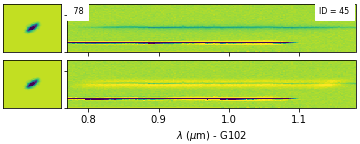

In [37]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

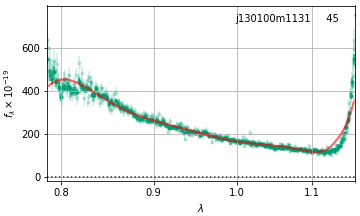

In [38]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 45


(45, 1, 9.942816972732544)

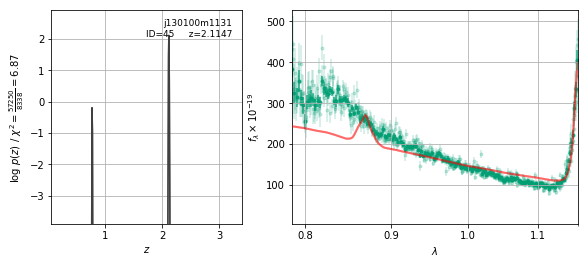

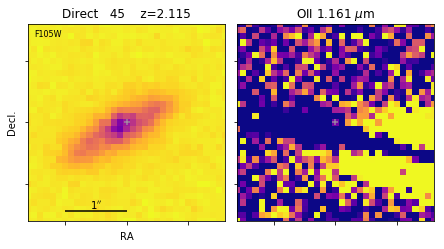

In [39]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [40]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j130100m1131_00045.log_par
j130100m1131_00045.beams.fits
j130100m1131_00045.1D.png
j130100m1131_00045.stack.png
j130100m1131_00045.1D.fits
j130100m1131_00045.full.fits
j130100m1131_00045.full.png
j130100m1131_00045.line.png
j130100m1131_00045.stack.fits


In [41]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j130100m1131_00045.beams.fits


Filename: j130100m1131_00045.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  REF           1 ImageHDU       244   (64, 64)   float32   
  2  SEG           1 ImageHDU       235   (64, 64)   int32   
  3  SCI           2 ImageHDU       243   (271, 64)   float32   
  4  ERR           2 ImageHDU       234   (271, 64)   float32   
  5  DQ            2 ImageHDU       234   (271, 64)   int16   
  6  CONTAM        2 ImageHDU       234   (271, 64)   float32   
  7  REF           1 ImageHDU       244   (64, 64)   float32   
  8  SEG           1 ImageHDU       235   (64, 64)   int32   
  9  SCI           2 ImageHDU       243   (271, 64)   float32   
 10  ERR           2 ImageHDU       234   (271, 64)   float32   
 11  DQ            2 ImageHDU       234   (271, 64)   int16   
 12  CONTAM        2 ImageHDU       234   (271, 64)   float32   
 13  REF           1 ImageHDU       244   (64

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [42]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 383 1
j130100m1131_00383.beams.fits


True

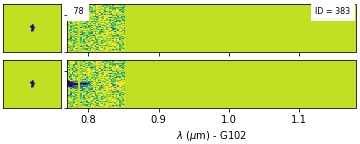

In [43]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

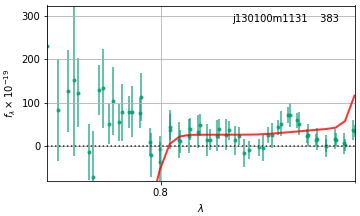

In [44]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 383


(383, 1, 3.1334009170532227)

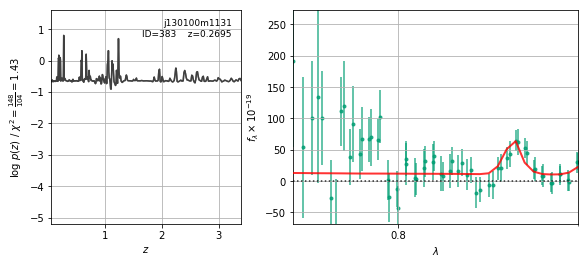

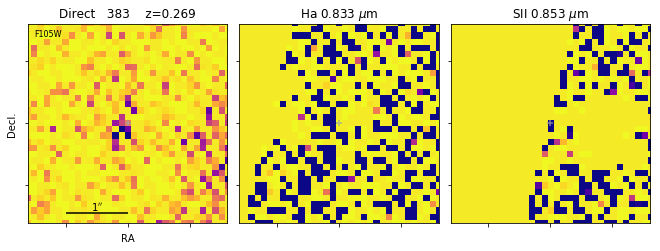

In [45]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).